## Importing Libraries

In [323]:
import numpy as np
import pandas as pd
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.semi_supervised import LabelPropagation

# import tensorflow 
# from tensorflow import keras
import keras
from keras import backend as K
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model

import xgboost as xgb

import six
from six import StringIO  

import random 

from IPython.display import Image  
import pydotplus
import re

import warnings
warnings.filterwarnings('ignore')

## Reading the Data

In [324]:
fingerprints_df_from_file = pd.read_csv('../Dataset/Original_Dataset/Whole_Dataset/fingerprint.csv')
fingerprints_df = fingerprints_df_from_file.iloc[: , 2:]
#training_cols = [col for col in fingerprints_df.columns if col not in ['channel1', 'channel2','channel3','channel4','channel5','channel6','channel7','channel8','channel9','channel10','channel11','channel12','channel13', 'channel14', 'channel15', 'channel16', 'channel17', 'channel18', 'channel19', 'channel20','location']]
training_cols = [col for col in fingerprints_df.columns if col not in ['location']]
# X = fingerprints_df.loc[:, training_cols]
# target = fingerprints_df.loc[:, 'location']
fingerprints_df


beacon1  channel1  beacon2  channel2  beacon3  channel3  beacon4  \
0        -100        37      -81        37     -300         0     -300   
1         -97        37      -87        38     -300         0     -300   
2         -91        37      -84        38     -300         0     -300   
3         -92        38      -85        38      -95        38     -300   
4         -94        37      -80        37     -300         0     -300   
...       ...       ...      ...       ...      ...       ...      ...   
1194     -300         0     -300         0     -300         0     -300   
1195     -300         0     -300         0     -300         0     -300   
1196     -300         0     -300         0     -300         0     -300   
1197     -300         0     -300         0     -300         0     -300   
1198     -300         0     -300         0     -300         0     -300   

      channel4  beacon5  channel5  ...  channel16  beacon17  channel17  \
0            0     -300         0  ...          0      -300          0   
1            0     -300         0  ...          0      -300          0   
2            0     -300         0  ...          0      -300          0   
3            0     -300         0  ...          0      -300          0   
4            0     -300         0  ...          0      -300          0   
...        ...      ...       ...  ...        ...       ...        ...   
1194         0     -300         0  ...         37       -92         38   
1195         0     -300         0  ...         37       -85         38   
1196         0     -300         0  ...         37       -91         37   
1197         0     -300         0  ...         37       -85         38   
1198         0     -300         0  ...         38       -91         38   

      beacon18  channel18  beacon19  channel19  beacon20  channel20  location  
0         -300          0      -300          0      -300          0        b1  
1         -300          0      -300          0      -300          0        b1  
2         -300          0      -300          0      -300          0        b1  
3         -300          0      -300          0      -300          0        b1  
4         -300          0      -300          0      -300          0        b1  
...        ...        ...       ...        ...       ...        ...       ...  
1194       -83         38       -88         37      -300          0      sa15  
1195       -82         39       -91         38      -300          0      sa15  
1196       -98         37       -92         37      -300          0      sa15  
1197       -78         38       -89         37      -300          0      sa15  
1198       -97         37       -89         38      -300          0      sa15  

[1199 rows x 41 columns]

## Data Preprocessing

### Kalman Filter

In [325]:
def calculate_kalman_equations(current_measurement, prior_mean, prior_variance, mean_prediction_factor, variance_prediction_factor, measurement_error , process_noise):
    extrapolated_mean = mean_prediction_factor*prior_mean + np.random.normal(0, process_noise)
    extrapolated_variance = prior_variance*variance_prediction_factor + process_noise
    
    measurement_variance = measurement_error
    
    kalman_gain = extrapolated_variance/(extrapolated_variance + measurement_variance)
    current_mean_estimate = extrapolated_mean + kalman_gain*(current_measurement - extrapolated_mean)
    current_variance_estimate = (1-kalman_gain)*extrapolated_variance
    
    return current_mean_estimate, current_variance_estimate

In [326]:
def kalman_filter(measured_signal, mean_prediction_factor =1, variance_prediction_factor =1, measurement_error = 6, process_noise= 1.6):
    estimated_signal = []
    #initialization
    estimated_signal.append(measured_signal[0])
    prior_mean = measured_signal[0]
    prior_variance = 0
  
    for i in range(1, len(measured_signal)):
        if measured_signal[i] == -300:
            calculated_mean, calculated_variance = calculate_kalman_equations(measured_signal[i], prior_mean, prior_variance, mean_prediction_factor, variance_prediction_factor, measurement_error, process_noise)
            estimated_signal.append(calculated_mean)  
        else:
            prior_mean, prior_variance = calculate_kalman_equations(measured_signal[i], prior_mean, prior_variance, mean_prediction_factor, variance_prediction_factor, measurement_error, process_noise)
            estimated_signal.append(prior_mean)  
    
    return estimated_signal

### Alpha-Beta-Gamma Filter

In [327]:
def alpha_beta_gamma_filter(measured_signal):
    estimated_signal = []
    #initialization
    estimated_signal.append(measured_signal[0])
    prior_mean = measured_signal[0]
    
    for i in range(1, len(measured_signal)):
        alpha = 1/i
        if measured_signal[i] == -300:
            estimated_signal.append(prior_mean + alpha*(measured_signal[i] - prior_mean))
        else:
            prior_mean = prior_mean + alpha*(measured_signal[i] - prior_mean)
            estimated_signal.append(prior_mean)
        
    return estimated_signal
    

### Fast Fourier Transform Filter

In [328]:
def fast_fourier_transform_filter(measured_signal, window_size=8, M=2):
    estimated_signal = []
    for j in range(0, np.shape(measured_signal)[0], window_size):  
        window_size = np.minimum(window_size, np.shape(measured_signal)[0] - j)  
        R_0 = np.zeros(window_size)
        R_0[:] = measured_signal[j:j + window_size] 
        R_0_fft = np.fft.fft(R_0) 
        if window_size <= 3:
            M = 1;
        for k in range(int(window_size/ 2)): 
            R_0_fft[M + k] = 0  
            R_0_fft[-1 - M - k] = 0

        R_0_ifft = np.fft.ifft(R_0_fft)  
        for i in range(0, window_size):
            estimated_signal.append(R_0_ifft[i]) 

    return estimated_signal

### Filter Application Method

In [329]:
def apply_filter(dataframe, filter_name,filename):
    filtered_data = dataframe.to_dict()
    for key in filtered_data:
        filtered_data[key] = list(filtered_data[key].values())
    
    unique_locations = dataframe.location.unique()
    for i in range(1,21):
        current_beacon_rssis = []
        for location in unique_locations:
            current_rssis = dataframe.loc[dataframe['location'] == location]   
            current_signal = current_rssis['beacon'+str(i)].values.tolist()
            if filter_name == "kalman":
                estimated_signal = kalman_filter(current_signal)
            elif filter_name == "alpha_beta_gamma":
                estimated_signal = alpha_beta_gamma_filter(current_signal)
            elif filter_name == "fast_fourier_transform":
                estimated_signal = fast_fourier_transform_filter(current_signal)
                estimated_signal = [c.real for c in estimated_signal]

            current_beacon_rssis = current_beacon_rssis + estimated_signal
        filtered_data['beacon'+str(i)] = current_beacon_rssis
        
    result = pd.DataFrame(filtered_data)
    result.to_csv("../Dataset/Filtered_Dataset/"+filter_name+"/"+filename, sep=',', index=False, encoding='utf-8')
    return result

In [330]:
def apply_filter_to_whole(dataframe, filter_name, filename):
    filtered_data = dataframe.to_dict()
    for key in filtered_data:
        filtered_data[key] = list(filtered_data[key].values())

    for i in range(1,21):
        current_signal = dataframe['beacon'+str(i)].values.tolist()
        if filter_name == "kalman":
            estimated_signal = kalman_filter(current_signal)
        elif filter_name == "alpha_beta_gamma":
            estimated_signal = alpha_beta_gamma_filter(current_signal)
        elif filter_name == "fast_fourier_transform":
            estimated_signal = fast_fourier_transform_filter(current_signal)
            estimated_signal = [c.real for c in estimated_signal]
            
        filtered_data['beacon'+str(i)] = estimated_signal      
    result = pd.DataFrame(filtered_data)
    result.to_csv("../Dataset/Filtered_Dataset/"+filter_name+"/"+filename, sep=',', index=False, encoding='utf-8')
    return result

### Data Type Correction

In [331]:
fingerprints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 41 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   beacon1    1199 non-null   int64 
 1   channel1   1199 non-null   int64 
 2   beacon2    1199 non-null   int64 
 3   channel2   1199 non-null   int64 
 4   beacon3    1199 non-null   int64 
 5   channel3   1199 non-null   int64 
 6   beacon4    1199 non-null   int64 
 7   channel4   1199 non-null   int64 
 8   beacon5    1199 non-null   int64 
 9   channel5   1199 non-null   int64 
 10  beacon6    1199 non-null   int64 
 11  channel6   1199 non-null   int64 
 12  beacon7    1199 non-null   int64 
 13  channel7   1199 non-null   int64 
 14  beacon8    1199 non-null   int64 
 15  channel8   1199 non-null   int64 
 16  beacon9    1199 non-null   int64 
 17  channel9   1199 non-null   int64 
 18  beacon10   1199 non-null   int64 
 19  channel10  1199 non-null   int64 
 20  beacon11   1199 non-null   int

In [332]:
channel_cols = ['channel1', 'channel2','channel3','channel4','channel5','channel6','channel7','channel8','channel9','channel10','channel11','channel12','channel13', 'channel14', 'channel15', 'channel16', 'channel17', 'channel18', 'channel19', 'channel20']
for col in channel_cols:
    fingerprints_df[col] = fingerprints_df[col].map(str)
fingerprints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 41 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   beacon1    1199 non-null   int64 
 1   channel1   1199 non-null   object
 2   beacon2    1199 non-null   int64 
 3   channel2   1199 non-null   object
 4   beacon3    1199 non-null   int64 
 5   channel3   1199 non-null   object
 6   beacon4    1199 non-null   int64 
 7   channel4   1199 non-null   object
 8   beacon5    1199 non-null   int64 
 9   channel5   1199 non-null   object
 10  beacon6    1199 non-null   int64 
 11  channel6   1199 non-null   object
 12  beacon7    1199 non-null   int64 
 13  channel7   1199 non-null   object
 14  beacon8    1199 non-null   int64 
 15  channel8   1199 non-null   object
 16  beacon9    1199 non-null   int64 
 17  channel9   1199 non-null   object
 18  beacon10   1199 non-null   int64 
 19  channel10  1199 non-null   object
 20  beacon11   1199 non-null   int

### One-hot Encoding for Categorical Features

In [333]:
fingerprints_df = pd.get_dummies(fingerprints_df, columns = ['channel1', 'channel2','channel3','channel4','channel5','channel6','channel7','channel8','channel9','channel10','channel11','channel12','channel13', 'channel14', 'channel15', 'channel16', 'channel17', 'channel18', 'channel19', 'channel20'])
for col in fingerprints_df:
    print(col)
    print(fingerprints_df[col].unique())

beacon1
[-100  -97  -91  -92  -94  -99  -96  -98 -300  -93  -95 -101 -105 -102
 -106 -103  -89  -79  -81  -76  -77  -85  -80  -74  -78  -82  -72  -83
  -84  -87 -109  -88  -90  -86 -104]
beacon2
[ -81  -87  -84  -85  -80  -78  -86  -83  -94  -88  -82  -96  -93  -79
  -90  -89  -98  -91  -95  -77  -76  -74  -92  -97 -101  -70  -73  -71
  -75  -72 -102  -99 -100 -103 -104 -300]
beacon3
[-300  -95 -101  -97 -103  -99 -102  -98 -100 -104  -96 -105  -94  -93
  -92  -87  -86  -85  -90  -89  -82  -84  -91  -80  -88  -81  -83  -77
  -78  -79  -72  -76  -74]
beacon4
[-300 -101 -103  -98  -99 -105 -100  -97  -96  -95  -93 -104  -94 -106
 -102  -92  -90  -91  -88  -89  -87  -86  -82  -85  -84  -83  -80  -81
  -75  -77  -78  -71  -76  -79]
beacon5
[-300  -99  -98 -103  -97  -95  -96 -101  -94 -105  -93 -102 -106  -91
  -84  -89  -80  -88  -82  -83  -92  -90  -85 -100  -86  -87  -79  -81
  -76  -78  -74  -72]
beacon6
[-300 -100 -101 -102  -99  -97  -98  -96  -93  -95  -94  -88 -103 -105
  -91  -86 

### Label Encoding the Labels

In [334]:
label_encoder = preprocessing.LabelEncoder()
fingerprints_df['location']= label_encoder.fit_transform(fingerprints_df['location'])

In [335]:
enc_labels = fingerprints_df['location'].unique()
rev_enc_labels = label_encoder.inverse_transform(enc_labels)
print(enc_labels)
print(rev_enc_labels)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 36 37 38 39 40 41
 42 50 51 52 53 58 59 60 61 66 73 74 75 76 77 78 79 80 67 68 69 70 71 72
 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 43 44 45 46 47 48
 49 54 55 56 57 62 63 64 65 81 88 89 90 91 92 93 94 95 82 83 84 85 86 87]
['b1' 'b2' 'b3' 'b4' 'b5' 'b6' 'b7' 'b8' 'b9' 'be1' 'be2' 'be3' 'be4'
 'be5' 'be6' 'be7' 'be8' 'be9' 'h1' 'h2' 'h3' 'h4' 'h5' 'h6' 'h7' 'k1'
 'k2' 'k3' 'k4' 'l1' 'l2' 'l3' 'l4' 's1' 's2' 's3' 's4' 's5' 's6' 's7'
 's8' 's9' 's10' 's11' 's12' 's13' 's14' 's15' 'c1' 'c2' 'c3' 'c4' 'c5'
 'c6' 'c7' 'c8' 'c9' 'ce1' 'ce2' 'ce3' 'ce4' 'ce5' 'ce6' 'ce7' 'ce8' 'ce9'
 'ha1' 'ha2' 'ha3' 'ha4' 'ha5' 'ha6' 'ha7' 'ki1' 'ki2' 'ki3' 'ki4' 'li1'
 'li2' 'li3' 'li4' 'sa1' 'sa2' 'sa3' 'sa4' 'sa5' 'sa6' 'sa7' 'sa8' 'sa9'
 'sa10' 'sa11' 'sa12' 'sa13' 'sa14' 'sa15']


In [336]:
label_mappings= dict(zip(enc_labels, rev_enc_labels))
label_mappings

{0: 'b1',
 1: 'b2',
 2: 'b3',
 3: 'b4',
 4: 'b5',
 5: 'b6',
 6: 'b7',
 7: 'b8',
 8: 'b9',
 9: 'be1',
 10: 'be2',
 11: 'be3',
 12: 'be4',
 13: 'be5',
 14: 'be6',
 15: 'be7',
 16: 'be8',
 17: 'be9',
 36: 'h1',
 37: 'h2',
 38: 'h3',
 39: 'h4',
 40: 'h5',
 41: 'h6',
 42: 'h7',
 50: 'k1',
 51: 'k2',
 52: 'k3',
 53: 'k4',
 58: 'l1',
 59: 'l2',
 60: 'l3',
 61: 'l4',
 66: 's1',
 73: 's2',
 74: 's3',
 75: 's4',
 76: 's5',
 77: 's6',
 78: 's7',
 79: 's8',
 80: 's9',
 67: 's10',
 68: 's11',
 69: 's12',
 70: 's13',
 71: 's14',
 72: 's15',
 18: 'c1',
 19: 'c2',
 20: 'c3',
 21: 'c4',
 22: 'c5',
 23: 'c6',
 24: 'c7',
 25: 'c8',
 26: 'c9',
 27: 'ce1',
 28: 'ce2',
 29: 'ce3',
 30: 'ce4',
 31: 'ce5',
 32: 'ce6',
 33: 'ce7',
 34: 'ce8',
 35: 'ce9',
 43: 'ha1',
 44: 'ha2',
 45: 'ha3',
 46: 'ha4',
 47: 'ha5',
 48: 'ha6',
 49: 'ha7',
 54: 'ki1',
 55: 'ki2',
 56: 'ki3',
 57: 'ki4',
 62: 'li1',
 63: 'li2',
 64: 'li3',
 65: 'li4',
 81: 'sa1',
 88: 'sa2',
 89: 'sa3',
 90: 'sa4',
 91: 'sa5',
 92: 'sa6',
 93: 'sa

## Dataset Splitting

In [337]:
def split_train_validation_test(dataframe, train_size, validation_size):
    shuffled_df = dataframe.sample(frac=1, random_state = 37)
    train_num = int(train_size * len(dataframe))
    validation_num = int(validation_size * len(dataframe))
    test_num = len(dataframe) - train_num - validation_num
    
    train_set_with_label = shuffled_df[:train_num]
    validation_set_with_label = shuffled_df[train_num : train_num + validation_num]
    test_set_with_label = shuffled_df[ train_num + validation_num:]
    
    train_set_with_label = train_set_with_label.sort_values('location')
    validation_set_with_label = validation_set_with_label.sort_values('location')
    test_set_with_label = test_set_with_label.sort_values('location')
    
    training_cols = [col for col in train_set_with_label.columns if col not in ['location']]
    
    train_set = train_set_with_label.loc[:, training_cols]
    target_train = train_set_with_label.loc[:, 'location']
    
    validation_set = validation_set_with_label.loc[:, training_cols]
    target_validation = validation_set_with_label.loc[:, 'location']
    
    test_set = test_set_with_label.loc[:, training_cols]
    target_test = test_set_with_label.loc[:, 'location']
    
    
    
    return shuffled_df, train_set_with_label, validation_set_with_label, test_set_with_label, train_set, target_train, validation_set, target_validation, test_set, target_test

In [338]:
shuf, train, validation, test, X_train, target_train, X_validation, target_validation, X_test, target_test = split_train_validation_test(fingerprints_df, 0.8,0.1)

### Splitting Test

In [339]:
training_cols = [col for col in train.columns if col not in ['location']]

print("Shapes:")
print(X_train.shape, X_validation.shape, X_test.shape, target_train.shape, target_validation.shape, target_test.shape,"\n")

print("Check if the split is correct:")
print("Train columns: ", ((train.loc[:, training_cols]==X_train).all()).all())
print("Validation columns: ", ((validation.loc[:, training_cols]==X_validation).all()).all())
print("Test columns: ", ((test.loc[:, training_cols]==X_test).all()).all())
print("Train targets: ",(target_train==train['location']).all())
print("Validation targets: ",(target_validation==validation['location']).all())
print("Test targets: ",(target_test==test['location']).all())

Shapes:
(959, 100) (119, 100) (121, 100) (959,) (119,) (121,) 

Check if the split is correct:
Train columns:  True
Validation columns:  True
Test columns:  True
Train targets:  True
Validation targets:  True
Test targets:  True


In [340]:
train

beacon1  beacon2  beacon3  beacon4  beacon5  beacon6  beacon7  beacon8  \
17       -300      -84      -99     -300     -300     -300     -300     -300   
1         -97      -87     -300     -300     -300     -300     -300     -300   
10        -93      -86     -300     -300     -300     -300     -300     -300   
4         -94      -80     -300     -300     -300     -300     -300     -300   
6         -96      -81     -101     -300     -300     -300     -300     -300   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1160     -300     -300     -300     -300     -300     -300     -300     -300   
1167     -300     -300     -300     -300     -300     -300     -300     -300   
1164     -300     -300     -300     -300     -300     -300     -300     -300   
1168     -300     -300     -300     -300     -300     -300     -300     -300   
1165     -300     -300     -300     -300     -300     -300     -300     -300   

      beacon9  beacon10  ...  channel18_38  channel18_39  channel19_0  \
17       -300       -99  ...             0             0            1   
1        -300       -97  ...             0             0            1   
10       -300      -300  ...             0             0            1   
4        -300       -99  ...             0             0            1   
6        -300      -300  ...             0             0            1   
...       ...       ...  ...           ...           ...          ...   
1160     -300      -300  ...             0             0            0   
1167     -300      -300  ...             0             1            0   
1164     -300      -300  ...             1             0            0   
1168     -300      -300  ...             1             0            0   
1165     -300      -300  ...             0             0            0   

      channel19_37  channel19_38  channel19_39  channel20_0  channel20_37  \
17               0             0             0            1             0   
1                0             0             0            1             0   
10               0             0             0            1             0   
4                0             0             0            1             0   
6                0             0             0            1             0   
...            ...           ...           ...          ...           ...   
1160             1             0             0            1             0   
1167             1             0             0            1             0   
1164             0             1             0            1             0   
1168             1             0             0            1             0   
1165             1             0             0            1             0   

      channel20_38  channel20_39  
17               0             0  
1                0             0  
10               0             0  
4                0             0  
6                0             0  
...            ...           ...  
1160             0             0  
1167             0             0  
1164             0             0  
1168             0             0  
1165             0             0  

[959 rows x 101 columns]

In [341]:
X_train

beacon1  beacon2  beacon3  beacon4  beacon5  beacon6  beacon7  beacon8  \
17       -300      -84      -99     -300     -300     -300     -300     -300   
1         -97      -87     -300     -300     -300     -300     -300     -300   
10        -93      -86     -300     -300     -300     -300     -300     -300   
4         -94      -80     -300     -300     -300     -300     -300     -300   
6         -96      -81     -101     -300     -300     -300     -300     -300   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1160     -300     -300     -300     -300     -300     -300     -300     -300   
1167     -300     -300     -300     -300     -300     -300     -300     -300   
1164     -300     -300     -300     -300     -300     -300     -300     -300   
1168     -300     -300     -300     -300     -300     -300     -300     -300   
1165     -300     -300     -300     -300     -300     -300     -300     -300   

      beacon9  beacon10  ...  channel18_38  channel18_39  channel19_0  \
17       -300       -99  ...             0             0            1   
1        -300       -97  ...             0             0            1   
10       -300      -300  ...             0             0            1   
4        -300       -99  ...             0             0            1   
6        -300      -300  ...             0             0            1   
...       ...       ...  ...           ...           ...          ...   
1160     -300      -300  ...             0             0            0   
1167     -300      -300  ...             0             1            0   
1164     -300      -300  ...             1             0            0   
1168     -300      -300  ...             1             0            0   
1165     -300      -300  ...             0             0            0   

      channel19_37  channel19_38  channel19_39  channel20_0  channel20_37  \
17               0             0             0            1             0   
1                0             0             0            1             0   
10               0             0             0            1             0   
4                0             0             0            1             0   
6                0             0             0            1             0   
...            ...           ...           ...          ...           ...   
1160             1             0             0            1             0   
1167             1             0             0            1             0   
1164             0             1             0            1             0   
1168             1             0             0            1             0   
1165             1             0             0            1             0   

      channel20_38  channel20_39  
17               0             0  
1                0             0  
10               0             0  
4                0             0  
6                0             0  
...            ...           ...  
1160             0             0  
1167             0             0  
1164             0             0  
1168             0             0  
1165             0             0  

[959 rows x 100 columns]

## Applying Filtering

In [342]:
kalman_filtered = apply_filter(train, "kalman","kalman_1.csv")
apha_filtered = apply_filter(train, "alpha_beta_gamma","alpha_1.csv")
fft_filtered = apply_filter(train, "fast_fourier_transform","fft_1.csv")
train.to_csv("../Dataset/Filtered_Dataset/Original/"+"trained.csv", sep=',', index=False, encoding='utf-8')

In [343]:
filter_times = []
start_time = time.time()
kalman_filtered2 = apply_filter_to_whole(fingerprints_df, "kalman","kalman_2.csv")
runtime = round(time.time() - start_time,4)
filter_times.append(runtime)
print("Kalman Filter time: "+ str(runtime) + " seconds")
start_time = time.time()
alpha_filtered2 = apply_filter_to_whole(fingerprints_df, "alpha_beta_gamma","alpha_2.csv")
runtime = round(time.time() - start_time,4)
filter_times.append(runtime)
print("Alpha-Beta-Gamma Filter time: "+ str(runtime) + " seconds")
start_time = time.time()
fft_filtered2 = apply_filter_to_whole(fingerprints_df, "fast_fourier_transform","fft_2.csv")
runtime = round(time.time() - start_time,4)
filter_times.append(runtime)
print("Fast Fourier Transform Filter time: "+ str(runtime) + " seconds")

Kalman Filter time: 0.1922 seconds
Alpha-Beta-Gamma Filter time: 0.1047 seconds
Fast Fourier Transform Filter time: 0.3402 seconds


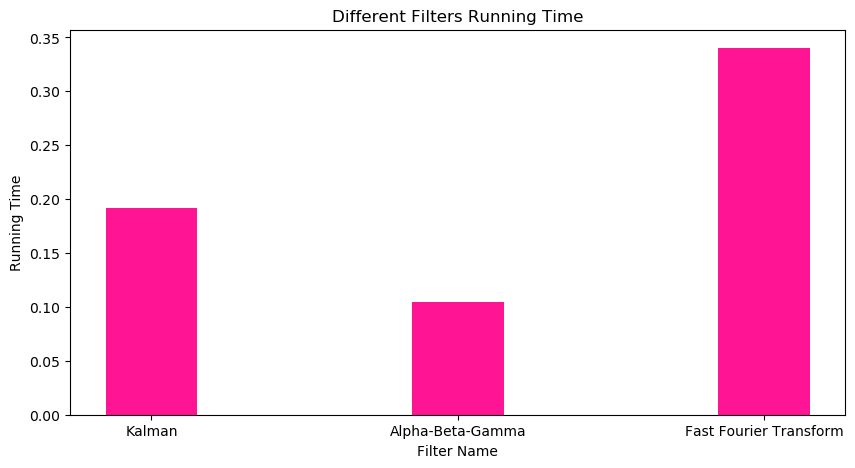

In [344]:
filters = ('Kalman', 'Alpha-Beta-Gamma', 'Fast Fourier Transform')
y_pos = np.arange(len(filters))

plt.bar(y_pos, filter_times,0.3, color="deeppink" ,align='center', alpha=1)
plt.rcParams['figure.figsize'] = [10, 5]
plt.xticks(y_pos, filters)
plt.xlabel('Filter Name')
plt.ylabel('Running Time')
plt.title('Different Filters Running Time')

plt.show()

In [345]:
kshuf, ktrain, kvalidation, ktest, kX_train, ktarget_train, kX_validation, ktarget_validation, kX_test, ktarget_test = split_train_validation_test(kalman_filtered2, 0.8,0.1)


In [346]:
ashuf, atrain, avalidation, atest, aX_train, atarget_train, aX_validation, atarget_validation, aX_test, atarget_test = split_train_validation_test(alpha_filtered2, 0.8,0.1)


In [347]:
fshuf, ftrain, fvalidation, ftest, fX_train, ftarget_train, fX_validation, ftarget_validation, fX_test, ftarget_test = split_train_validation_test(fft_filtered2, 0.8,0.1)


In [348]:
def plot_measured_estimated(measured_signal, estimated_signal, title):
    signals = [{'name': 'Measured Signal', 'x': np.arange(len(measured_signal)),
             'y': measured_signal, 'color':'orange', 'linewidth':3},
            {'name': 'Estimated Signal', 'x': np.arange(len(estimated_signal)),
             'y': estimated_signal, 'color':'green', 'linewidth':3}]

    fig, ax = plt.subplots()
    for signal in signals:
        ax.plot(signal['x'], signal['y'], 
                color=signal['color'], 
                linewidth=signal['linewidth'],
                label=signal['name'])
    plt.rcParams['figure.figsize'] = [40, 20]
    ax.legend()
    ax.set_title(title)
    plt.show()
    

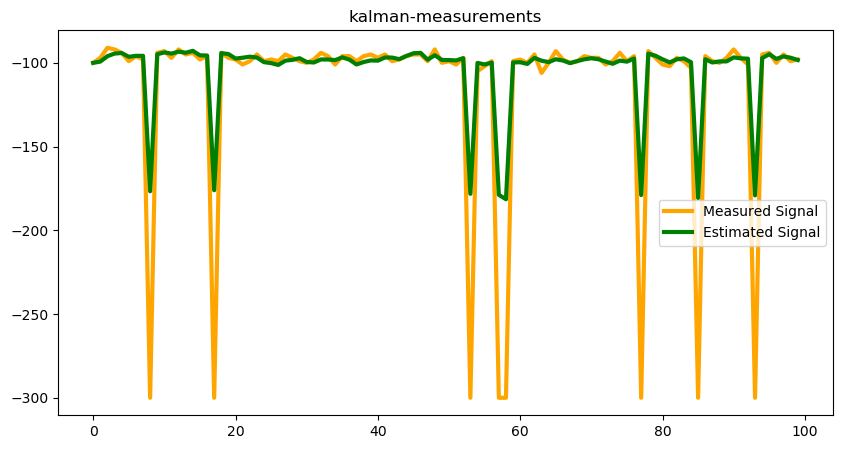

In [349]:
plot_measured_estimated(fingerprints_df['beacon1'].values.tolist()[:100],kalman_filtered2['beacon1'].values.tolist()[:100],"kalman-measurements")

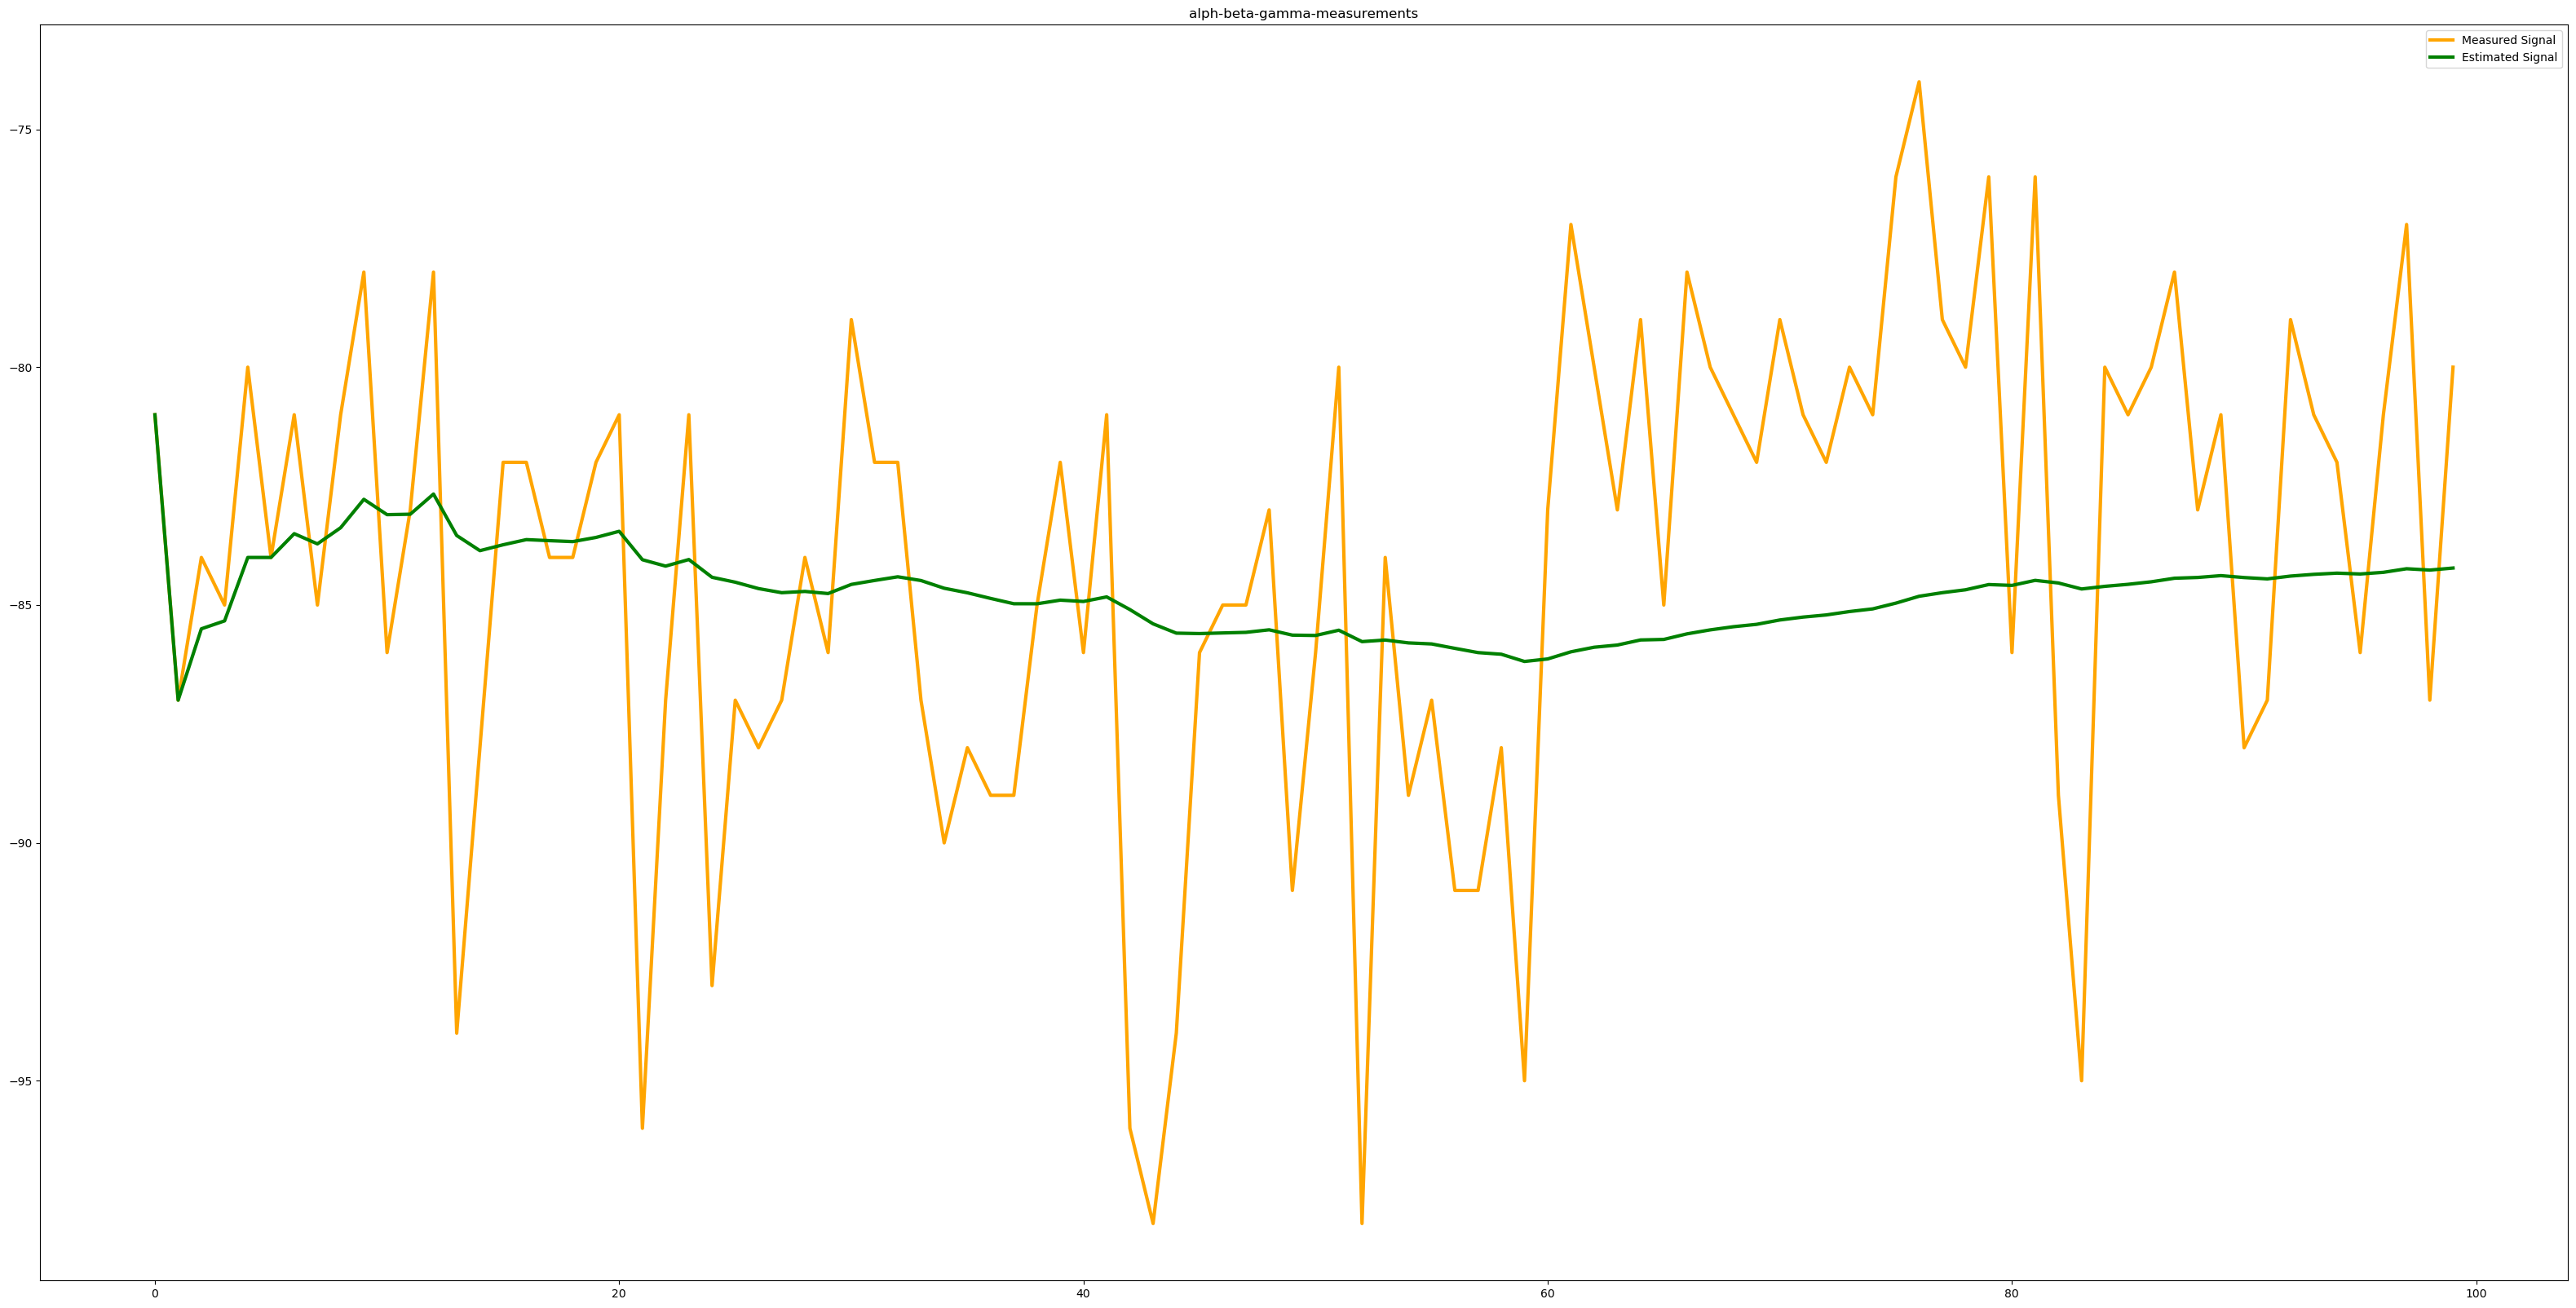

In [350]:
plot_measured_estimated(fingerprints_df['beacon2'].values.tolist()[:100],alpha_filtered2['beacon2'].values.tolist()[:100],"alph-beta-gamma-measurements")

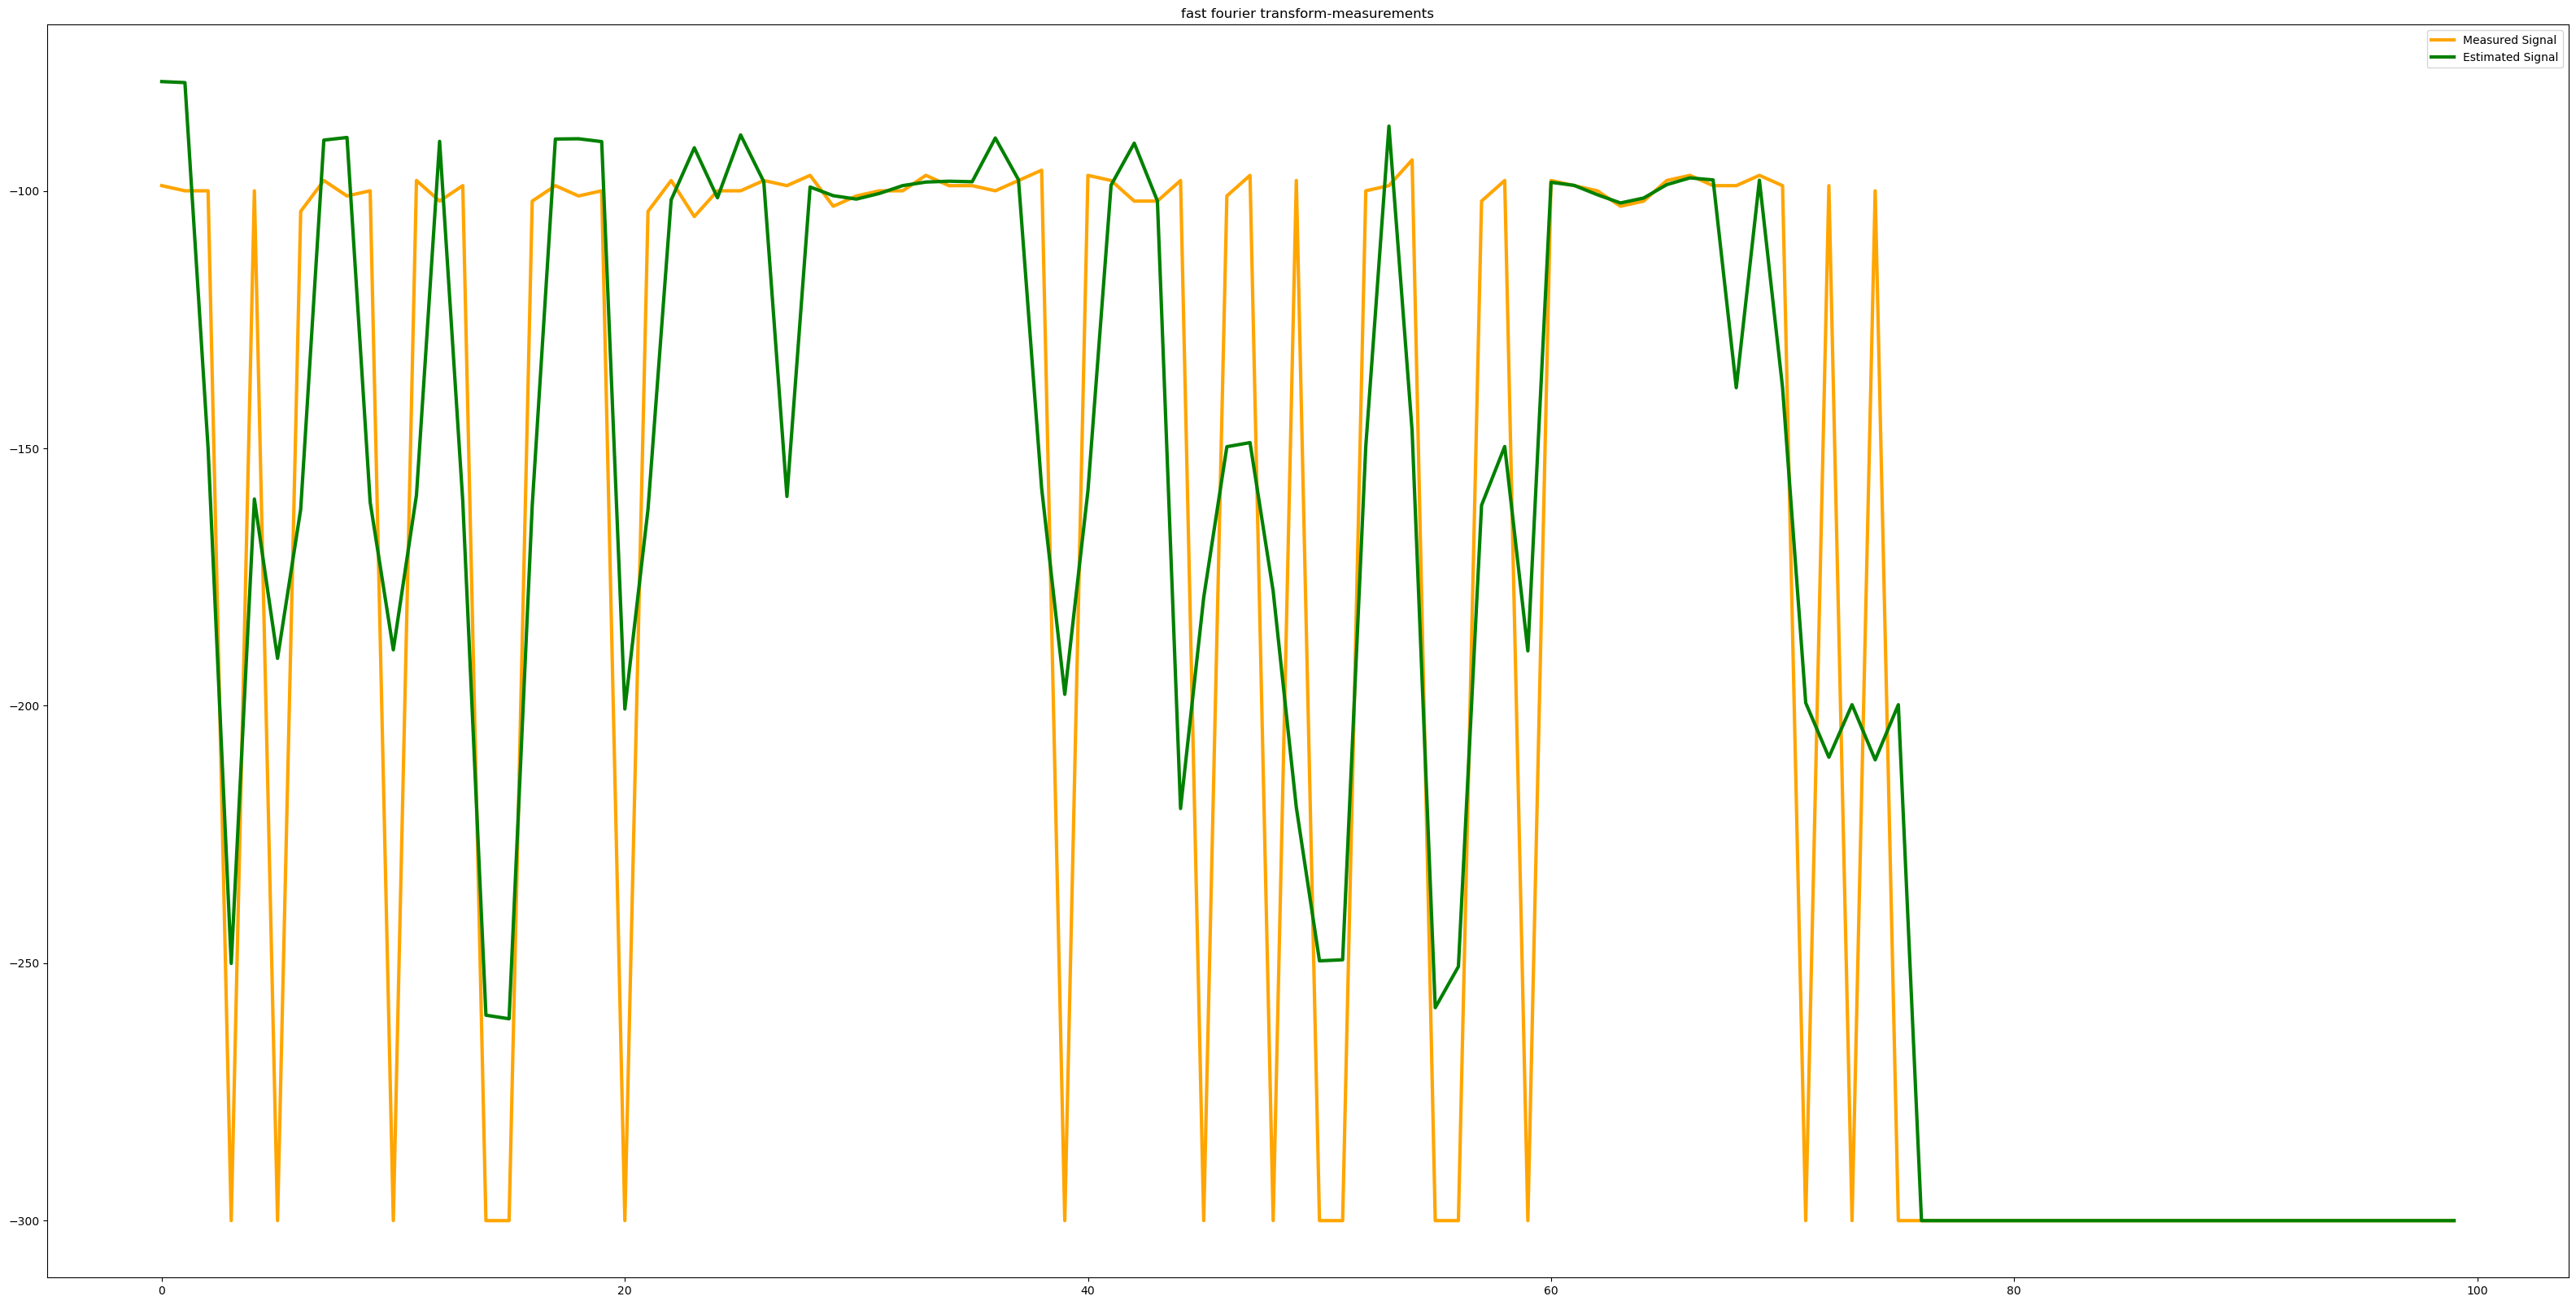

In [351]:
plot_measured_estimated(fingerprints_df['beacon3'].values.tolist()[100:200],fft_filtered2['beacon3'].values.tolist()[100:200],"fast fourier transform-measurements")

# Artificial Intelligence Algorithms

## K Nearest Neighbours

In [352]:
def k_nearest_neighbours(X_train, target_train, X_test, target_test,title):  
    accuracies = []
    for k in range(1, 9):
        knn = KNeighborsClassifier(n_neighbors = k, metric='manhattan')
        knn.fit(X_train, target_train)
        y_pred = knn.predict(X_test)
        accuracies.append(accuracy_score(target_test, y_pred)*100)

    plt.plot(list(range(1,9)), accuracies)
    plt.xticks(range(1,9))
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.title('K-nearest neighbours alogrithm accuracies with '+title)
    plt.show()
    print("K-nearest neighbours algorithm accuracy: "+ str(max(accuracies)))
    return max(accuracies)

In [353]:
def run_knn(X_train, target_train, X_test, target_test, k):
    knn = KNeighborsClassifier(n_neighbors = k, metric='manhattan')
    knn.fit(X_train, target_train)
    start_time = time.time()
    y_pred = knn.predict(X_test)
    runtime = round(time.time() - start_time,4)
    return y_pred, runtime

#### K-NN with the Original Data

##### Original Data without Channel Data

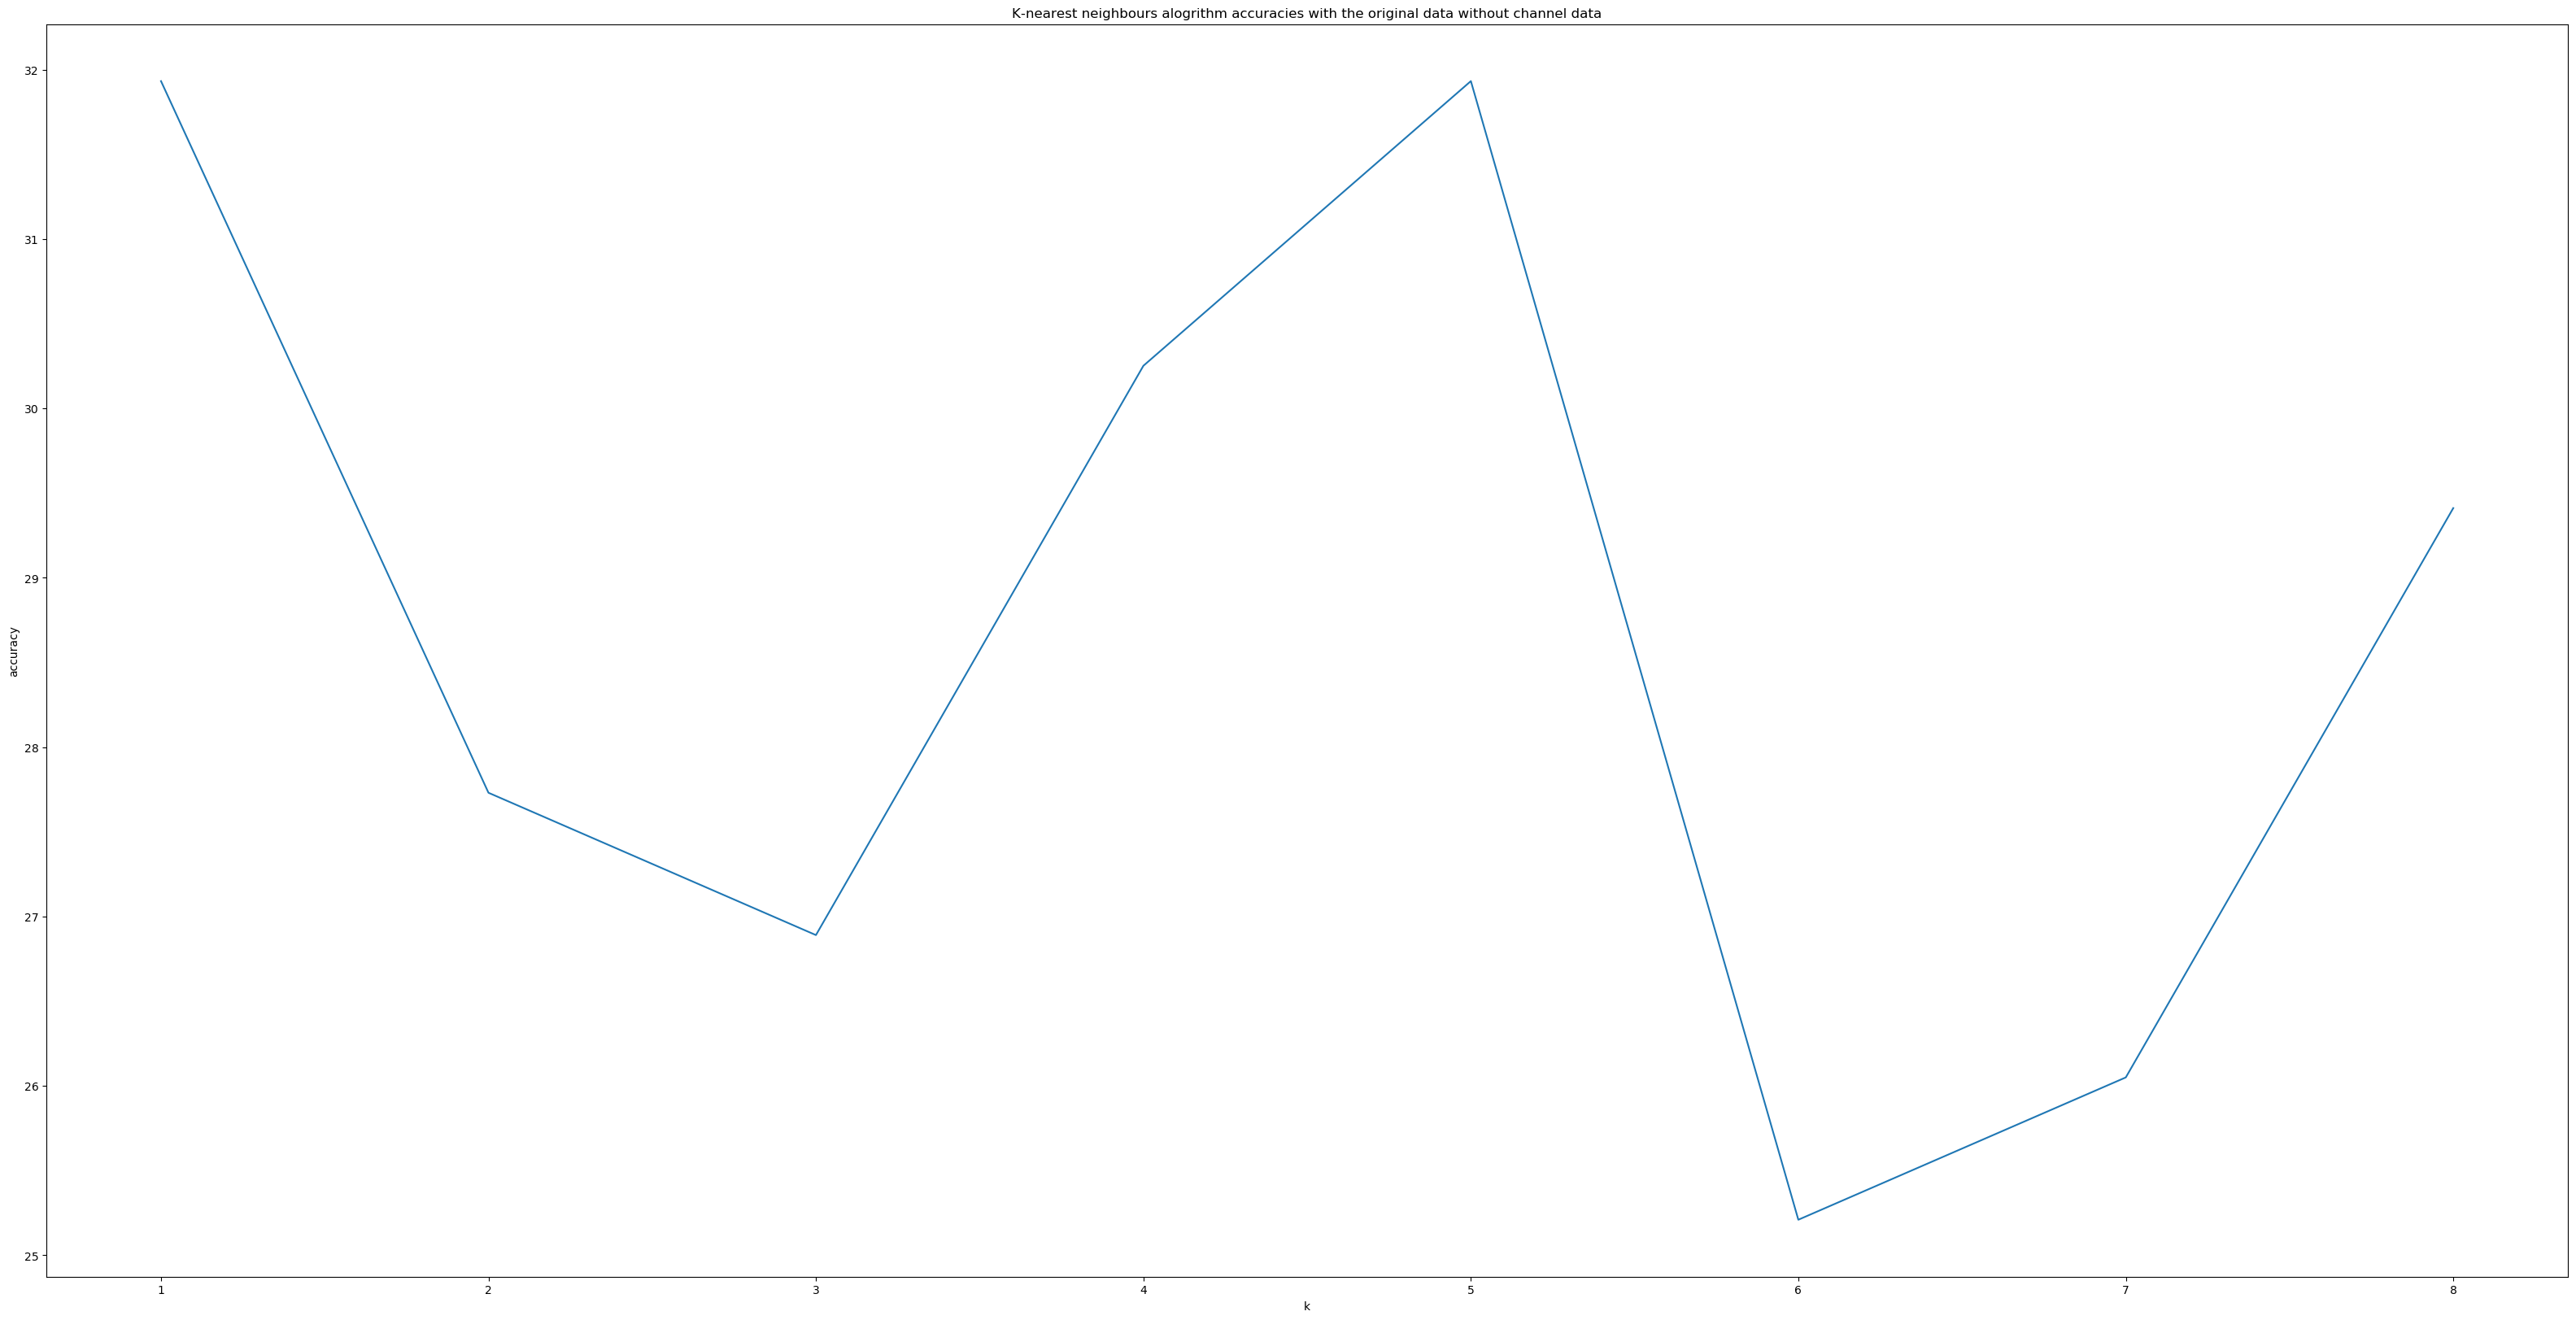

K-nearest neighbours algorithm accuracy: 31.932773109243694


31.932773109243694

In [354]:
no_channel_training_cols = ['beacon1', 'beacon2','beacon3','beacon4','beacon5','beacon6', 'beacon7', 'beacon8', 'beacon9', 'beacon10', 'beacon11', 'beacon12','beacon13','beacon14','beacon15','beacon16', 'beacon17', 'beacon18', 'beacon19', 'beacon20']
X_train_nc = X_train.loc[:, no_channel_training_cols]
X_validation_nc = X_validation.loc[:, no_channel_training_cols]
k_nearest_neighbours(X_train_nc, target_train, X_validation_nc, target_validation, "the original data without channel data")

##### Original Data with Channel Data

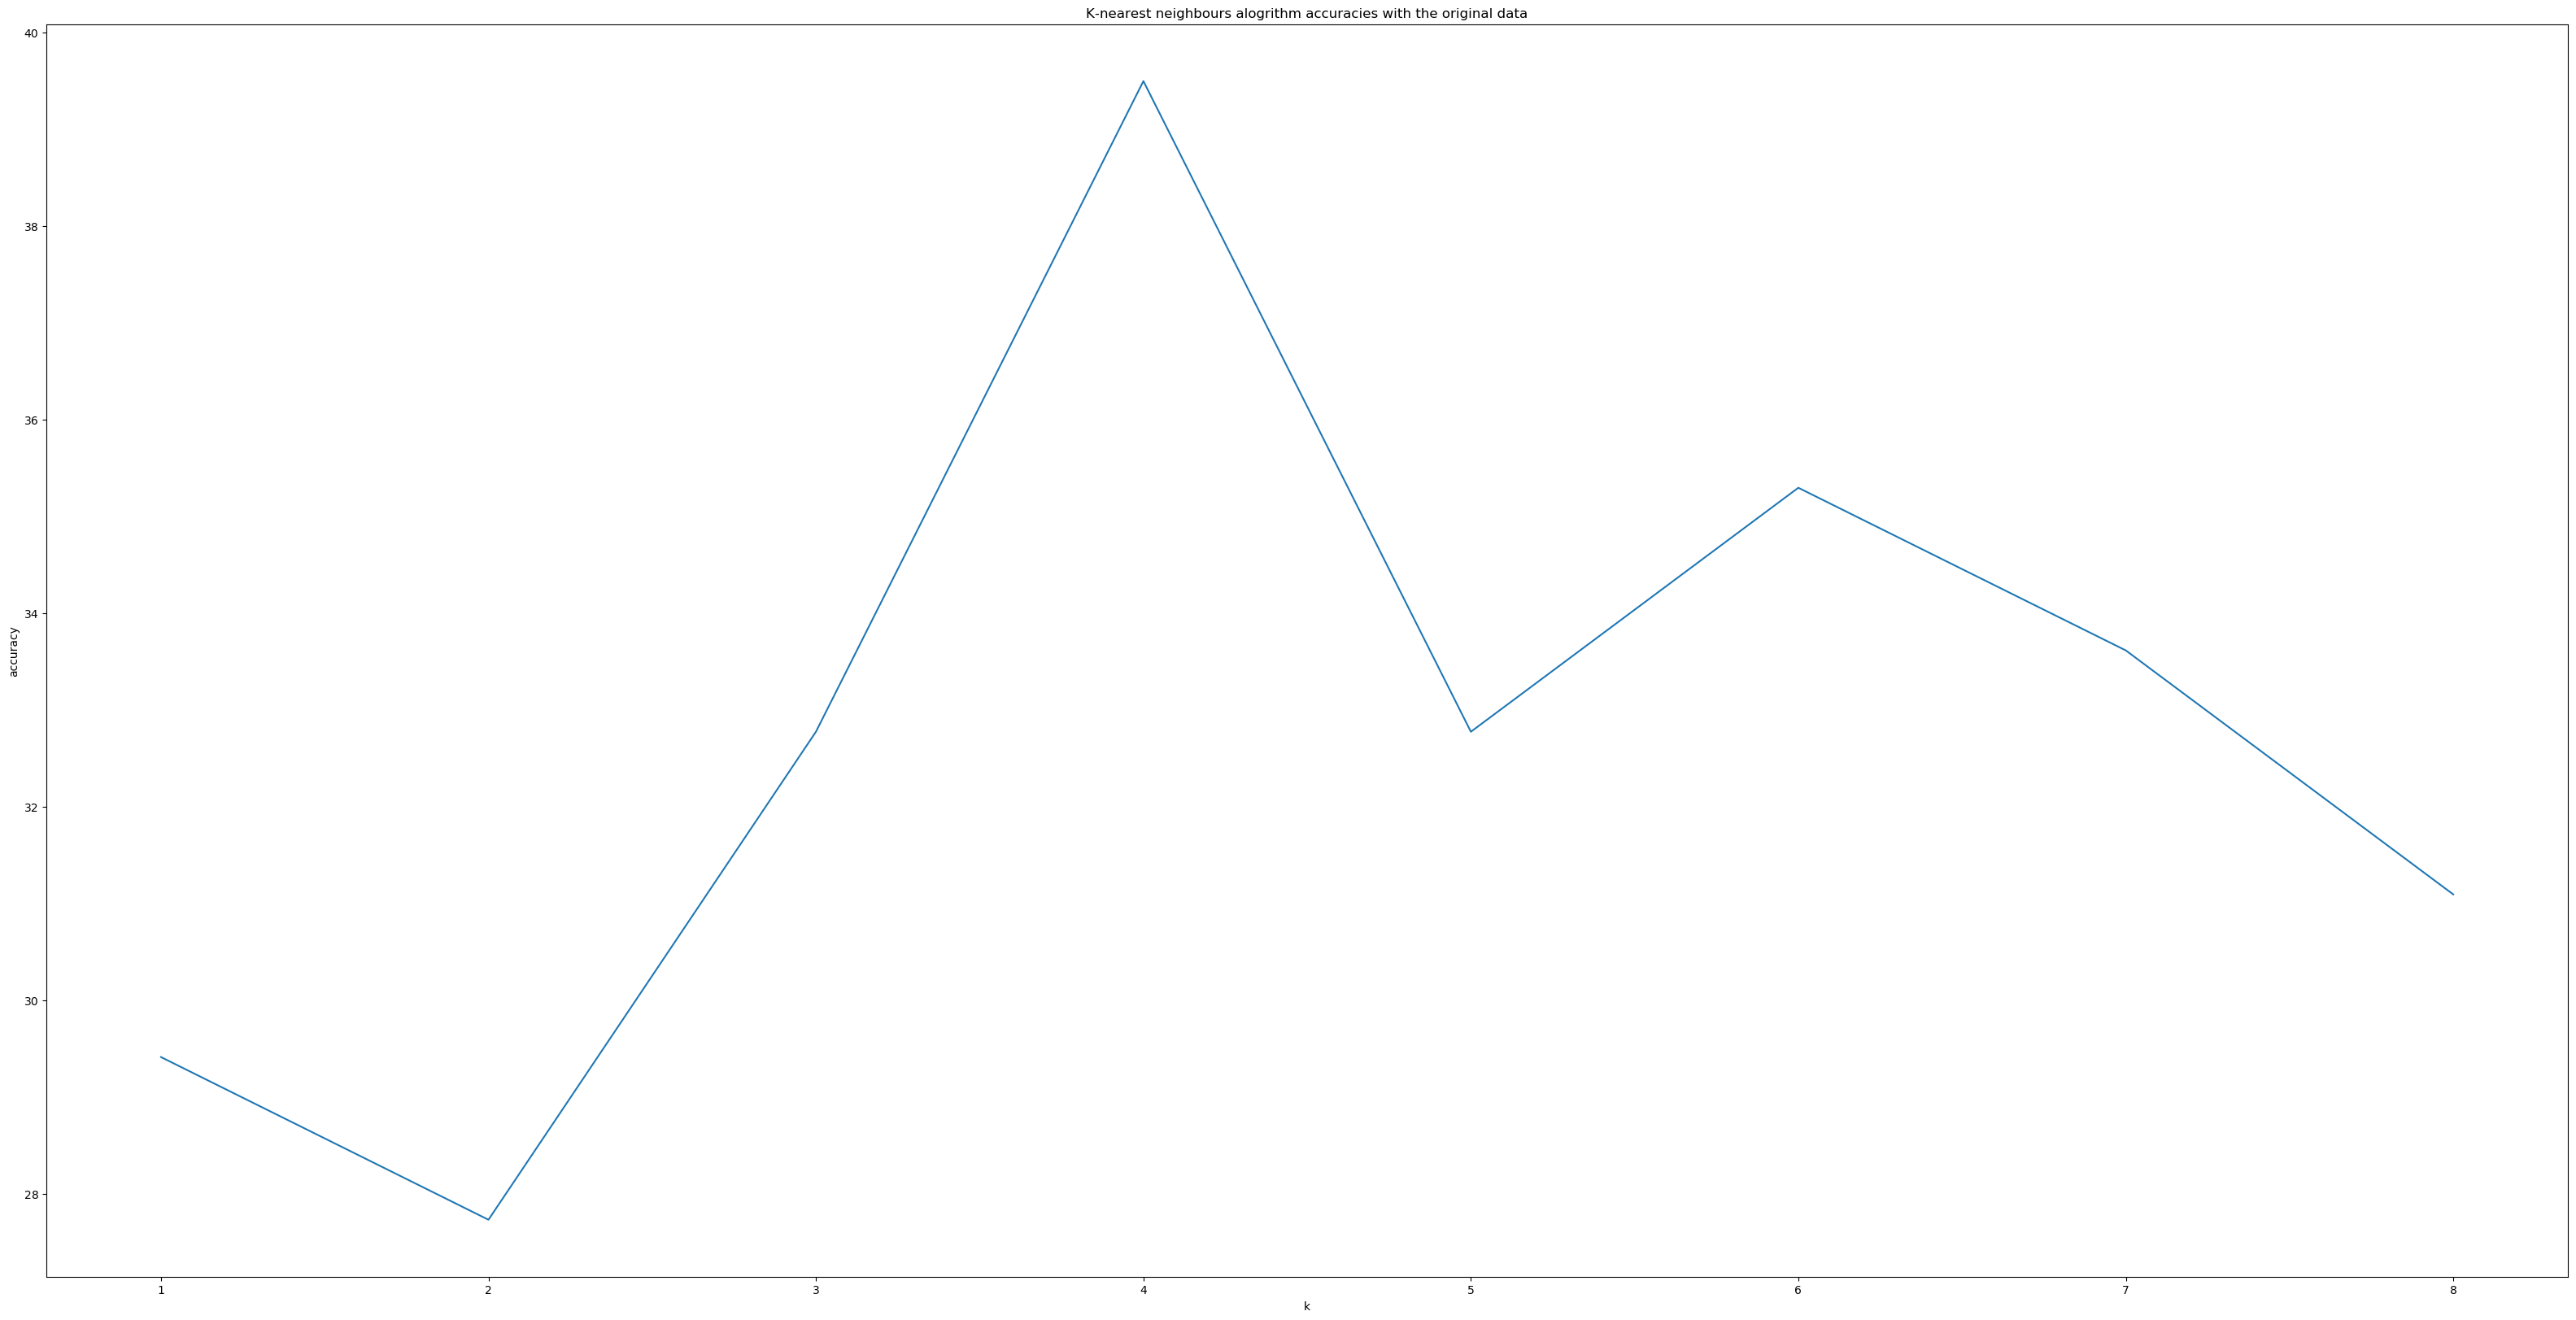

K-nearest neighbours algorithm accuracy: 39.49579831932773


In [355]:
accuracies = []
accuracies.append(k_nearest_neighbours(X_train, target_train, X_validation, target_validation, "the original data"))

#### K-NN with the Kalman Filter Preprocessing

In [356]:
def split_train_cols(dataframe):
    training_cols = [col for col in dataframe if col not in ['location']]
    train_set = dataframe.loc[:, training_cols]
    target_train = dataframe.loc[:, 'location']
    return train_set, target_train

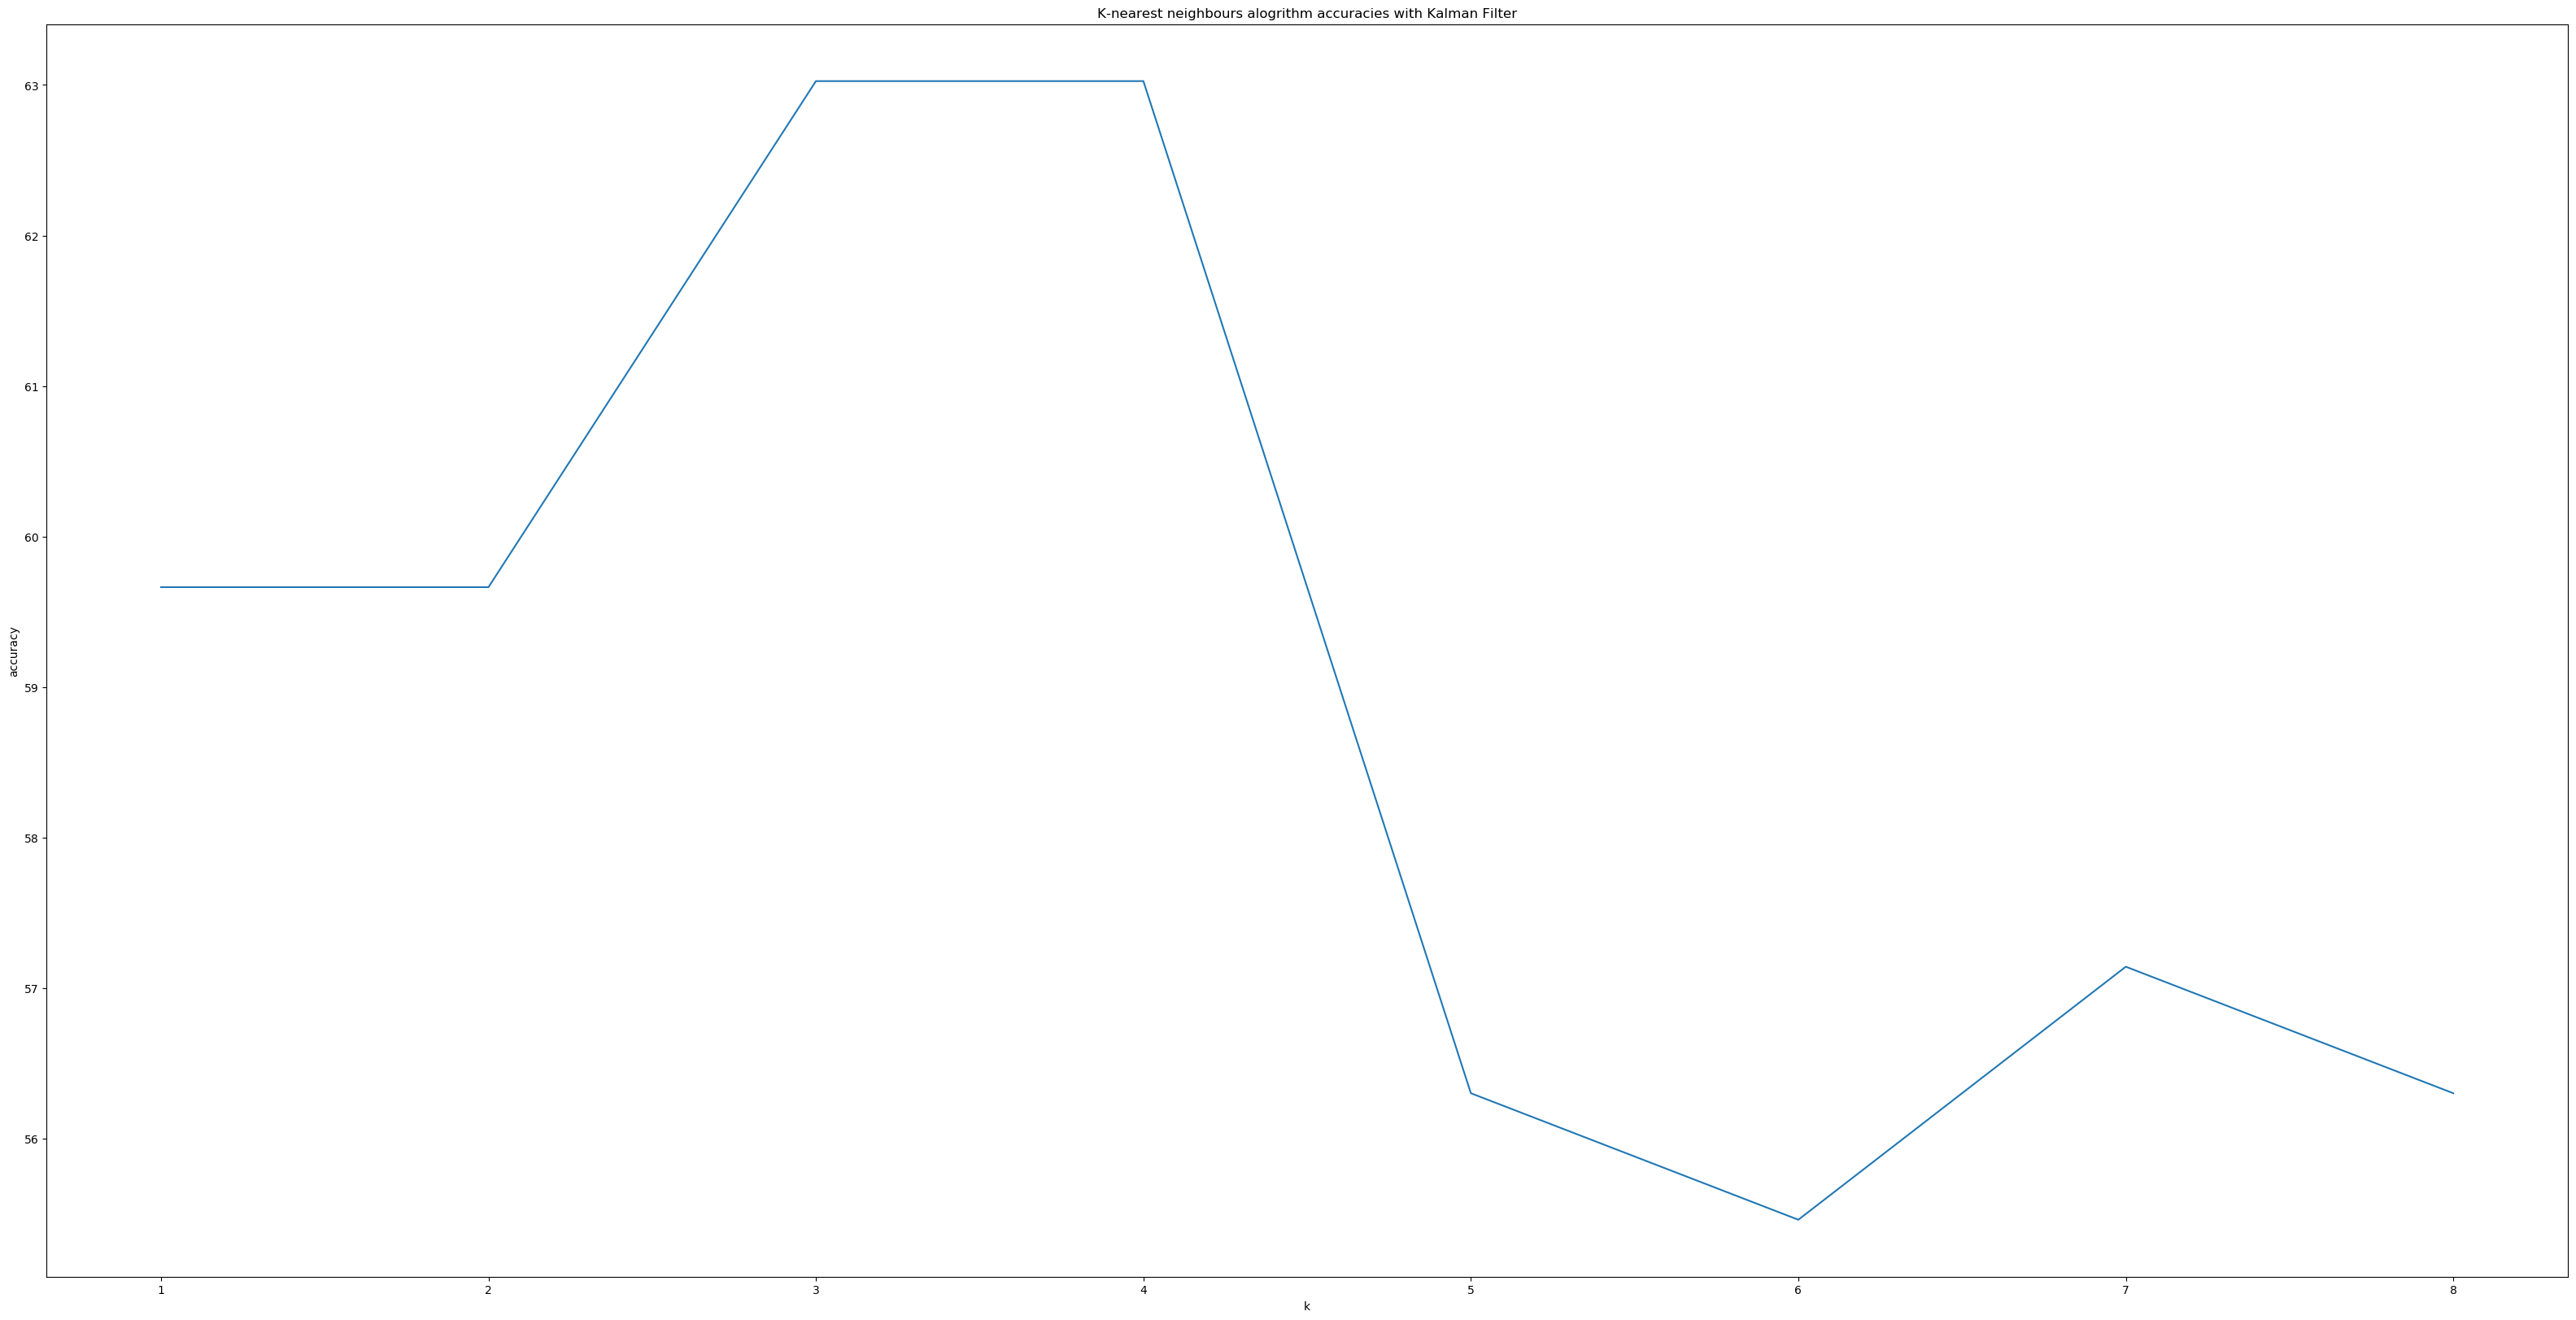

K-nearest neighbours algorithm accuracy: 63.02521008403361


In [357]:
accuracies.append(k_nearest_neighbours(kX_train, ktarget_train, kX_validation, ktarget_validation, "Kalman Filter"))

#### K-NN with the Alpha-Beta-Gamma Filter Preprocessing

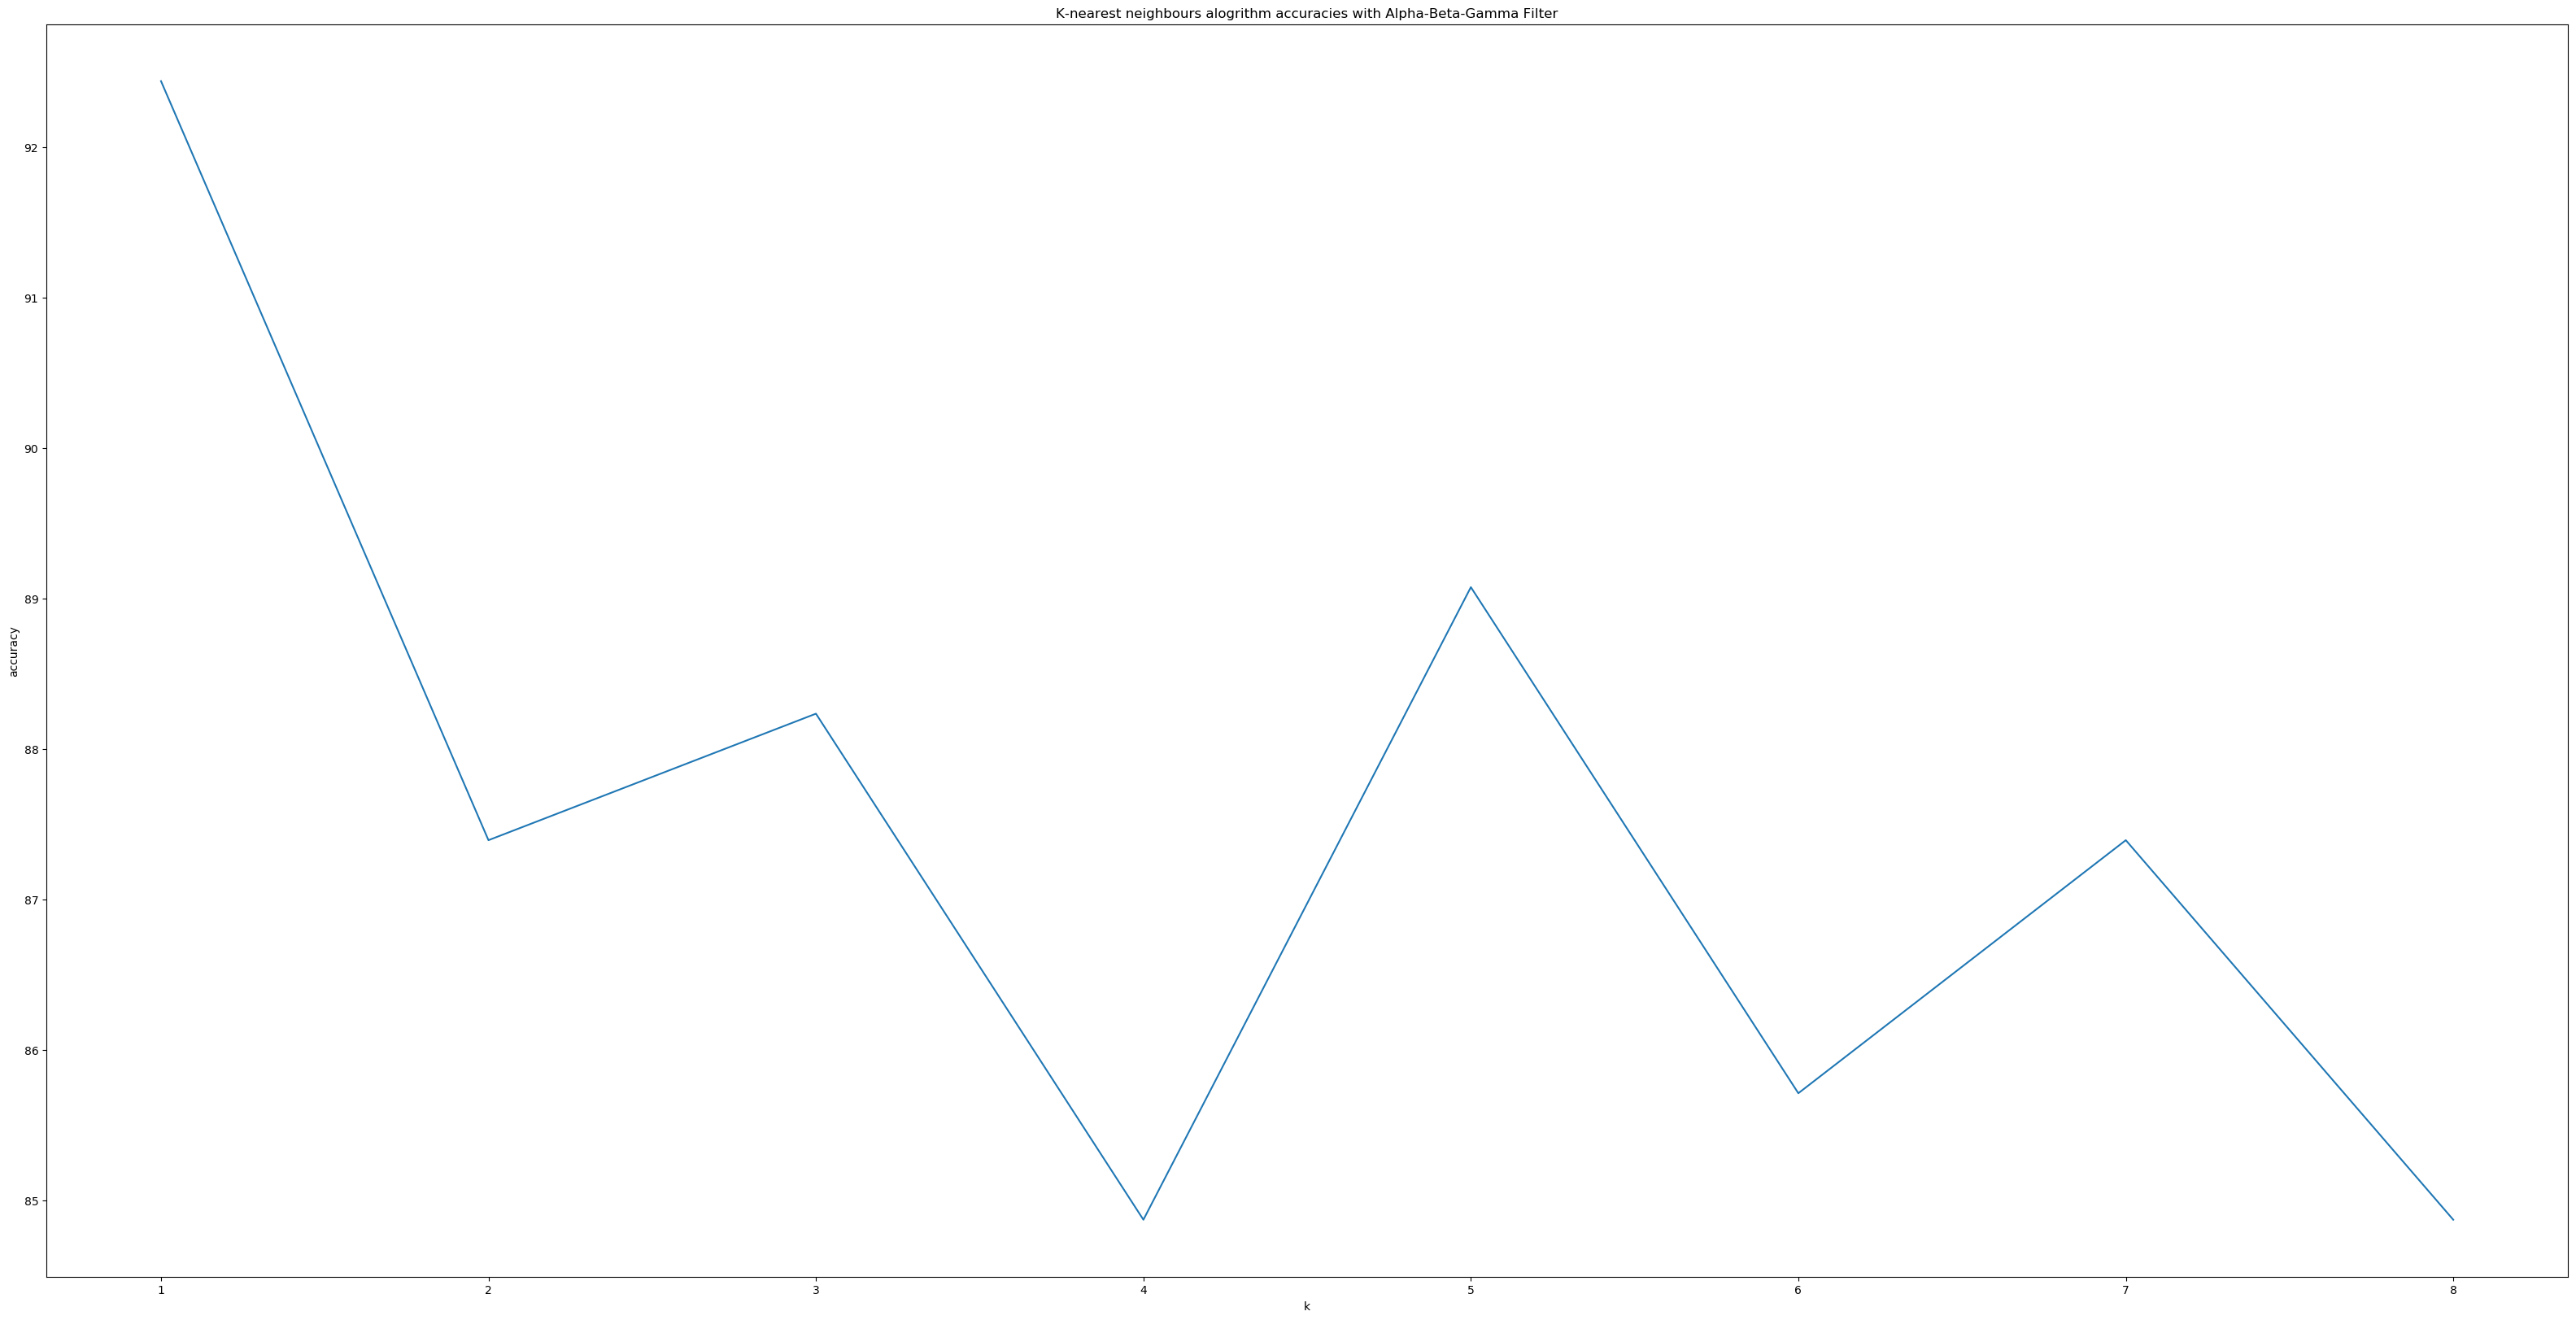

K-nearest neighbours algorithm accuracy: 92.43697478991596


In [358]:
accuracies.append(k_nearest_neighbours(aX_train, atarget_train, aX_validation, atarget_validation, "Alpha-Beta-Gamma Filter"))

#### K-NN with the Fast Fourier Transform Filter Preprocessing

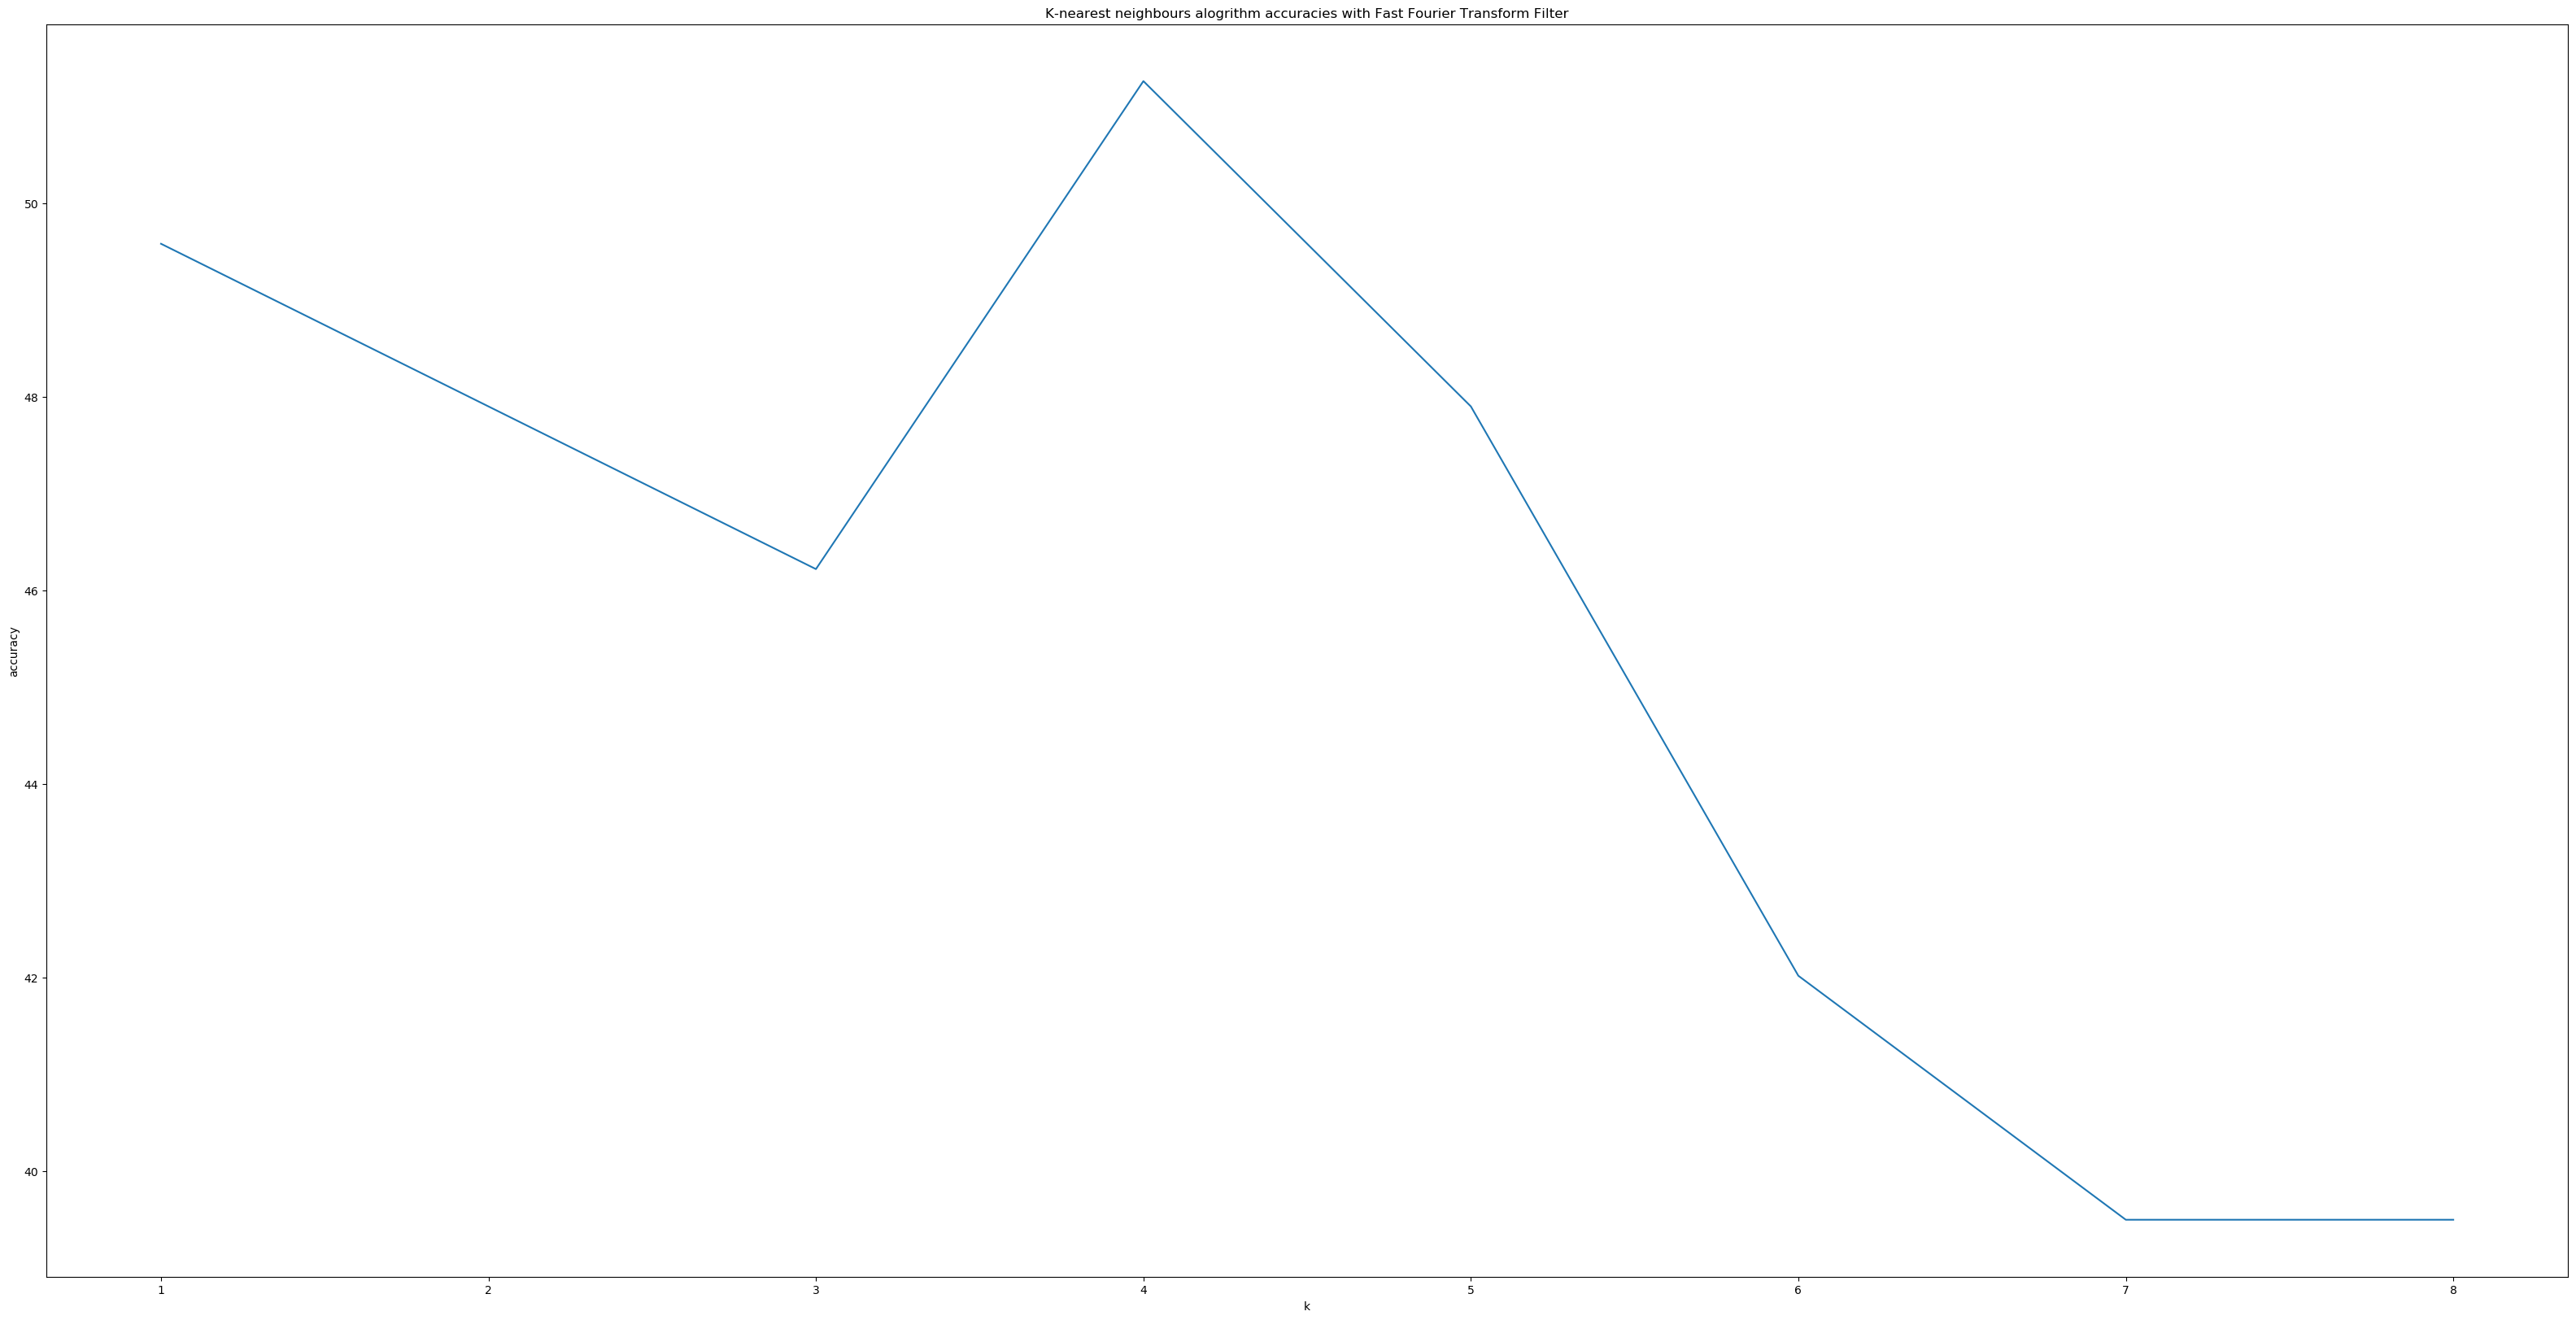

K-nearest neighbours algorithm accuracy: 51.26050420168067


In [359]:
accuracies.append(k_nearest_neighbours(fX_train, ftarget_train, fX_validation, ftarget_validation, "Fast Fourier Transform Filter"))

In [360]:
def filter_algorithm_accuracy_bardrawer(accuracies,title):
    filters = ('No filter','Kalman', 'Alpha-Beta-Gamma', 'Fast Fourier Transform')
    y_pos = np.arange(len(filters))
    print(accuracies)
    plt.bar(y_pos, accuracies,0.3, color="deeppink" ,align='center', alpha=1)
    plt.xticks(y_pos, filters)
    plt.xlabel('Filter Name')
    plt.ylabel('Accuracy')
#     plt.rcParams['figure.figsize'] = [10, 10]
    plt.title(title)

    plt.show()

#### Summary

[39.49579831932773, 63.02521008403361, 92.43697478991596, 51.26050420168067]


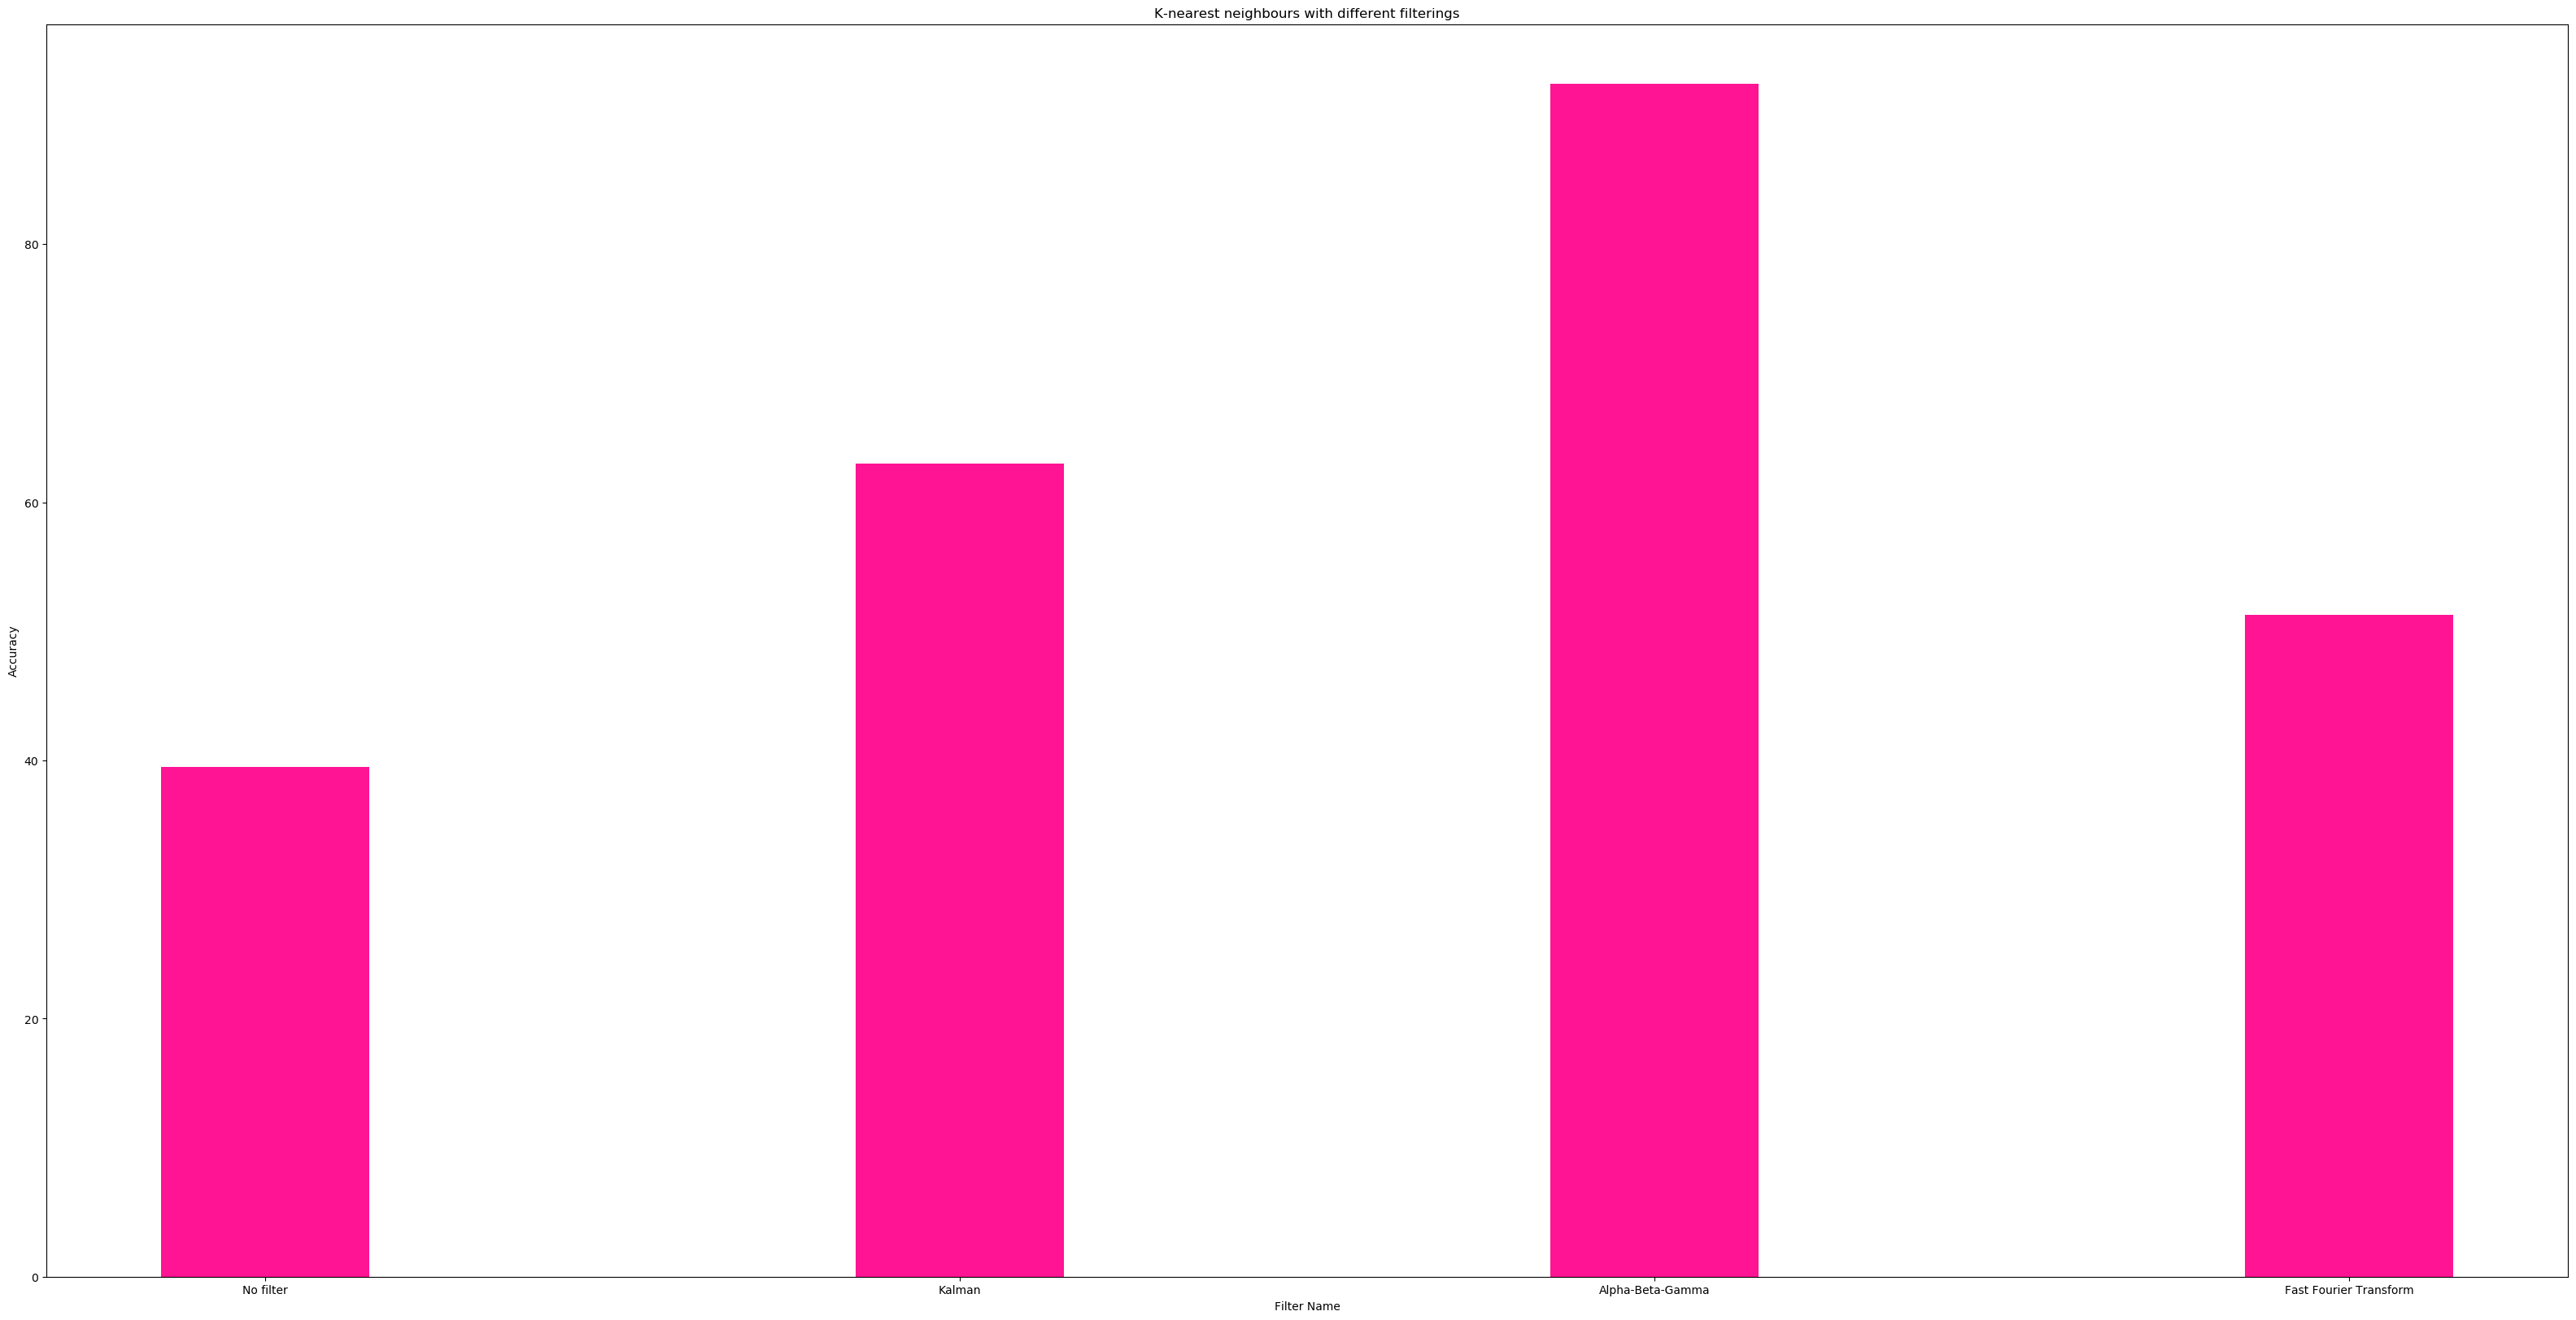

In [361]:
filter_algorithm_accuracy_bardrawer(accuracies, "K-nearest neighbours with different filterings")

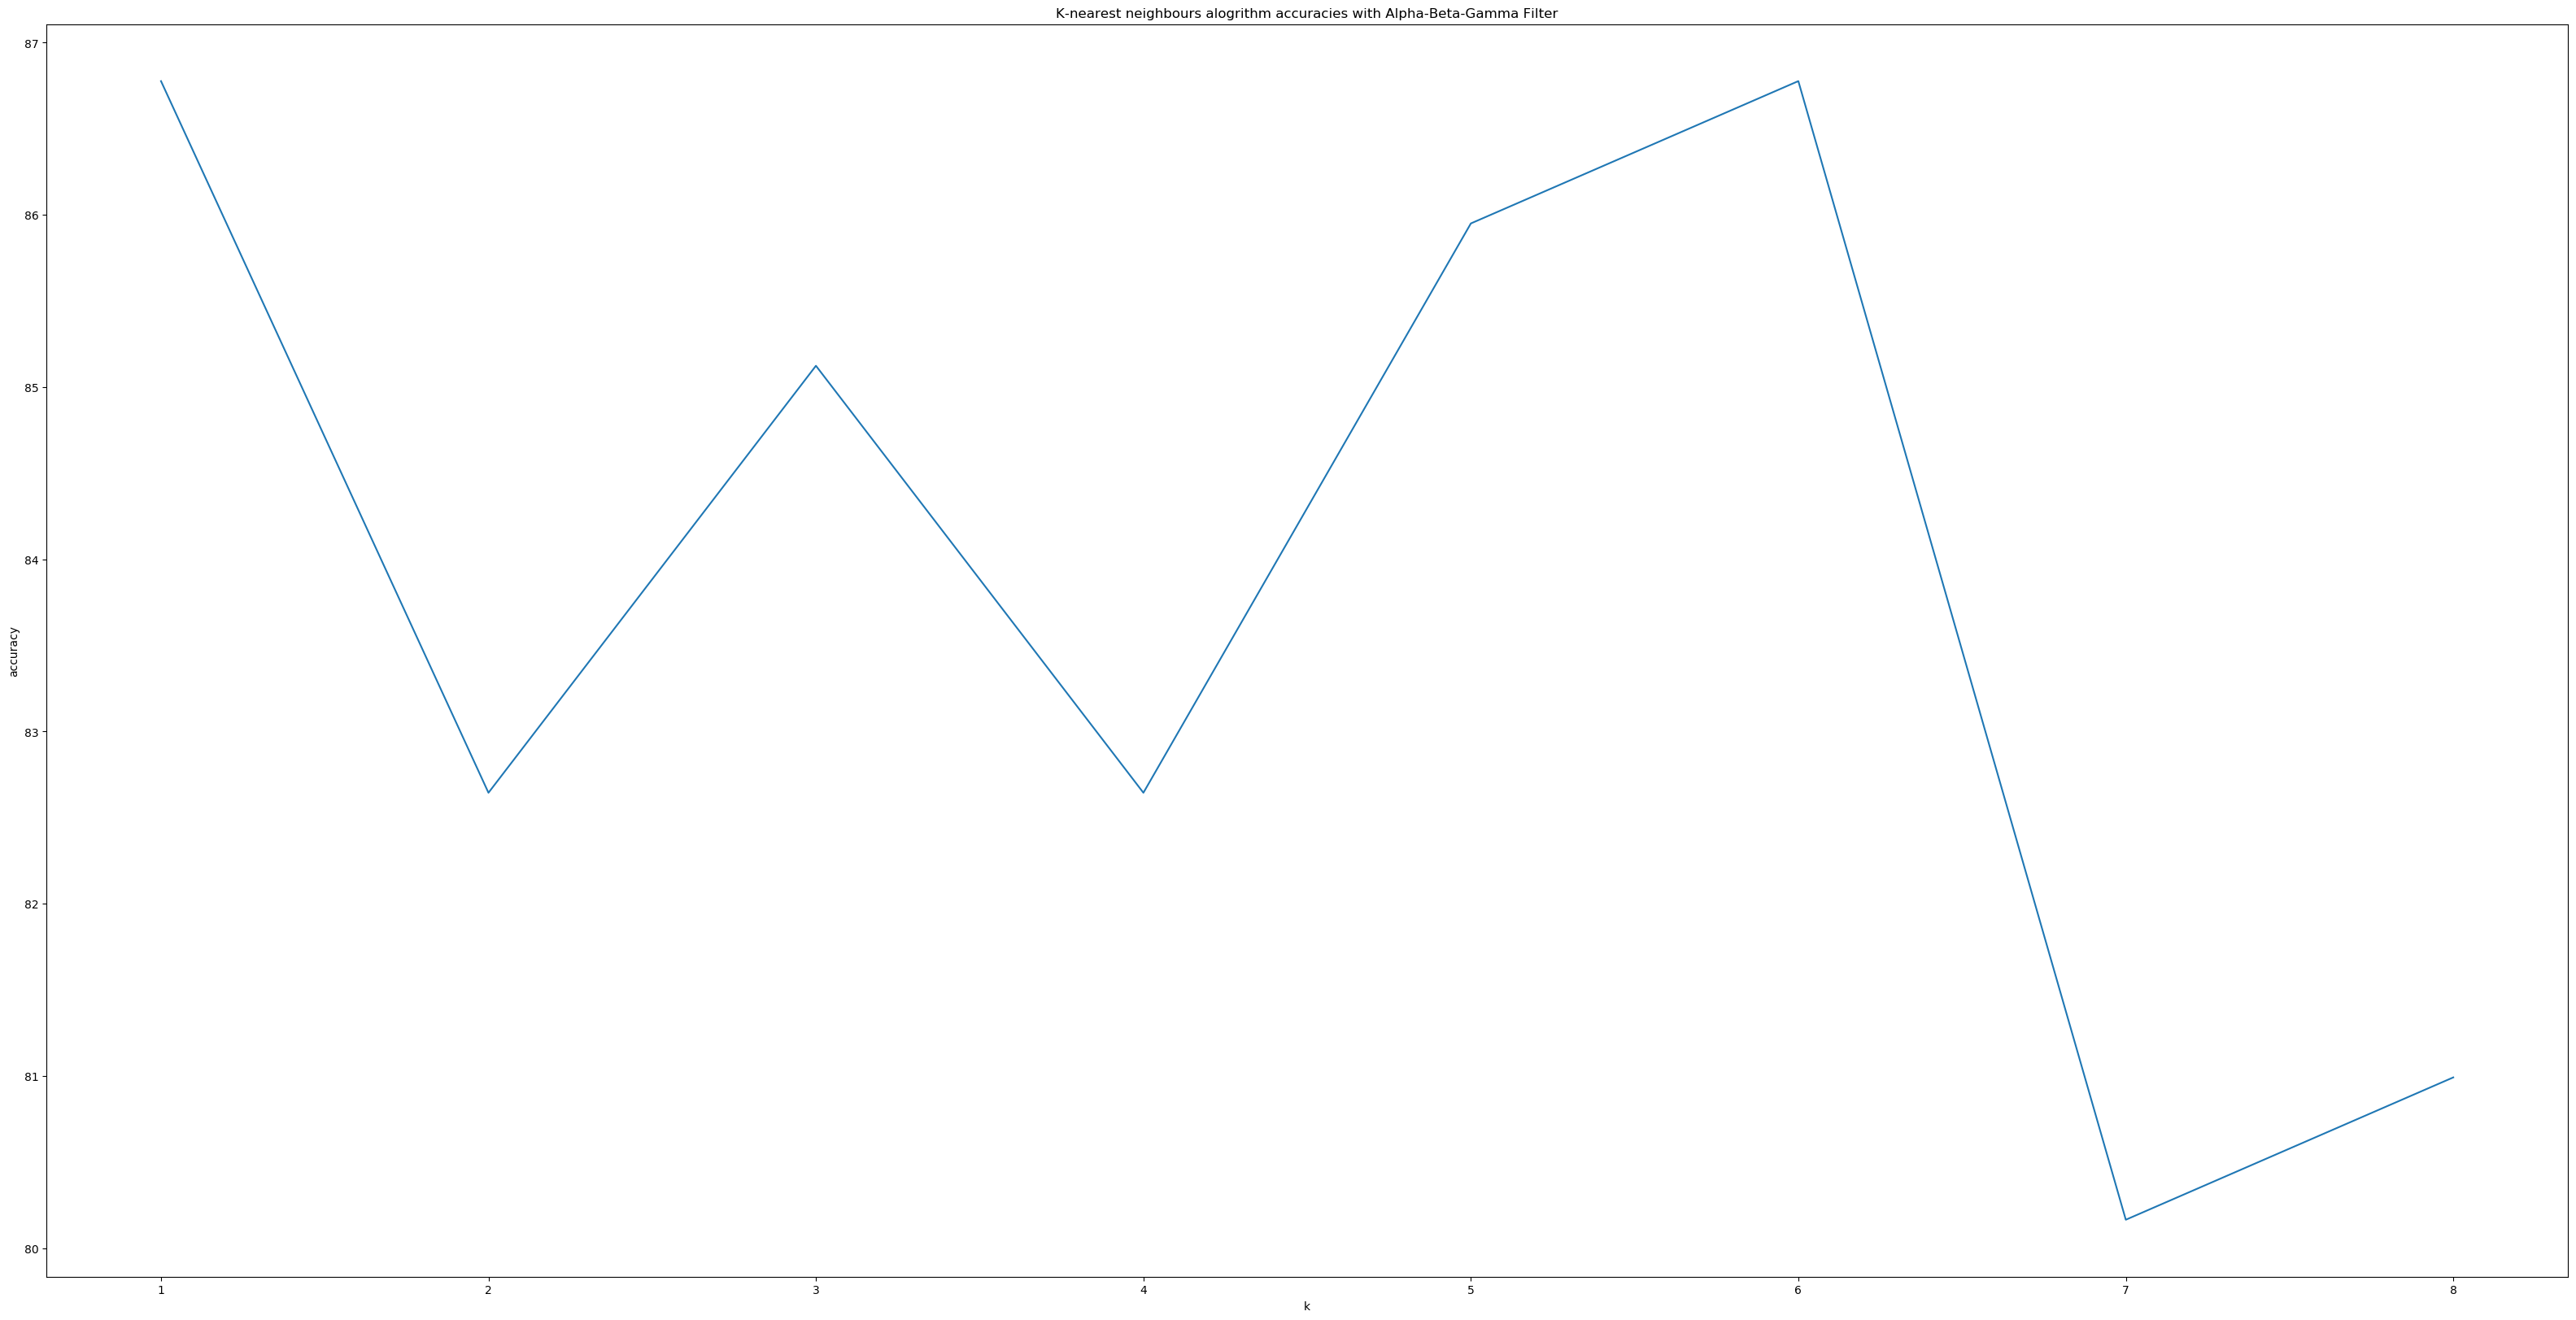

K-nearest neighbours algorithm accuracy: 86.77685950413223


86.77685950413223

In [362]:
k_nearest_neighbours(aX_train, atarget_train, aX_test, atarget_test, "Alpha-Beta-Gamma Filter")

In [363]:
prediction, run_time = run_knn(aX_train, atarget_train, aX_test, atarget_test, 1)
print(classification_report(atarget_test,prediction))
print("K nearest neighbours algorithm predication time: "+ str(run_time))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.75      1.00      0.86         3
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           7       0.00      0.00      0.00         1
           8       0.50      1.00      0.67         1
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         0
          11       1.00      0.75      0.86         4
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      0.67      0.80         3
          16       0.00      0.00      0.00         0
          17       0.50      1.00      0.67         1
          19       1.00    

## Decision Tree

In [364]:
grid_dt_parameters = {'criterion': ["gini", "entropy", "log_loss"], 'splitter': ["best", "random"],'max_depth': [3, 5, 8, 10, 15,20]}
grid_dt = GridSearchCV(tree.DecisionTreeClassifier(),grid_dt_parameters,refit=True,verbose=2)
print(grid_dt.fit(aX_train, atarget_train))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .........criterion=gini, max_depth=3, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=3, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=3, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=3, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=3, splitter=best; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, splitter=random; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, splitter=random; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, splitter=random; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, splitter=random; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, splitter=random; total time=   0.0s
[CV] END .........criterion=gini, max_depth=5, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=5, 

[CV] END ...criterion=entropy, max_depth=15, splitter=random; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, splitter=random; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, splitter=random; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, splitter=random; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=20, splitter=best; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=20, splitter=best; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=20, splitter=best; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=20, splitter=best; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=20, splitter=best; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=20, splitter=random; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=20, splitter=random; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=20, splitter=random; total time=   0.0s
[CV] END ...criterion=entrop

In [365]:
grid_dt.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [366]:
start_time = time.time()
grid_dt_predictions = grid_dt.predict(aX_test)
runtime = round(time.time() - start_time,4)
print("Decision tree algorithm prediction time: "+ str(runtime))
print(classification_report(atarget_test,grid_dt_predictions))

Decision tree algorithm prediction time: 0.0026
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.33      0.50         3
           2       0.80      1.00      0.89         4
           3       1.00      0.50      0.67         2
           4       0.67      1.00      0.80         2
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          11       1.00      0.75      0.86         4
          12       1.00      1.00      1.00         4
          13       0.50      1.00      0.67         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         1
          18       0.00      0.00      0.00         0
          19       0.00      0.00

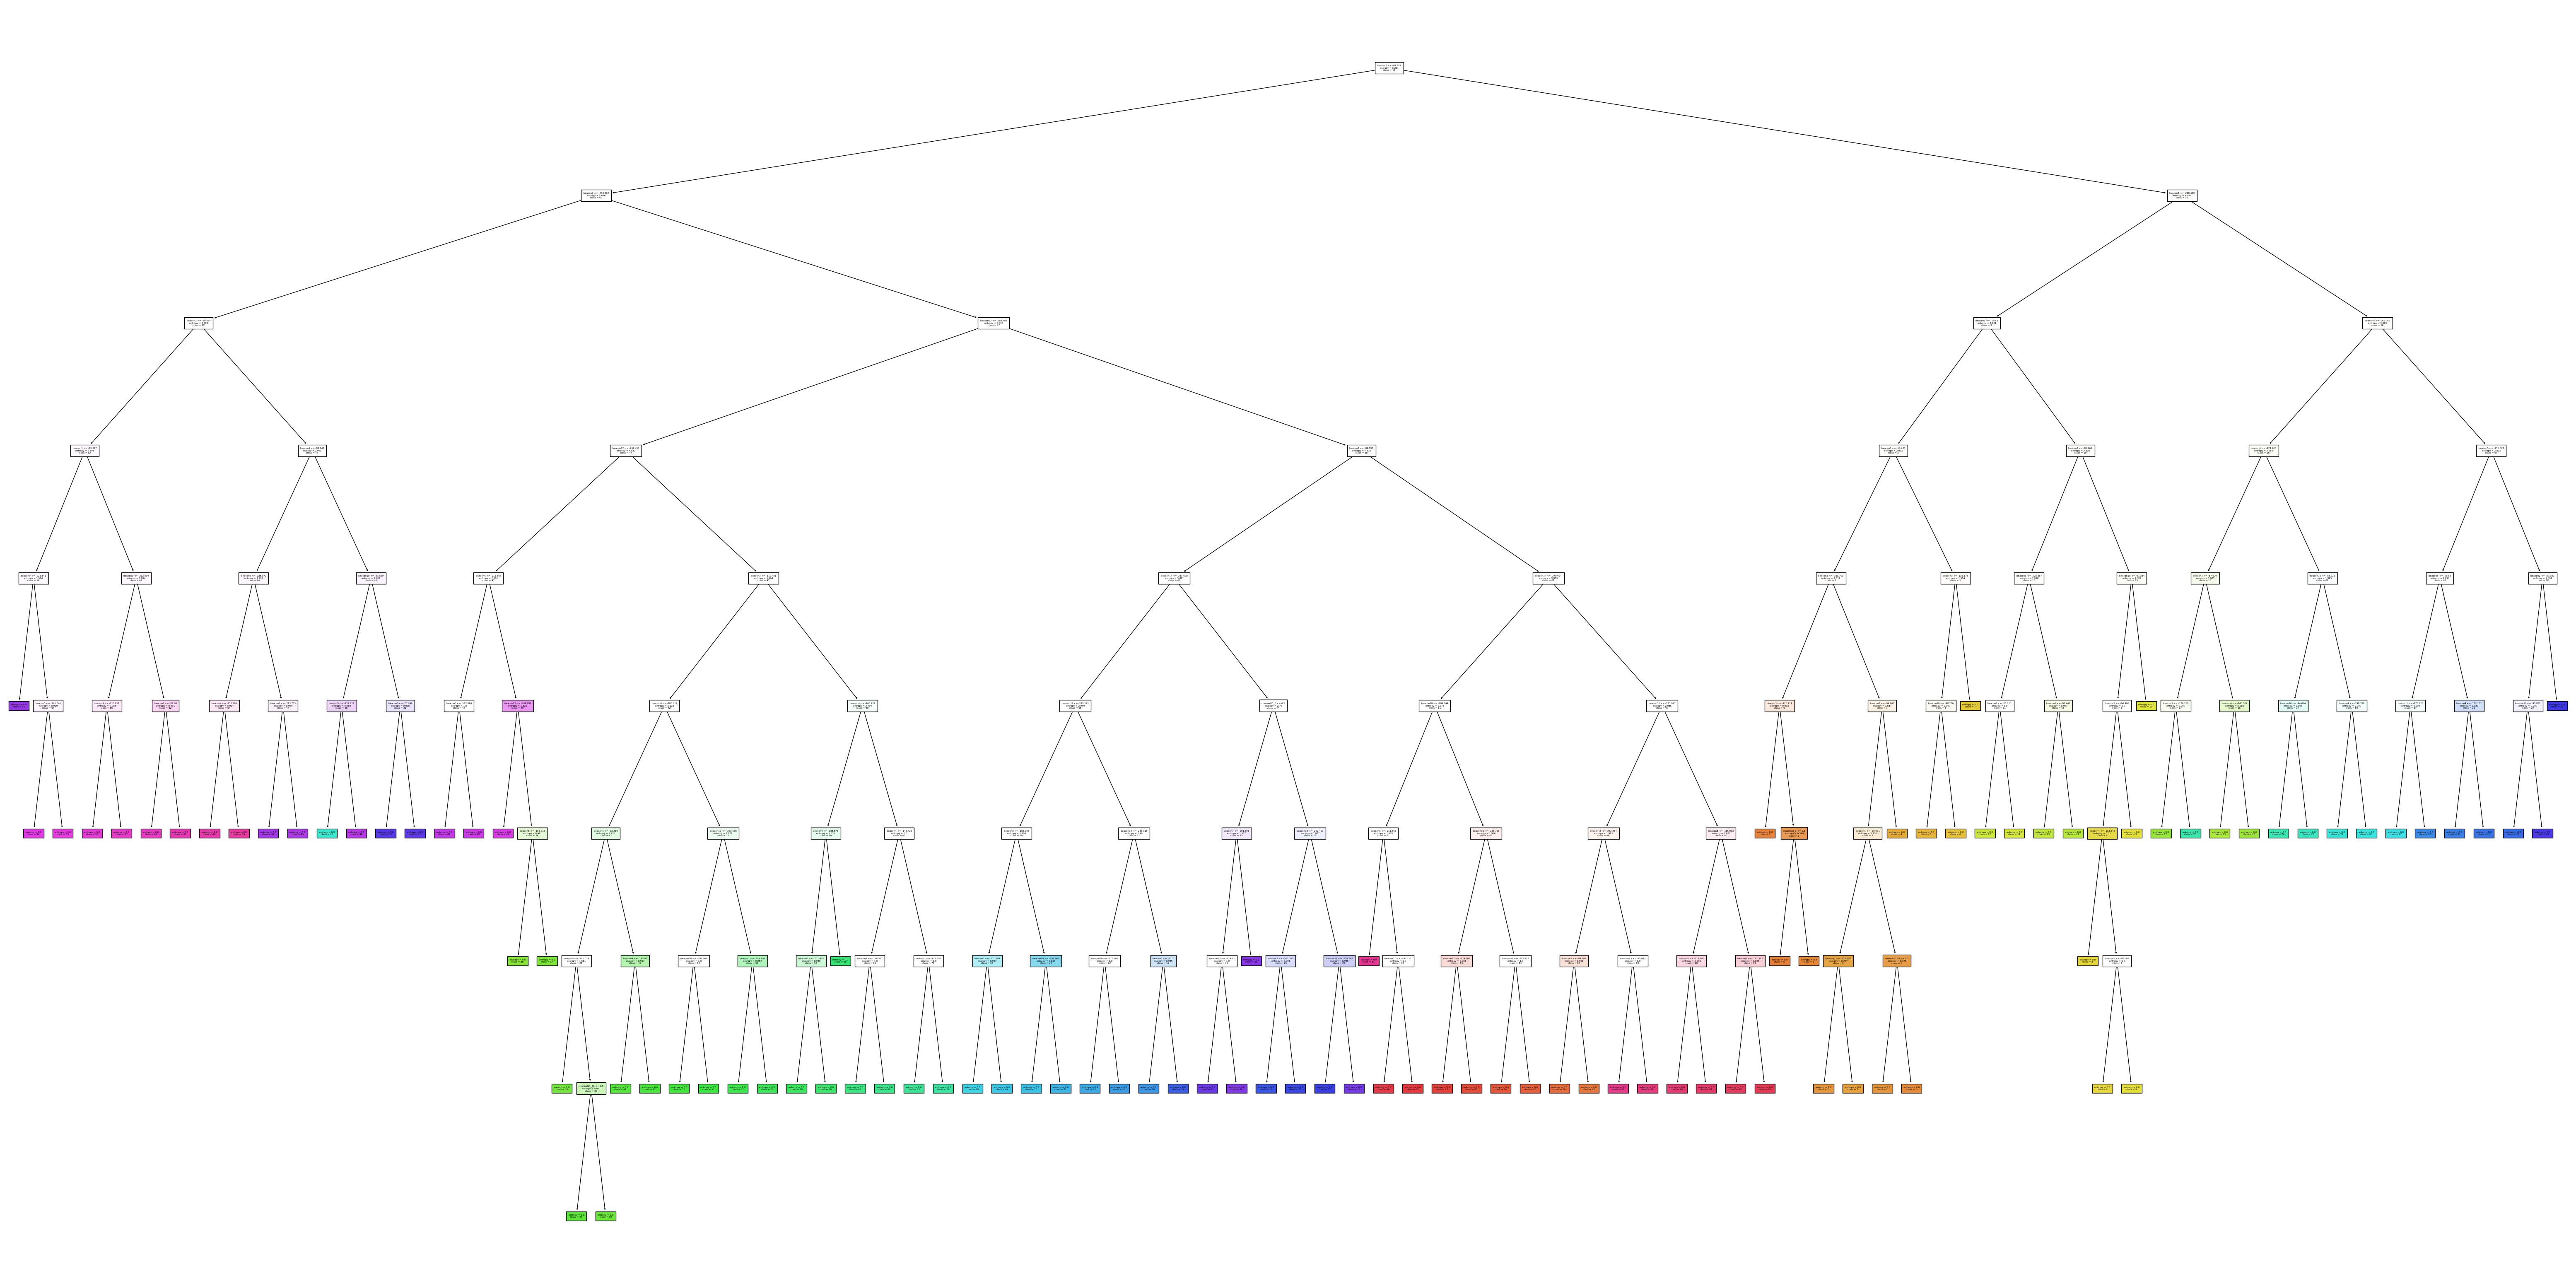

<Figure size 4000x2000 with 0 Axes>

In [367]:
fig, ax = plt.subplots(figsize=(80,40))
dfig = plt.figure()
tree.plot_tree(grid_dt.best_estimator_, 
                   feature_names=list(aX_test.columns),  
                   class_names= [str(i) for i in list(fingerprints_df.location.unique())],
                   filled=True, fontsize= 4, ax = ax)

def replace_text(obj):
    if type(obj) == mpl.text.Annotation:
        txt = obj.get_text()
        txt = re.sub("\nsamples[^$]*class","\nclass",txt)
        obj.set_text(txt)
    return obj
    
ax.properties()['children'] = [replace_text(i) for i in ax.properties()['children']]
fig.savefig('plot.png', dpi=300, bbox_inches='tight')
fig.show() 


## Random Forest

In [368]:
rfc = RandomForestClassifier()
forest_params = [{'criterion': ["gini", "entropy", "log_loss"], 'max_depth':[5,8,10,12,15], 'max_features': [10,15,20,25,30,35,40]}]
clf = GridSearchCV(rfc, forest_params, cv = 5, scoring='accuracy',refit=True,verbose=2)
print(clf.fit(aX_train, atarget_train))

Fitting 5 folds for each of 105 candidates, totalling 525 fits
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=20; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, m

[CV] END ......criterion=gini, max_depth=10, max_features=40; total time=   0.5s
[CV] END ......criterion=gini, max_depth=10, max_features=40; total time=   0.5s
[CV] END ......criterion=gini, max_depth=10, max_features=40; total time=   0.5s
[CV] END ......criterion=gini, max_depth=10, max_features=40; total time=   0.5s
[CV] END ......criterion=gini, max_depth=12, max_features=10; total time=   0.2s
[CV] END ......criterion=gini, max_depth=12, max_features=10; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=10; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=10; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=10; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=15; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=15; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=15; total time=   0.3s
[CV] END ......criterion=gin

[CV] END ....criterion=entropy, max_depth=5, max_features=35; total time=   0.6s
[CV] END ....criterion=entropy, max_depth=5, max_features=35; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=5, max_features=40; total time=   0.9s
[CV] END ....criterion=entropy, max_depth=5, max_features=40; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=5, max_features=40; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=5, max_features=40; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=5, max_features=40; total time=   0.8s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.4s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.4s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.4s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.4s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.3s
[CV] END ....criterion=entro

[CV] END ...criterion=entropy, max_depth=12, max_features=35; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=35; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=35; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=35; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=35; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=40; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=40; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=40; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=40; total time=   0.8s
[CV] END ...criterion=entropy, max_depth=12, max_features=40; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.3s
[CV] END ...criterion=entrop

[CV] END ...criterion=log_loss, max_depth=8, max_features=35; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=35; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=35; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=40; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=40; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=40; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=40; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=40; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=10, max_features=10; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=10, max_features=10; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=10, max_features=10; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=10, max_features=10; total time=   0.0s
[CV] END ..criterion=log_los

[CV] END ..criterion=log_loss, max_depth=15, max_features=40; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=40; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=40; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=40; total time=   0.0s
GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': [5, 8, 10, 12, 15],
                          'max_features': [10, 15, 20, 25, 30, 35, 40]}],
             scoring='accuracy', verbose=2)


In [369]:
clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=12, max_features=30)

In [370]:
start_time = time.time()
grid_rforest_predictions = clf.predict(aX_test)
runtime = round(time.time() - start_time,4)
print("Random Forest algorithm prediction time: "+ str(runtime))
print(classification_report(atarget_test,grid_rforest_predictions))

Random Forest algorithm prediction time: 0.0184
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      0.75      0.86         4
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         0
          11       1.00      0.75      0.86         4
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         1
          18       0.00      0.00

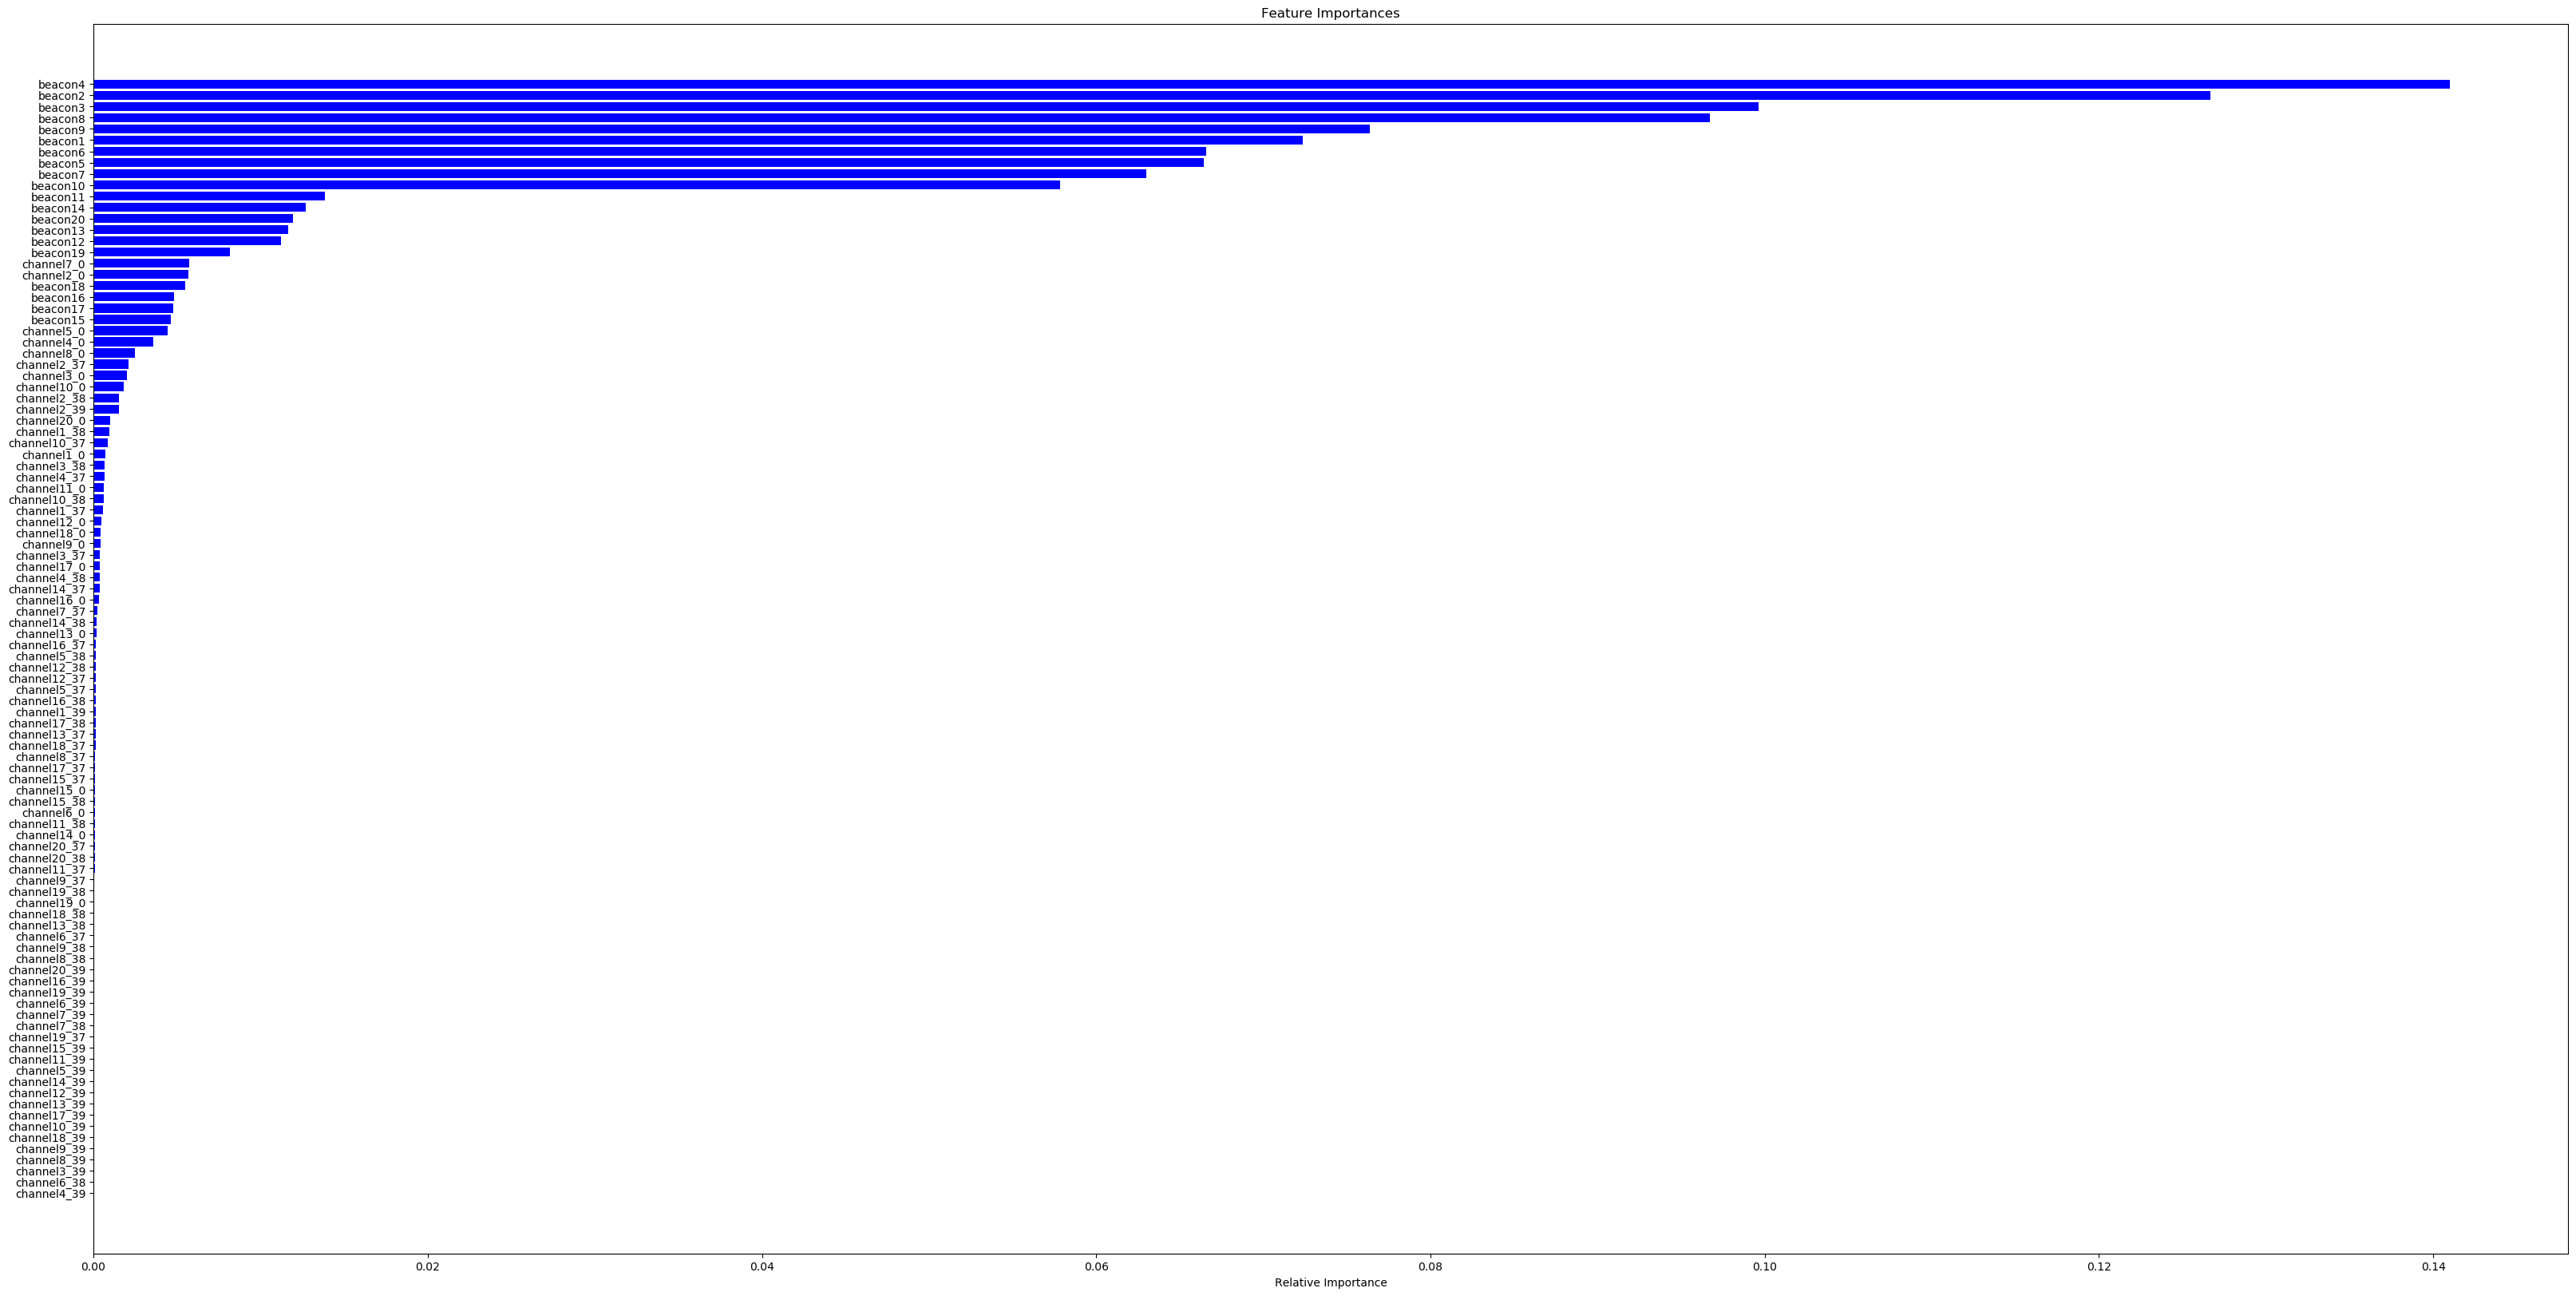

In [371]:
features = aX_train.columns
importances = clf.best_estimator_.feature_importances_
indices = np.argsort(importances) 
indices
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [372]:
indices = np.flip(indices, axis=None)

In [373]:
selected_col_count = 40
counter = 0
selected_columns = []
for ind in indices:
    if counter< selected_col_count:
        selected_columns.append(features[ind])
        counter+= 1
    else:
        break
selected_columns

['beacon4',
 'beacon2',
 'beacon3',
 'beacon8',
 'beacon9',
 'beacon1',
 'beacon6',
 'beacon5',
 'beacon7',
 'beacon10',
 'beacon11',
 'beacon14',
 'beacon20',
 'beacon13',
 'beacon12',
 'beacon19',
 'channel7_0',
 'channel2_0',
 'beacon18',
 'beacon16',
 'beacon17',
 'beacon15',
 'channel5_0',
 'channel4_0',
 'channel8_0',
 'channel2_37',
 'channel3_0',
 'channel10_0',
 'channel2_38',
 'channel2_39',
 'channel20_0',
 'channel1_38',
 'channel10_37',
 'channel1_0',
 'channel3_38',
 'channel4_37',
 'channel11_0',
 'channel10_38',
 'channel1_37',
 'channel12_0']

## Support Vector Machine 

In [374]:
min_max_scaler = MinMaxScaler()
scaled_aXtrain = aX_train.copy()
scaled_aXtrain[:] = min_max_scaler.fit_transform(scaled_aXtrain[:])
scaled_aXtrain

beacon1   beacon2   beacon3   beacon4   beacon5   beacon6   beacon7  \
17    0.471856  0.703556  0.676671  0.000000  0.000000  0.000000  0.000000   
1     0.819877  0.328059  0.000000  0.000000  0.000000  0.000000  0.000000   
10    0.891011  0.764821  0.491994  0.000000  0.000000  0.000000  0.000000   
4     0.940068  0.664030  0.272919  0.000000  0.000000  0.000000  0.000000   
6     0.894281  0.720025  0.479864  0.000000  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
1160  0.950802  0.015442  0.999138  0.999138  0.999138  0.999138  0.999138   
1167  0.950838  0.015564  0.999143  0.999143  0.999143  0.999143  0.999143   
1164  0.950823  0.015512  0.999141  0.999141  0.999141  0.999141  0.999141   
1168  0.950844  0.015581  0.999144  0.999144  0.999144  0.999144  0.999144   
1165  0.950828  0.015529  0.999142  0.999142  0.999142  0.999142  0.999142   

       beacon8   beacon9  beacon10  ...  channel18_38  channel18_39  \
17    0.000000  0.000000  0.841694  ...           0.0           0.0   
1     0.000000  0.000000  0.900201  ...           0.0           0.0   
10    0.000000  0.000000  0.337487  ...           0.0           0.0   
4     0.000000  0.000000  0.893614  ...           0.0           0.0   
6     0.000000  0.000000  0.000000  ...           0.0           0.0   
...        ...       ...       ...  ...           ...           ...   
1160  0.999138  0.999138  0.988873  ...           0.0           0.0   
1167  0.999143  0.999143  0.988901  ...           0.0           1.0   
1164  0.999141  0.999141  0.988889  ...           1.0           0.0   
1168  0.999144  0.999144  0.988905  ...           1.0           0.0   
1165  0.999142  0.999142  0.988893  ...           0.0           0.0   

      channel19_0  channel19_37  channel19_38  channel19_39  channel20_0  \
17            1.0           0.0           0.0           0.0          1.0   
1             1.0           0.0           0.0           0.0          1.0   
10            1.0           0.0           0.0           0.0          1.0   
4             1.0           0.0           0.0           0.0          1.0   
6             1.0           0.0           0.0           0.0          1.0   
...           ...           ...           ...           ...          ...   
1160          0.0           1.0           0.0           0.0          1.0   
1167          0.0           1.0           0.0           0.0          1.0   
1164          0.0           0.0           1.0           0.0          1.0   
1168          0.0           1.0           0.0           0.0          1.0   
1165          0.0           1.0           0.0           0.0          1.0   

      channel20_37  channel20_38  channel20_39  
17             0.0           0.0           0.0  
1              0.0           0.0           0.0  
10             0.0           0.0           0.0  
4              0.0           0.0           0.0  
6              0.0           0.0           0.0  
...            ...           ...           ...  
1160           0.0           0.0           0.0  
1167           0.0           0.0           0.0  
1164           0.0           0.0           0.0  
1168           0.0           0.0           0.0  
1165           0.0           0.0           0.0  

[959 rows x 100 columns]

In [375]:
# aX_train_feature_selected =aX_train.loc[:, selected_columns]
grid_svm_parameters = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['poly','rbf', 'sigmoid','linear']}
grid = GridSearchCV(SVC(),grid_svm_parameters,refit=True,verbose=2)
print(grid.fit(scaled_aXtrain.loc[:, selected_columns], atarget_train))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, k

[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ...................

[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ...................

[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
GridSearchCV(estimator=SVC()

In [376]:
grid.best_estimator_

SVC(C=10, gamma=1, kernel='poly')

In [377]:
scaled_aXtest = aX_test.copy()
scaled_aXtest[:] = min_max_scaler.fit_transform(scaled_aXtest[:])
start_time = time.time()
svm_grid_predictions = grid.predict(scaled_aXtest.loc[:, selected_columns])
runtime = round(time.time() - start_time,4)
print("Support Vector Machine algorithm prediction time: "+ str(runtime))
print(classification_report(atarget_test,svm_grid_predictions))

Support Vector Machine algorithm prediction time: 0.0167
              precision    recall  f1-score   support

           0       0.18      1.00      0.31         2
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.43      0.75      0.55         4
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         1
          14       0.33      0.33      0.33         3
          15       1.00      0.33      0.50         3
          17       0.50 

In [378]:
fingerprints_df2 = fingerprints_df_from_file.iloc[: , 2:]
for col in channel_cols:
    fingerprints_df2[col] = fingerprints_df2[col].map(str)
alpha_filtered3 = apply_filter_to_whole(fingerprints_df2, "alpha_beta_gamma","alpha_3.csv")
ashuf2, atrain2, avalidation2, atest2, aX_train2, atarget_train2, aX_validation2, atarget_validation2, aX_test2, atarget_test2 = split_train_validation_test(alpha_filtered3, 0.8,0.1)
grid = GridSearchCV(SVC(),grid_svm_parameters,refit=True,verbose=2)
print(grid.fit(aX_train2, atarget_train2))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, k

[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ...................

[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ...................

[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C

In [379]:
grid.best_estimator_

SVC(C=0.1, gamma=0.001, kernel='poly')

In [380]:
start_time = time.time()
svm_grid_predictions2 = grid.predict(aX_test2)
runtime = round(time.time() - start_time,4)
print("Support Vector Machine algorithm prediction time: "+ str(runtime))
print(classification_report(atarget_test2,svm_grid_predictions2))

Support Vector Machine algorithm prediction time: 0.0116
              precision    recall  f1-score   support

          b1       1.00      1.00      1.00         2
          b2       1.00      1.00      1.00         3
          b3       0.80      1.00      0.89         4
          b4       0.00      0.00      0.00         2
          b5       0.67      1.00      0.80         2
          b6       1.00      1.00      1.00         1
          b8       1.00      1.00      1.00         1
          b9       1.00      1.00      1.00         1
         be1       1.00      1.00      1.00         1
         be2       0.00      0.00      0.00         0
         be3       0.75      0.75      0.75         4
         be4       1.00      0.75      0.86         4
         be5       1.00      1.00      1.00         1
         be6       0.75      1.00      0.86         3
         be7       1.00      0.33      0.50         3
         be8       0.00      0.00      0.00         0
         be9       1.00 

## Artificial Neural Network

In [381]:
ann_model = keras.Sequential()
ann_model.add(keras.layers.InputLayer(input_shape = (100,)))
ann_model.add(keras.layers.Dense(120, activation ='elu'))
ann_model.add(keras.layers.Dropout(0.3))
ann_model.add(keras.layers.Dense(100, activation ='elu'))
ann_model.add(keras.layers.Dropout(0.3))
ann_model.add(keras.layers.Dense(96))
ann_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_127 (Dense)            (None, 120)               12120     
_________________________________________________________________
dropout_15 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_128 (Dense)            (None, 100)               12100     
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_129 (Dense)            (None, 96)                9696      
Total params: 33,916
Trainable params: 33,916
Non-trainable params: 0
_________________________________________________________________


In [382]:
ann_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])

In [383]:
one_hot_channel_cols = [col for col in fingerprints_df.columns if col not in no_channel_training_cols+['location']]
scaled_aXtrain_np = scaled_aXtrain.copy()
#scaled_aXtrain_np.loc[:, one_hot_channel_cols] = scaled_aXtrain_np.loc[:, one_hot_channel_cols].replace(0.0, -1)
#scaled_aXtrain_np = scaled_aXtrain_np.loc[:, selected_columns]
scaled_aXtrain_np = scaled_aXtrain_np.to_numpy()
scaled_aXtest_np = scaled_aXtest.copy()
#scaled_aXtest_np.loc[:, one_hot_channel_cols] = scaled_aXtest_np.loc[:, one_hot_channel_cols].replace(0, -1)
#scaled_aXtest_np = scaled_aXtest_np.loc[:, selected_columns]
scaled_aXtest_np = scaled_aXtest_np.to_numpy()
encoded_train_labels = atarget_train.to_numpy()
encoded_test_labels = atarget_test.to_numpy()

In [384]:
history = ann_model.fit(scaled_aXtrain_np, encoded_train_labels , epochs=100)

Epoch 1/100
959/959 [==============================] - 1s 932us/step - loss: 4.4163 - accuracy: 0.0198
Epoch 2/100
959/959 [==============================] - 0s 168us/step - loss: 3.8857 - accuracy: 0.0553
Epoch 3/100
959/959 [==============================] - 0s 170us/step - loss: 3.4795 - accuracy: 0.0855
Epoch 4/100
959/959 [==============================] - 0s 175us/step - loss: 3.2290 - accuracy: 0.1251
Epoch 5/100
959/959 [==============================] - 0s 173us/step - loss: 3.0926 - accuracy: 0.1481
Epoch 6/100
959/959 [==============================] - 0s 174us/step - loss: 2.9029 - accuracy: 0.1919
Epoch 7/100
959/959 [==============================] - 0s 180us/step - loss: 2.7507 - accuracy: 0.2086
Epoch 8/100
959/959 [==============================] - 0s 180us/step - loss: 2.6090 - accuracy: 0.2398
Epoch 9/100
959/959 [==============================] - 0s 179us/step - loss: 2.5244 - accuracy: 0.2409
Epoch 10/100
959/959 [==============================] - 0s 179us/step - l

959/959 [==============================] - 0s 187us/step - loss: 0.9754 - accuracy: 0.6674
Epoch 80/100
959/959 [==============================] - 0s 187us/step - loss: 0.9321 - accuracy: 0.6705
Epoch 81/100
959/959 [==============================] - 0s 186us/step - loss: 0.9361 - accuracy: 0.6569
Epoch 82/100
959/959 [==============================] - 0s 187us/step - loss: 0.9598 - accuracy: 0.6507
Epoch 83/100
959/959 [==============================] - 0s 187us/step - loss: 0.9267 - accuracy: 0.6548
Epoch 84/100
959/959 [==============================] - 0s 187us/step - loss: 0.8979 - accuracy: 0.6809
Epoch 85/100
959/959 [==============================] - 0s 187us/step - loss: 0.9243 - accuracy: 0.6632
Epoch 86/100
959/959 [==============================] - 0s 187us/step - loss: 0.9402 - accuracy: 0.6632
Epoch 87/100
959/959 [==============================] - 0s 190us/step - loss: 0.8940 - accuracy: 0.6747
Epoch 88/100
959/959 [==============================] - 0s 188us/step - loss:

In [385]:
start_time = time.time()
test_loss, test_acc = ann_model.evaluate(scaled_aXtest_np,  encoded_test_labels, verbose=2)
runtime = round(time.time() - start_time,4)
print("Neural Network algorithm prediction time: "+ str(runtime))
test_acc

Neural Network algorithm prediction time: 0.2641


0.4628099203109741

In [386]:
def plot_loss_acc_rate(history):    
#     plt.plot(history.history['val_loss'])
#     plt.title('Model \'s loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.show()
#     plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['accuracy'])
    plt.title('Model \'s accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()

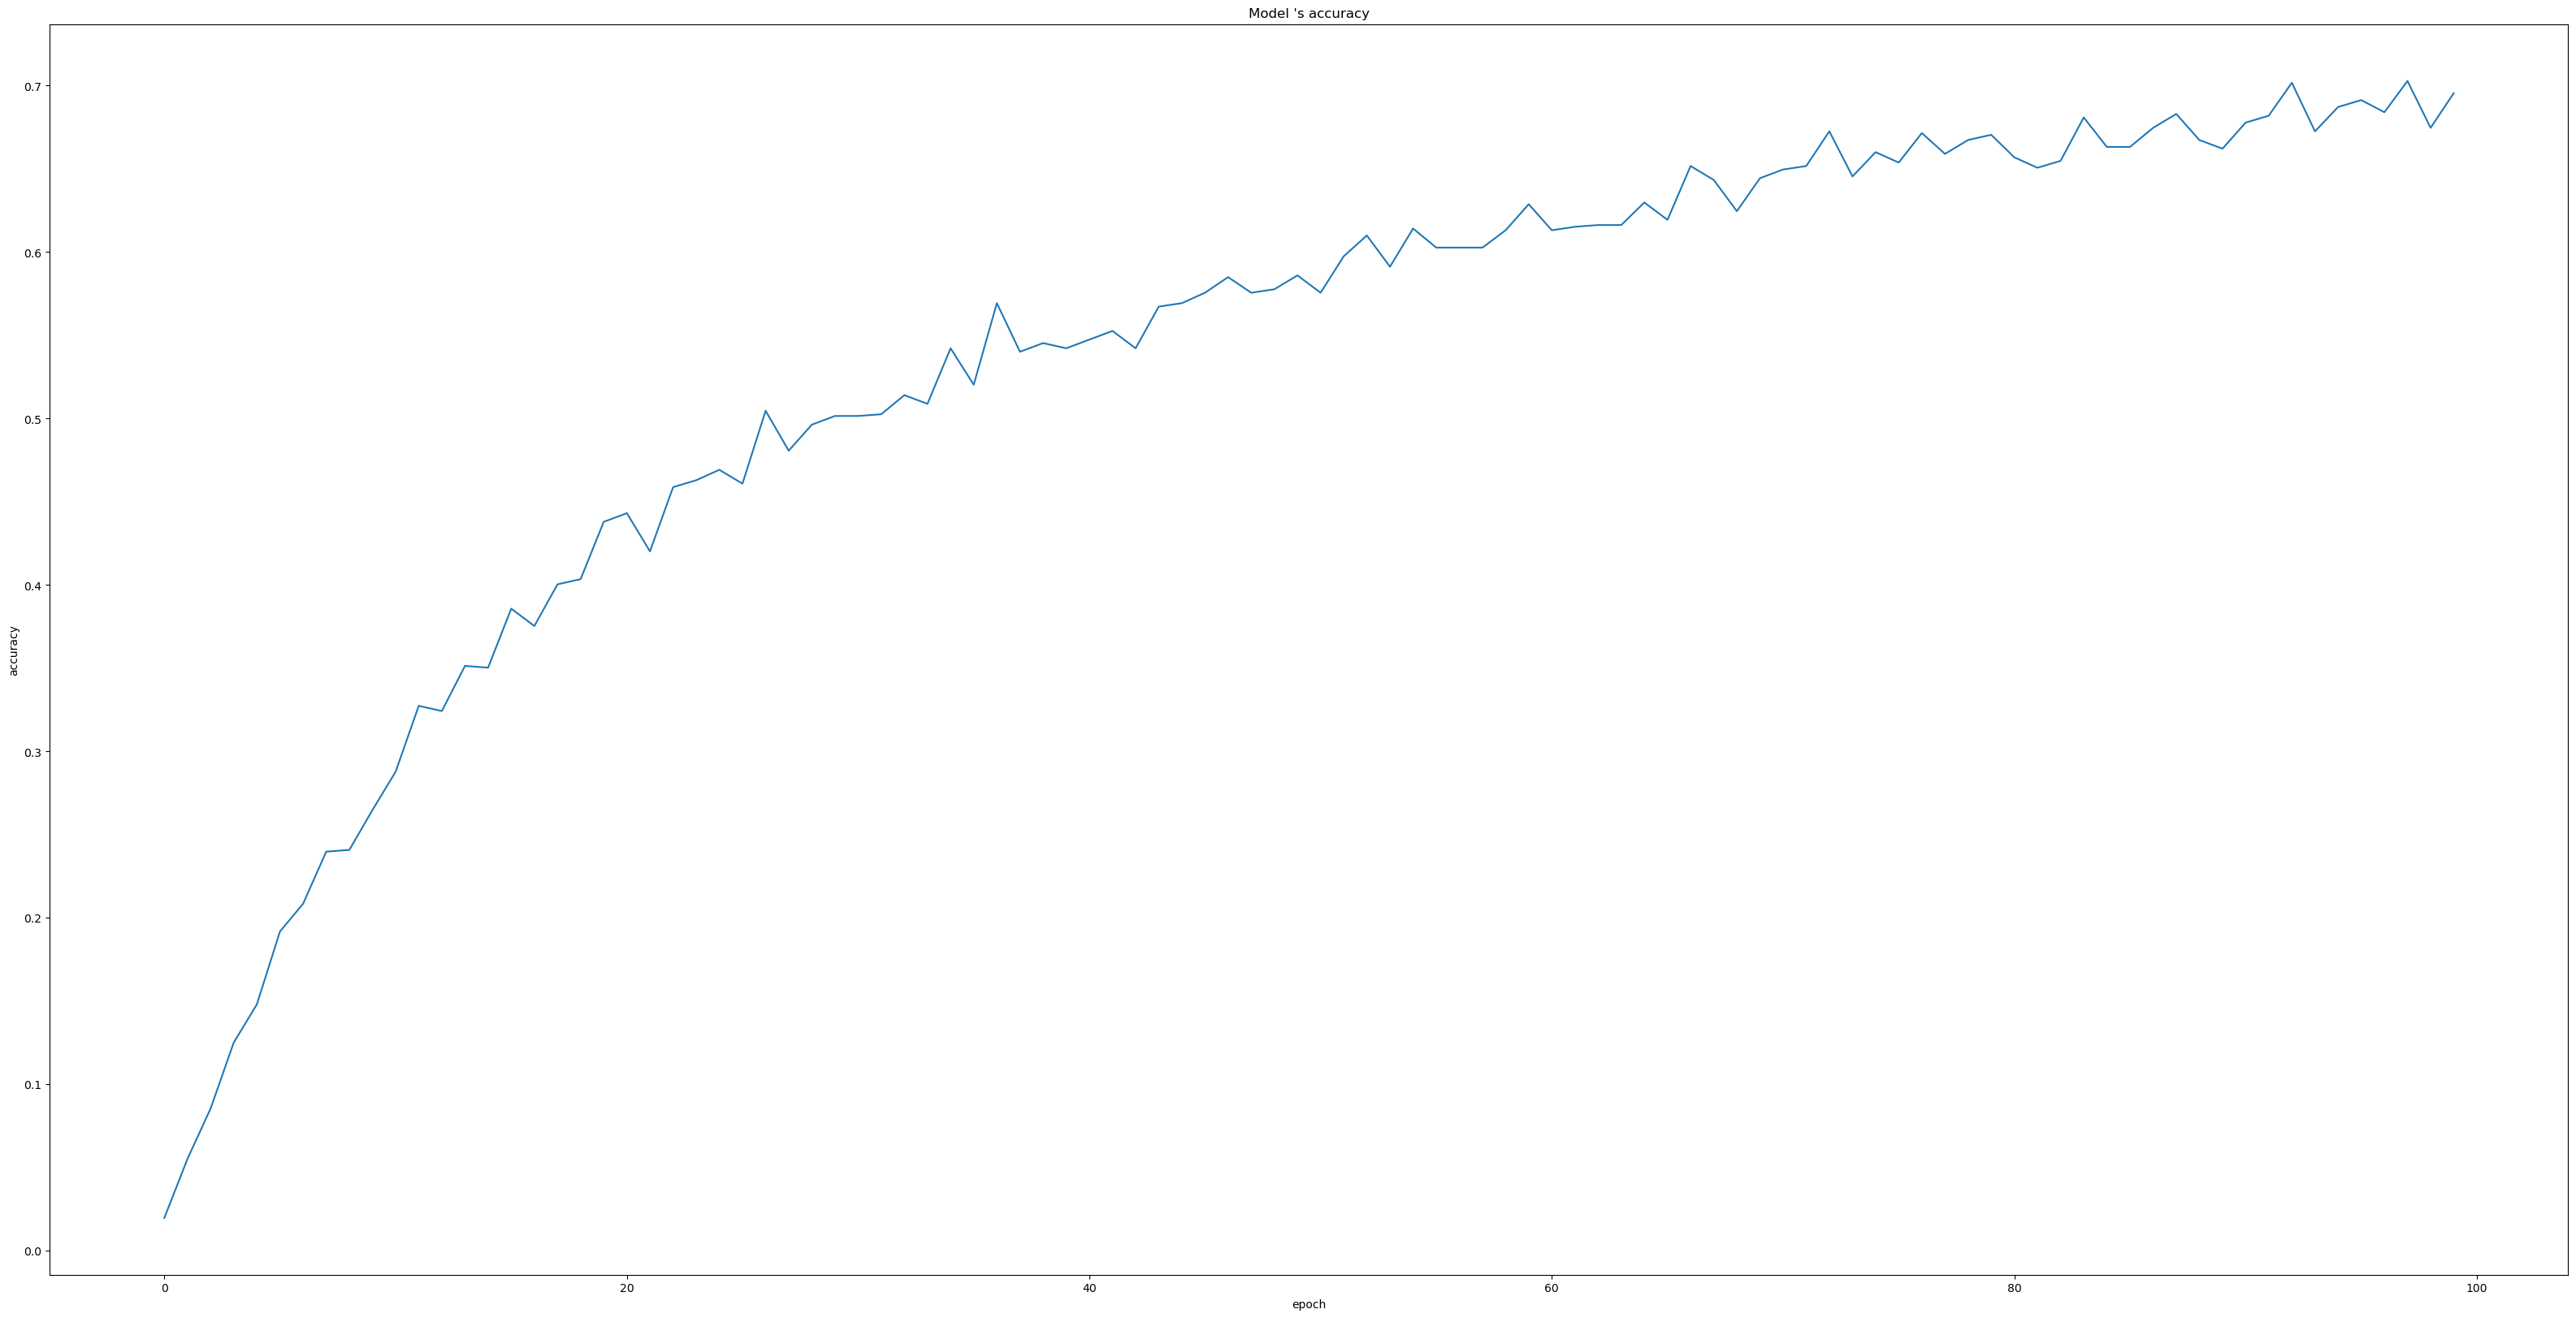

In [387]:
plot_loss_acc_rate(history)

### Unfiltered Data

In [388]:
scaled_Xtrain = X_train.copy()
scaled_Xtrain[:] = min_max_scaler.fit_transform(scaled_Xtrain[:])
scaled_Xtest = X_test.copy()
scaled_Xtest[:] = min_max_scaler.fit_transform(scaled_Xtest[:])
scaled_Xtrain_np = scaled_Xtrain.to_numpy()
scaled_Xtest_np = scaled_Xtest.to_numpy()
train_labels = target_train.to_numpy()
test_labels = target_test.to_numpy()

In [389]:
ann_model2 = keras.Sequential()
ann_model2.add(keras.layers.InputLayer(input_shape = (100,)))
ann_model2.add(keras.layers.Dense(120, activation ='elu'))
ann_model2.add(keras.layers.Dropout(0.3))
ann_model2.add(keras.layers.Dense(100, activation ='elu'))
ann_model2.add(keras.layers.Dropout(0.3))
ann_model2.add(keras.layers.Dense(96))
ann_model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 120)               12120     
_________________________________________________________________
dropout_17 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 100)               12100     
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_132 (Dense)            (None, 96)                9696      
Total params: 33,916
Trainable params: 33,916
Non-trainable params: 0
_________________________________________________________________


In [390]:
ann_model2.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])
history2 = ann_model.fit(scaled_Xtrain_np, train_labels , epochs=15)

Epoch 1/15
959/959 [==============================] - 0s 179us/step - loss: 5.3637 - accuracy: 0.2450
Epoch 2/15
959/959 [==============================] - 0s 185us/step - loss: 2.2926 - accuracy: 0.3337
Epoch 3/15
959/959 [==============================] - 0s 210us/step - loss: 1.8932 - accuracy: 0.4046
Epoch 4/15
959/959 [==============================] - 0s 192us/step - loss: 1.8303 - accuracy: 0.4307
Epoch 5/15
959/959 [==============================] - 0s 194us/step - loss: 1.7680 - accuracy: 0.4150
Epoch 6/15
959/959 [==============================] - 0s 193us/step - loss: 1.7049 - accuracy: 0.4411
Epoch 7/15
959/959 [==============================] - 0s 229us/step - loss: 1.7193 - accuracy: 0.4369
Epoch 8/15
959/959 [==============================] - 0s 201us/step - loss: 1.6622 - accuracy: 0.4442
Epoch 9/15
959/959 [==============================] - 0s 193us/step - loss: 1.6611 - accuracy: 0.4526
Epoch 10/15
959/959 [==============================] - 0s 192us/step - loss: 1.613

In [391]:
start_time = time.time()
test_loss, test_acc = ann_model2.evaluate(scaled_Xtest_np, test_labels, verbose=2)
runtime = round(time.time() - start_time,4)
print("Neural Network algorithm prediction time: "+ str(runtime))
test_acc

Neural Network algorithm prediction time: 0.2499


0.01652892492711544

## XGBoost Algorithm

In [392]:
xgb_param = {
    'learning_rate': [0.02, 0.05, 0.1, 0.3],
    'max_depth': [6, 8, 10],
    'n_estimators': [50, 80, 100],
    'colsample_bytree' : [0.4, 0.6,0.8]
}
model_xgb_hyper = GridSearchCV(estimator= xgb.XGBClassifier(eval_metric = 'auc', subsample = 0.5),
                              param_grid = xgb_param, cv = 3,
                              return_train_score= True, verbose = 4)
model_xgb_hyper.fit(aX_train,  atarget_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=50;, score=(train=0.782, test=0.738) total time=   1.1s
[CV 2/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=50;, score=(train=0.776, test=0.684) total time=   1.1s
[CV 3/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=50;, score=(train=0.744, test=0.633) total time=   1.1s
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=80;, score=(train=0.837, test=0.784) total time=   1.7s
[CV 2/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=80;, score=(train=0.829, test=0.759) total time=   1.7s
[CV 3/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=80;, score=(train=0.831, test=0.740) total time=   1.6s
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=100;, score=(train=0.861, test=0.7

[CV 1/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=6, n_estimators=100;, score=(train=0.980, test=0.887) total time=   2.0s
[CV 2/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=6, n_estimators=100;, score=(train=0.975, test=0.903) total time=   2.0s
[CV 3/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=6, n_estimators=100;, score=(train=0.970, test=0.850) total time=   2.0s
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=50;, score=(train=0.926, test=0.838) total time=   1.1s
[CV 2/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=50;, score=(train=0.934, test=0.838) total time=   1.1s
[CV 3/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=50;, score=(train=0.934, test=0.818) total time=   1.1s
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=80;, score=(train=0.975, test=0.884) total time=   1.7s
[CV 2/3] END colsample_bytree=0.4, learning_r

[CV 1/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=80;, score=(train=0.845, test=0.762) total time=   2.0s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=80;, score=(train=0.831, test=0.769) total time=   1.9s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=80;, score=(train=0.836, test=0.724) total time=   1.9s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=100;, score=(train=0.862, test=0.775) total time=   2.4s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=100;, score=(train=0.858, test=0.794) total time=   2.4s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=100;, score=(train=0.856, test=0.752) total time=   2.4s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=10, n_estimators=50;, score=(train=0.767, test=0.716) total time=   1.2s
[CV 2/3] END colsample_bytree=0.6, le

[CV 1/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=50;, score=(train=0.931, test=0.828) total time=   1.2s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=50;, score=(train=0.928, test=0.847) total time=   1.2s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=50;, score=(train=0.930, test=0.812) total time=   1.2s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=80;, score=(train=0.977, test=0.866) total time=   1.9s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=80;, score=(train=0.959, test=0.878) total time=   1.9s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=80;, score=(train=0.956, test=0.809) total time=   1.9s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=100;, score=(train=0.981, test=0.875) total time=   2.2s
[CV 2/3] END colsample_bytree=0.6, learn

[CV 1/3] END colsample_bytree=0.8, learning_rate=0.02, max_depth=10, n_estimators=100;, score=(train=0.865, test=0.778) total time=   2.7s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.02, max_depth=10, n_estimators=100;, score=(train=0.861, test=0.781) total time=   2.8s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.02, max_depth=10, n_estimators=100;, score=(train=0.864, test=0.749) total time=   2.8s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=50;, score=(train=0.870, test=0.784) total time=   1.5s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=50;, score=(train=0.872, test=0.816) total time=   1.6s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=50;, score=(train=0.869, test=0.743) total time=   1.6s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=80;, score=(train=0.917, test=0.791) total time=   2.5s
[CV 2/3] END colsample_bytree=0.8, 

[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=80;, score=(train=0.994, test=0.869) total time=   2.0s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=80;, score=(train=0.987, test=0.897) total time=   2.0s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=80;, score=(train=0.992, test=0.809) total time=   2.1s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=100;, score=(train=0.995, test=0.872) total time=   2.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=100;, score=(train=0.994, test=0.909) total time=   2.2s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=100;, score=(train=0.995, test=0.821) total time=   2.3s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=50;, score=(train=0.987, test=0.875) total time=   1.2s
[CV 2/3] END colsample_bytree=0.8, learning_r

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='auc', gamma=None, gpu_id=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                             

In [393]:
model_xgb_hyper.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [394]:
start_time = time.time()
grid_xgb_predictions = model_xgb_hyper.predict(aX_test)
runtime = round(time.time() - start_time,4)
print("XGBoost algorithm prediction time: "+ str(runtime))
print(classification_report(atarget_test,grid_xgb_predictions))

XGBoost algorithm prediction time: 0.009
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      0.50      0.67         4
           3       0.50      1.00      0.67         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         1
          19       1.00      1.00      1.00         1
          21       0.67      1.00      0

## Data Generation

### Variational Autoencoder Definition

In [540]:
def sample(means_log_var):
    means, log_var = means_log_var
    epsilon = K.random_normal(shape=(K.shape(means)[0], latent_dim), mean=0, stddev=0.1)
    return means + K.exp(log_var) * epsilon

In [541]:
data_shape = (20,)
latent_dim = 8
input_layer = keras.Input(shape=data_shape)
x = keras.layers.Dense(18, activation ='relu')(input_layer)
x = keras.layers.Dense(15, activation ='relu')(x)
x = keras.layers.Dense(10, activation ='relu')(x)
means = keras.layers.Dense(latent_dim)(x)
log_var = keras.layers.Dense(latent_dim)(x)

z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

encoder = keras.models.Model(input_layer, [means, log_var, z])
print(encoder.summary())

Model: "model_119"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_129 (InputLayer)          (None, 20)           0                                            
__________________________________________________________________________________________________
dense_539 (Dense)               (None, 18)           378         input_129[0][0]                  
__________________________________________________________________________________________________
dense_540 (Dense)               (None, 15)           285         dense_539[0][0]                  
__________________________________________________________________________________________________
dense_541 (Dense)               (None, 10)           160         dense_540[0][0]                  
__________________________________________________________________________________________

In [542]:
decoder_input = keras.layers.Input(shape =(latent_dim,))
x = keras.layers.Dense(10, activation ='relu')(decoder_input)
x = keras.layers.Dense(15, activation ='relu')(x)
x = keras.layers.Dense(18, activation ='relu')(x)
outputs = keras.layers.Dense(20, activation ='sigmoid')(x)

decoder = keras.models.Model(decoder_input, outputs)
print(decoder.summary())
x_prime = decoder(z)

Model: "model_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_130 (InputLayer)       (None, 8)                 0         
_________________________________________________________________
dense_544 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_545 (Dense)            (None, 15)                165       
_________________________________________________________________
dense_546 (Dense)            (None, 18)                288       
_________________________________________________________________
dense_547 (Dense)            (None, 20)                380       
Total params: 923
Trainable params: 923
Non-trainable params: 0
_________________________________________________________________
None


In [543]:
def my_loss(x, x_prime):
#     x = K.flatten(x)
#     x_prime = K.flatten(x_prime)
    reconstruct_loss = 20*keras.metrics.binary_crossentropy(x, x_prime)
    kl_loss = -0.5* K.sum(1 + log_var - K.square(means) - K.exp(log_var), axis = -1)
    return K.mean(reconstruct_loss + kl_loss)


In [544]:
outputs = decoder(encoder(input_layer)[2])
vae = keras.models.Model(input_layer, outputs, name='vae')    
vae.compile(loss=my_loss,optimizer="adam")
print(vae.summary())  

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_129 (InputLayer)       (None, 20)                0         
_________________________________________________________________
model_119 (Model)            [(None, 8), (None, 8), (N 999       
_________________________________________________________________
model_120 (Model)            (None, 20)                923       
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________
None


In [545]:
def create_vae():
    data_shape = (20,)
    latent_dim = 8
    input_layer = keras.Input(shape=data_shape)
    x = keras.layers.Dense(18, activation ='relu')(input_layer)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(10, activation ='relu')(x)
    means = keras.layers.Dense(latent_dim)(x)
    log_var = keras.layers.Dense(latent_dim)(x)

    z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

    encoder = keras.models.Model(input_layer, [means, log_var, z])
    
    decoder_input = keras.layers.Input(shape =(latent_dim,))
    x = keras.layers.Dense(10, activation ='relu')(decoder_input)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(18, activation ='relu')(x)
    outputs = keras.layers.Dense(20, activation ='sigmoid')(x)

    decoder = keras.models.Model(decoder_input, outputs)
    x_prime = decoder(z)
    outputs = decoder(encoder(input_layer)[2])
    vae = keras.models.Model(input_layer, outputs, name='vae')    
    vae.compile(loss=my_loss,optimizer="adam")
    print(vae.summary())
    return vae, encoder

### Data preparation

In [546]:
def data_split_for_syn(dataframe, train_size):
  
    shuffled_df = dataframe.sample(frac=1, random_state = 37)
    train_num = int(train_size * len(dataframe))
    
    train_set_with_label = shuffled_df[:train_num]
    test_set_with_label = shuffled_df[train_num:]
    
    train_set_with_label = train_set_with_label.sort_values('location')
    test_set_with_label = test_set_with_label.sort_values('location')
    
    train_set_with_label.reset_index(inplace=True, drop=True)
    test_set_with_label.reset_index(inplace=True, drop=True)
    
#     train_set_with_label.loc[:, no_channel_training_cols] =  min_max_scaler.fit_transform(train_set_with_label.loc[:, no_channel_training_cols])
#     test_set_with_label.loc[:, no_channel_training_cols] =  min_max_scaler.fit_transform(test_set_with_label.loc[:, no_channel_training_cols])
    return train_set_with_label, test_set_with_label

In [547]:
def prep_data_for_synthesis(dataframe, percentage):
    if percentage <= 0.5:
        frac = int(1/percentage)
    else:
        frac = int(1/(1-percentage))
#     dataframe = dataframe.sample(frac=1, random_state = 37)
#     dataframe.reset_index(inplace=True, drop=True)
    part_df = dataframe.loc[:, no_channel_training_cols + ['location']].iloc[::frac]
    indices = part_df.index
    test_df = dataframe.drop(indices, axis=0).loc[:, no_channel_training_cols + ['location']]

    
    part_locations = part_df.loc[:, ['location']]
#     part_df[:] = min_max_scaler.fit_transform(part_df[:])
    part_df = part_df.loc[:, no_channel_training_cols]
    
    test_locations = test_df.loc[:, ['location']]
#     test_df[:] = min_max_scaler.fit_transform(test_df[:])
    test_df = test_df.loc[:, no_channel_training_cols]
    
    if percentage <= 0.5:
        return part_df, part_locations, test_df, test_locations
    
    return   test_df, test_locations, part_df, part_locations
    



In [548]:
alpha_filtered2_train, alpha_filtered2_test = data_split_for_syn(alpha_filtered2.loc[:, no_channel_training_cols + ['location']],0.8)
half_df, half_locations, half_df_test, half_test_loc = prep_data_for_synthesis(alpha_filtered2_train, 0.5)
fourth_df, fourth_locations, fourth_df_test, fourth_test_loc = prep_data_for_synthesis(alpha_filtered2_train, 0.25)

In [549]:
half_df

beacon1    beacon2     beacon3     beacon4     beacon5     beacon6  \
0   -107.134454 -83.647059 -172.931671 -300.000000 -300.000000 -300.000000   
2    -94.928571 -83.100000 -207.611111 -300.000000 -300.000000 -300.000000   
4    -94.833333 -83.500000 -209.888889 -300.000000 -300.000000 -300.000000   
6    -95.080357 -83.625000 -185.205376 -300.000000 -300.000000 -300.000000   
8   -120.875000 -83.375000 -221.152778 -300.000000 -300.000000 -300.000000   
..          ...        ...         ...         ...         ...         ...   
950  -93.186987 -89.791008 -112.376929 -145.406447 -200.161481 -211.664762   
952  -93.187601 -89.791632 -112.377486 -145.406907 -200.161777 -211.665025   
954  -93.187447 -89.791476 -112.377347 -145.406791 -200.161703 -211.664959   
956  -93.186834 -89.790852 -112.376790 -145.406333 -200.161407 -211.664697   
958  -93.186681 -89.790697 -112.376652 -145.406219 -200.161333 -211.664632   

        beacon7     beacon8     beacon9    beacon10    beacon11    beacon12  \
0   -300.000000 -300.000000 -300.000000  -99.220588 -300.000000 -300.000000   
2   -300.000000 -300.000000 -300.000000 -118.357500 -300.000000 -300.000000   
4   -300.000000 -300.000000 -300.000000 -131.166667 -300.000000 -300.000000   
6   -300.000000 -300.000000 -300.000000  -99.234375 -300.000000 -300.000000   
8   -300.000000 -300.000000 -300.000000  -98.175000 -300.000000 -300.000000   
..          ...         ...         ...         ...         ...         ...   
950 -201.389845 -185.995421 -188.564798  -93.634039 -275.911576 -274.502853   
952 -201.390138 -185.995760 -188.565129  -93.634652 -275.911648 -274.502928   
954 -201.390065 -185.995675 -188.565046  -93.634498 -275.911630 -274.502909   
956 -201.389772 -185.995337 -188.564715  -93.633886 -275.911558 -274.502834   
958 -201.389699 -185.995253 -188.564633  -93.633734 -275.911541 -274.502815   

       beacon13    beacon14    beacon15    beacon16    beacon17    beacon18  \
0   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
2   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
4   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
6   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
8   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
..          ...         ...         ...         ...         ...         ...   
950 -272.353795 -269.961655 -286.048080 -284.236170 -287.030935 -284.942635   
952 -272.353877 -270.551686 -286.706572 -284.935001 -287.714390 -285.615431   
954 -272.353856 -270.404659 -286.539584 -284.758332 -287.544808 -285.448521   
956 -272.353774 -269.811344 -285.877935 -284.065005 -286.865960 -284.766568   
958 -272.353754 -269.665583 -285.710658 -283.894134 -286.704702 -284.595952   

       beacon19    beacon20  
0   -300.000000 -300.000000  
2   -300.000000 -300.000000  
4   -300.000000 -300.000000  
6   -300.000000 -300.000000  
8   -300.000000 -300.000000  
..          ...         ...  
950 -279.243340 -270.843007  
952 -279.867993 -270.843094  
954 -279.712935 -270.843072  
956 -279.078182 -270.842986  
958 -278.921034 -270.842964  

[480 rows x 20 columns]

### Original Data Results

In [550]:
rfc_semi = RandomForestClassifier()
forest_semi_params = [{'criterion': ["entropy"], 'max_depth':[5,8,10,12,15], 'max_features': [8,10,15,20]}]
grid_clf = GridSearchCV(rfc_semi, forest_semi_params, cv = 3, scoring='accuracy',refit=True,verbose=2)
print(grid_clf.fit(alpha_filtered2_train.loc[:, no_channel_training_cols], alpha_filtered2_train.loc[:, ['location']]))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END .....criterion=entropy, max_depth=5, max_features=8; total time=   0.6s
[CV] END .....criterion=entropy, max_depth=5, max_features=8; total time=   0.6s
[CV] END .....criterion=entropy, max_depth=5, max_features=8; total time=   0.6s
[CV] END ....criterion=entropy, max_depth=5, max_features=10; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=5, max_features=10; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=5, max_features=10; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=5, max_features=15; total time=   0.9s
[CV] END ....criterion=entropy, max_depth=5, max_features=15; total time=   1.0s
[CV] END ....criterion=entropy, max_depth=5, max_features=15; total time=   0.9s
[CV] END ....criterion=entropy, max_depth=5, max_features=20; total time=   1.2s
[CV] END ....criterion=entropy, max_depth=5, max_features=20; total time=   1.2s
[CV] END ....criterion=entropy, max_depth=5, max

In [551]:
grid_clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=15, max_features=10)

In [552]:
orig_predictions = grid_clf.predict(alpha_filtered2_test.loc[:, no_channel_training_cols])
accuracy_score(alpha_filtered2_test.loc[:, ['location']], orig_predictions)*100

92.5

In [553]:
room_level_mappings = {0:[0,1,2,3,4,5,6,7,8], 1:[9,10,11,12,13,14,15,16,17], 2:[36,37,38,39,40,41,42], 3:[50,51,52,53],
                      4:[58,59,60,61], 5:[66,67,68,69,70,71,72,73,74,75,76,77,78,79,80], 6:[18,19,20,21,22,23,24,25,26]
                      , 7:[27,28,29,30,31,32,33,34,35],8:[43,44,45,46,47,48,49], 9:[54,55,56,57], 10:[62,63,64,65], 
                      11:[81,82,83,84,85,86,87,88,89,90,91,92,93,94,95]}

In [555]:
percs = [0.01,0.03, 0.05, 0.1, 0.2, 0.3,0.4, 0.5,0.6, 0.7,0.8, 0.9]
original_accs = {}
r_accs = {}
for per in percs:
    part_df, part_locations, part_df_test, part_test_loc = prep_data_for_synthesis(alpha_filtered2_train, per)
    rfc_semi = RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
    print(rfc_semi.fit(part_df, part_locations))
    perc_predictions = rfc_semi.predict(alpha_filtered2_test.loc[:, no_channel_training_cols])
    original_accs[per] = accuracy_score(alpha_filtered2_test.loc[:, ['location']], perc_predictions)*100
    
    room_lev_atarget = []
    for i in alpha_filtered2_test.loc[:, ['location']].to_numpy():
        room_lev_atarget.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
        
    room_lev_test_semi = []
    for i in perc_predictions:
        room_lev_test_semi.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
    
    r_accs[per] = accuracy_score(room_lev_atarget, room_lev_test_semi)*100

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)


In [556]:
original_accs

{0.01: 14.166666666666666,
 0.03: 39.166666666666664,
 0.05: 53.75,
 0.1: 67.5,
 0.2: 80.41666666666667,
 0.3: 89.58333333333334,
 0.4: 89.58333333333334,
 0.5: 89.58333333333334,
 0.6: 91.25,
 0.7: 90.0,
 0.8: 91.66666666666666,
 0.9: 91.66666666666666}

In [561]:
original_accs2 = {}
r_accs2 = {}
for per in percs:
    part_df, part_locations, part_df_test, part_test_loc = prep_data_for_synthesis(alpha_filtered2_train, per)
    perc_predictions,runtime = run_knn(part_df, part_locations, alpha_filtered2_test.loc[:, no_channel_training_cols],[],5)
    original_accs2[per] = accuracy_score(alpha_filtered2_test.loc[:, ['location']], perc_predictions)*100
    
    room_lev_atarget = []
    for i in alpha_filtered2_test.loc[:, ['location']].to_numpy():
        room_lev_atarget.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
        
    room_lev_test_semi = []
    for i in perc_predictions:
        room_lev_test_semi.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
    
    r_accs2[per] = accuracy_score(room_lev_atarget, room_lev_test_semi)*100

In [562]:
original_accs2

{0.01: 2.083333333333333,
 0.03: 2.083333333333333,
 0.05: 5.0,
 0.1: 28.333333333333332,
 0.2: 60.416666666666664,
 0.3: 72.08333333333333,
 0.4: 81.66666666666667,
 0.5: 81.66666666666667,
 0.6: 78.75,
 0.7: 83.33333333333334,
 0.8: 87.08333333333333,
 0.9: 90.41666666666667}

### Model Training

In [563]:
def k_nearest_neigh(X_train, target_train, X_test, target_test):  
    accuracies = []
    for k in range(1, 9):
        knn = KNeighborsClassifier(n_neighbors = k, metric='manhattan')
        knn.fit(X_train, target_train)
        y_pred = knn.predict(X_test)
        accuracies.append(accuracy_score(target_test, y_pred)*100)
    big_k = accuracies.index(max(accuracies))
    
    knn = KNeighborsClassifier(n_neighbors = big_k, metric='manhattan')
    knn.fit(X_train, target_train)
    y_pred = knn.predict(X_test)
    return y_pred

In [566]:
data_shape = (20,)
latent_dim = 8
input_layer = keras.Input(shape=data_shape)
x = keras.layers.Dense(15, activation ='relu')(input_layer)
x = keras.layers.Dense(10, activation ='relu')(x)
means = keras.layers.Dense(latent_dim)(x)
log_var = keras.layers.Dense(latent_dim)(x)

z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

encoder = keras.models.Model(input_layer, [means, log_var, z])
    
decoder_input = keras.layers.Input(shape =(latent_dim,))
x = keras.layers.Dense(10, activation ='relu')(decoder_input)
x = keras.layers.Dense(15, activation ='relu')(x)
outputs = keras.layers.Dense(20, activation ='sigmoid')(x)
decoder = keras.models.Model(decoder_input, outputs)
x_prime = decoder(z)
outputs = decoder(encoder(input_layer)[2])
vae = keras.models.Model(input_layer, outputs, name='vae')    
vae.compile(loss=my_loss,optimizer="adam",metrics=["accuracy"])
print(vae.summary())

his = vae.fit(min_max_scaler.fit_transform(alpha_filtered2_train.loc[:, no_channel_training_cols]), min_max_scaler.fit_transform(alpha_filtered2_train.loc[:, no_channel_training_cols]) , epochs = 200, batch_size = 16, validation_split= 0.2)

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_135 (InputLayer)       (None, 20)                0         
_________________________________________________________________
model_125 (Model)            [(None, 8), (None, 8), (N 651       
_________________________________________________________________
model_126 (Model)            (None, 20)                575       
Total params: 1,226
Trainable params: 1,226
Non-trainable params: 0
_________________________________________________________________
None
Train on 767 samples, validate on 192 samples
Epoch 1/200
767/767 [==============================] - 2s 2ms/step - loss: 13.4993 - accuracy: 0.1304 - val_loss: 12.6826 - val_accuracy: 0.0000e+00
Epoch 2/200
767/767 [==============================] - 0s 217us/step - loss: 10.4290 - accuracy: 0.2295 - val_loss: 10.8195 - val_accuracy: 0.0000e+00
Epoch 3/200
767/767 [===================

767/767 [==============================] - 0s 187us/step - loss: 3.2797 - accuracy: 0.5971 - val_loss: 4.8285 - val_accuracy: 0.6042
Epoch 52/200
767/767 [==============================] - 0s 183us/step - loss: 3.2640 - accuracy: 0.6010 - val_loss: 4.8135 - val_accuracy: 0.5990
Epoch 53/200
767/767 [==============================] - 0s 188us/step - loss: 3.2732 - accuracy: 0.5984 - val_loss: 4.7844 - val_accuracy: 0.5990
Epoch 54/200
767/767 [==============================] - 0s 186us/step - loss: 3.2609 - accuracy: 0.5841 - val_loss: 4.8055 - val_accuracy: 0.5990
Epoch 55/200
767/767 [==============================] - 0s 184us/step - loss: 3.2654 - accuracy: 0.5971 - val_loss: 4.8252 - val_accuracy: 0.5990
Epoch 56/200
767/767 [==============================] - 0s 186us/step - loss: 3.2705 - accuracy: 0.6023 - val_loss: 4.7596 - val_accuracy: 0.5990
Epoch 57/200
767/767 [==============================] - 0s 179us/step - loss: 3.2543 - accuracy: 0.6076 - val_loss: 4.9606 - val_accuracy

767/767 [==============================] - 0s 241us/step - loss: 3.1883 - accuracy: 0.7197 - val_loss: 4.8168 - val_accuracy: 0.9062
Epoch 108/200
767/767 [==============================] - 0s 243us/step - loss: 3.2031 - accuracy: 0.7353 - val_loss: 4.8082 - val_accuracy: 0.9062
Epoch 109/200
767/767 [==============================] - 0s 245us/step - loss: 3.1928 - accuracy: 0.7288 - val_loss: 4.6068 - val_accuracy: 0.9062
Epoch 110/200
767/767 [==============================] - 0s 208us/step - loss: 3.1902 - accuracy: 0.7119 - val_loss: 4.8275 - val_accuracy: 0.9115
Epoch 111/200
767/767 [==============================] - 0s 231us/step - loss: 3.1898 - accuracy: 0.7197 - val_loss: 4.7764 - val_accuracy: 0.9010
Epoch 112/200
767/767 [==============================] - 0s 265us/step - loss: 3.1966 - accuracy: 0.7158 - val_loss: 4.5819 - val_accuracy: 0.9062
Epoch 113/200
767/767 [==============================] - 0s 256us/step - loss: 3.1926 - accuracy: 0.7314 - val_loss: 4.7875 - val_ac

Epoch 163/200
767/767 [==============================] - 0s 247us/step - loss: 3.1748 - accuracy: 0.7405 - val_loss: 5.1549 - val_accuracy: 0.8958
Epoch 164/200
767/767 [==============================] - 0s 253us/step - loss: 3.1828 - accuracy: 0.7497 - val_loss: 4.8822 - val_accuracy: 0.9062
Epoch 165/200
767/767 [==============================] - 0s 256us/step - loss: 3.1720 - accuracy: 0.7197 - val_loss: 4.9295 - val_accuracy: 0.9062
Epoch 166/200
767/767 [==============================] - 0s 254us/step - loss: 3.1688 - accuracy: 0.7236 - val_loss: 4.9567 - val_accuracy: 0.9010
Epoch 167/200
767/767 [==============================] - 0s 243us/step - loss: 3.1549 - accuracy: 0.7458 - val_loss: 5.0253 - val_accuracy: 0.9062
Epoch 168/200
767/767 [==============================] - 0s 285us/step - loss: 3.1553 - accuracy: 0.7197 - val_loss: 4.9465 - val_accuracy: 0.8958
Epoch 169/200
767/767 [==============================] - 0s 267us/step - loss: 3.1596 - accuracy: 0.7288 - val_loss: 5

0.01
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['entropy'], 'max_depth': [10, 12, 15],
         

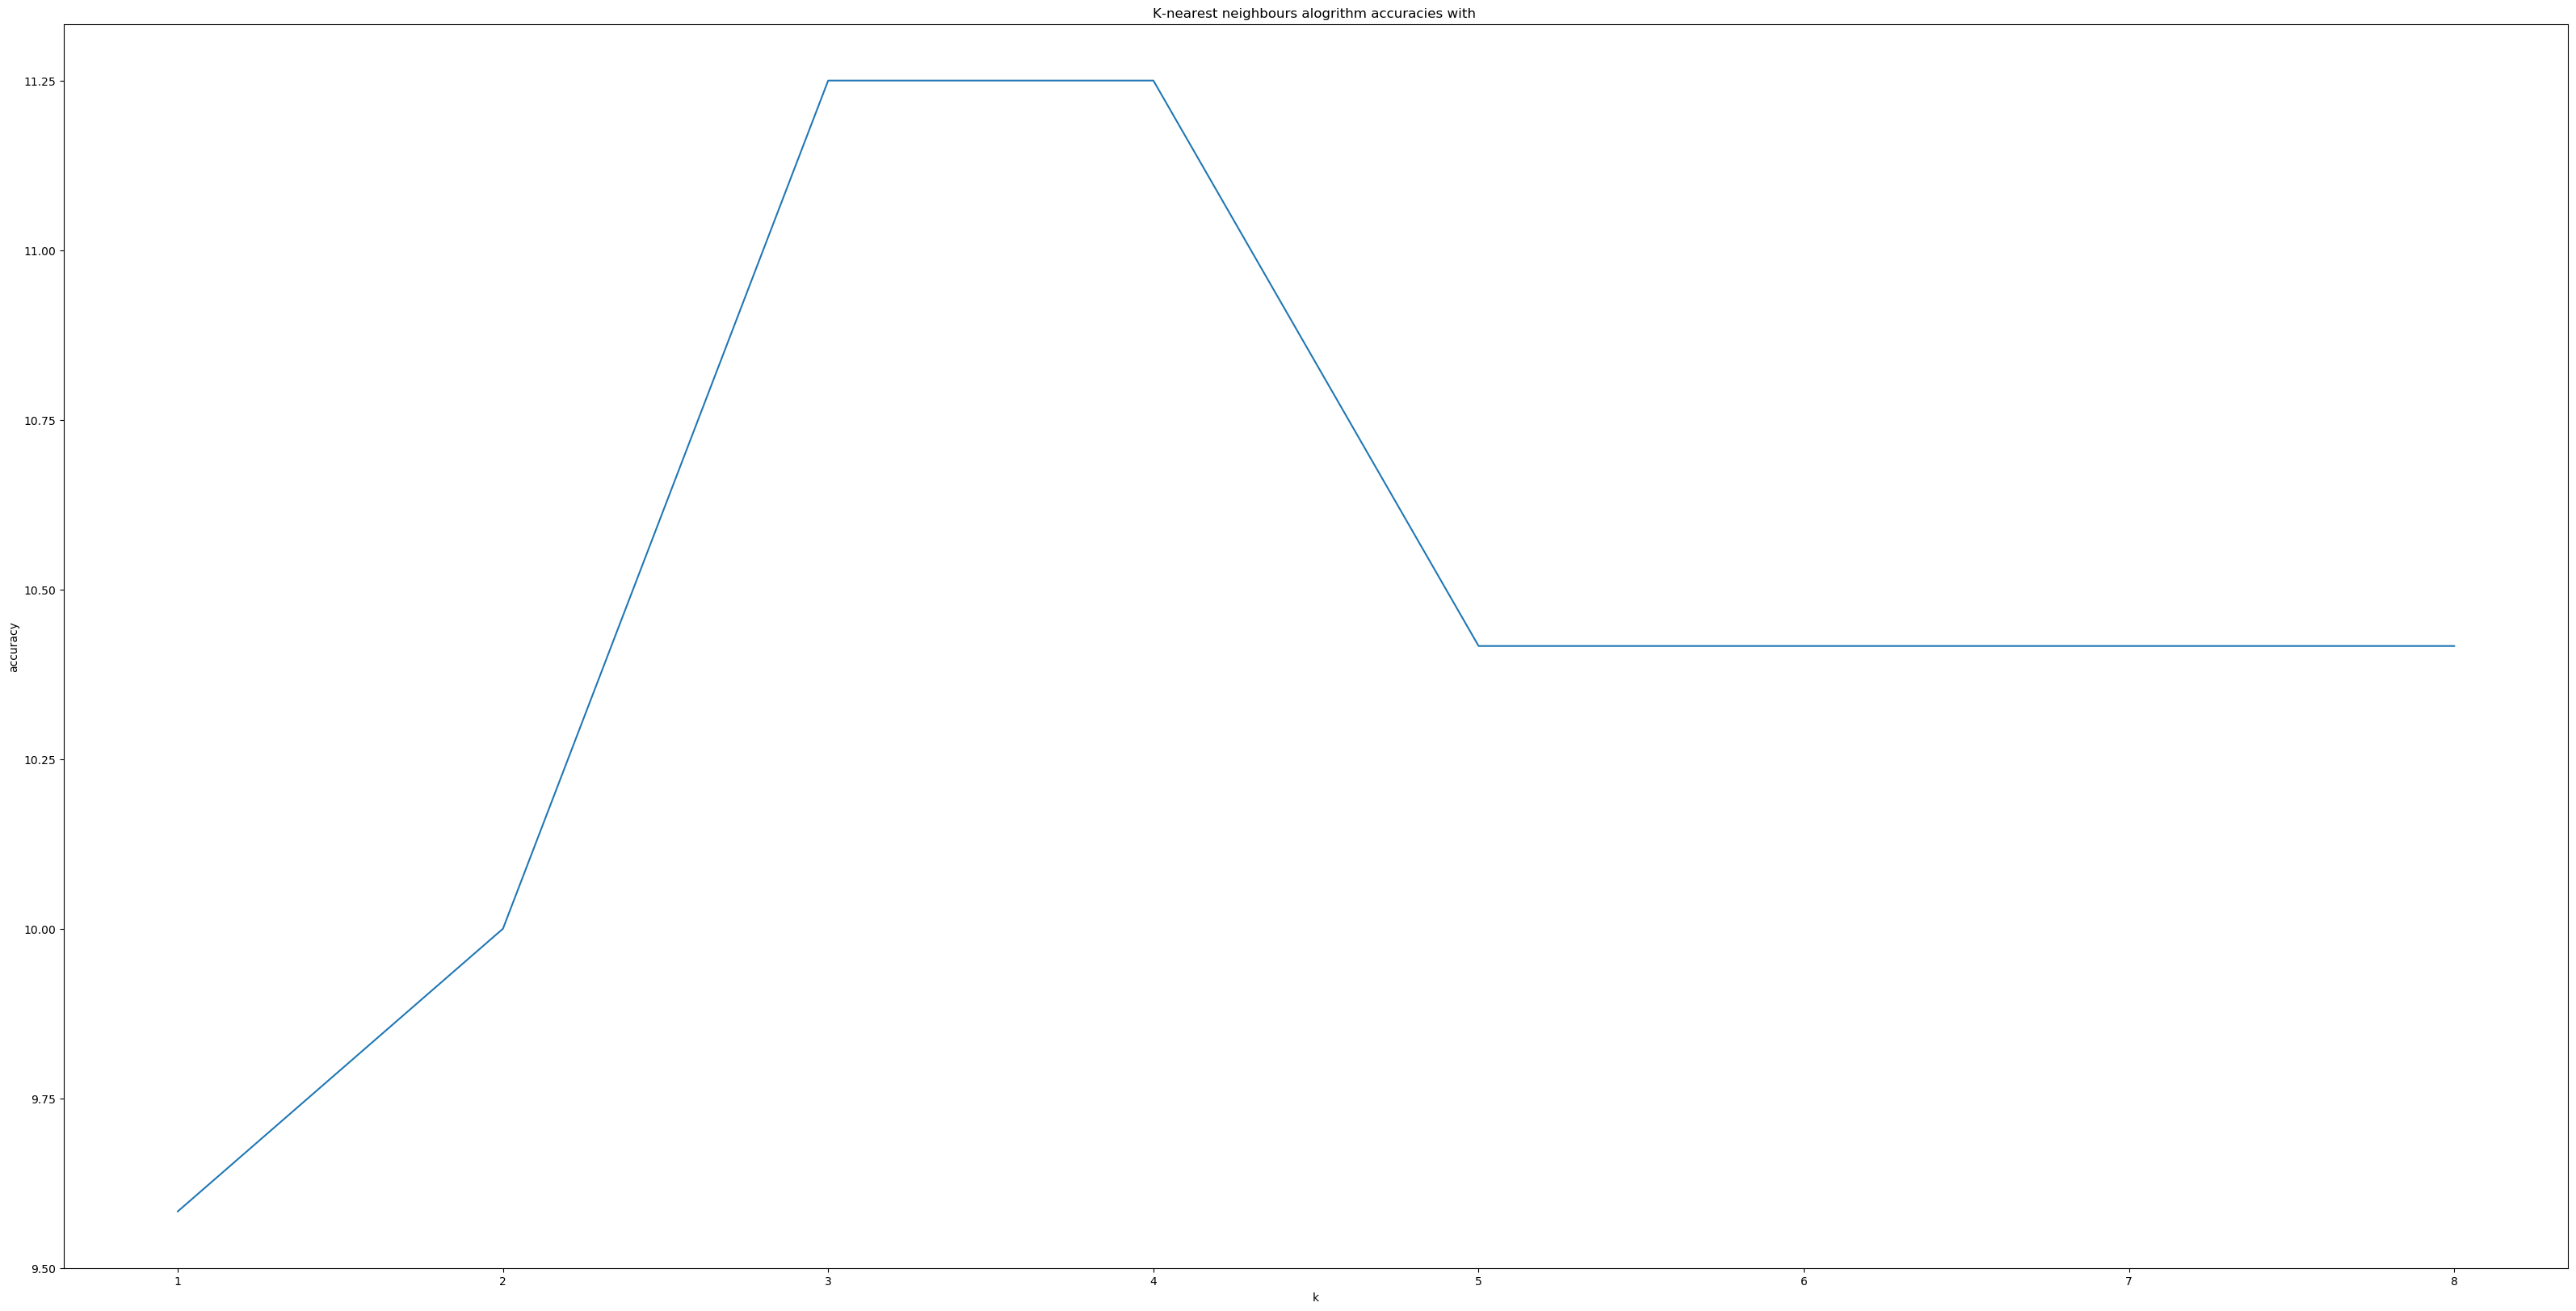

K-nearest neighbours algorithm accuracy: 11.25
0.03
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['

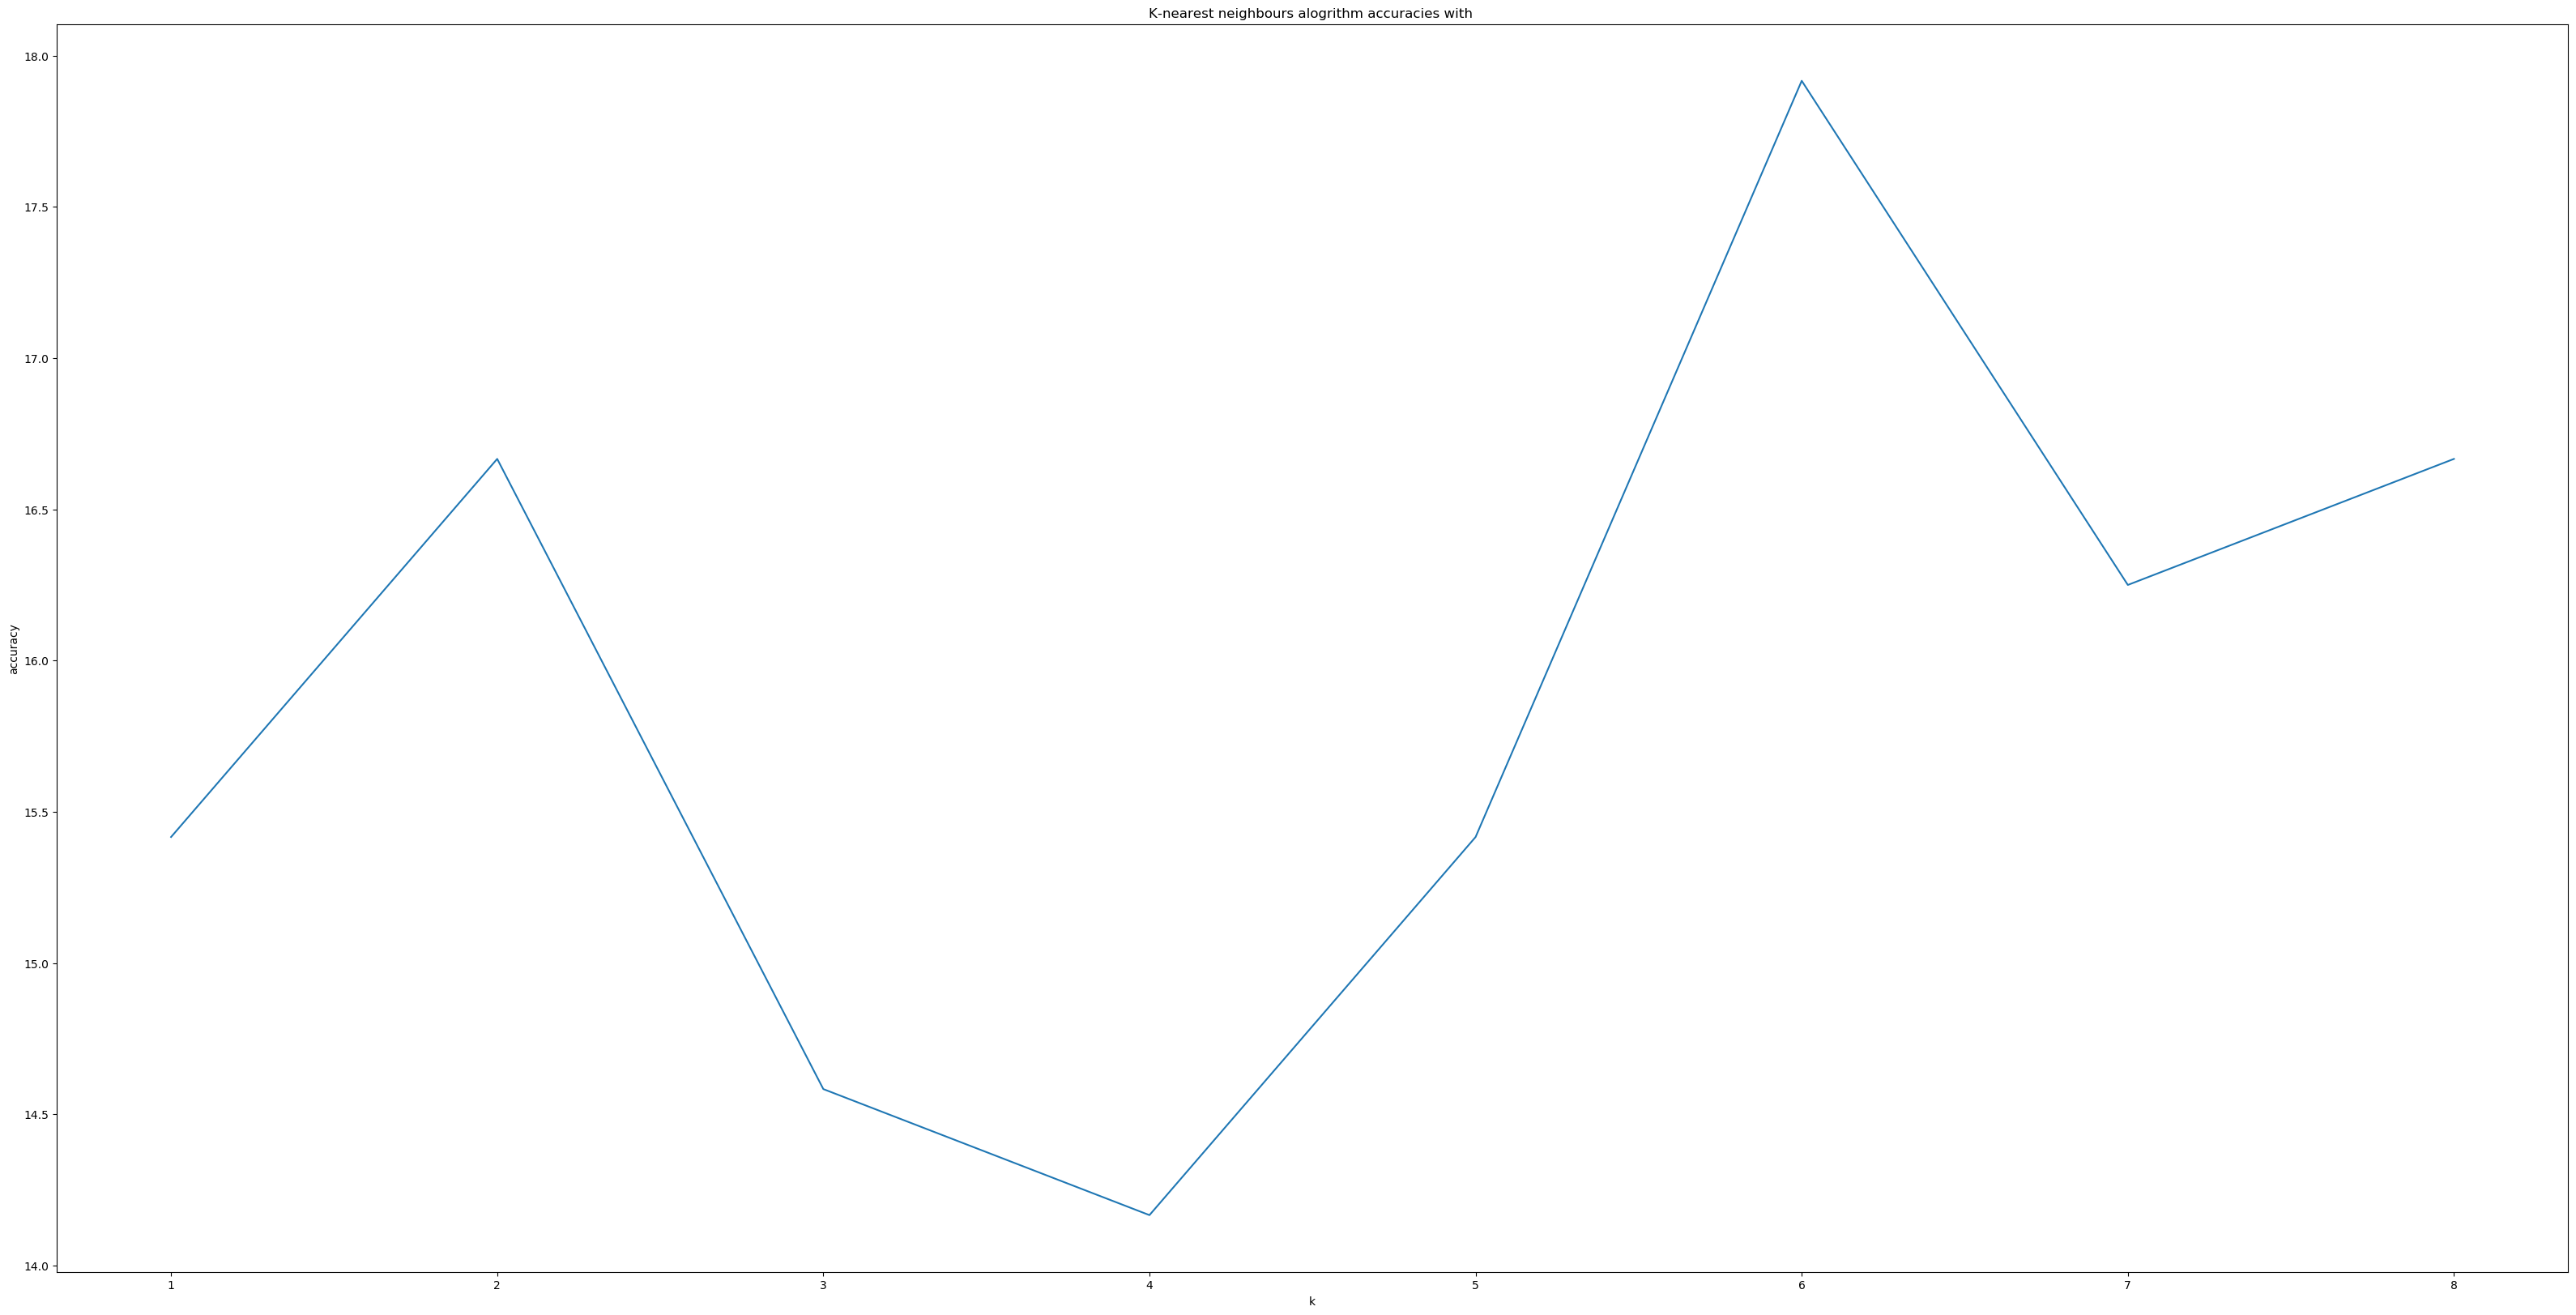

K-nearest neighbours algorithm accuracy: 17.916666666666668
0.05
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'c

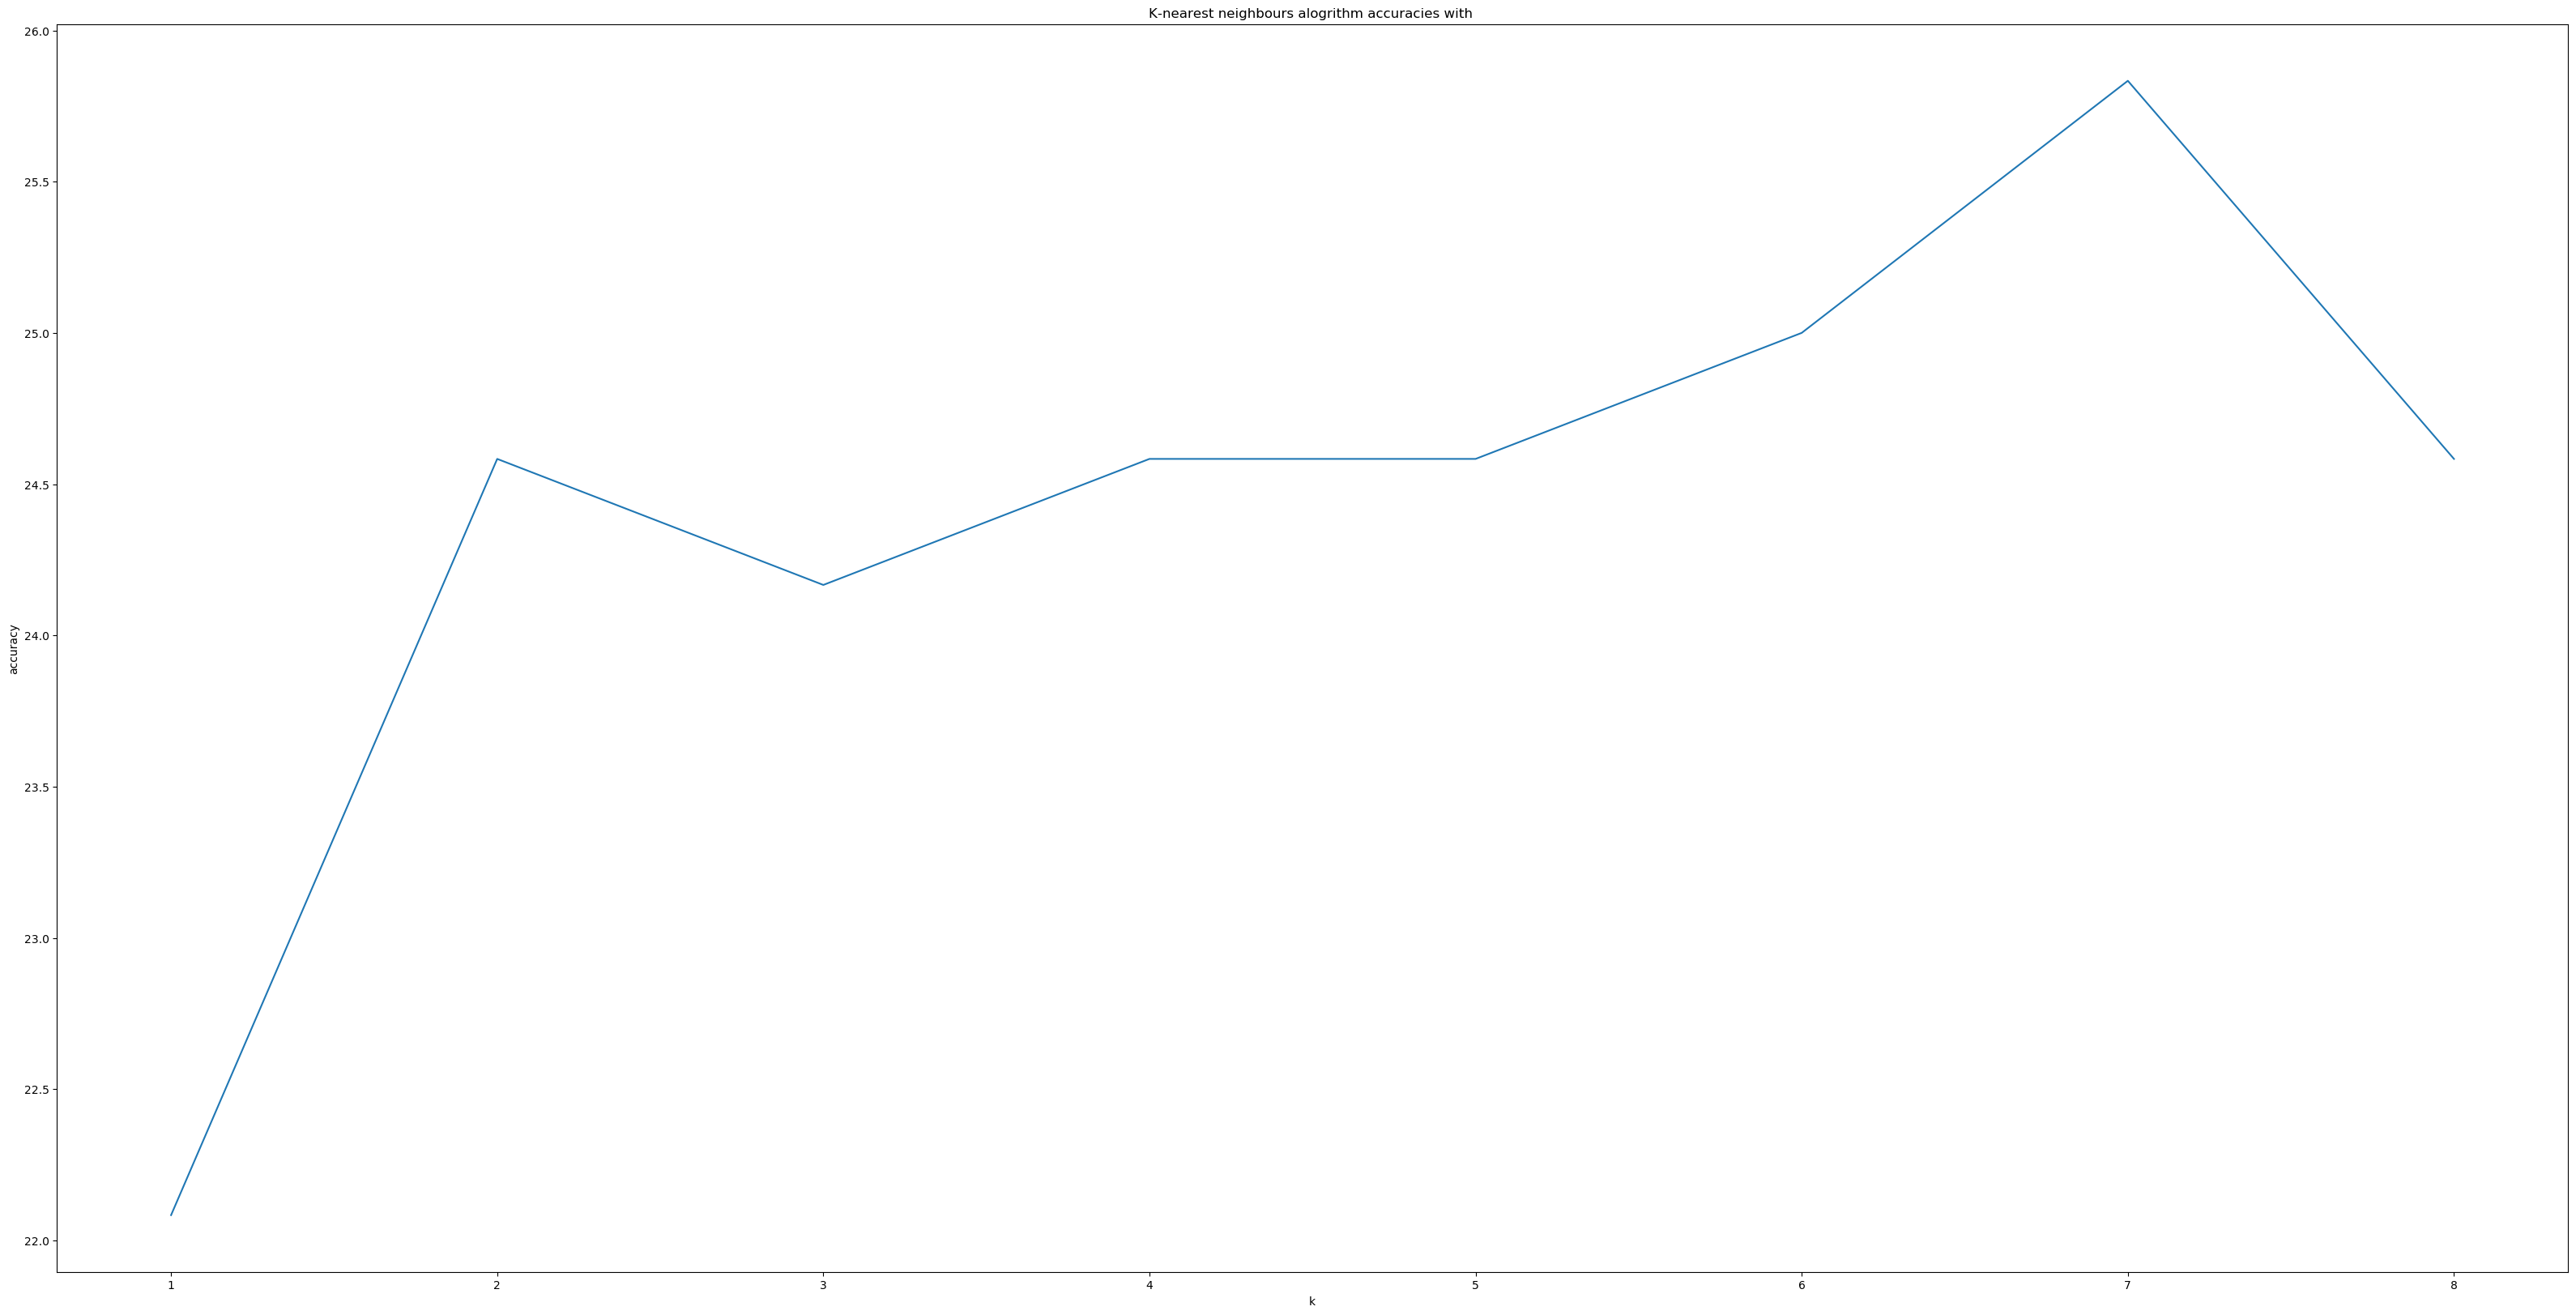

K-nearest neighbours algorithm accuracy: 25.833333333333336
0.1
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'cr

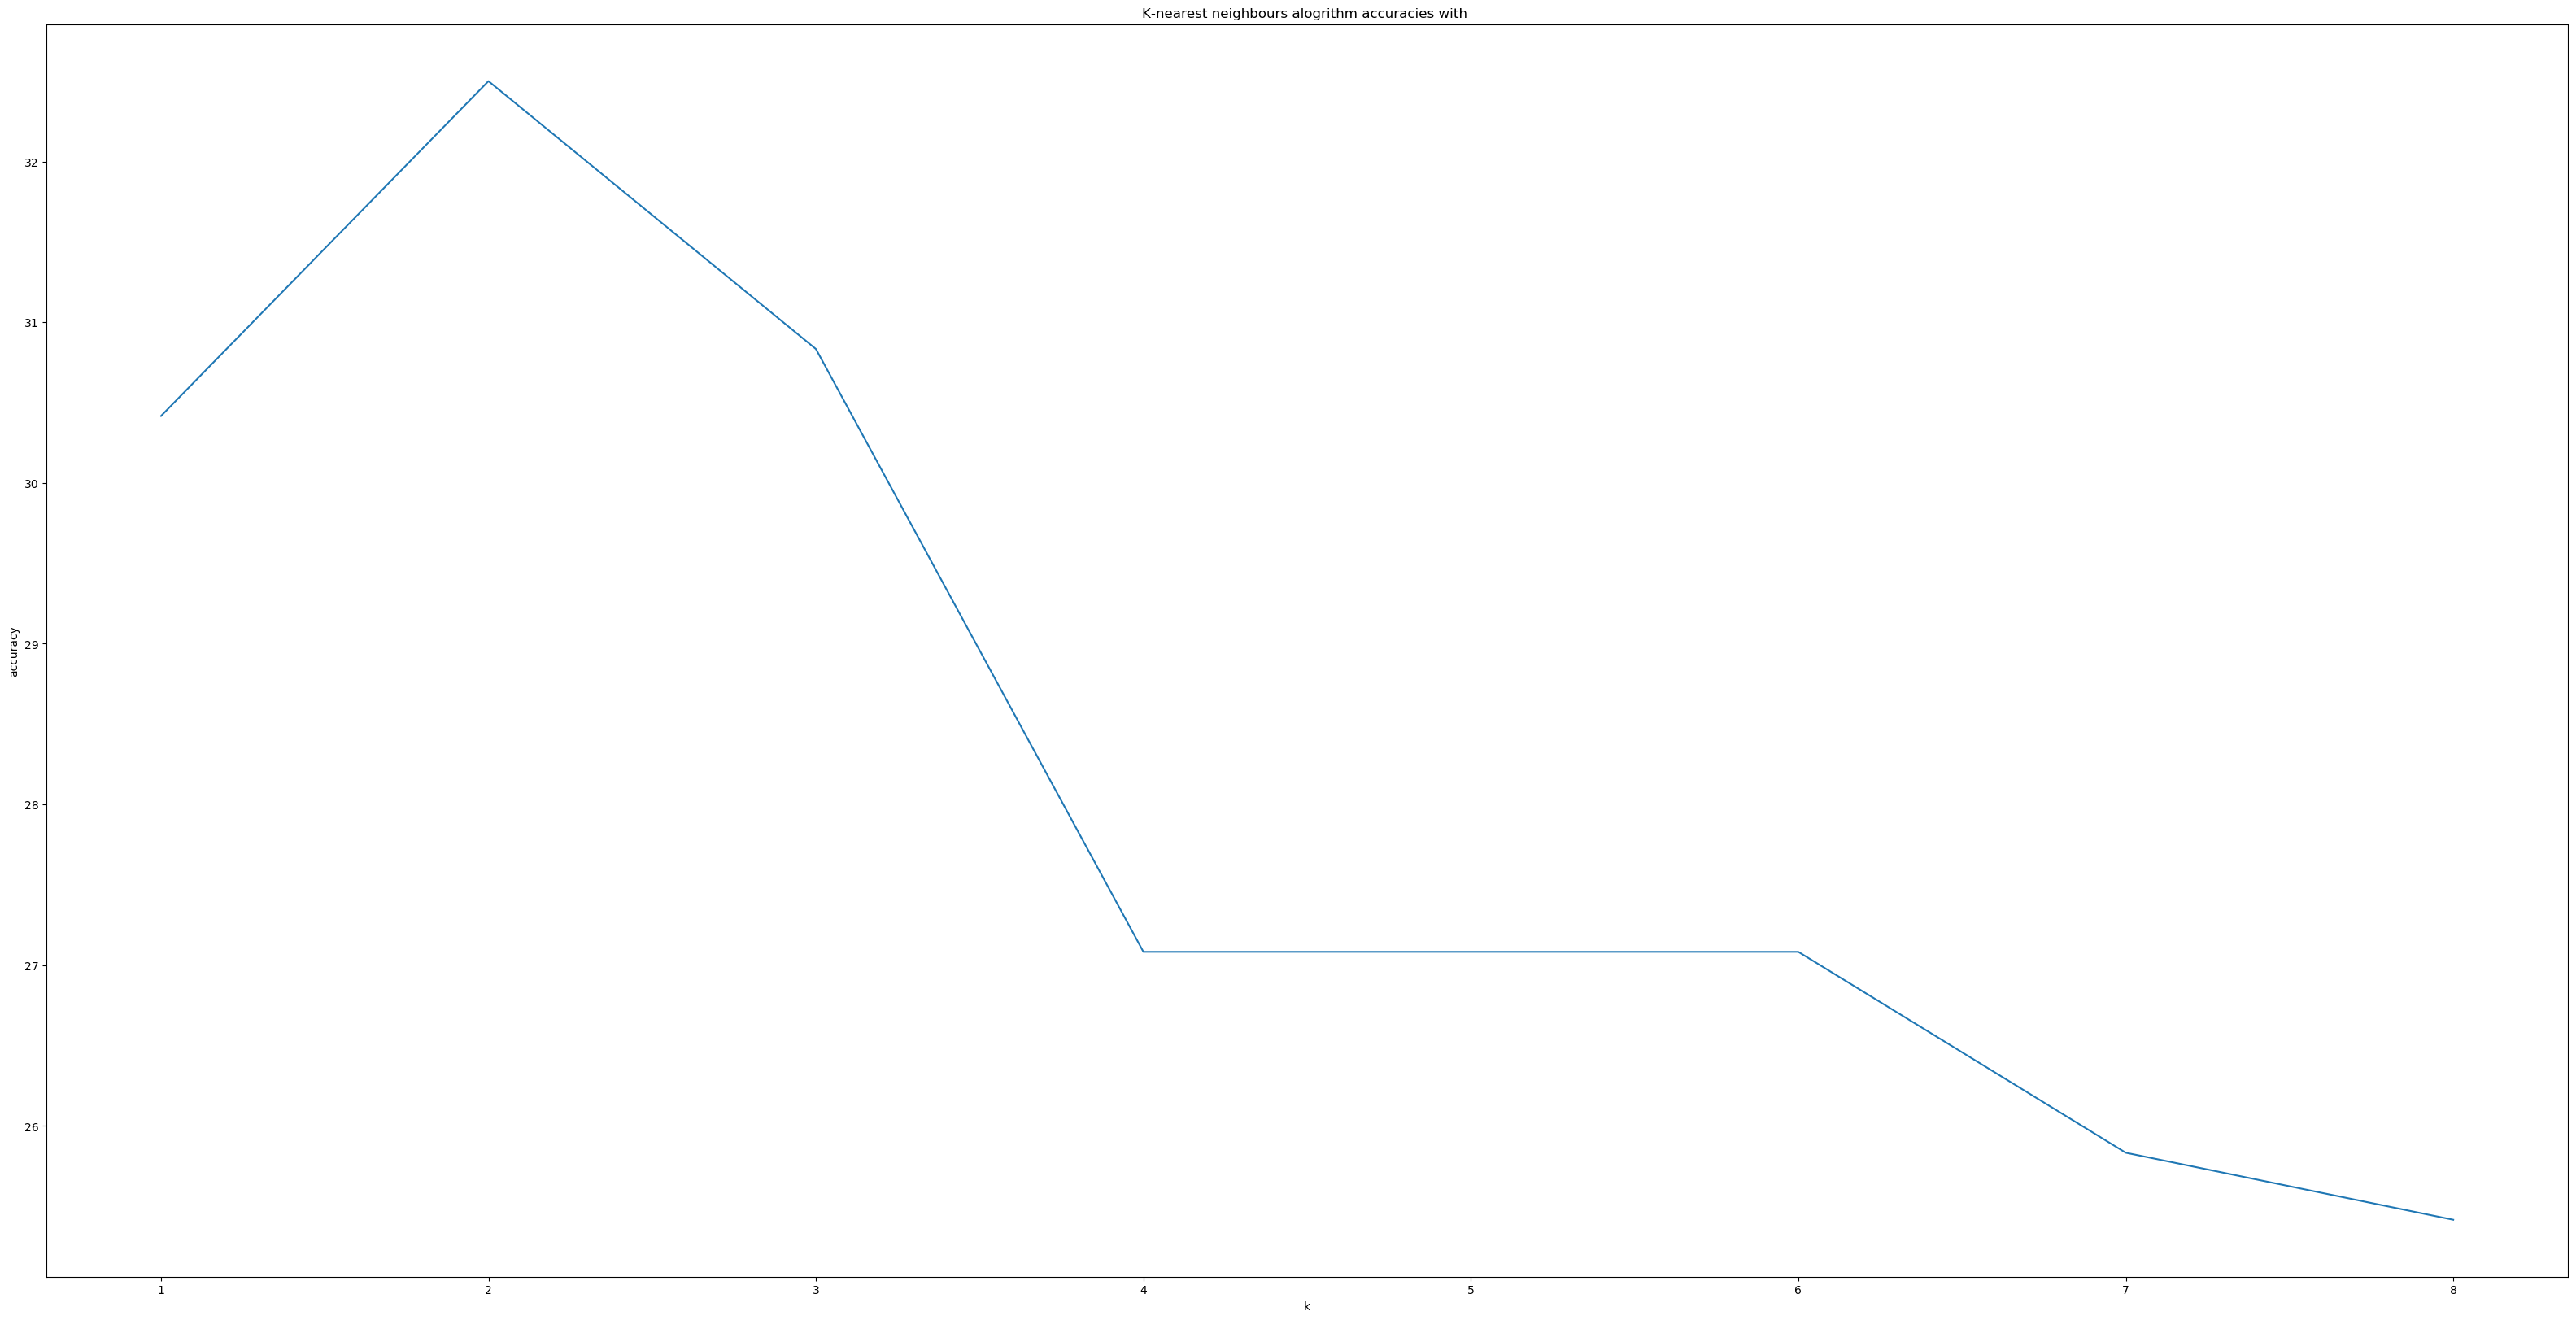

K-nearest neighbours algorithm accuracy: 32.5
0.2
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.4s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   0.6s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.4s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.6s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.4s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   0.5s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['en

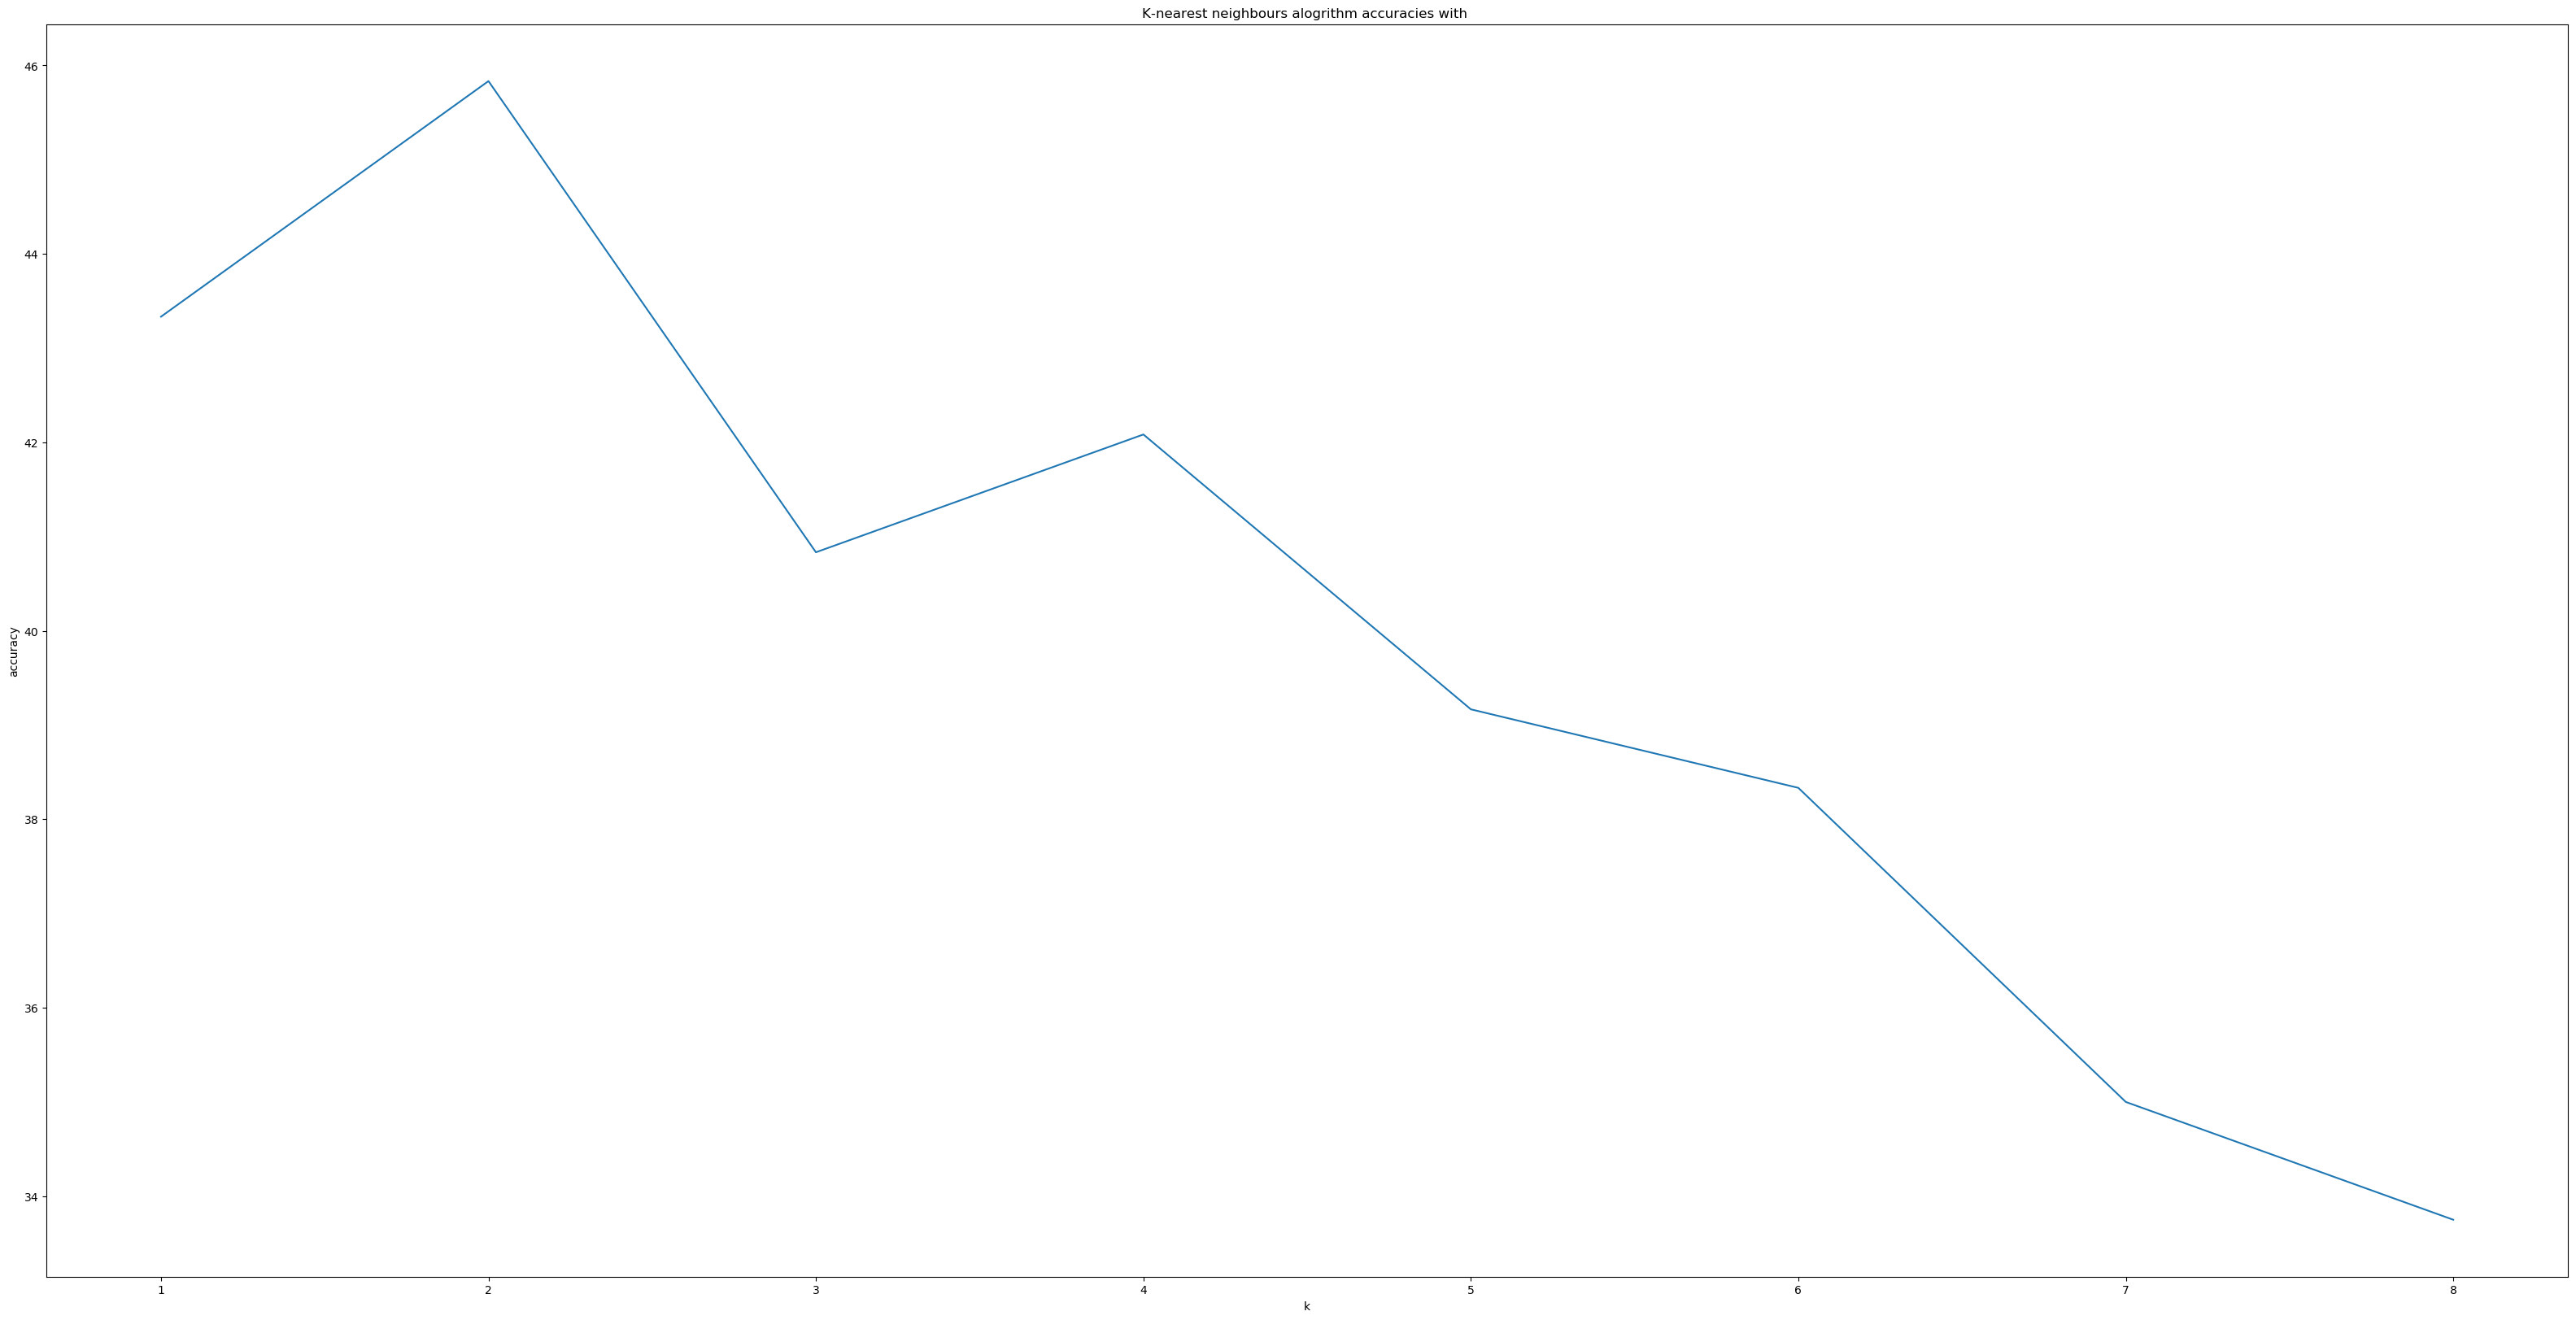

K-nearest neighbours algorithm accuracy: 45.83333333333333
0.3
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'cri

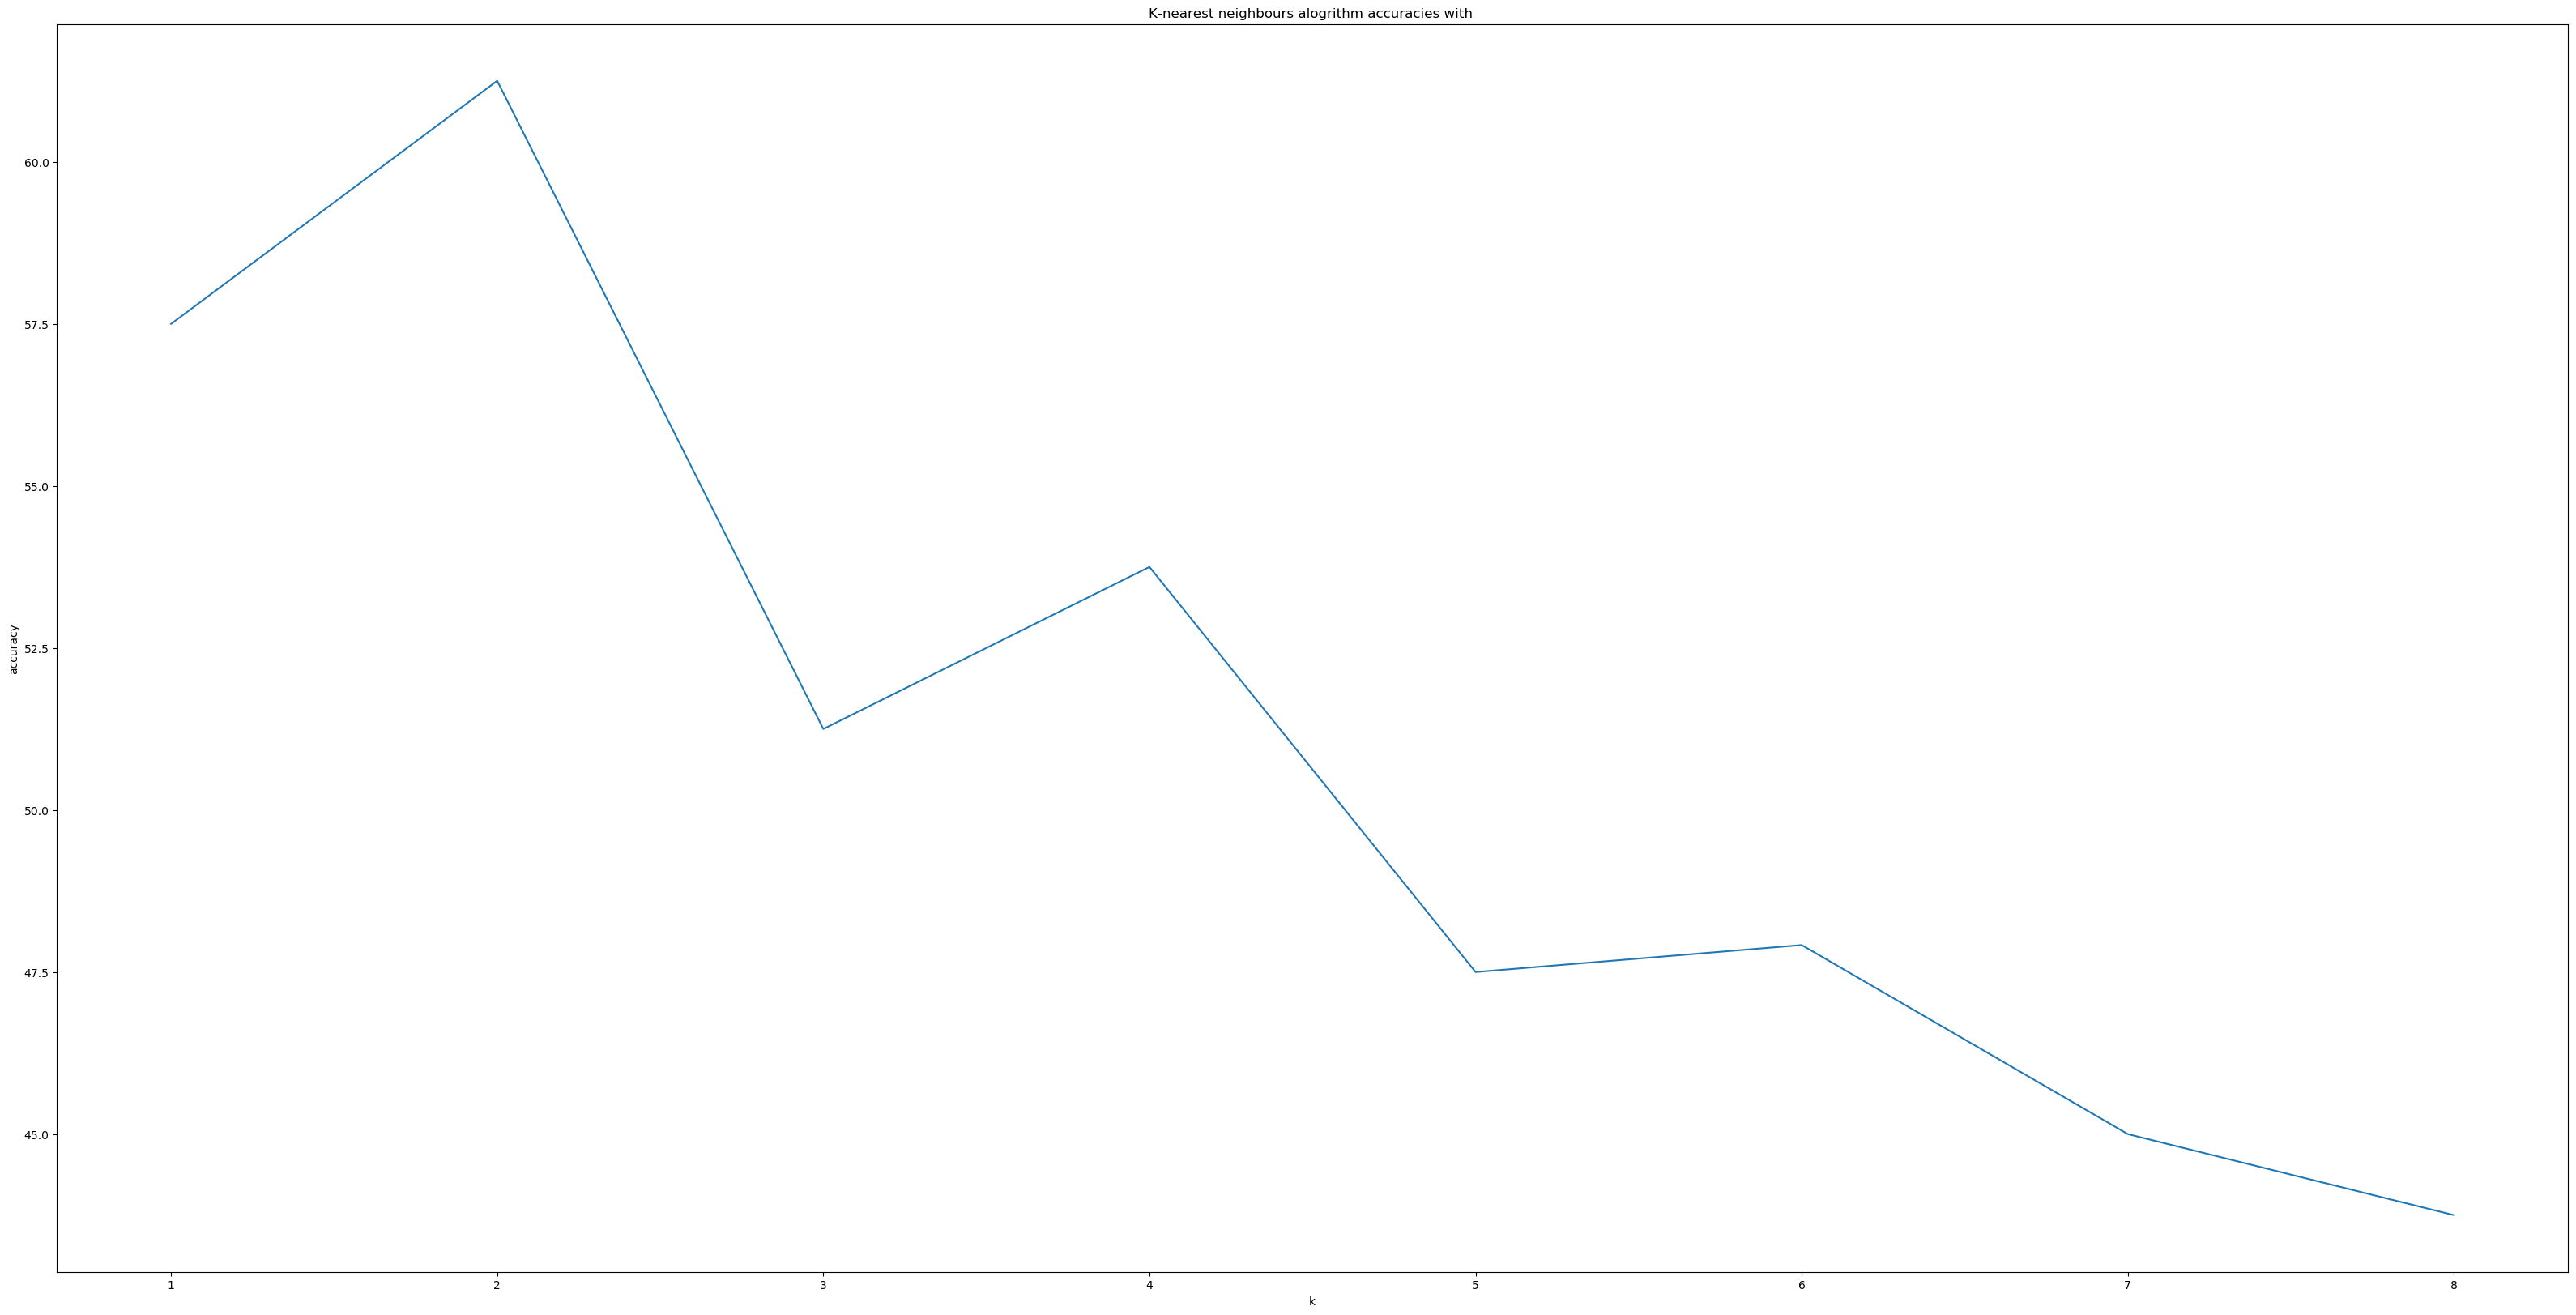

K-nearest neighbours algorithm accuracy: 61.25000000000001
0.4
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   1.4s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   1.4s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   1.4s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'cri

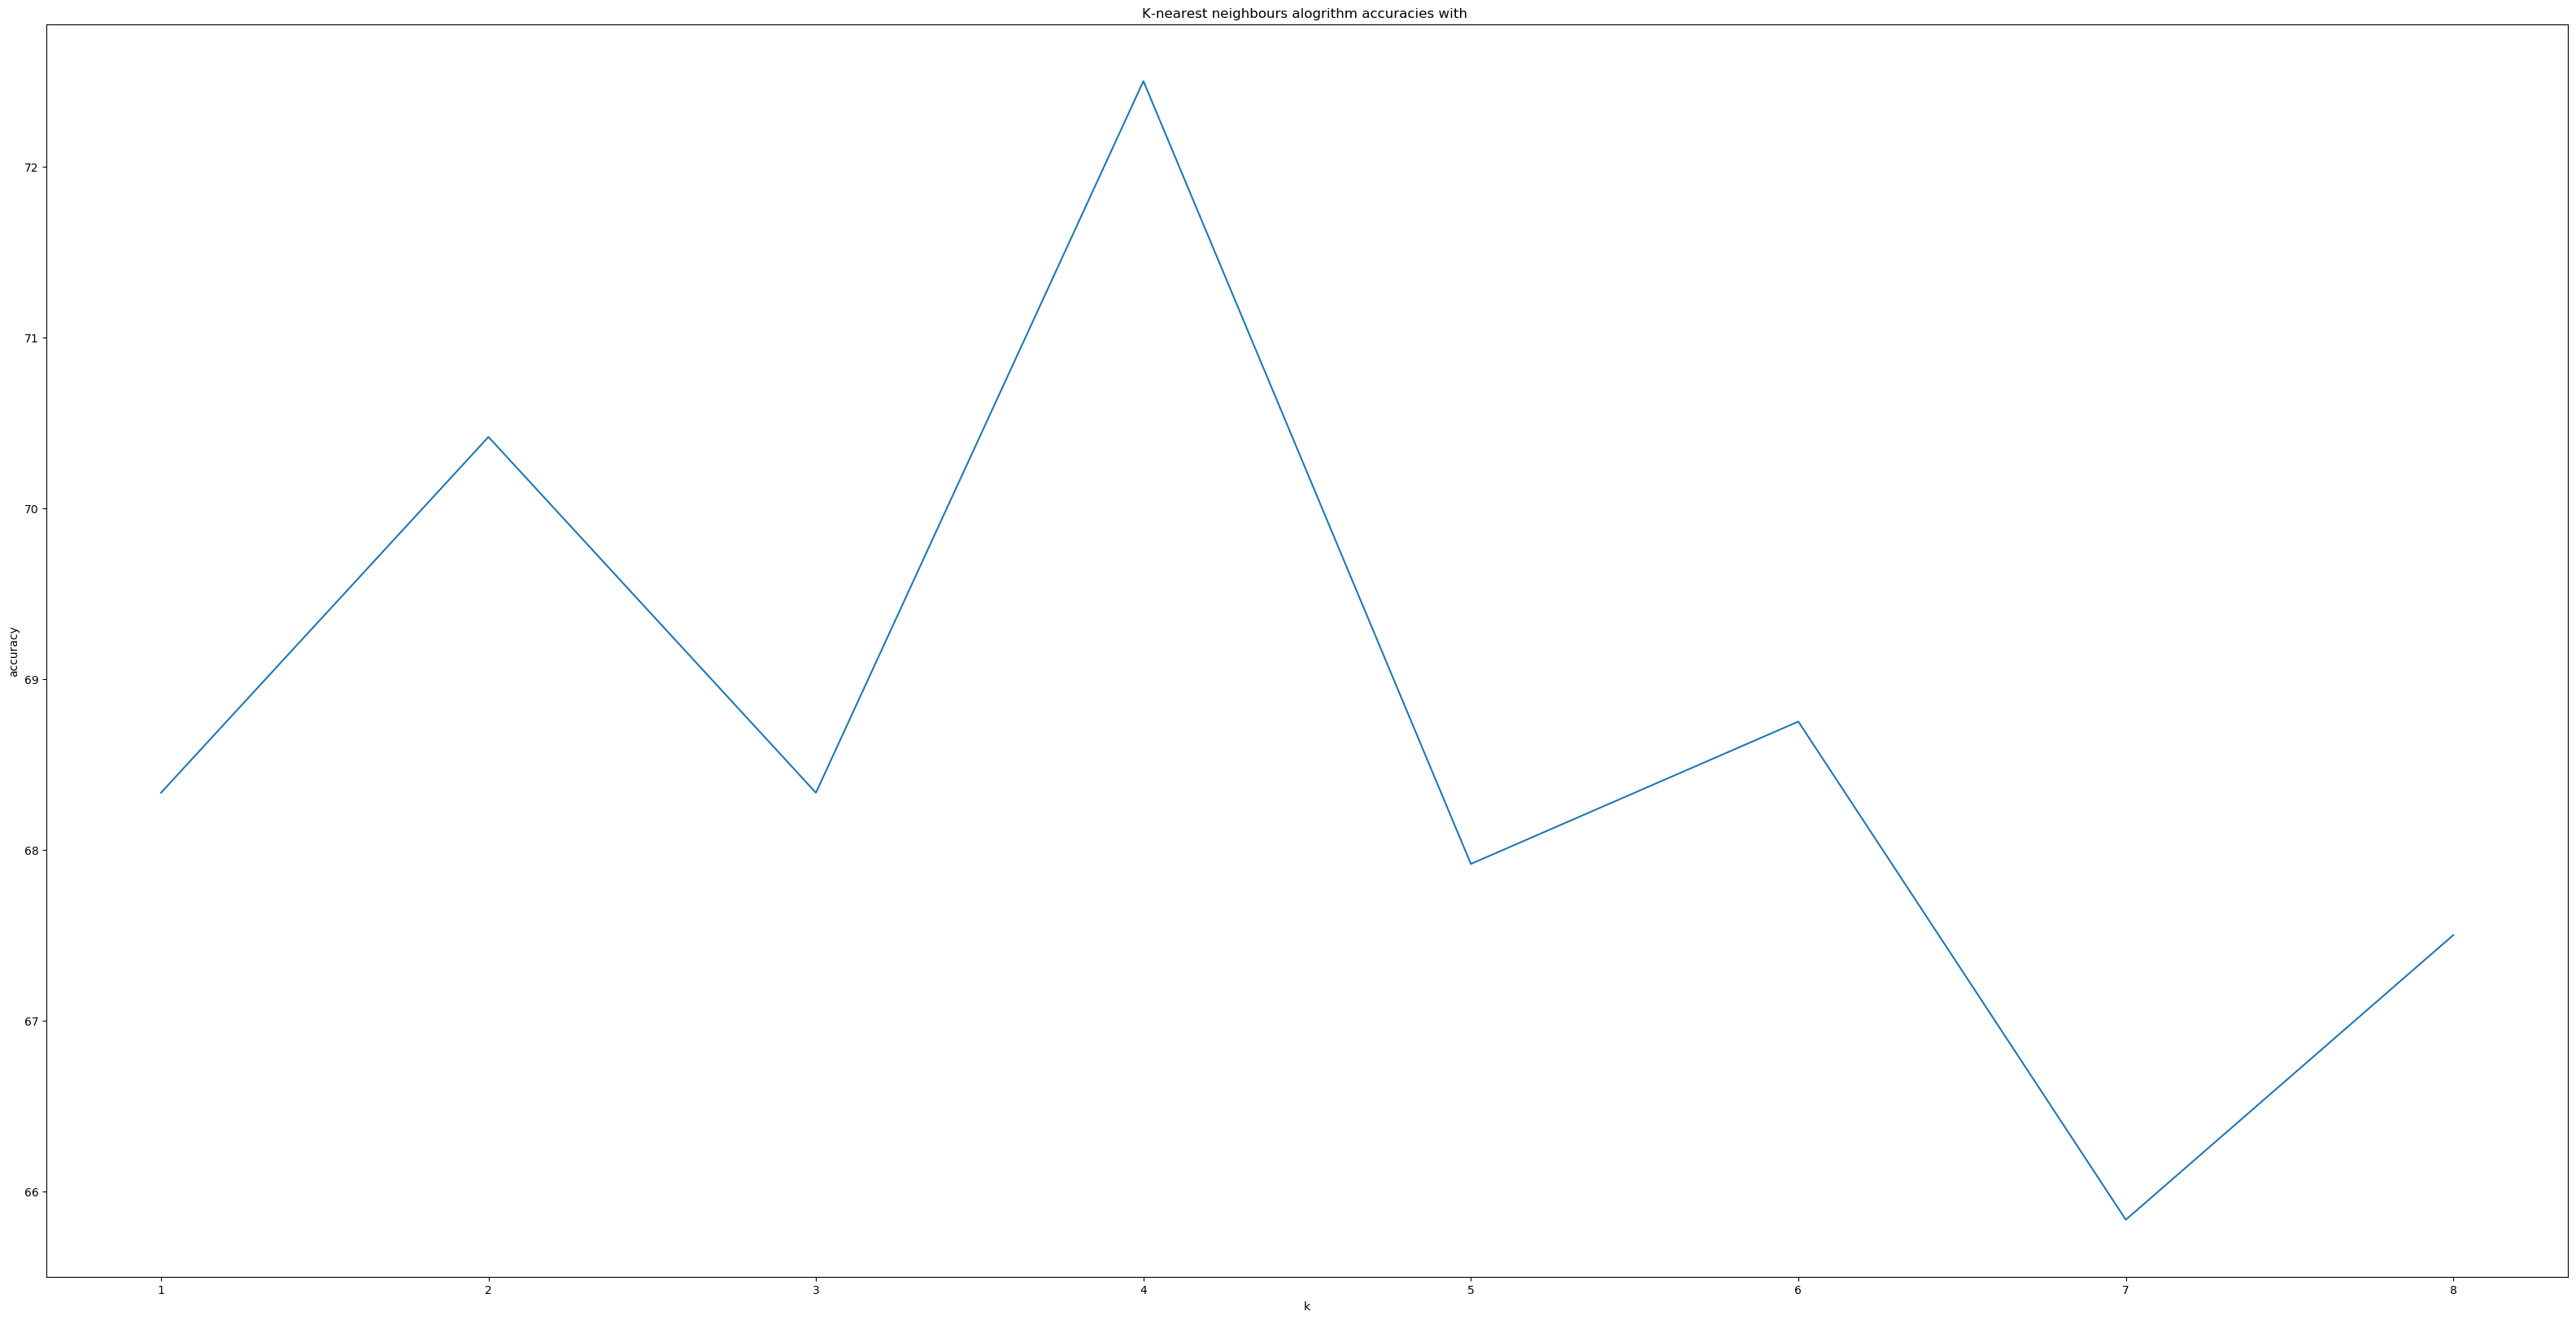

K-nearest neighbours algorithm accuracy: 72.5
0.5
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   1.4s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   1.4s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   1.4s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['en

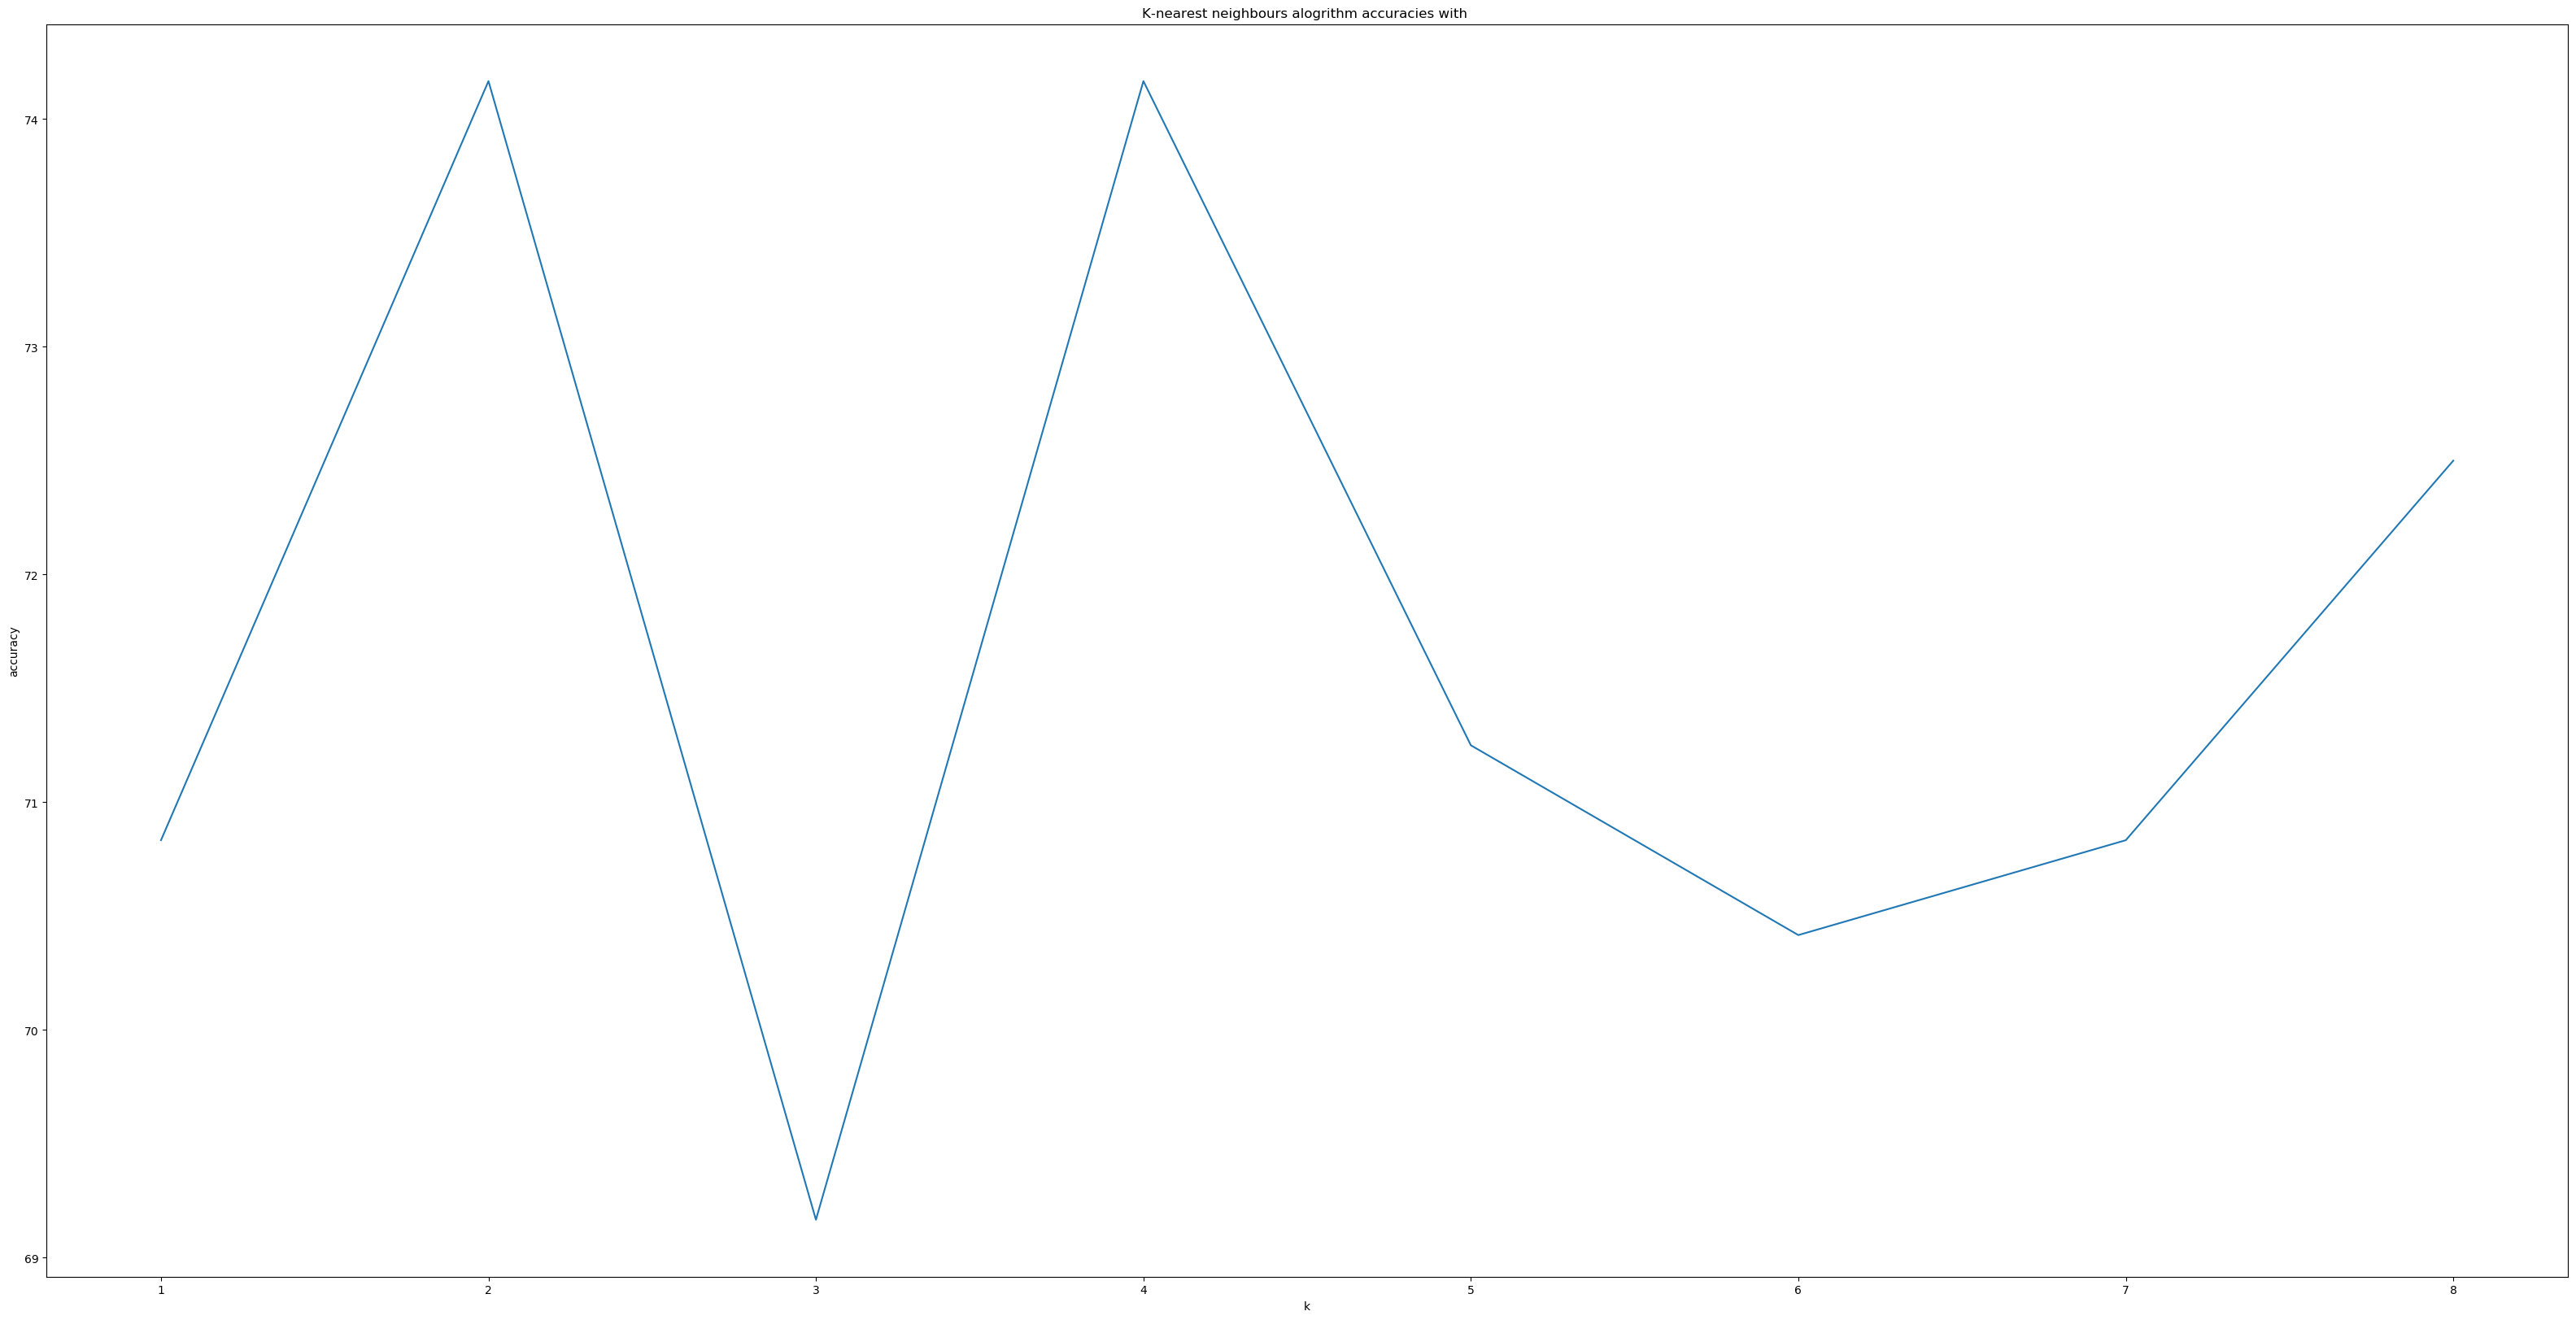

K-nearest neighbours algorithm accuracy: 74.16666666666667
0.6
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   1.4s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   1.4s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   1.4s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'cri

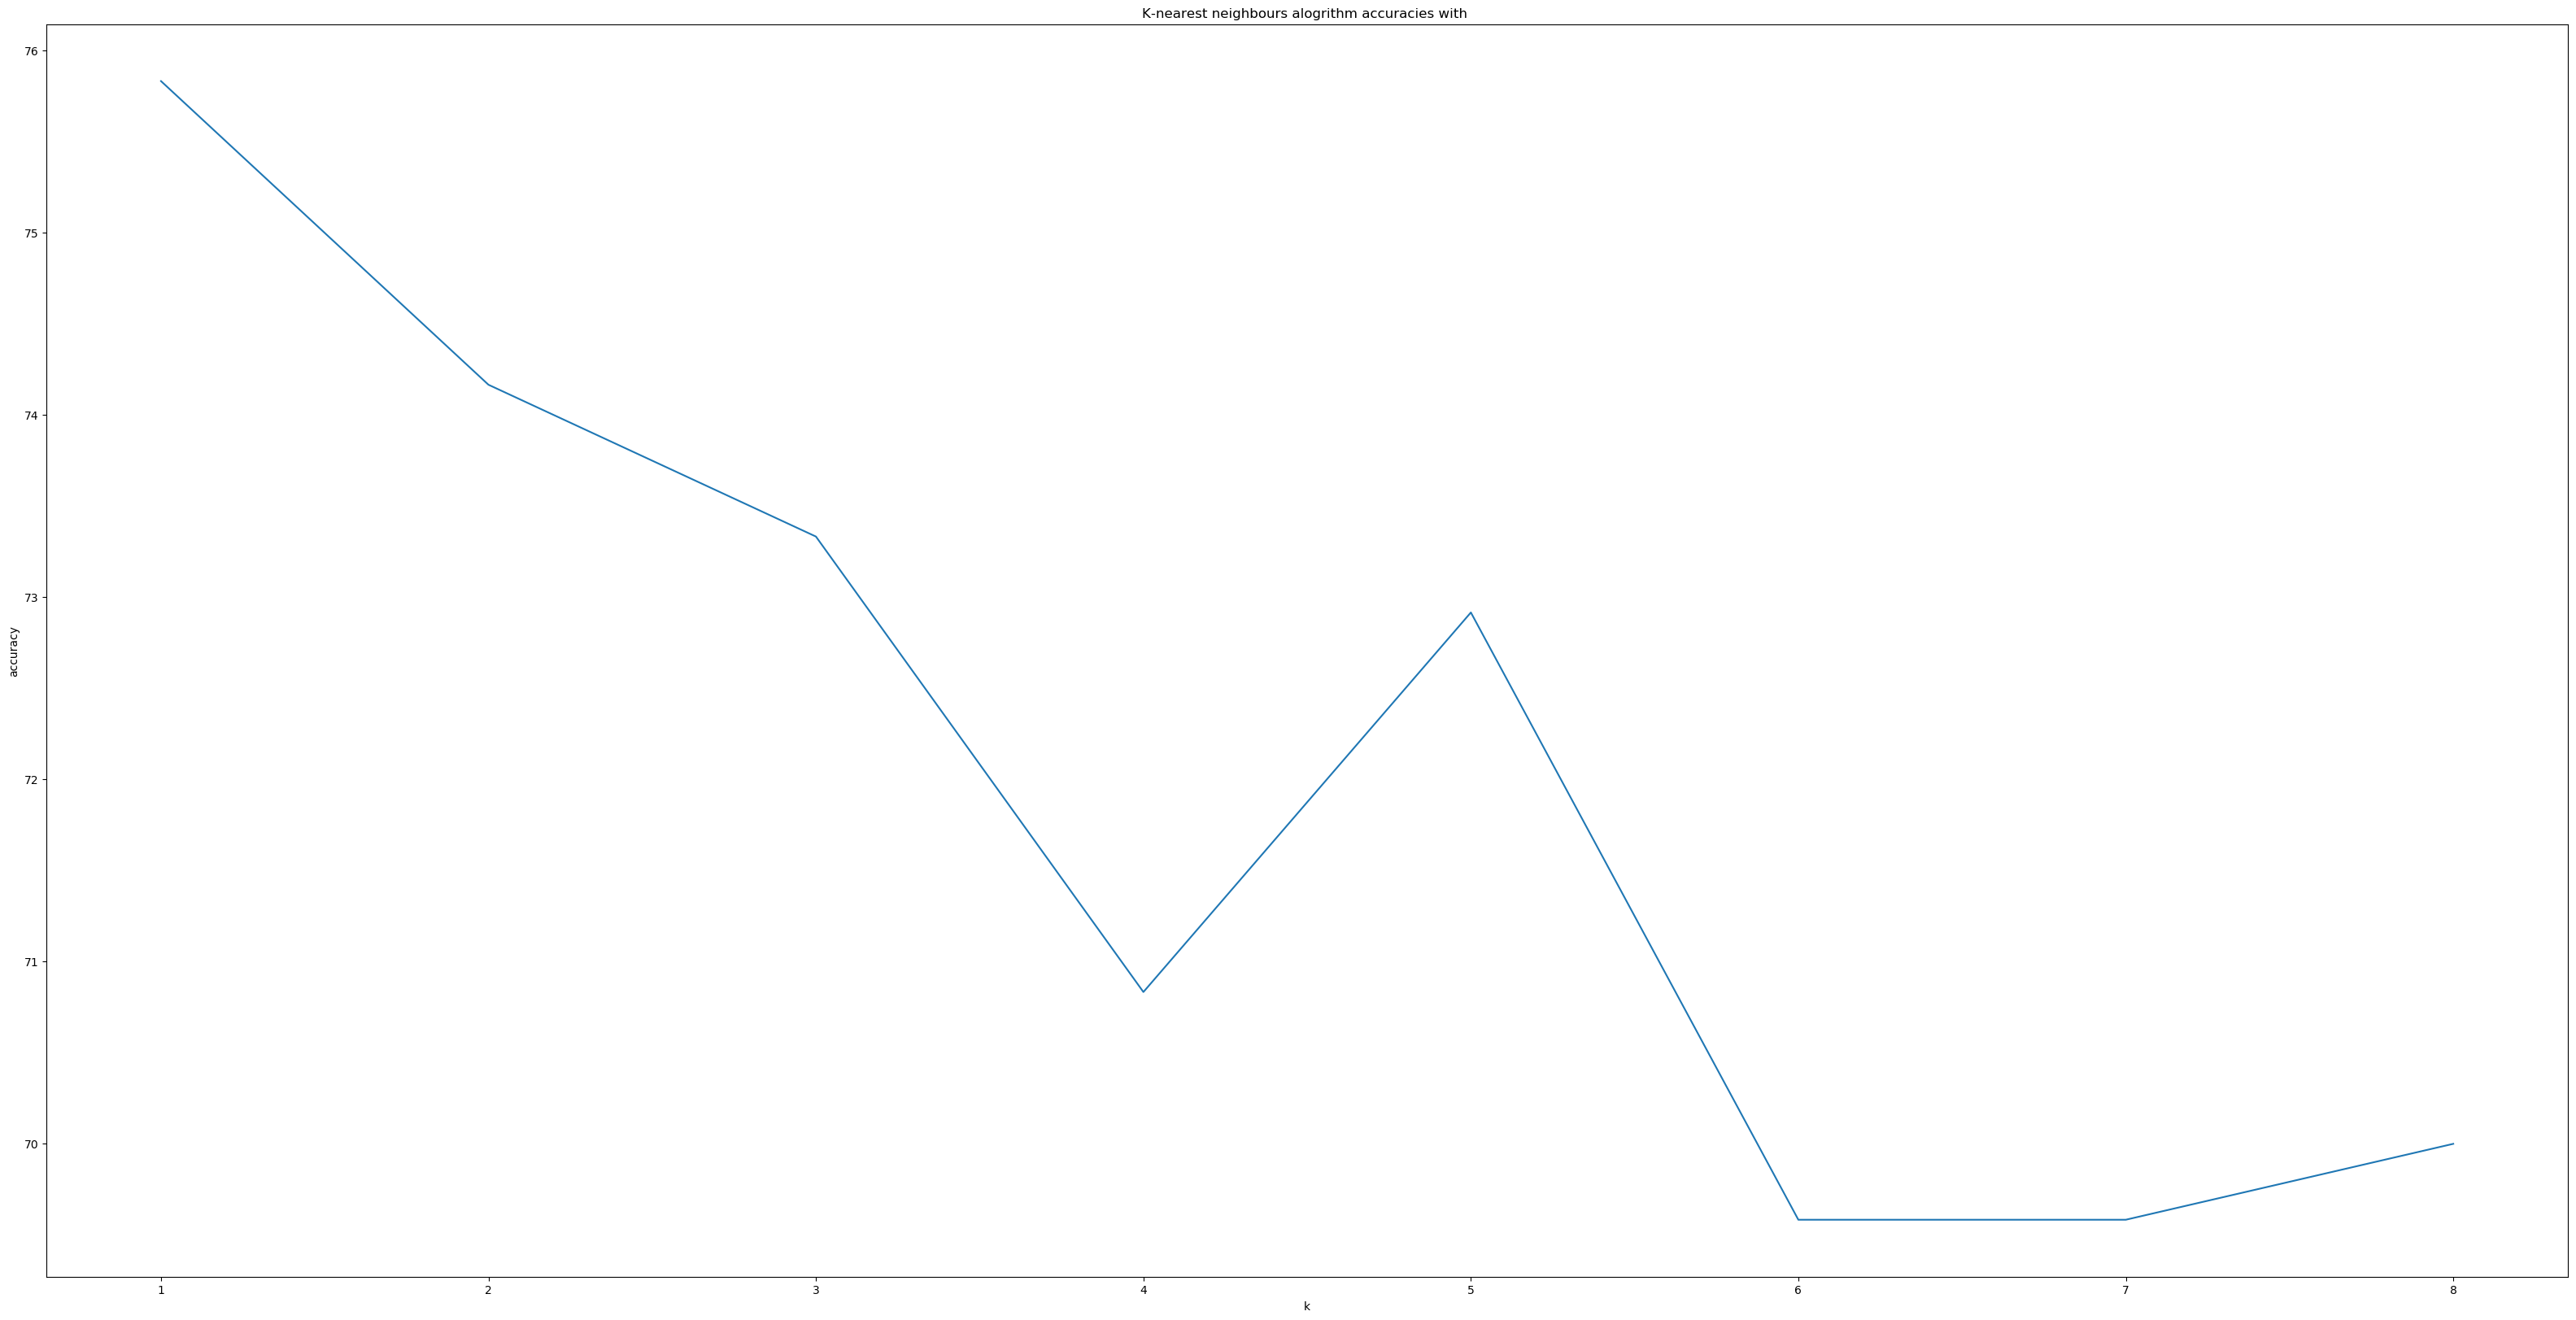

K-nearest neighbours algorithm accuracy: 75.83333333333333
0.7
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.3s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   1.9s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   1.3s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   1.9s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   1.3s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   1.9s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'cri

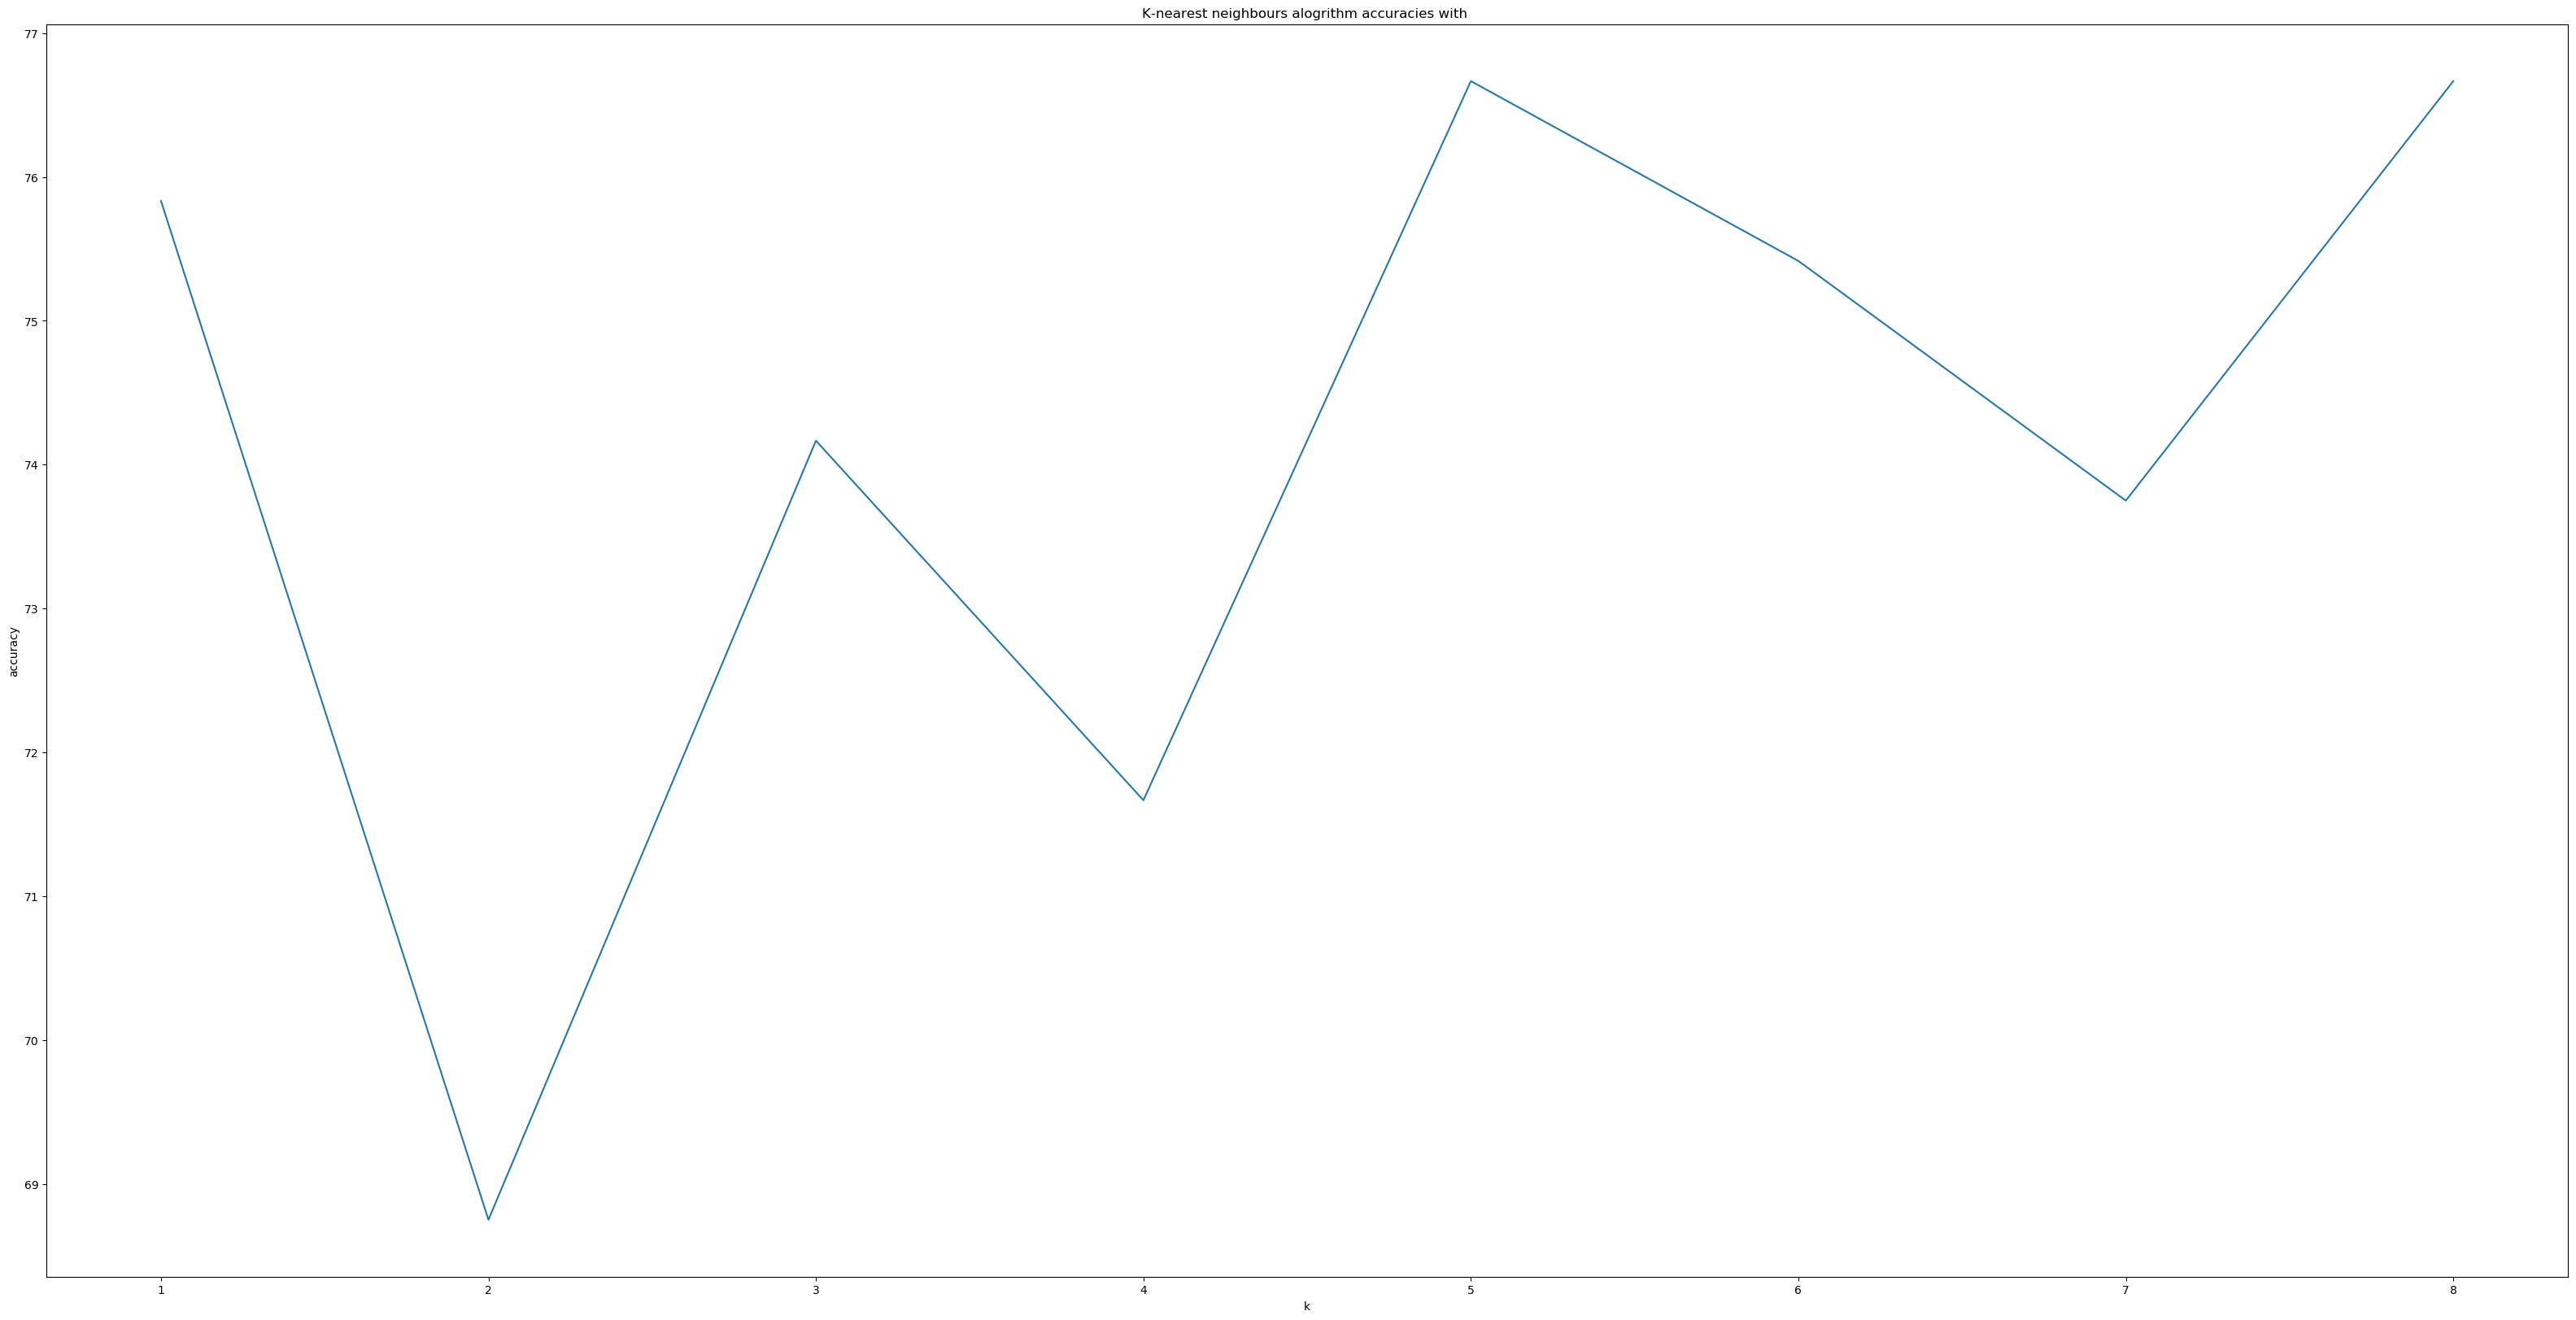

K-nearest neighbours algorithm accuracy: 76.66666666666667
0.8
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.6s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   2.3s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   1.6s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   2.3s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   1.6s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   2.3s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'cri

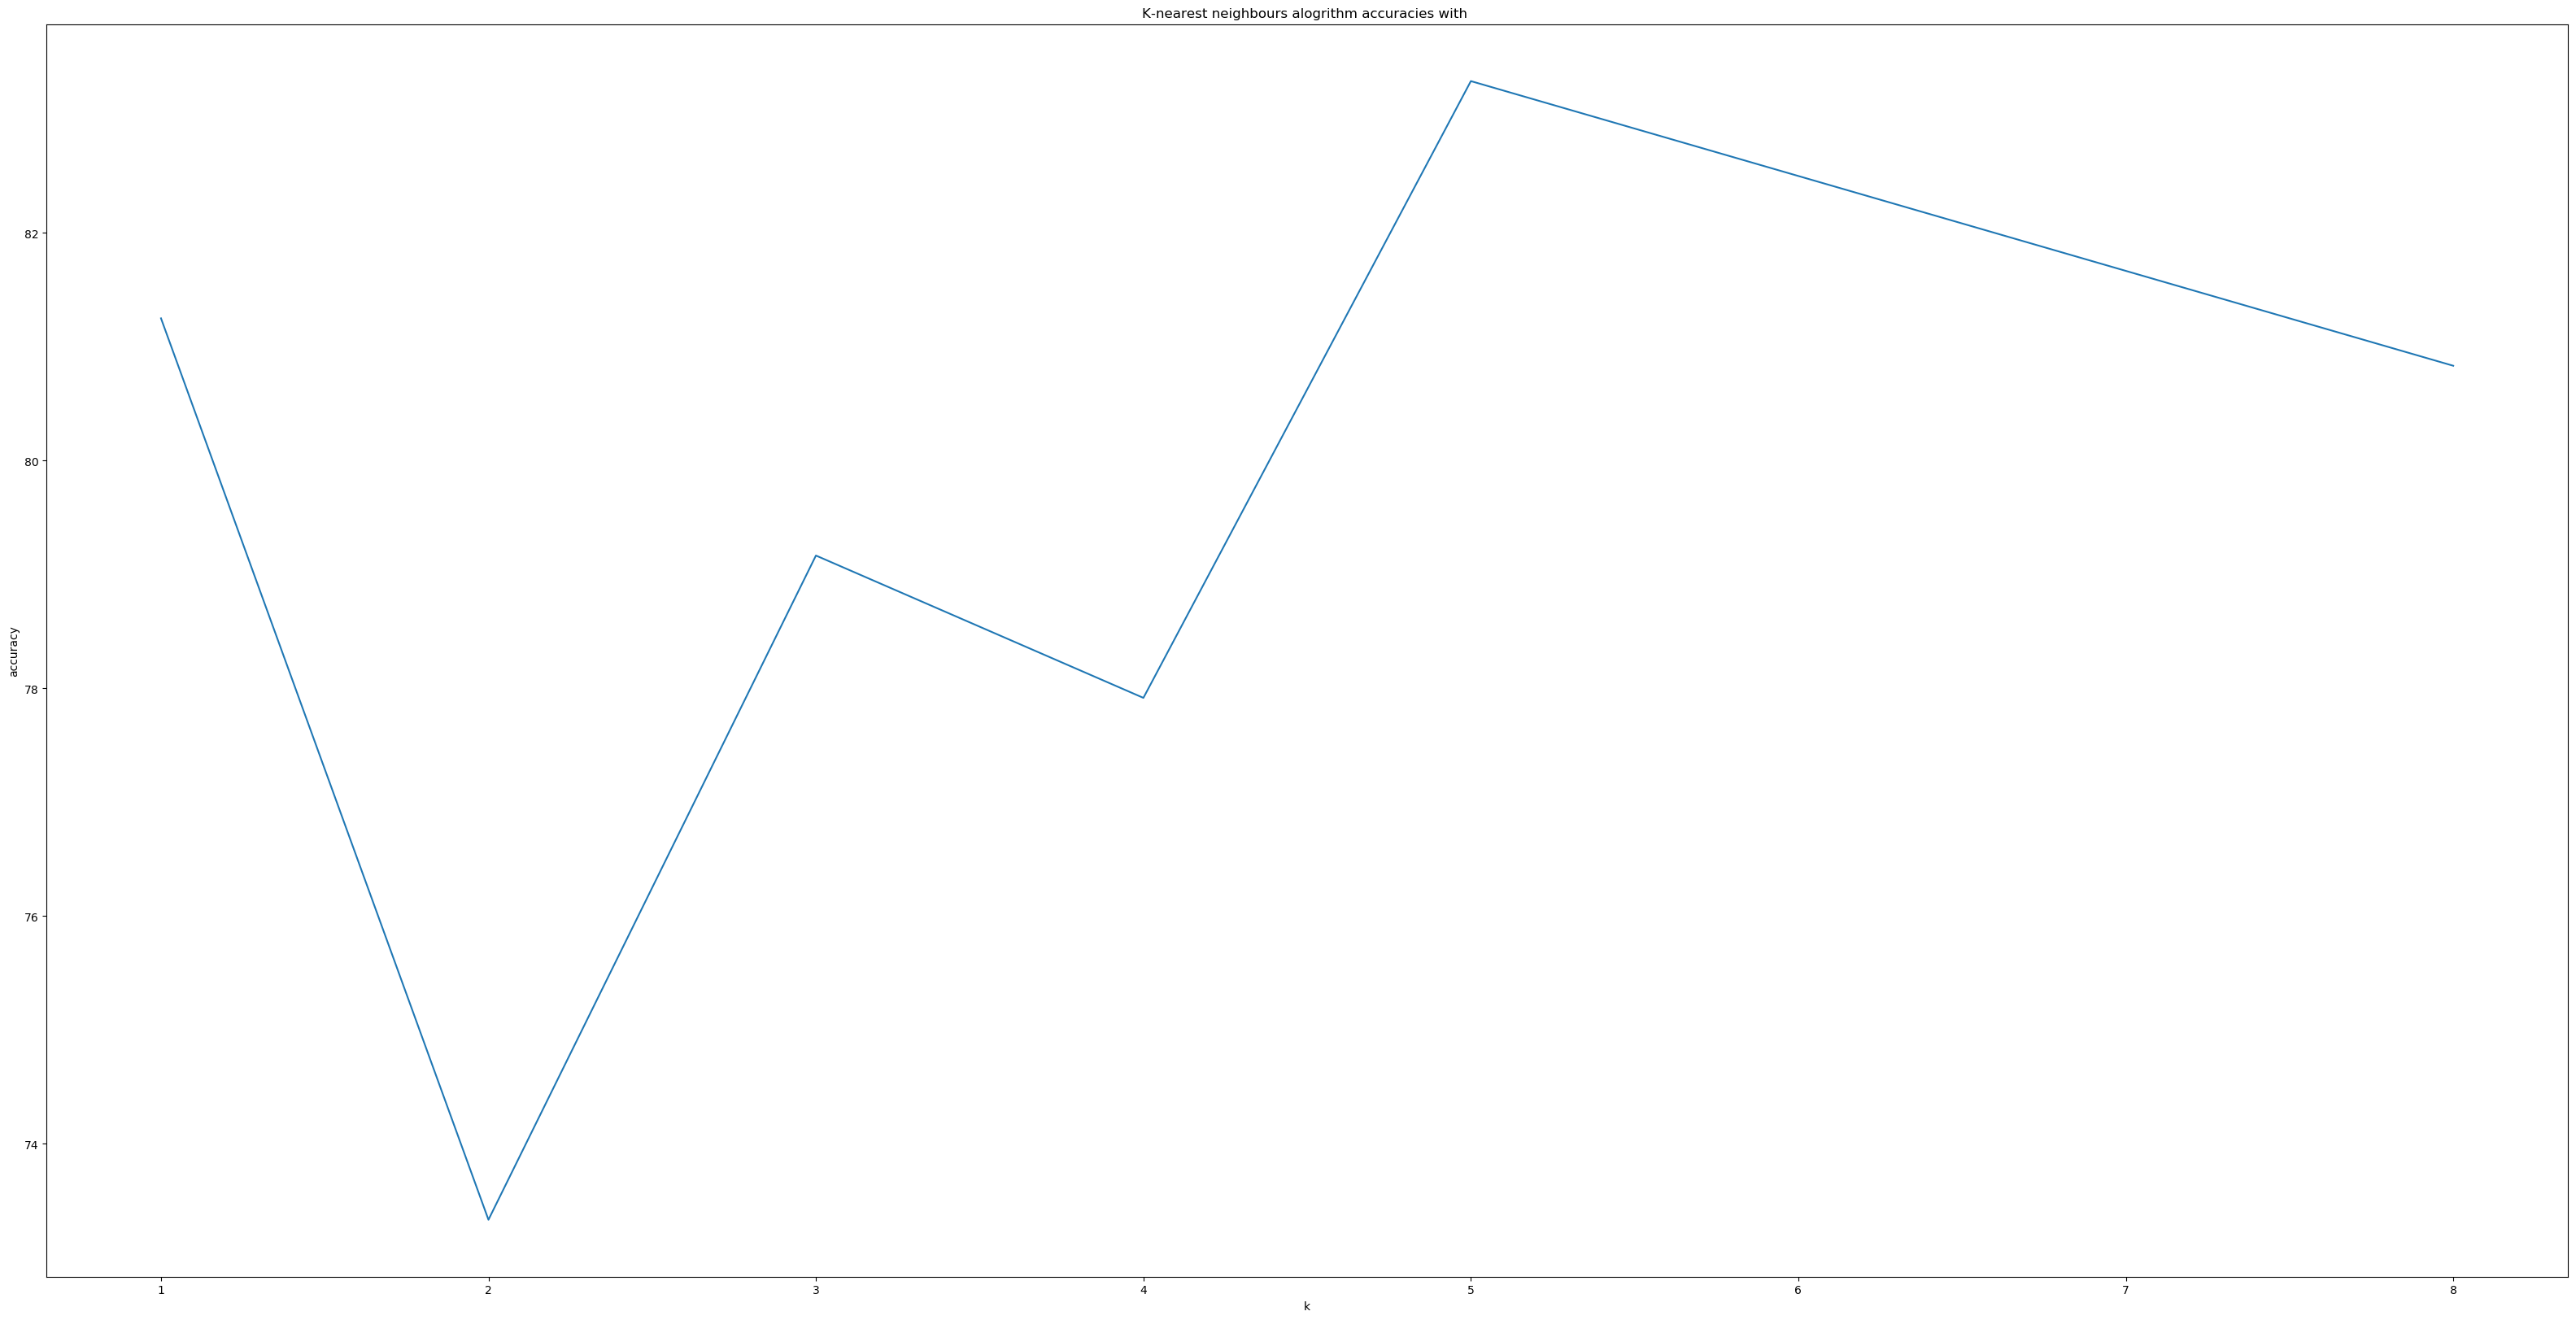

K-nearest neighbours algorithm accuracy: 83.33333333333334
0.9
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   2.0s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   2.7s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   1.9s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   2.8s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   2.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   2.8s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'cri

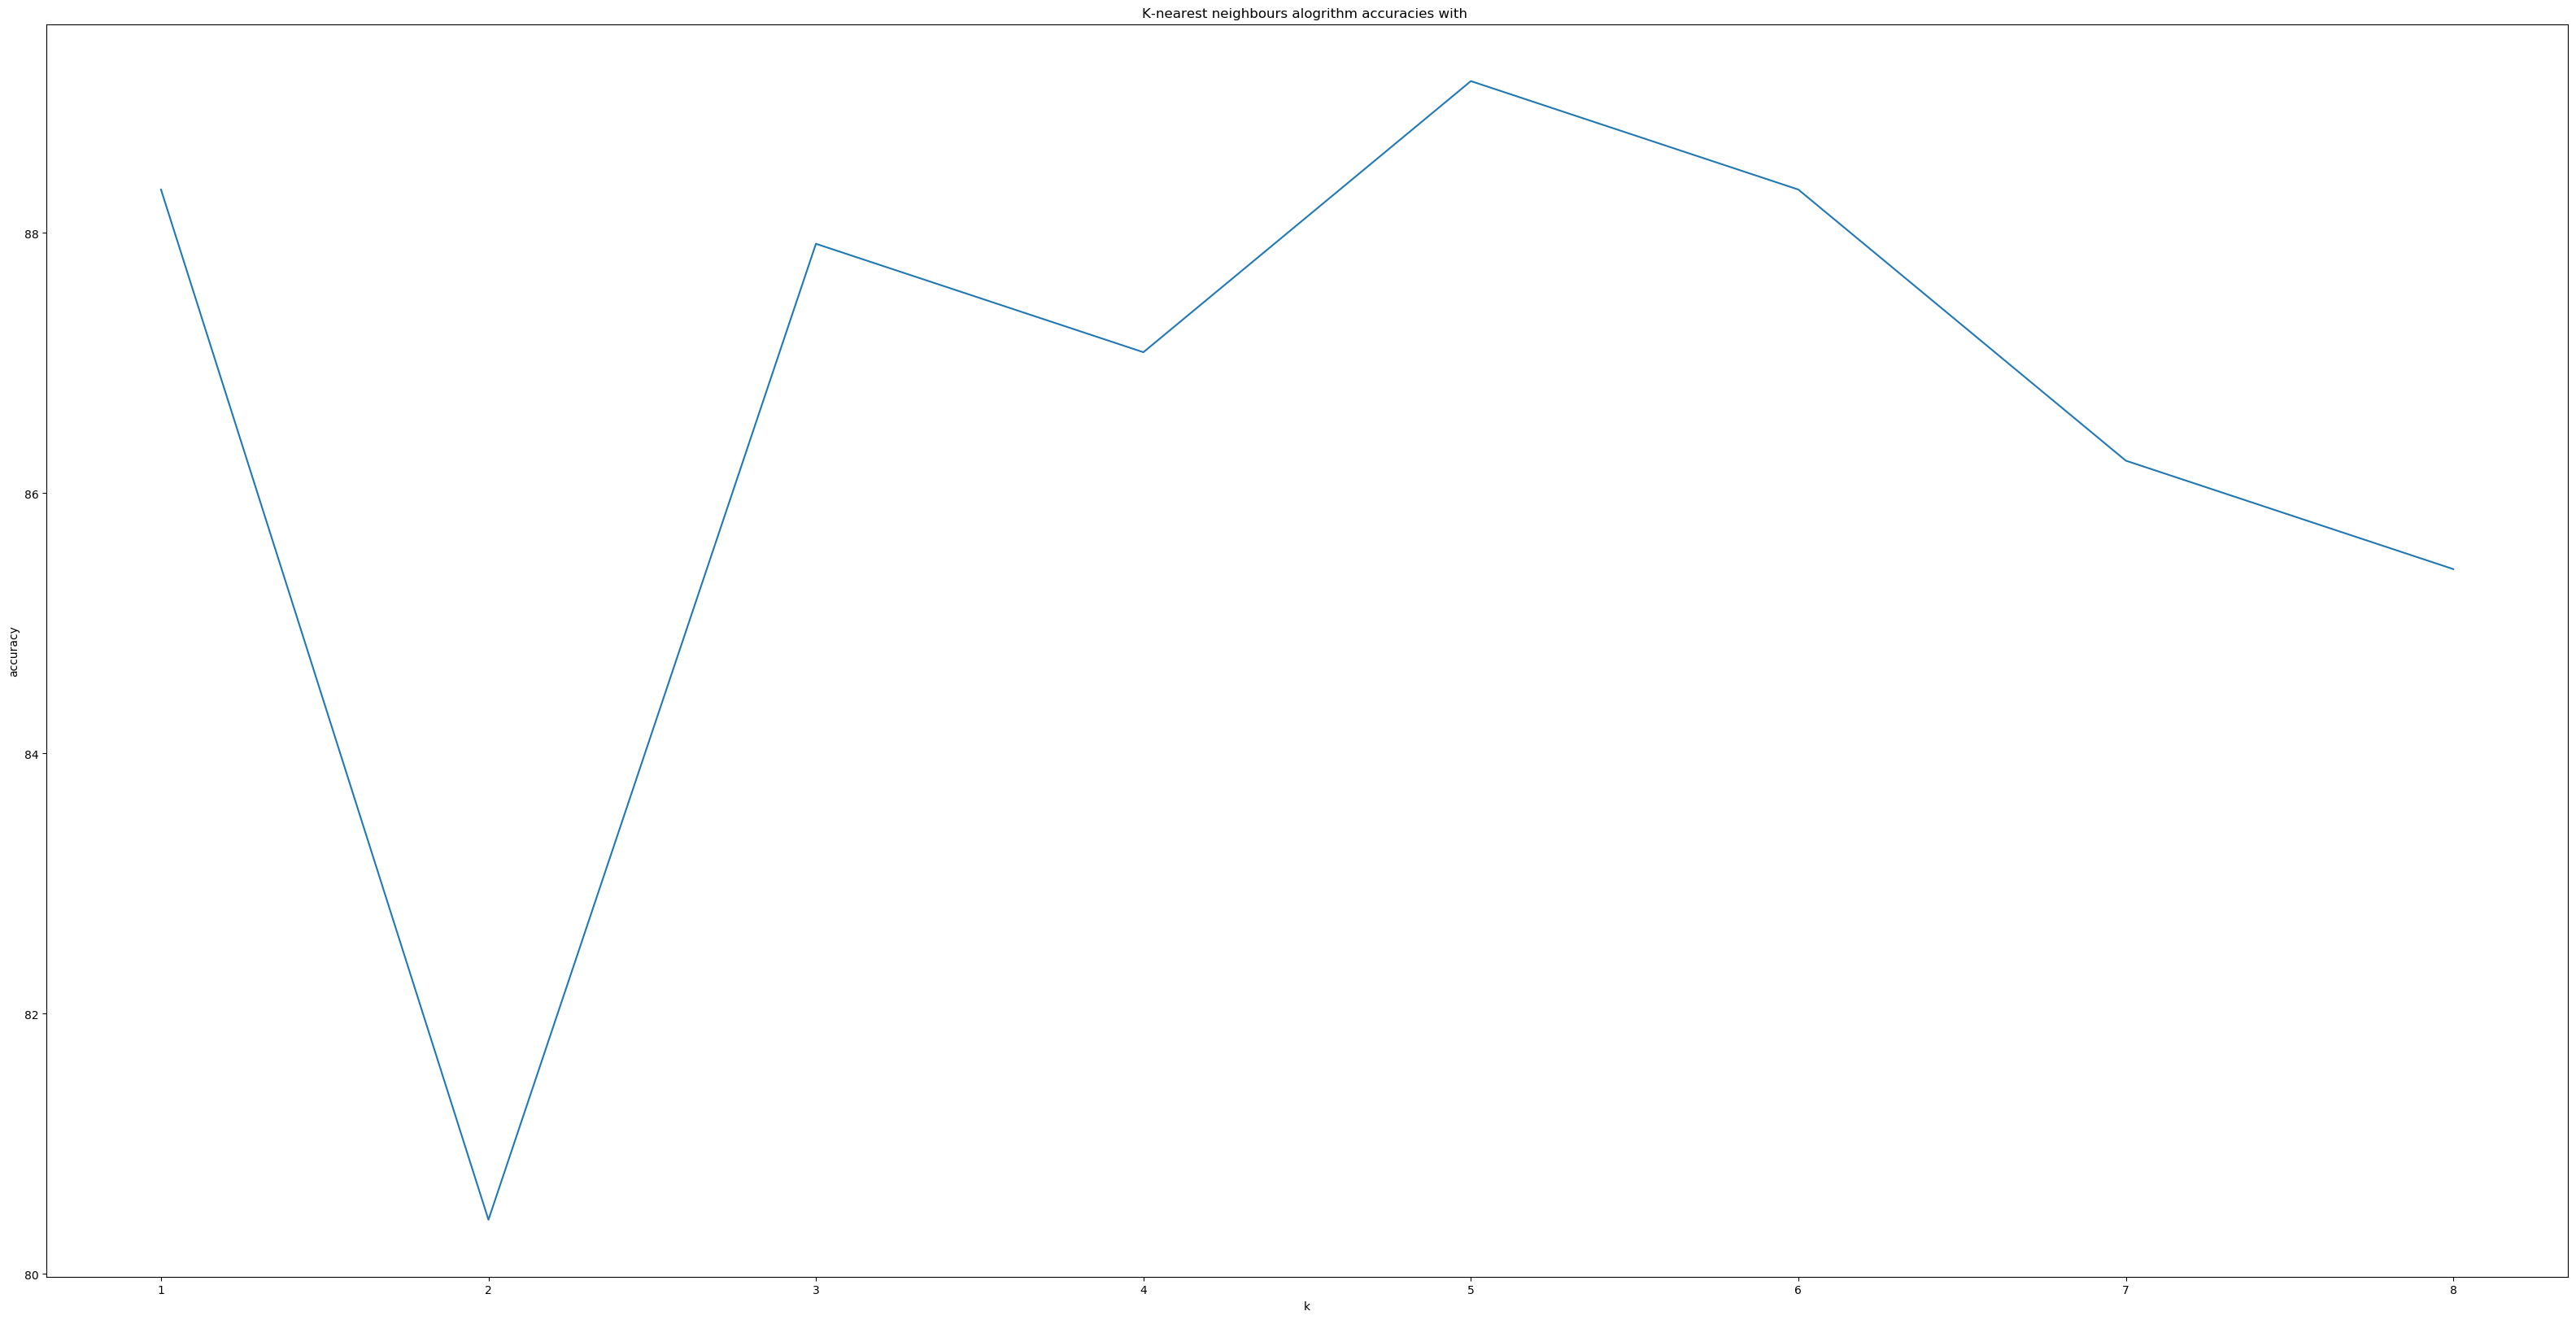

K-nearest neighbours algorithm accuracy: 89.16666666666667


In [567]:
partitions = [0.01,0.03, 0.05, 0.1, 0.2, 0.3,0.4, 0.5,0.6, 0.7,0.8, 0.9]
prediction_accs = []
pred_room_axxs = []
for labeled_percentage in partitions:
    print(labeled_percentage)
    partial_df, partial_locations, partial_df_rest, partial_rest_loc = prep_data_for_synthesis(alpha_filtered2_train, labeled_percentage)
    latent_data = encoder.predict(min_max_scaler.fit_transform(partial_df))
    latent_data = np.concatenate((latent_data[0], latent_data[2]), axis=1)
    latent_test_data = encoder.predict(min_max_scaler.fit_transform(partial_df_rest))
    latent_test_data = np.concatenate((latent_test_data[0], latent_test_data[2]), axis=1)
    
    rfc_semi2 = RandomForestClassifier()
    forest_semi_params = [{'criterion': ["entropy"], 'max_depth':[10,12,15], 'max_features': [10,15,20]}]
    semi_clf2 = GridSearchCV(rfc_semi2, forest_semi_params,cv = [(slice(None), slice(None))], scoring='accuracy',refit=True,verbose=2)
    print(semi_clf2.fit(latent_data, partial_locations))
    unlabeled_data_labels = semi_clf2.predict(latent_test_data)
#     rfc_semi2 = RandomForestClassifier(criterion='entropy', max_depth=11, max_features=5)
#     print(rfc_semi2.fit(latent_data, partial_locations))
#     unlabeled_data_labels = rfc_semi2.predict(latent_test_data)
       
    frames = [partial_df, partial_df_rest]
    partial_combined = pd.concat(frames)
    
    frames = [partial_locations, pd.DataFrame(unlabeled_data_labels, columns = ['location'])]
    partial_combined_labels = pd.concat(frames)
    k_nearest_neighbours(partial_combined, partial_combined_labels, alpha_filtered2_test.loc[:, no_channel_training_cols],alpha_filtered2_test.loc[:, 'location'], "")
    partial_preds,runtime = run_knn(partial_combined, partial_combined_labels, alpha_filtered2_test.loc[:, no_channel_training_cols],[],5)
    
#     rfc_semi_part = RandomForestClassifier()
#     forest_semi_params = [{'criterion': ["entropy"], 'max_depth':[10,12,15,20], 'max_features': [4,5,8]}]
#     semi_clf = GridSearchCV(rfc_semi_part, forest_semi_params, cv = 3, scoring='accuracy',refit=True,verbose=2)
#     print(semi_clf.fit(partial_combined, partial_combined_labels))

#     partial_preds = semi_clf.predict(alpha_filtered2_test.loc[:, no_channel_training_cols])
    prediction_accs.append(accuracy_score(alpha_filtered2_test.loc[:, ['location']], partial_preds)*100)
    
    room_lev_atarget = []
    for i in alpha_filtered2_test.loc[:, ['location']].to_numpy():
        room_lev_atarget.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
        
    room_lev_test_semi = []
    for i in partial_preds:
        room_lev_test_semi.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
    
    pred_room_axxs.append(accuracy_score(room_lev_atarget, room_lev_test_semi)*100)
    

In [568]:
prediction_accs

[10.416666666666668,
 15.416666666666668,
 24.583333333333332,
 27.083333333333332,
 39.166666666666664,
 47.5,
 67.91666666666667,
 71.25,
 72.91666666666666,
 76.66666666666667,
 83.33333333333334,
 89.16666666666667]

In [569]:
def plot_accs(original_accs, vae_accs, title):
    t = list(original_accs.keys())
    k = list(original_accs.values())
    k.reverse()

    f = vae_accs
    f.reverse()
    print(k)
    print(f)
    signals = [{'name': 'original_accuracies', 'x': t,
             'y': k, 'color':'orange', 'linewidth':6},
            {'name': 'Semi-supervised_accuracies', 'x': t,
             'y': f, 'color':'green', 'linewidth':6}]

    fig, ax = plt.subplots()
    for signal in signals:
        ax.plot(signal['x'], signal['y'], 
                color=signal['color'], 
                linewidth=signal['linewidth'],
                label=signal['name'])
    plt.rcParams['figure.figsize'] = [40, 20]
    ax.legend()
    ax.set_title(title)
    plt.show()

[90.41666666666667, 87.08333333333333, 83.33333333333334, 78.75, 81.66666666666667, 81.66666666666667, 72.08333333333333, 60.416666666666664, 28.333333333333332, 5.0, 2.083333333333333, 2.083333333333333]
[89.16666666666667, 83.33333333333334, 76.66666666666667, 72.91666666666666, 71.25, 67.91666666666667, 47.5, 39.166666666666664, 27.083333333333332, 24.583333333333332, 15.416666666666668, 10.416666666666668]


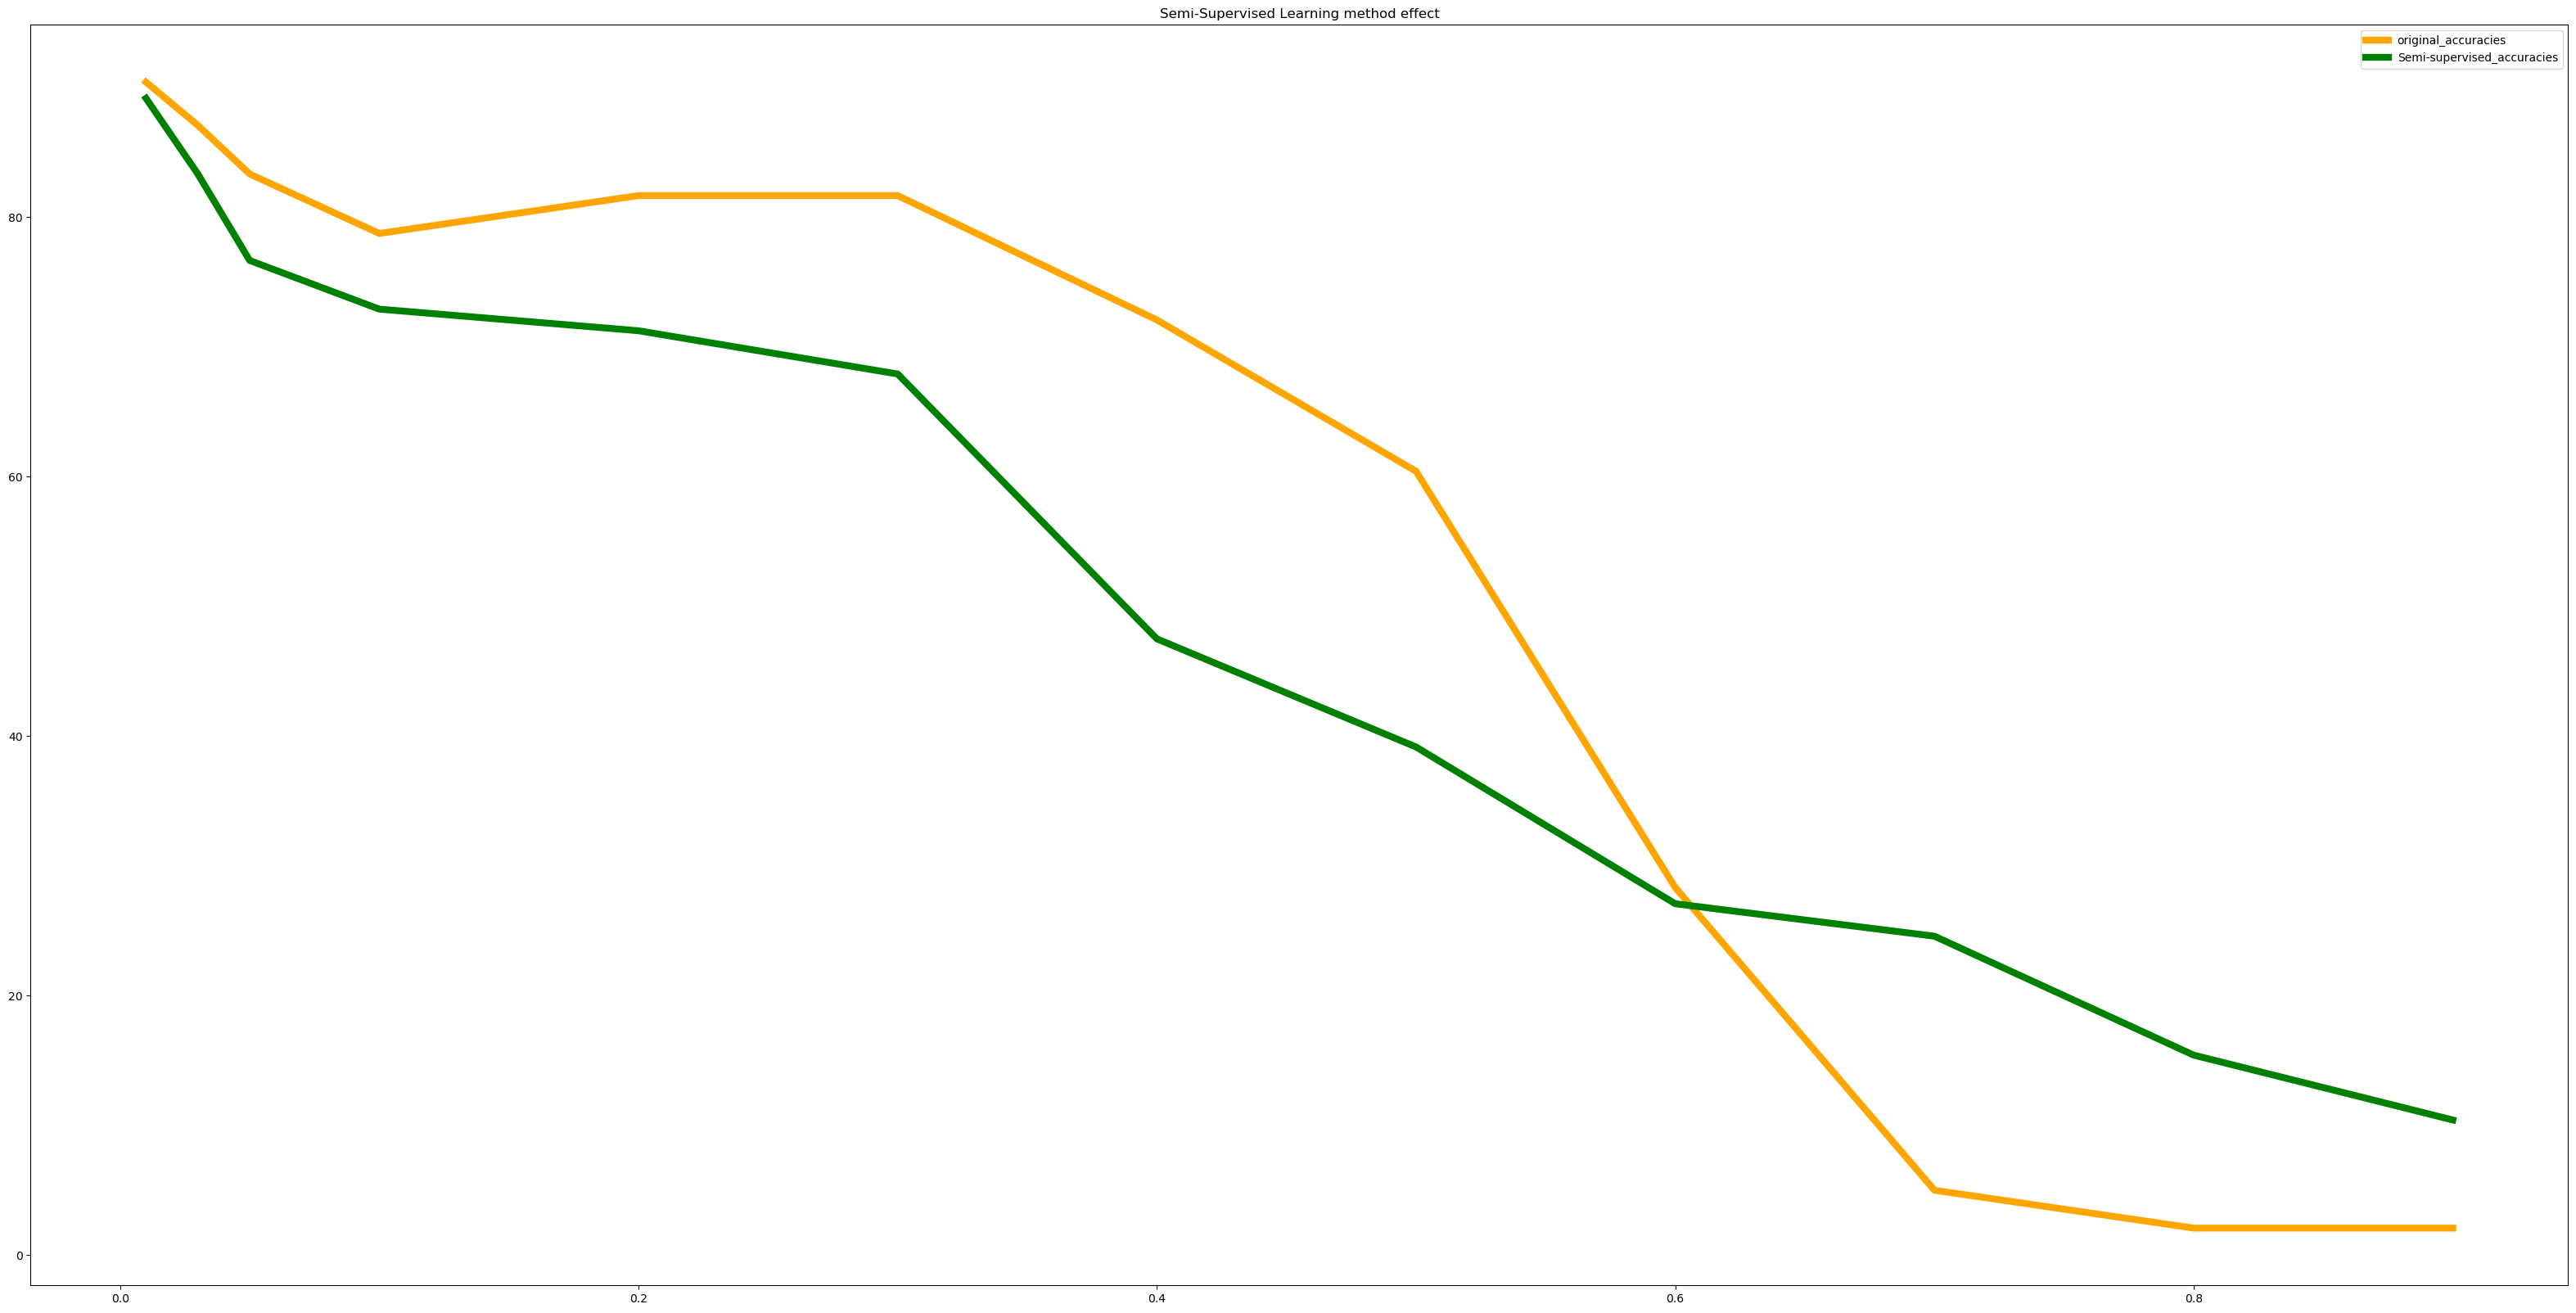

In [570]:
plot_accs(original_accs2, prediction_accs,"Semi-Supervised Learning method effect")

[99.16666666666667, 99.16666666666667, 99.16666666666667, 98.33333333333333, 99.16666666666667, 99.16666666666667, 98.33333333333333, 92.08333333333333, 86.66666666666667, 55.41666666666667, 44.583333333333336, 20.416666666666668]
[100.0, 98.75, 99.58333333333333, 98.75, 96.66666666666667, 92.91666666666667, 88.33333333333333, 80.83333333333333, 78.33333333333333, 76.66666666666667, 67.91666666666667, 60.416666666666664]


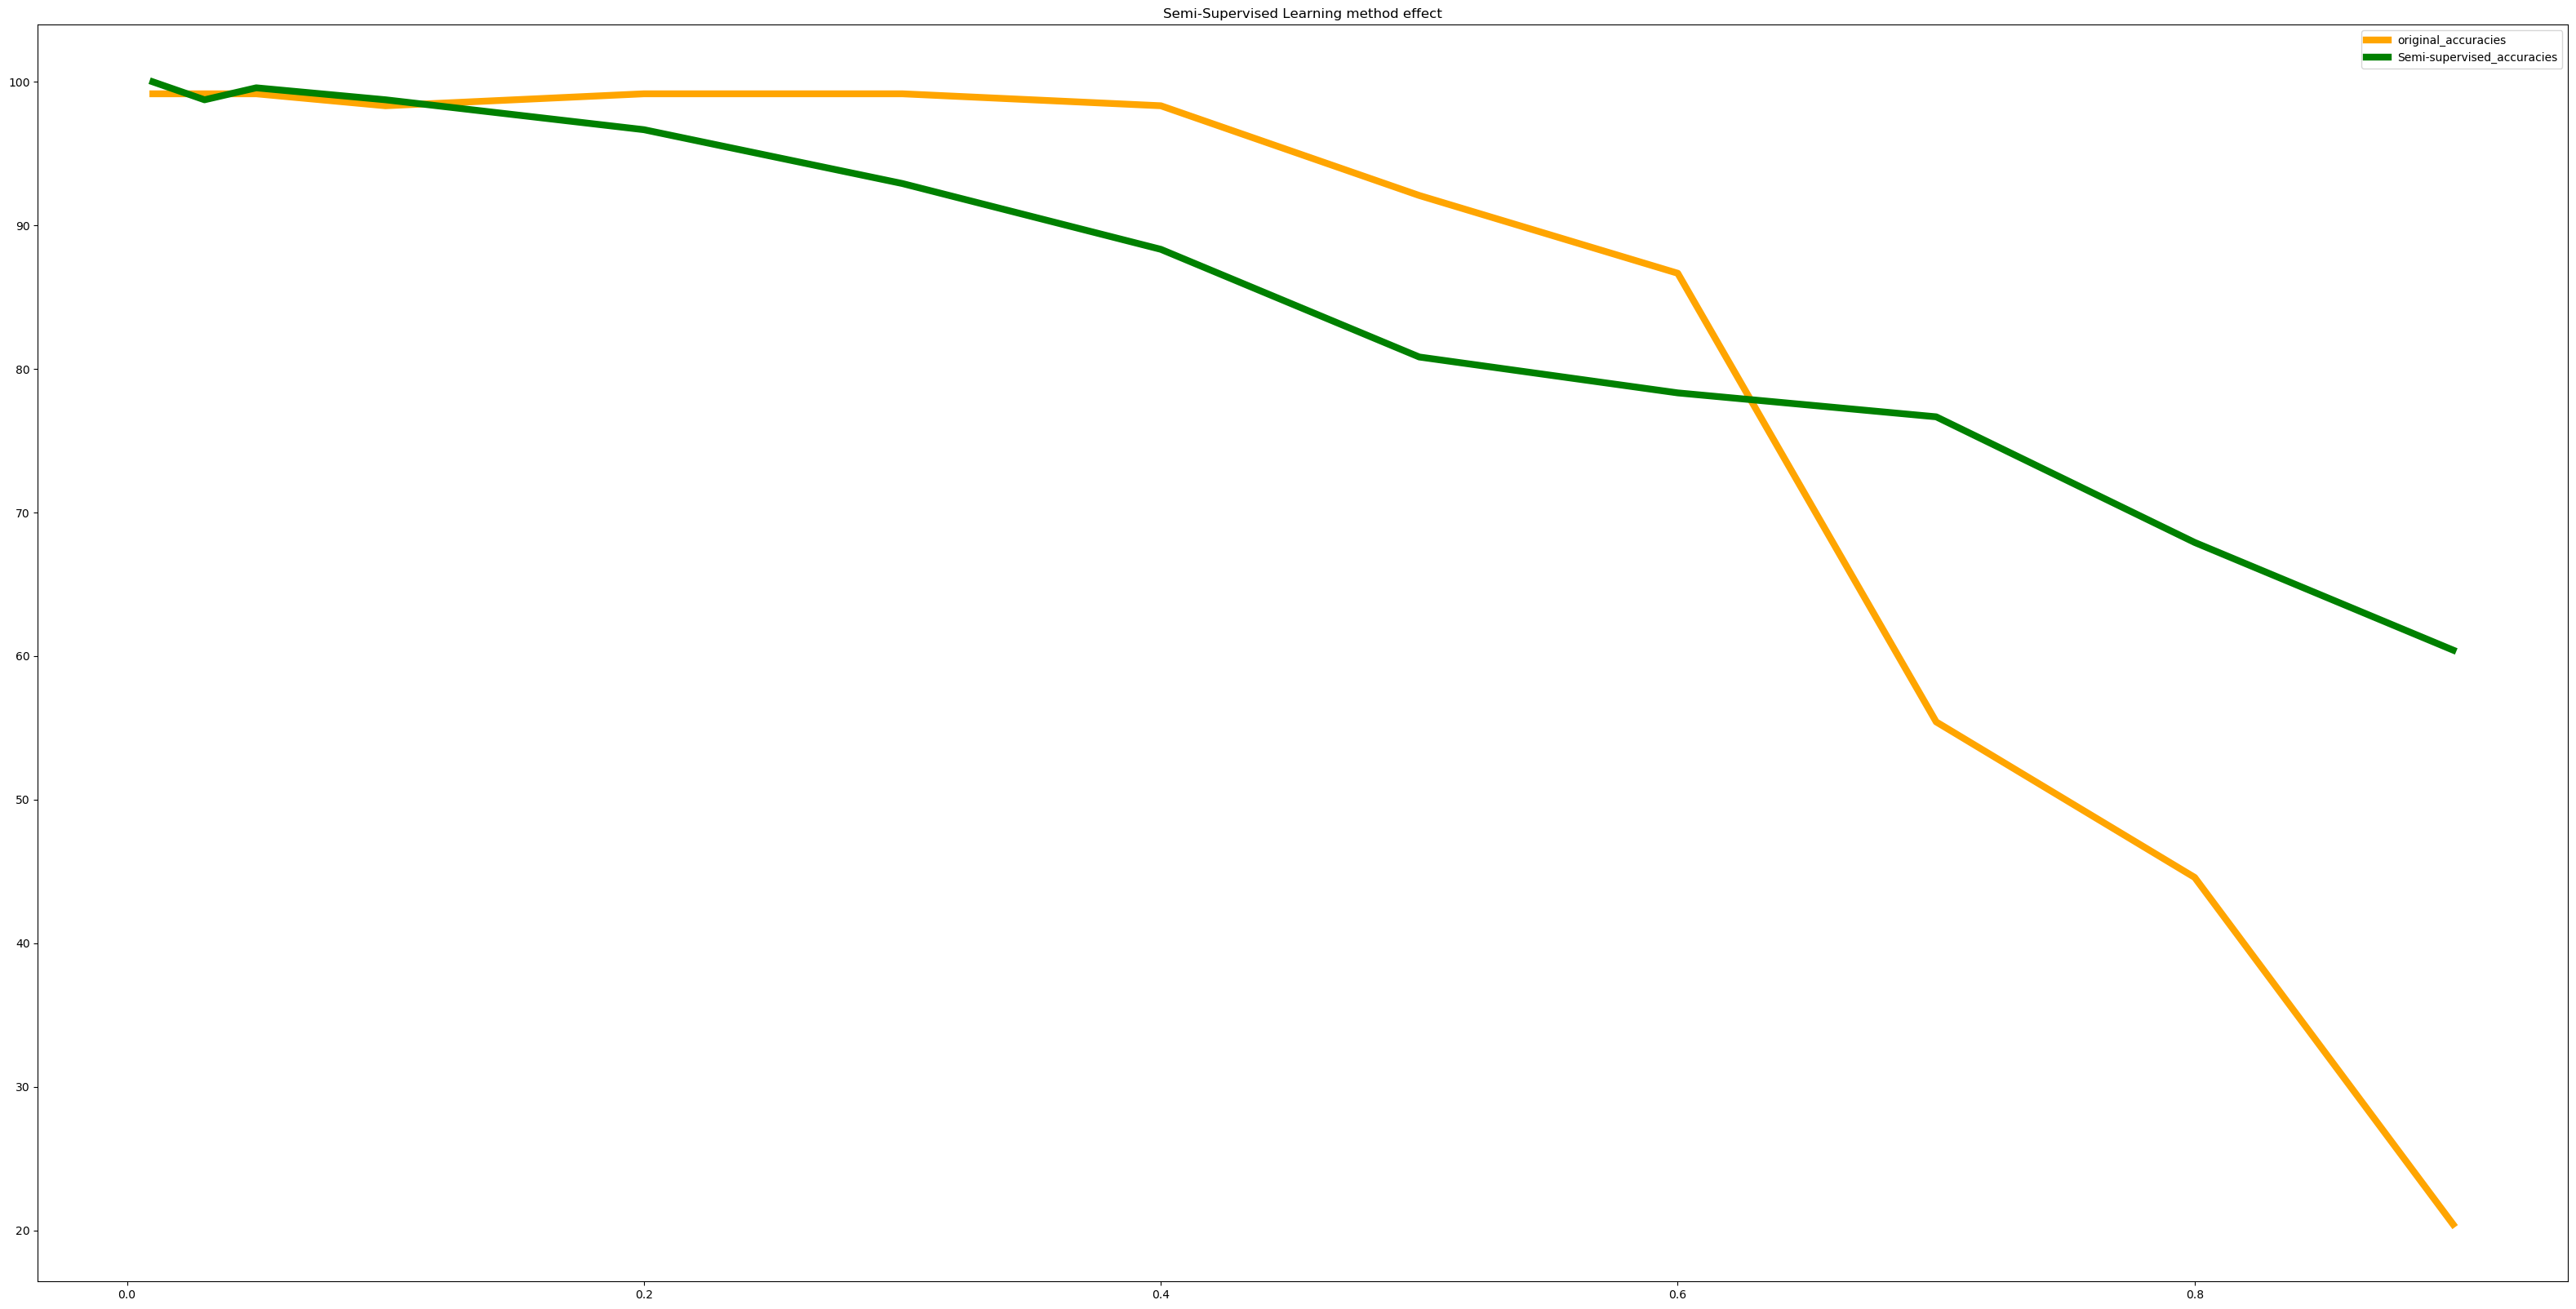

In [571]:
plot_accs(r_accs2, pred_room_axxs,"Semi-Supervised Learning method effect")

## Using Synthesized Data

In [572]:
one_ten_df, one_ten_locations, one_ten_df_test, one_ten__test_loc = prep_data_for_synthesis(alpha_filtered2_train, 0.2)


In [573]:
data_shape = (20,)
latent_dim = 8
input_layer = keras.Input(shape=data_shape)
x = keras.layers.Dense(18, activation ='relu')(input_layer)
x = keras.layers.Dense(15, activation ='relu')(x)
x = keras.layers.Dense(10, activation ='relu')(x)
means = keras.layers.Dense(latent_dim)(x)
log_var = keras.layers.Dense(latent_dim)(x)

z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

encoder = keras.models.Model(input_layer, [means, log_var, z])
    
decoder_input = keras.layers.Input(shape =(latent_dim,))
x = keras.layers.Dense(10, activation ='relu')(decoder_input)
x = keras.layers.Dense(15, activation ='relu')(x)
x = keras.layers.Dense(18, activation ='relu')(x)
outputs = keras.layers.Dense(20, activation ='sigmoid')(x)
decoder = keras.models.Model(decoder_input, outputs)
x_prime = decoder(z)
outputs = decoder(encoder(input_layer)[2])
vae = keras.models.Model(input_layer, outputs, name='vae')    
vae.compile(loss=my_loss,optimizer="adam",metrics=["accuracy"])
print(vae.summary())



Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_137 (InputLayer)       (None, 20)                0         
_________________________________________________________________
model_127 (Model)            [(None, 8), (None, 8), (N 999       
_________________________________________________________________
model_128 (Model)            (None, 20)                923       
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________
None


In [574]:
his2 = vae.fit(min_max_scaler.fit_transform(one_ten_df), min_max_scaler.fit_transform(one_ten_df) , epochs = 100, batch_size = 32, validation_split= 0.2)


Train on 153 samples, validate on 39 samples
Epoch 1/100
153/153 [==============================] - 2s 12ms/step - loss: 13.9080 - accuracy: 0.0065 - val_loss: 13.8875 - val_accuracy: 0.0000e+00
Epoch 2/100
153/153 [==============================] - 0s 177us/step - loss: 13.8084 - accuracy: 0.1176 - val_loss: 13.7903 - val_accuracy: 0.0000e+00
Epoch 3/100
153/153 [==============================] - 0s 196us/step - loss: 13.7266 - accuracy: 0.1895 - val_loss: 13.7252 - val_accuracy: 0.0769
Epoch 4/100
153/153 [==============================] - 0s 202us/step - loss: 13.6455 - accuracy: 0.2026 - val_loss: 13.6540 - val_accuracy: 0.0513
Epoch 5/100
153/153 [==============================] - 0s 204us/step - loss: 13.5679 - accuracy: 0.2418 - val_loss: 13.5451 - val_accuracy: 0.0000e+00
Epoch 6/100
153/153 [==============================] - 0s 192us/step - loss: 13.4685 - accuracy: 0.1961 - val_loss: 13.4421 - val_accuracy: 0.0000e+00
Epoch 7/100
153/153 [==============================] - 0s 

153/153 [==============================] - 0s 184us/step - loss: 4.4079 - accuracy: 0.5425 - val_loss: 7.5709 - val_accuracy: 0.6667
Epoch 56/100
153/153 [==============================] - 0s 189us/step - loss: 4.3496 - accuracy: 0.5686 - val_loss: 7.4769 - val_accuracy: 0.6667
Epoch 57/100
153/153 [==============================] - 0s 180us/step - loss: 4.2829 - accuracy: 0.5294 - val_loss: 7.3892 - val_accuracy: 0.6667
Epoch 58/100
153/153 [==============================] - 0s 180us/step - loss: 4.2842 - accuracy: 0.5098 - val_loss: 7.3008 - val_accuracy: 0.6667
Epoch 59/100
153/153 [==============================] - 0s 178us/step - loss: 4.2465 - accuracy: 0.5359 - val_loss: 7.1860 - val_accuracy: 0.6667
Epoch 60/100
153/153 [==============================] - 0s 282us/step - loss: 4.1735 - accuracy: 0.5490 - val_loss: 6.9744 - val_accuracy: 0.6667
Epoch 61/100
153/153 [==============================] - 0s 182us/step - loss: 4.1530 - accuracy: 0.5425 - val_loss: 6.9106 - val_accuracy

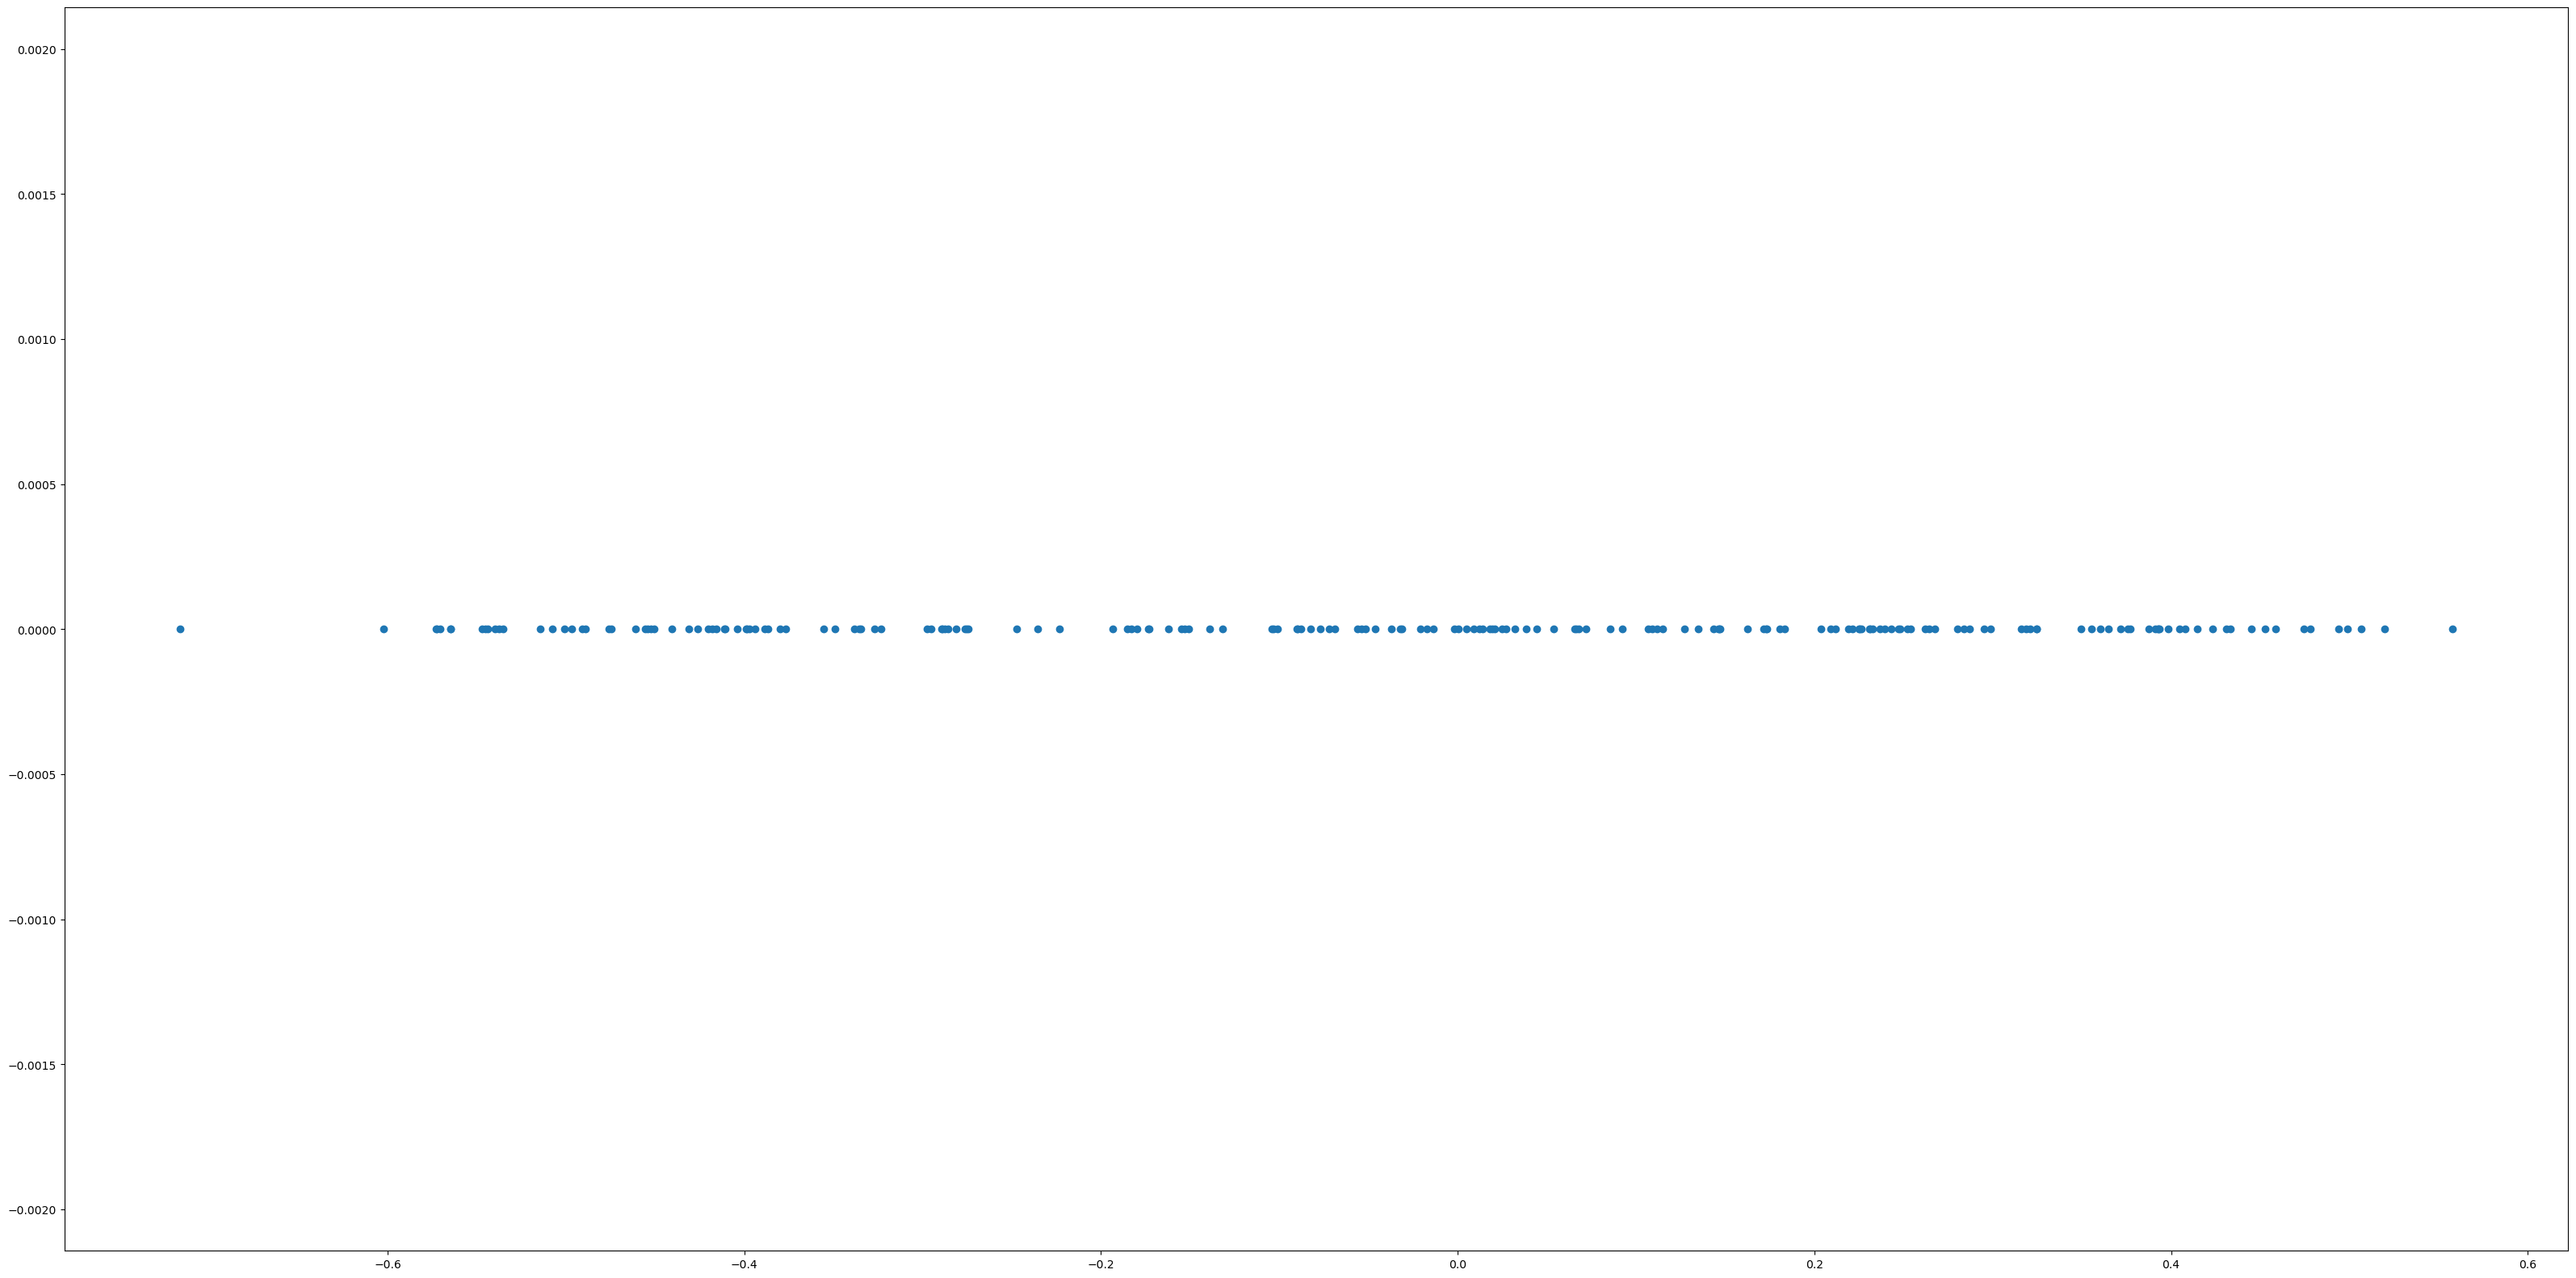

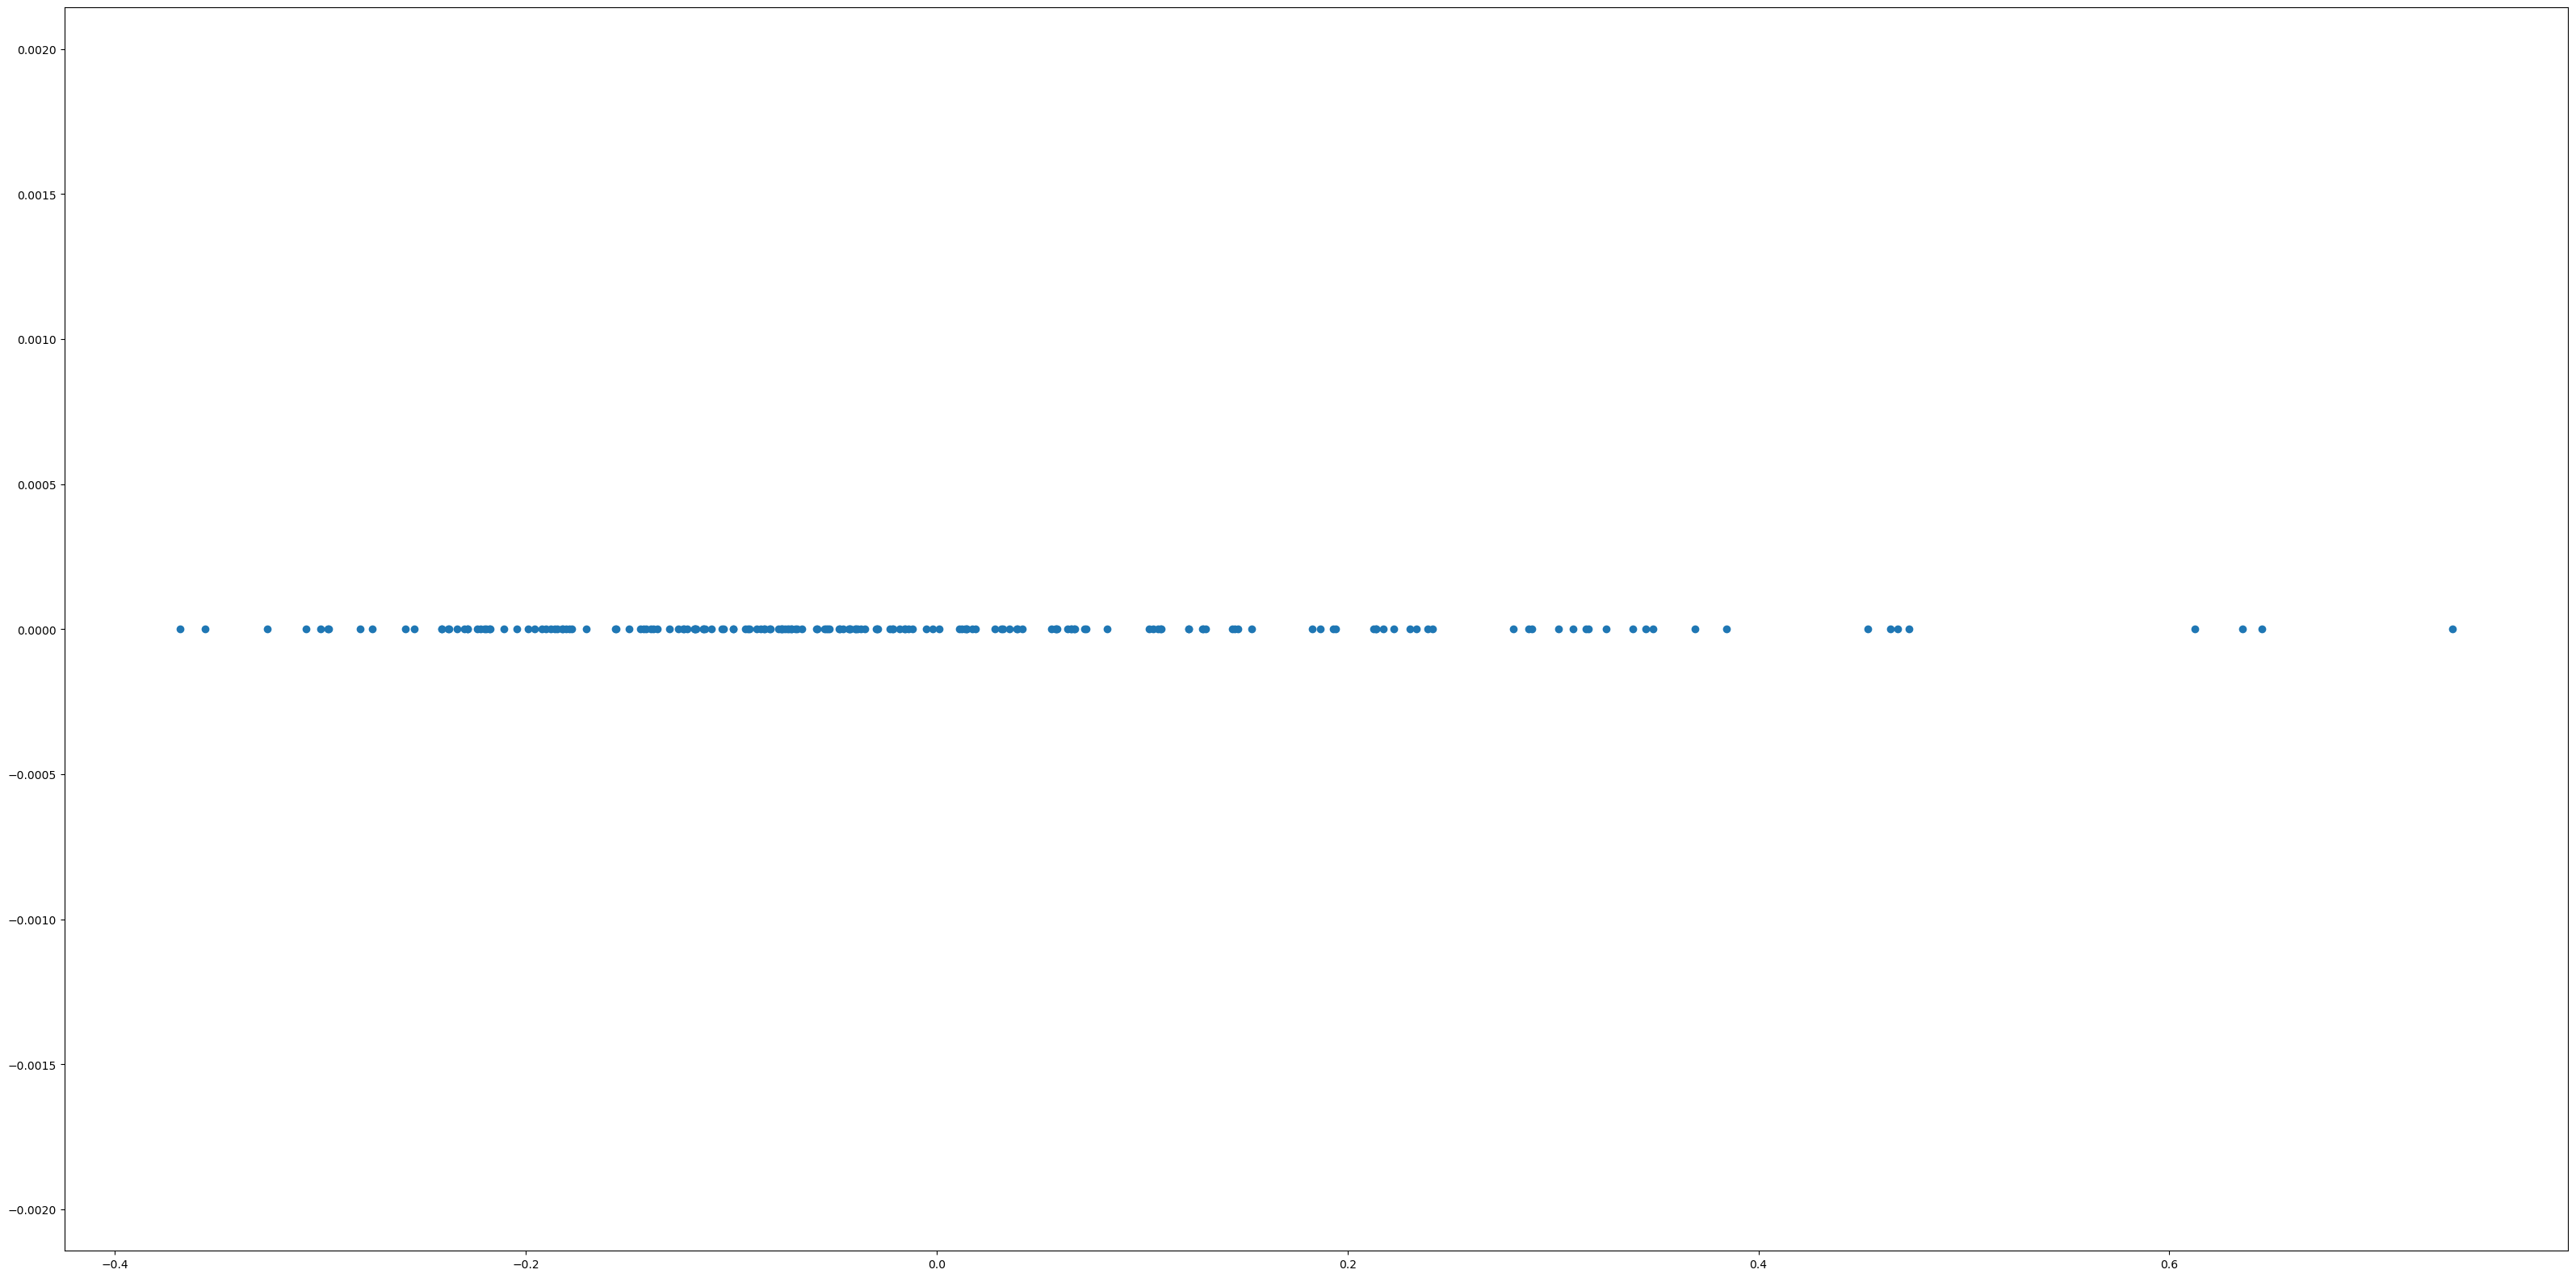

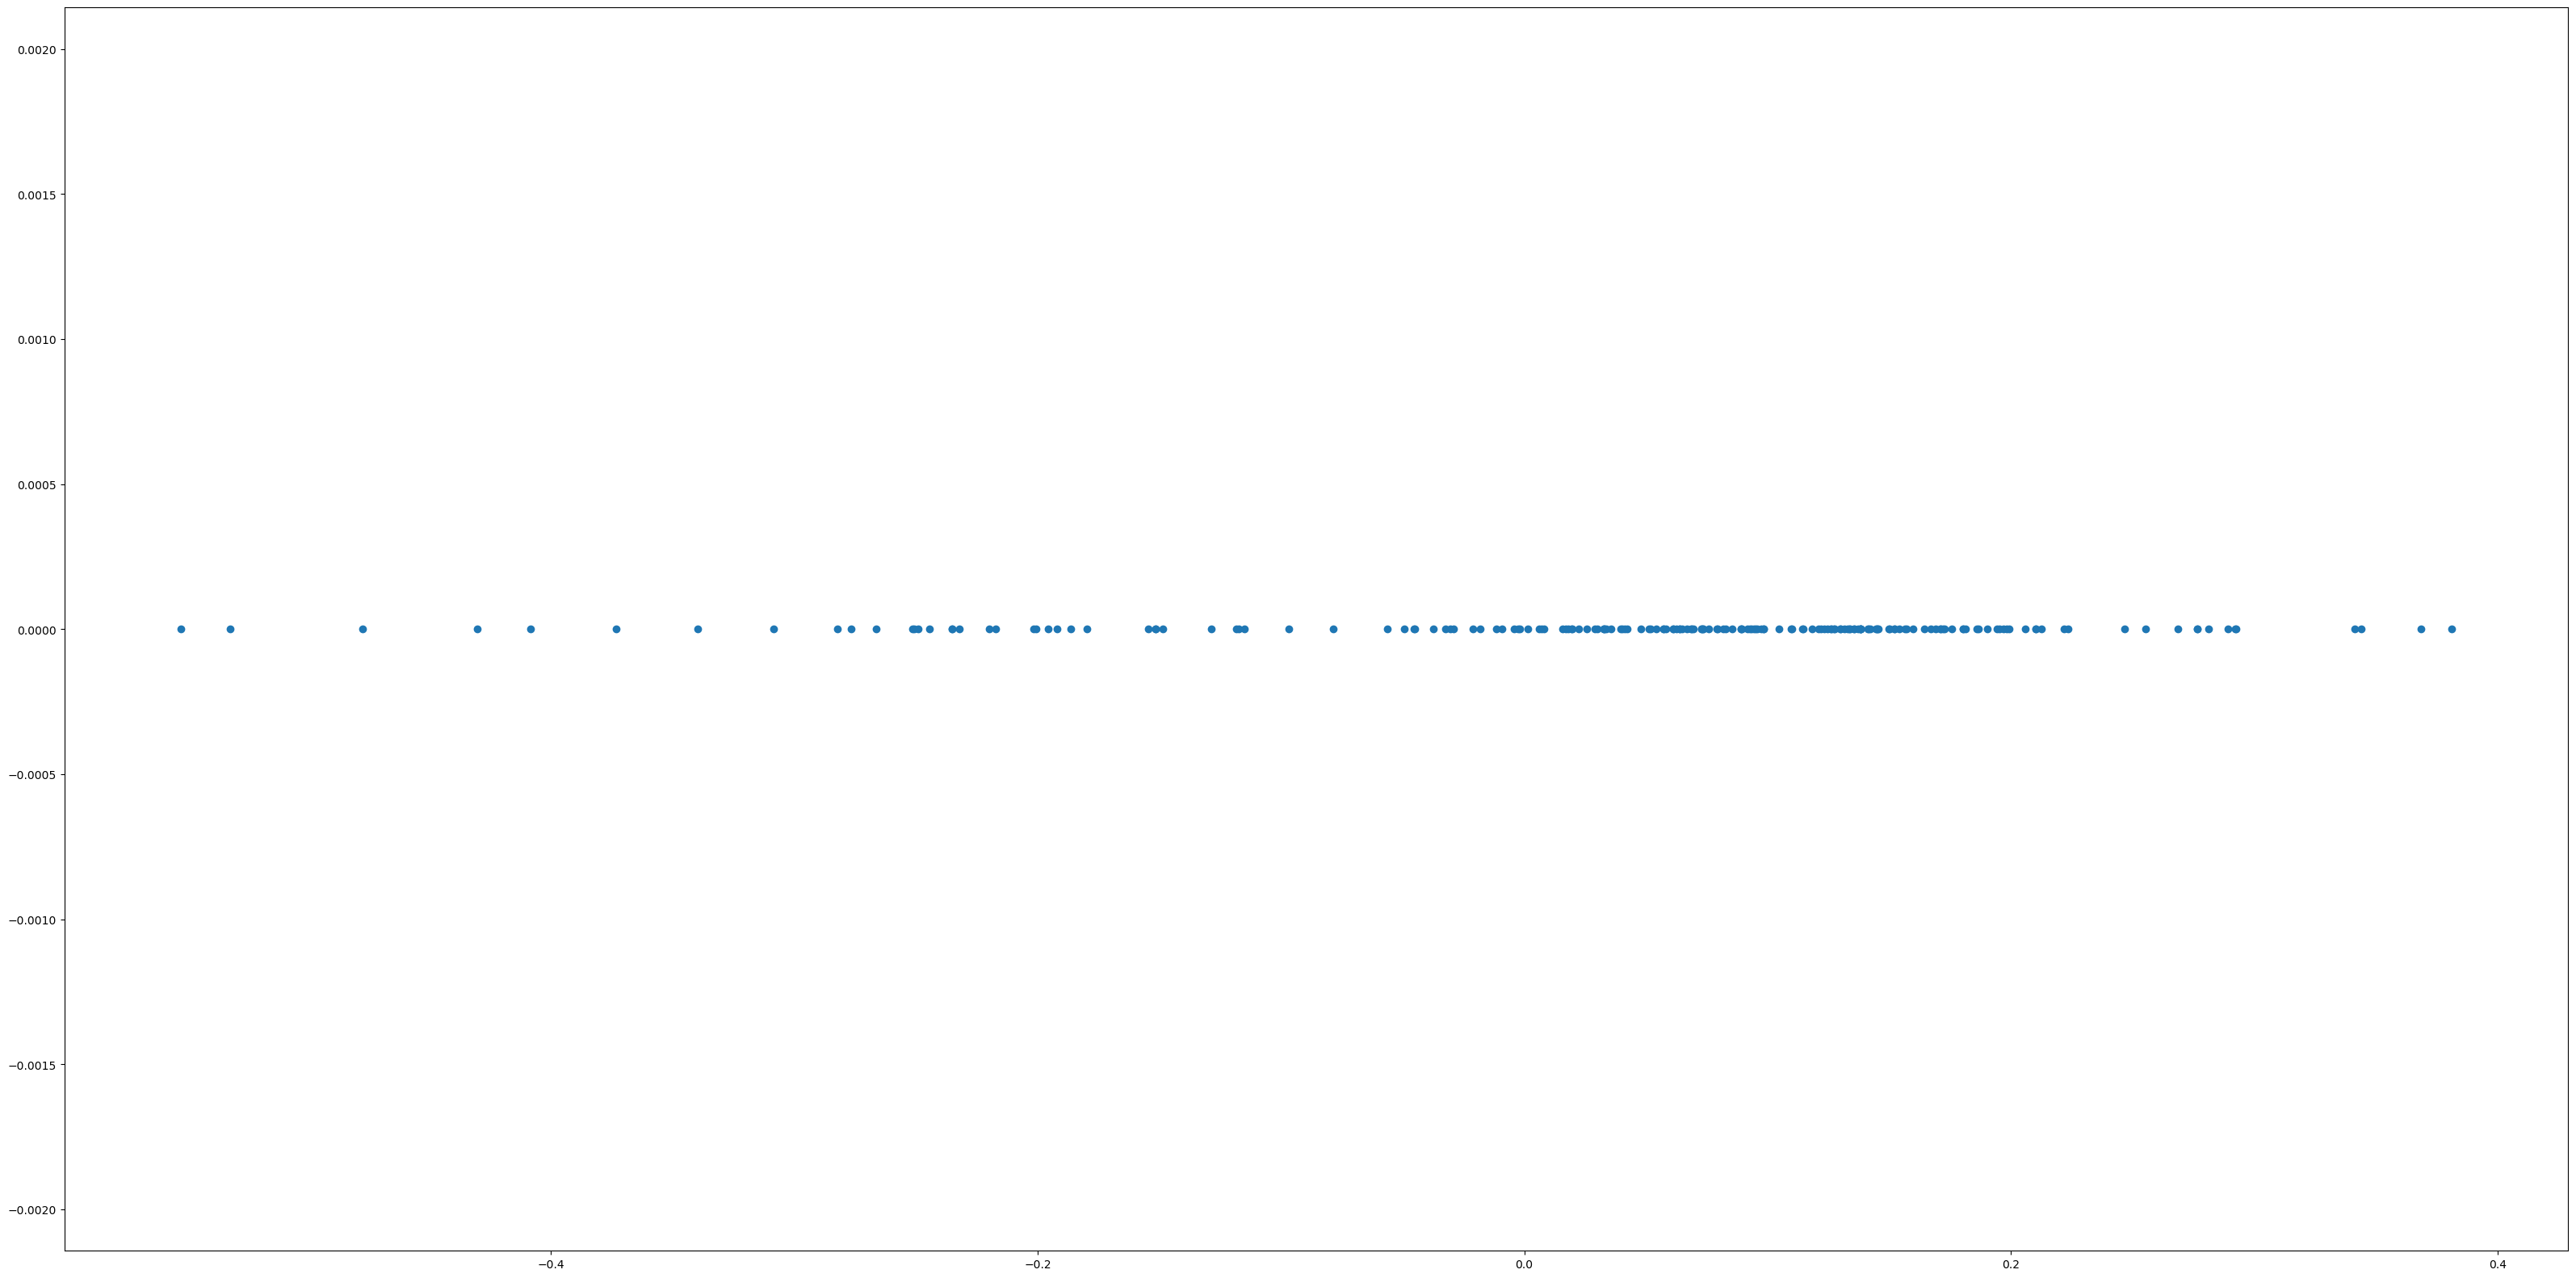

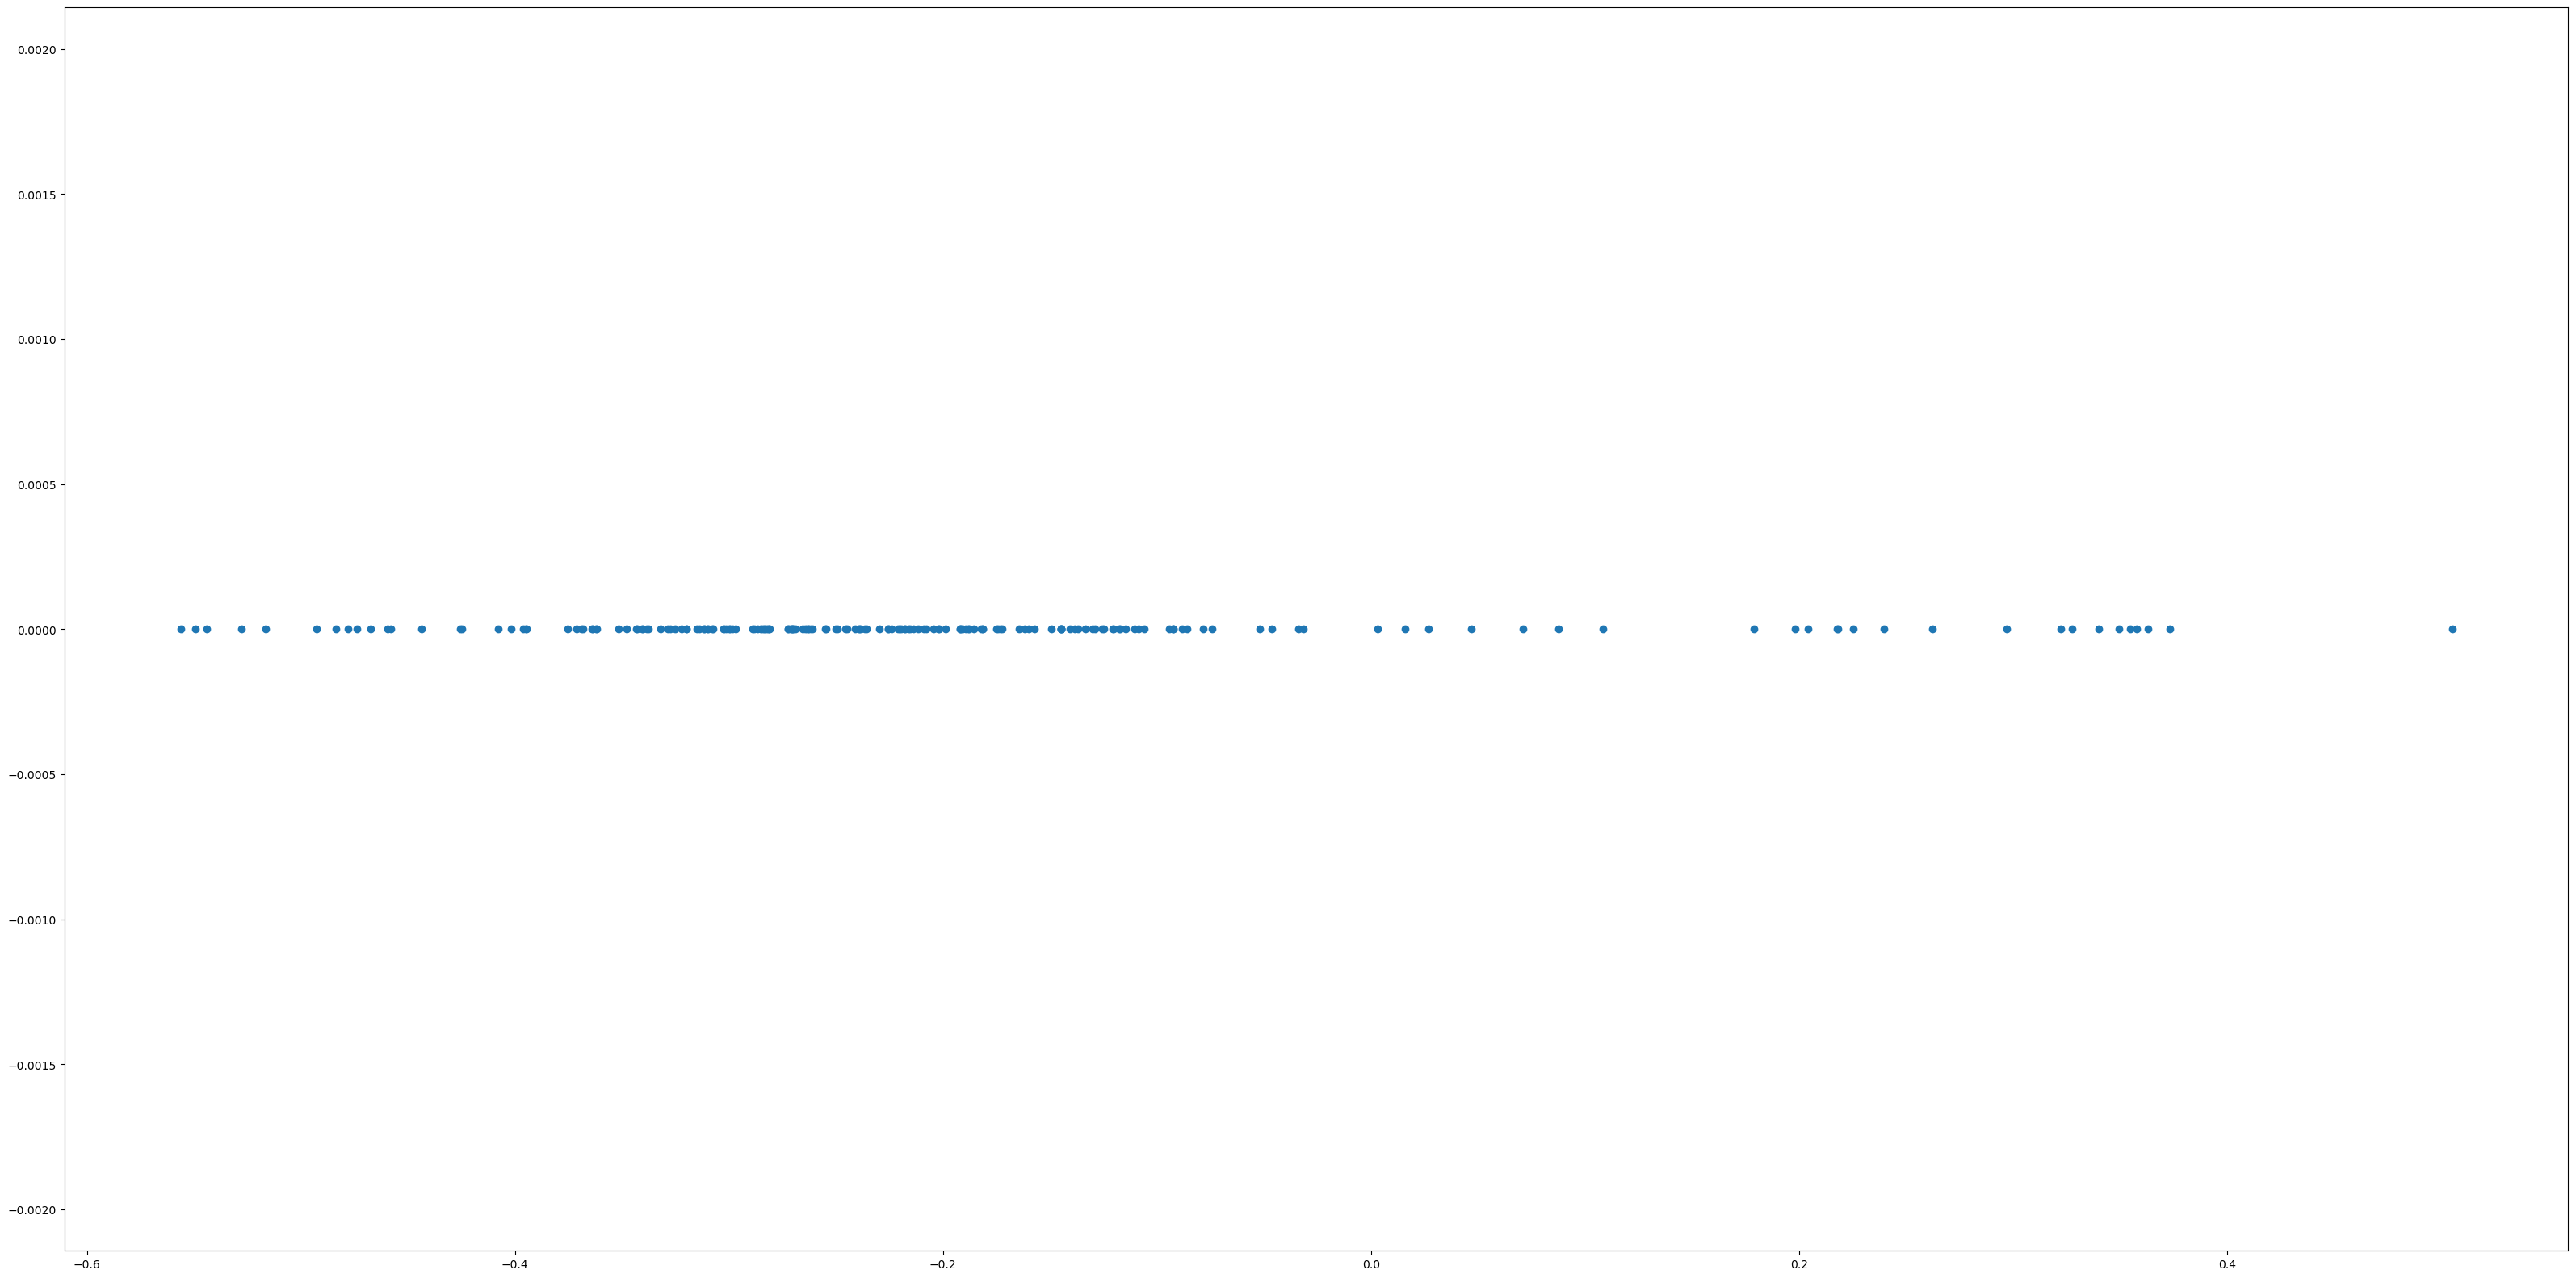

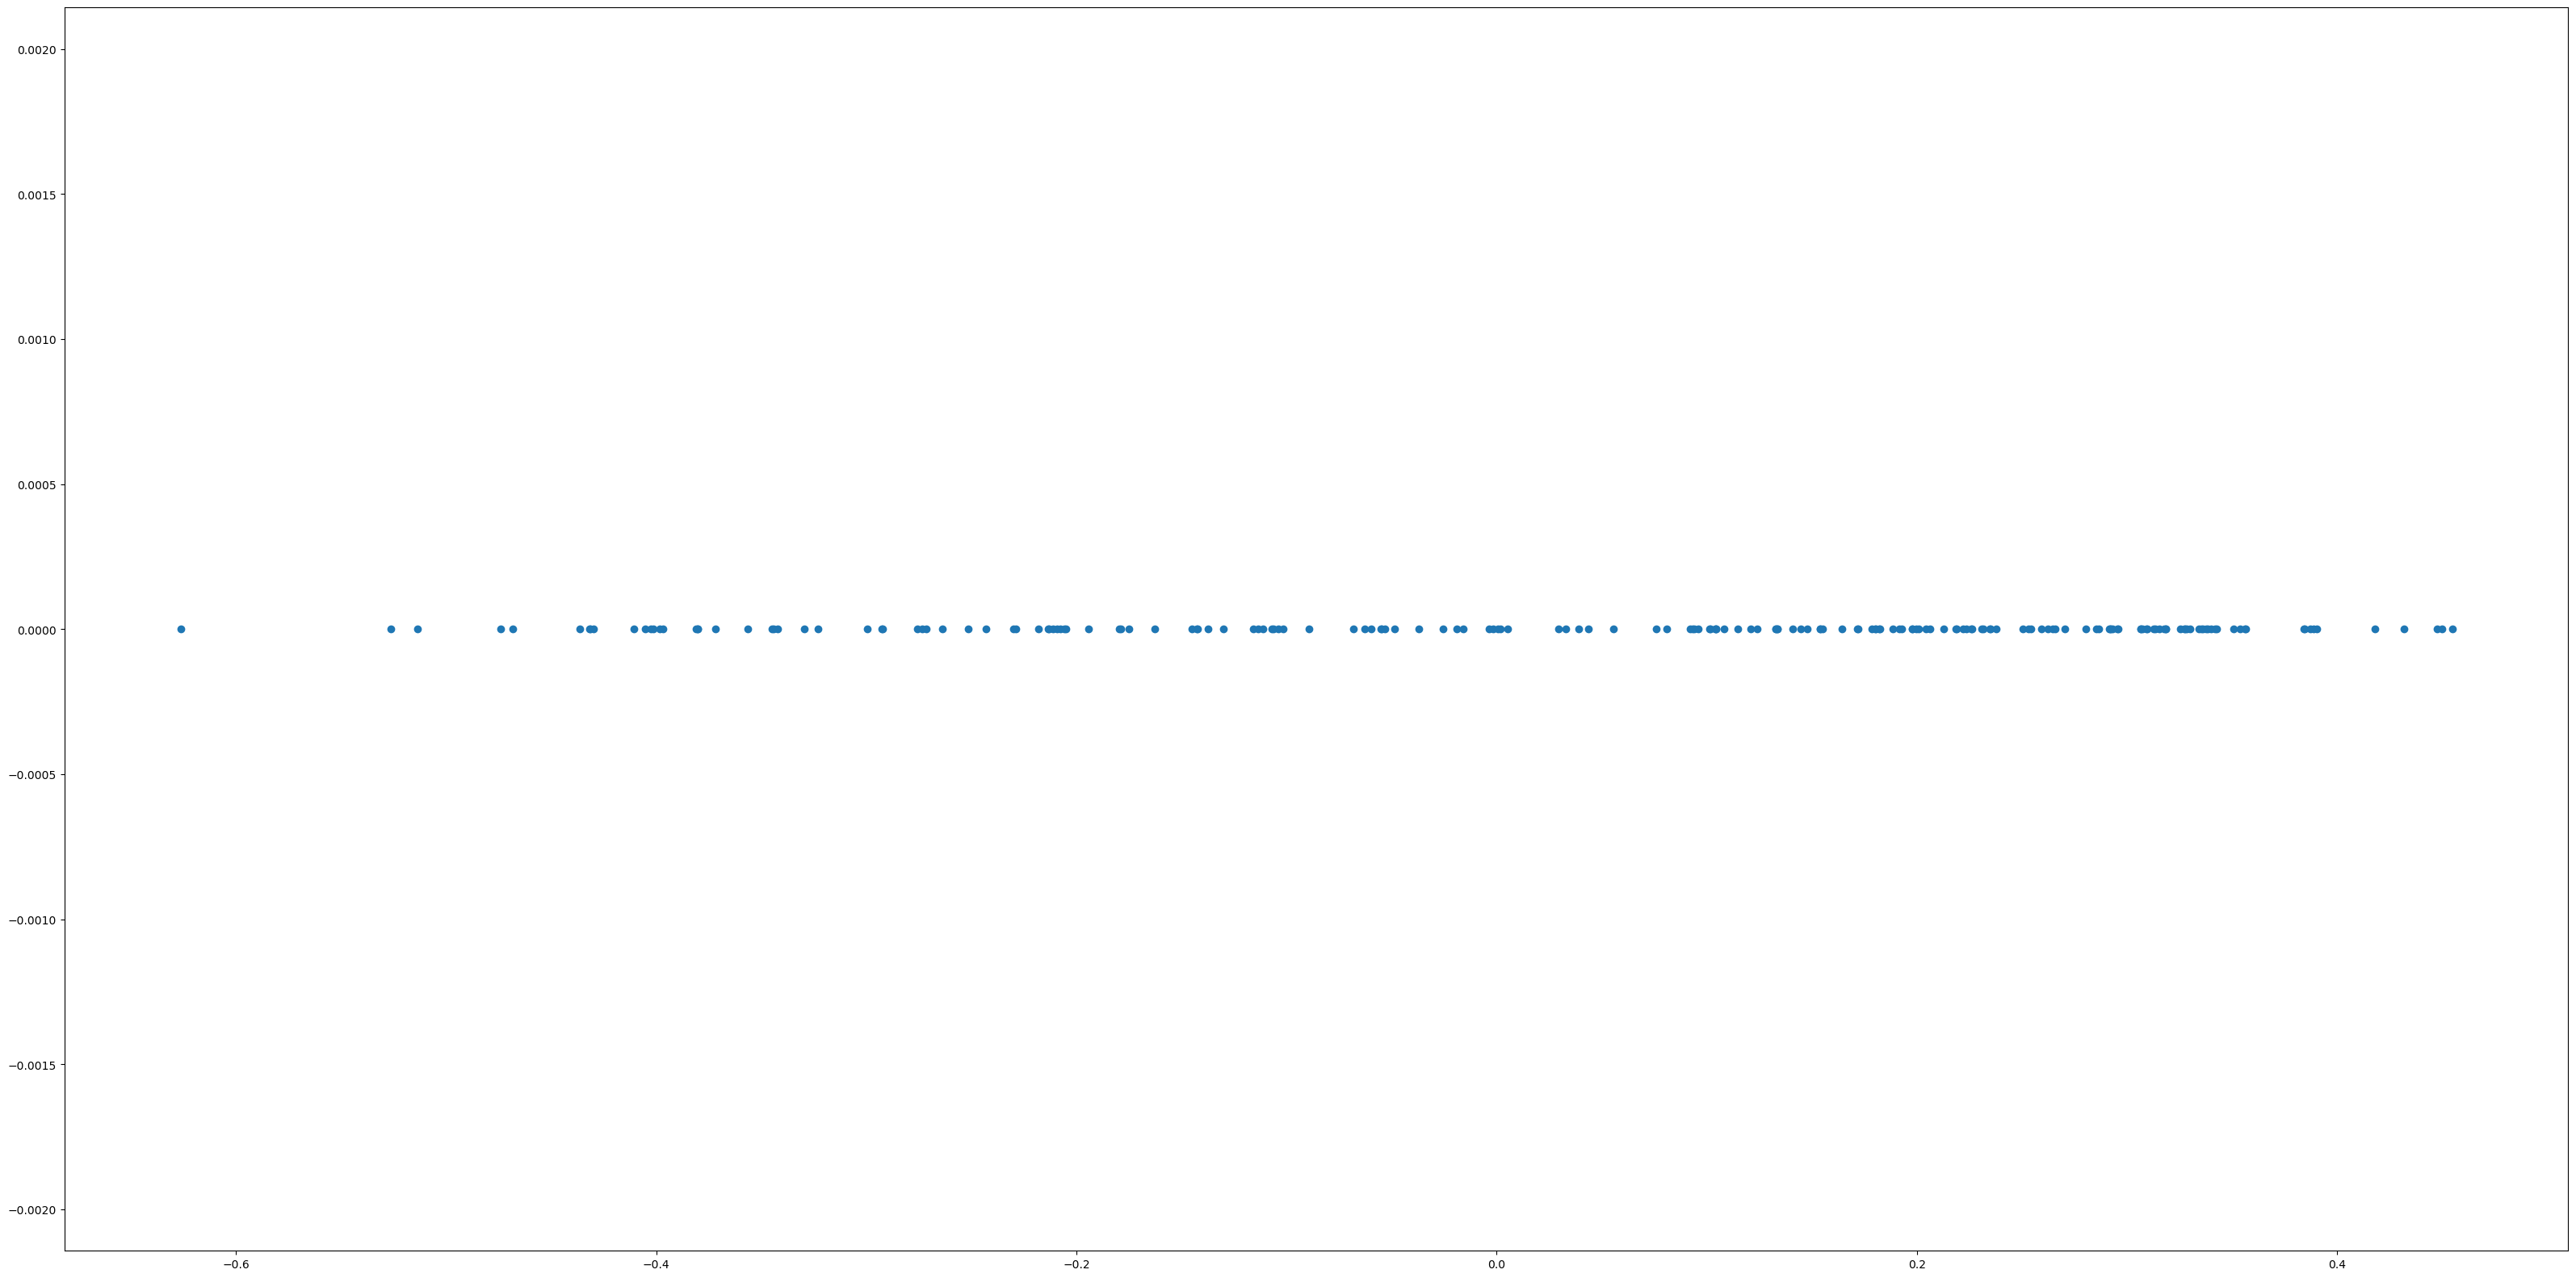

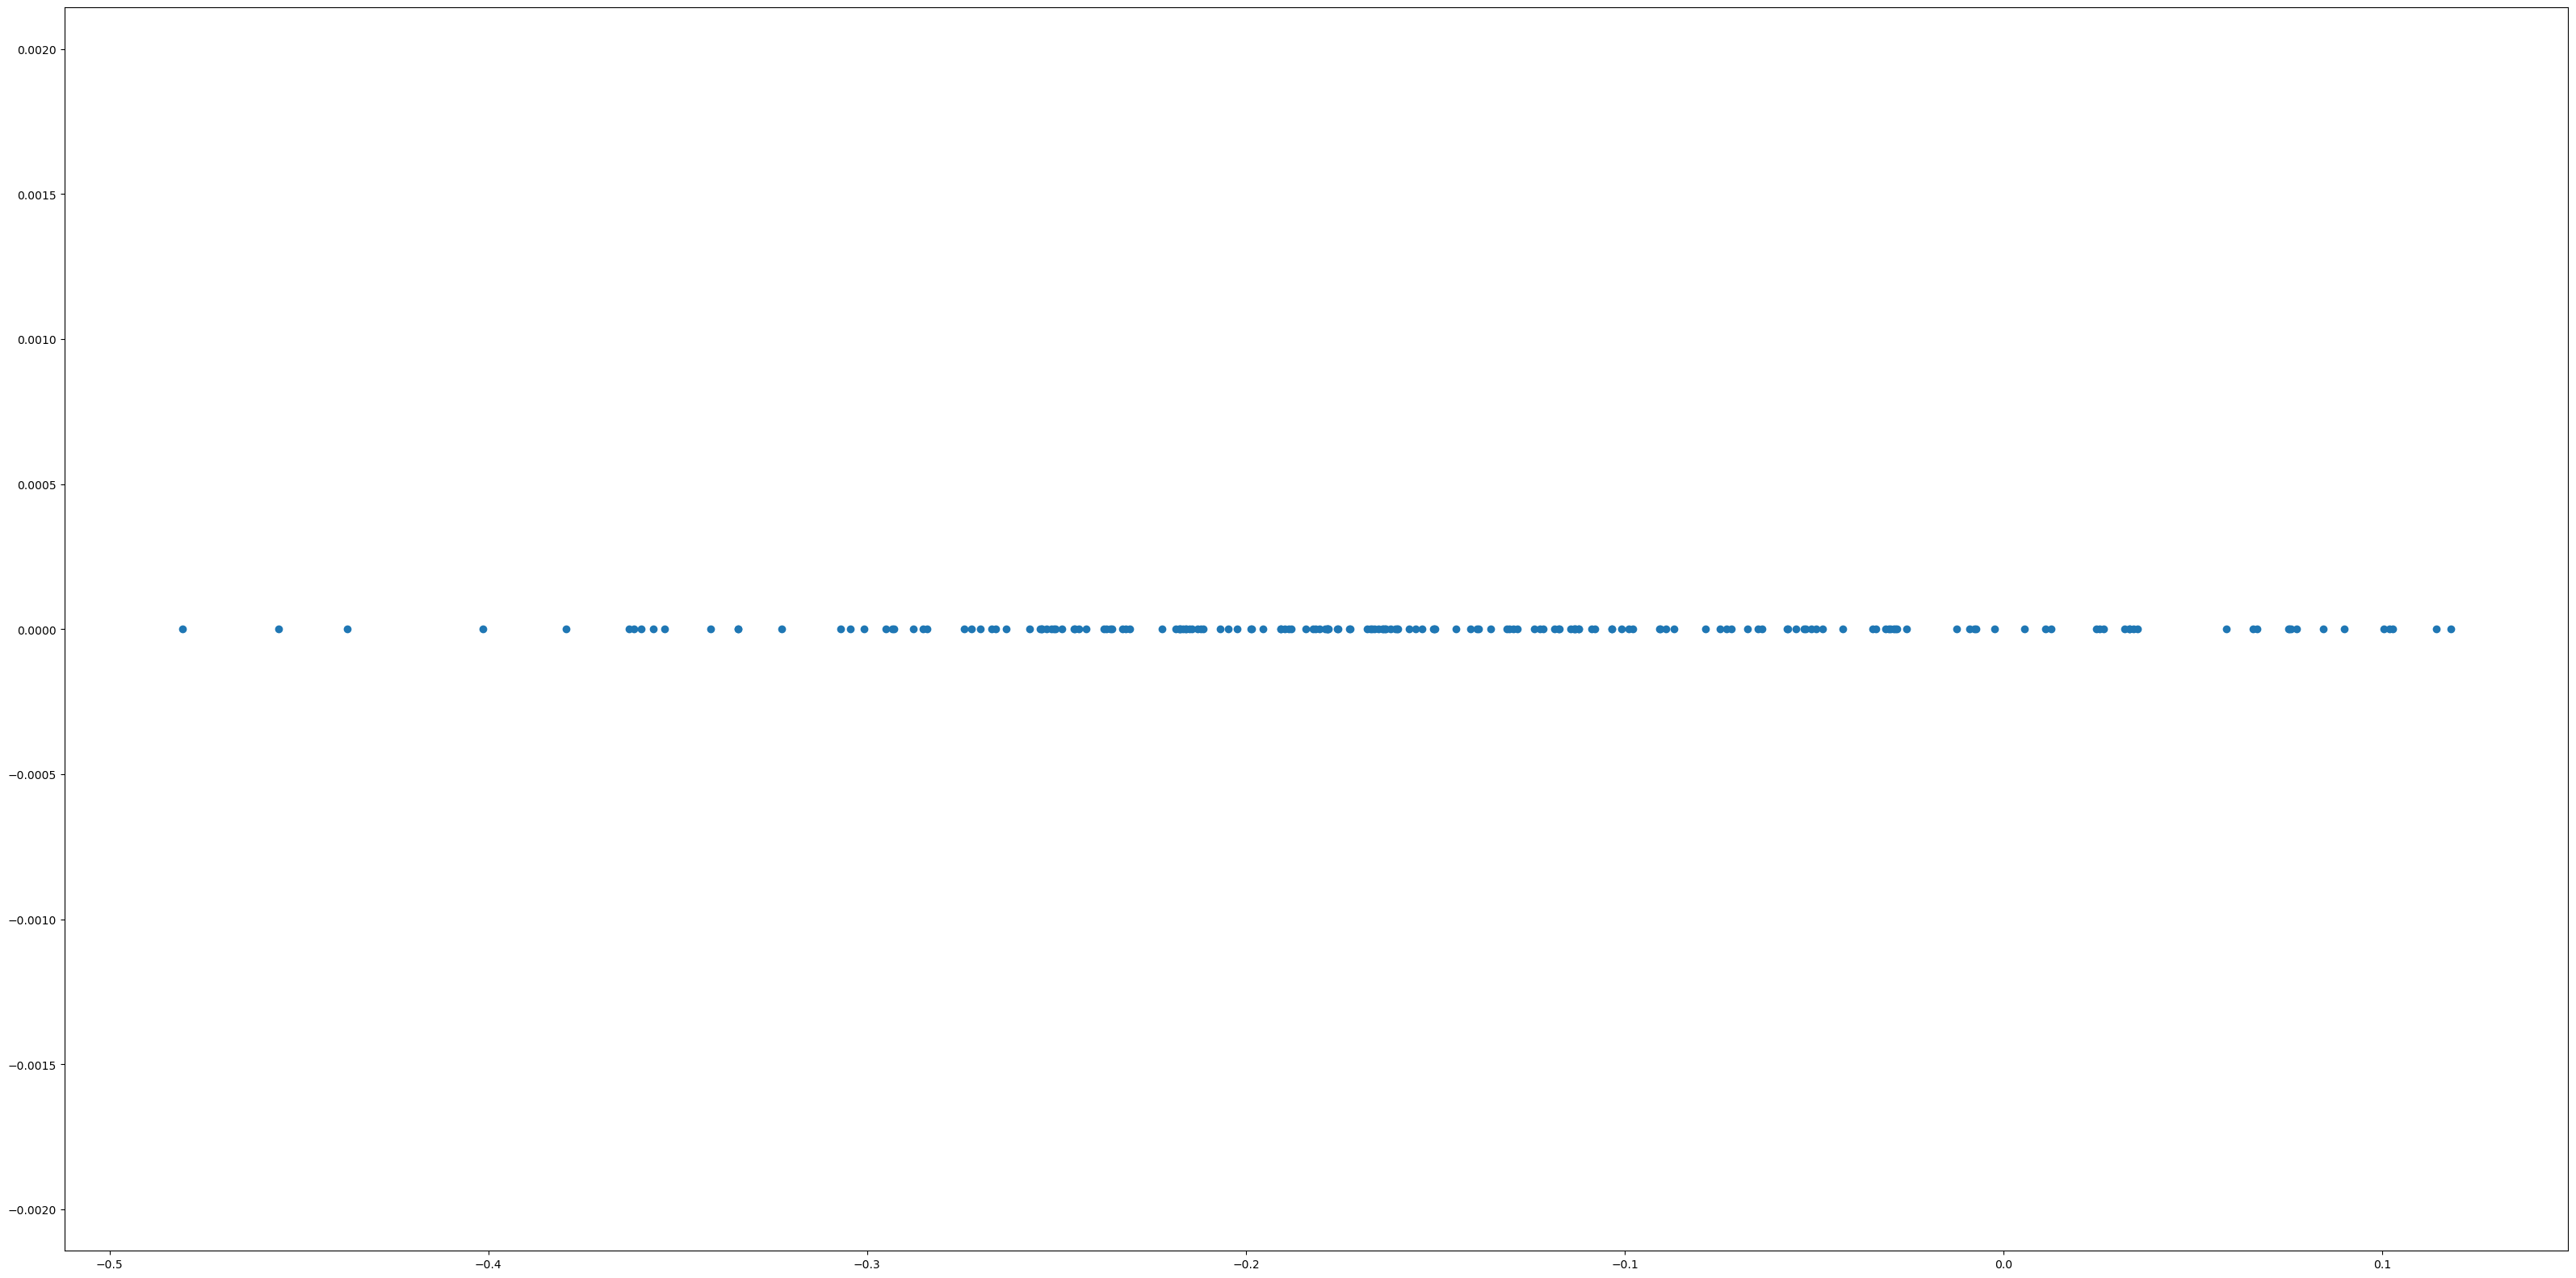

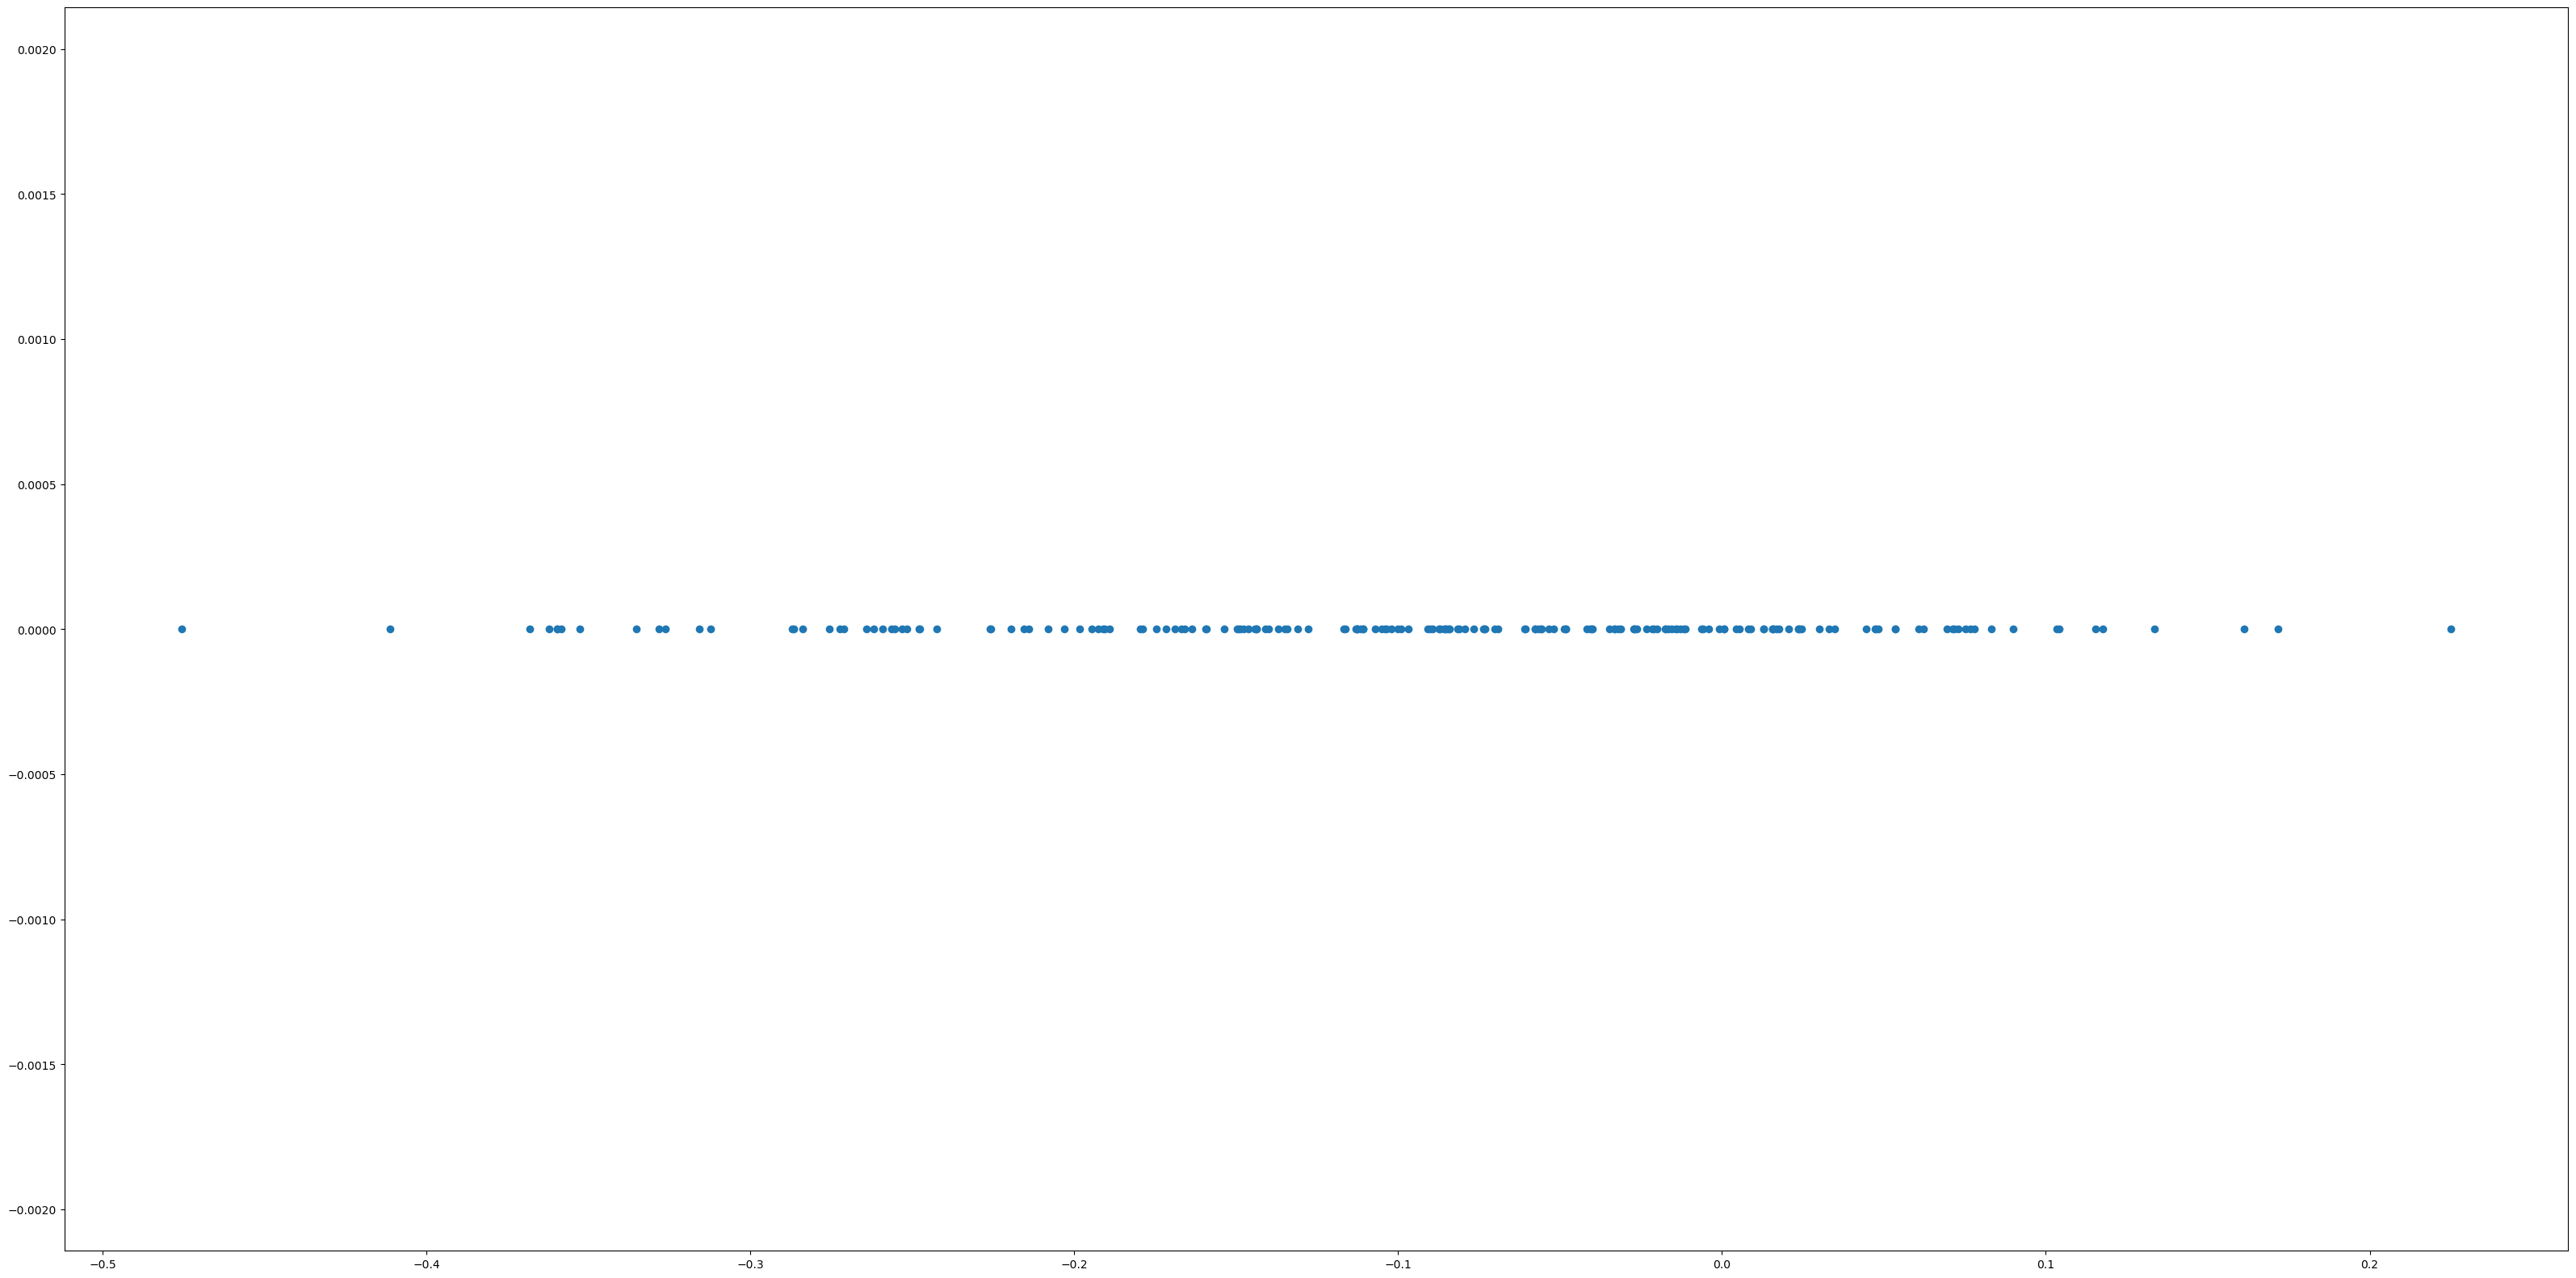

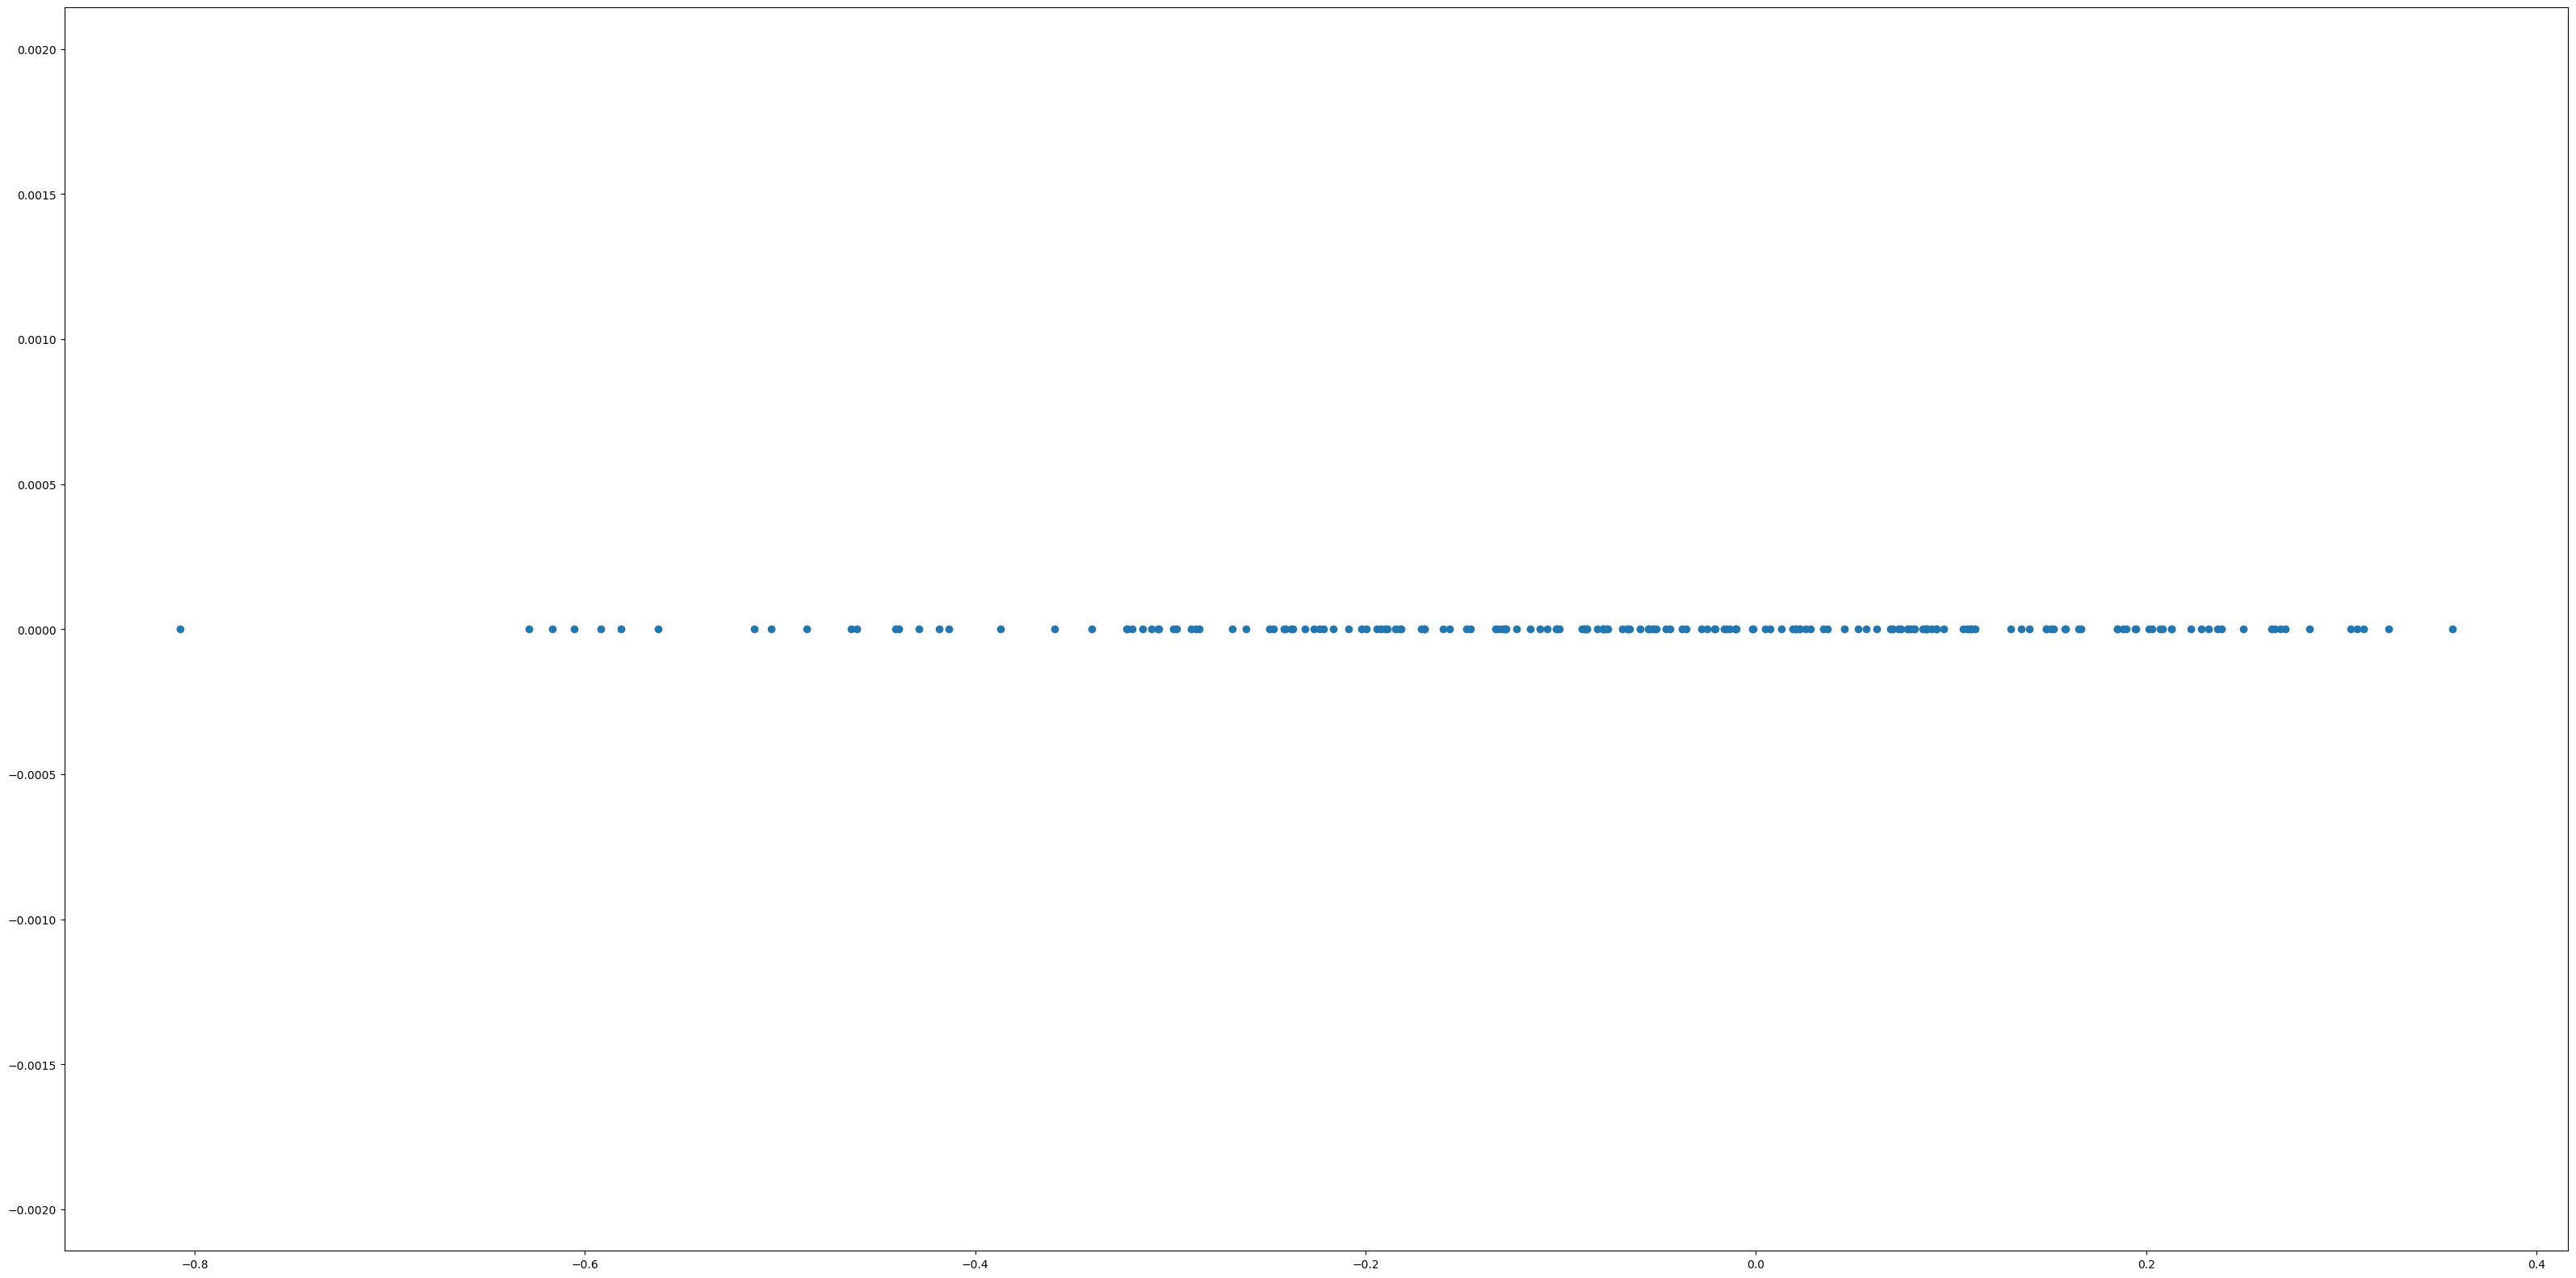

In [575]:
t = encoder.predict(min_max_scaler.fit_transform(one_ten_df))[2]
for i in range(8):
    fig, ax = plt.subplots()
    plt.scatter(t[:,i],np.zeros_like(t[:,i]))
    plt.show()

In [576]:
outs = encoder.predict(min_max_scaler.fit_transform(one_ten_df))
print(np.min(outs[2],axis=0))
print(np.max(outs[2],axis=0))


[-0.61699635 -0.38089705 -0.4249683  -0.6030334  -0.6149786  -0.4987922
 -0.48005775 -0.71277124]
[0.72007906 0.6775739  0.43286788 0.4393043  0.48678482 0.13826665
 0.34439397 0.36413288]


### Data Generation

In [577]:
def generate_data(count):
    ax = []
    mins = np.min(outs[2],axis=0)
    maxs = np.max(outs[2],axis=0)
    for i in range(count):
        t = []
        for j in range(8):
            center = (mins[j] +maxs[j])/2
            t.append(np.random.normal(center, (maxs[j]-center)/1.2))
        ax.append(np.array(t))
    for i in ax:
        i = i[:, np.newaxis]
    ax =  np.array(ax)   

    new_records = decoder.predict(ax)
    new_records = new_records.reshape(count, 20)
    return new_records

In [578]:
new = generate_data(700)

In [579]:
generated_df = pd.DataFrame(new, columns = no_channel_training_cols)

In [580]:
generated_df

beacon1   beacon2   beacon3   beacon4   beacon5   beacon6   beacon7  \
0    0.915506  0.014183  0.994736  0.990011  0.992598  0.994297  0.985490   
1    0.621678  0.313013  0.776761  0.727182  0.737415  0.745616  0.705636   
2    0.702732  0.788177  0.680974  0.122677  0.006478  0.007997  0.010774   
3    0.731469  0.135293  0.923894  0.894162  0.909233  0.908861  0.840643   
4    0.649419  0.343422  0.830311  0.703097  0.711353  0.716260  0.632784   
..        ...       ...       ...       ...       ...       ...       ...   
695  0.941399  0.017497  0.993278  0.964771  0.927713  0.873972  0.856369   
696  0.597579  0.876426  0.589178  0.095660  0.012987  0.014112  0.015162   
697  0.980369  0.009923  0.998611  0.960276  0.739117  0.510795  0.579183   
698  0.785892  0.060857  0.963077  0.965230  0.976962  0.981527  0.955329   
699  0.800135  0.714109  0.810738  0.148768  0.005197  0.007217  0.013178   

      beacon8   beacon9  beacon10  beacon11  beacon12  beacon13  beacon14  \
0    0.992226  0.996948  0.968715  0.453710  0.484738  0.371257  0.169715   
1    0.727391  0.801303  0.666380  0.470986  0.523270  0.515850  0.387526   
2    0.013106  0.014516  0.388894  0.000097  0.000863  0.000688  0.000178   
3    0.895947  0.945485  0.807269  0.458881  0.493139  0.486759  0.294651   
4    0.725142  0.808092  0.685224  0.257052  0.383848  0.385678  0.177521   
..        ...       ...       ...       ...       ...       ...       ...   
695  0.929377  0.953728  0.957490  0.011471  0.022017  0.009616  0.006728   
696  0.024931  0.033643  0.306840  0.000551  0.004713  0.004785  0.000764   
697  0.803799  0.829904  0.980299  0.000046  0.000307  0.000068  0.000036   
698  0.972148  0.989255  0.892726  0.791670  0.754161  0.749954  0.545045   
699  0.013346  0.012771  0.506578  0.000028  0.000347  0.000195  0.000052   

     beacon15  beacon16      beacon17  beacon18  beacon19  beacon20  
0    0.021561  0.032287  1.276165e-02  0.032233  0.067337  0.398782  
1    0.309491  0.292048  2.688236e-01  0.310534  0.375206  0.489338  
2    0.001273  0.000616  5.444884e-05  0.000696  0.001900  0.000730  
3    0.162441  0.151086  1.097083e-01  0.151656  0.234424  0.462453  
4    0.194673  0.145181  1.042295e-01  0.161553  0.265331  0.350118  
..        ...       ...           ...       ...       ...       ...  
695  0.001703  0.002869  2.245903e-04  0.001742  0.003293  0.017135  
696  0.008608  0.003150  5.033016e-04  0.004198  0.012694  0.004070  
697  0.000014  0.000023  2.086163e-07  0.000011  0.000036  0.000198  
698  0.210985  0.222099  2.121955e-01  0.235607  0.334363  0.720779  
699  0.000266  0.000173  9.089708e-06  0.000207  0.000557  0.000258  

[700 rows x 20 columns]

## Random Forest with Synthesized Data

### Labeling Model Definition

In [581]:
rfc_syn = RandomForestClassifier()
forest_syn_params = [{'criterion': ["entropy"], 'max_depth':[8,10,12,15], 'max_features': [8,10,15,20]}]
clf2 = GridSearchCV(rfc_syn, forest_syn_params, cv = 3, scoring='accuracy',refit=True,verbose=2)
print(clf2.fit(min_max_scaler.fit_transform(one_ten_df), one_ten_locations))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END .....criterion=entropy, max_depth=8, max_features=8; total time=   0.2s
[CV] END .....criterion=entropy, max_depth=8, max_features=8; total time=   0.2s
[CV] END .....criterion=entropy, max_depth=8, max_features=8; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   0.3s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   0.3s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   0.3s
[CV] END ....criterion=entropy, max_depth=8, max

In [582]:
clf2.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=8, max_features=20)

In [583]:
syn_rforest_predictions = clf2.predict(generated_df)

### Testing the generated plus ground data

In [584]:
one_ten_df

beacon1    beacon2     beacon3     beacon4     beacon5     beacon6  \
0   -107.134454 -83.647059 -172.931671 -300.000000 -300.000000 -300.000000   
5    -94.600000 -84.000000 -245.333333 -300.000000 -300.000000 -300.000000   
10   -95.285714 -83.714286 -222.761905 -300.000000 -300.000000 -300.000000   
15   -95.020337 -83.666667 -168.991023 -300.000000 -300.000000 -300.000000   
20   -95.894643 -84.520000 -171.435235 -300.000000 -300.000000 -300.000000   
..          ...        ...         ...         ...         ...         ...   
935  -93.190101 -89.794173 -112.379754 -145.408775 -200.162984 -211.666093   
940  -93.189943 -89.794012 -112.379611 -145.408657 -200.162908 -211.666025   
945  -93.188842 -89.792894 -112.378612 -145.407834 -200.162377 -211.665555   
950  -93.186987 -89.791008 -112.376929 -145.406447 -200.161481 -211.664762   
955  -93.186377 -89.790388 -112.376376 -145.405991 -200.161186 -211.664502   

        beacon7     beacon8     beacon9   beacon10    beacon11    beacon12  \
0   -300.000000 -300.000000 -300.000000 -99.220588 -300.000000 -300.000000   
5   -300.000000 -300.000000 -300.000000 -97.400000 -300.000000 -300.000000   
10  -300.000000 -300.000000 -300.000000 -97.914286 -300.000000 -300.000000   
15  -300.000000 -300.000000 -300.000000 -99.152778 -300.000000 -300.000000   
20  -300.000000 -300.000000 -300.000000 -99.070000 -300.000000 -300.000000   
..          ...         ...         ...        ...         ...         ...   
935 -201.391330 -185.997138 -188.566476 -93.637146 -275.911939 -274.503236   
940 -201.391255 -185.997051 -188.566390 -93.636988 -275.911920 -274.503217   
945 -201.390730 -185.996444 -188.565797 -93.635890 -275.911792 -274.503081   
950 -201.389845 -185.995421 -188.564798 -93.634039 -275.911576 -274.502853   
955 -201.389554 -185.995085 -188.564469 -93.633430 -275.911505 -274.502777   

       beacon13    beacon14    beacon15    beacon16    beacon17    beacon18  \
0   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
5   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
10  -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
15  -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
20  -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
..          ...         ...         ...         ...         ...         ...   
935 -272.354211 -272.830298 -289.417250 -287.715368 -290.431301 -288.386076   
940 -272.354190 -272.680096 -289.249927 -287.541666 -290.261344 -288.215284   
945 -272.354043 -271.762297 -288.069433 -286.322038 -289.075567 -286.977658   
950 -272.353795 -269.961655 -286.048080 -284.236170 -287.030935 -284.942635   
955 -272.353713 -269.371383 -285.374393 -283.562695 -286.379587 -284.250458   

       beacon19    beacon20  
0   -300.000000 -300.000000  
5   -300.000000 -300.000000  
10  -300.000000 -300.000000  
15  -300.000000 -300.000000  
20  -300.000000 -300.000000  
..          ...         ...  
935 -282.451447 -270.843446  
940 -282.284969 -270.843424  
945 -281.151177 -270.843269  
950 -279.243340 -270.843007  
955 -278.598975 -270.842921  

[192 rows x 20 columns]

In [585]:
pd.DataFrame(min_max_scaler.fit_transform(one_ten_df), columns= no_channel_training_cols)

beacon1   beacon2   beacon3   beacon4   beacon5   beacon6   beacon7  \
0    0.000000  0.999668  0.543948  0.000000  0.000000  0.000000  0.000000   
1    0.815001  0.943489  0.000000  0.000000  0.000000  0.000000  0.000000   
2    0.770415  0.988967  0.169577  0.000000  0.000000  0.000000  0.000000   
3    0.787671  0.996547  0.573554  0.000000  0.000000  0.000000  0.000000   
4    0.730822  0.860719  0.555190  0.000000  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
187  0.906674  0.021212  0.998869  0.999491  0.999966  0.999966  0.999966   
188  0.906684  0.021237  0.998871  0.999492  0.999967  0.999967  0.999967   
189  0.906756  0.021415  0.998878  0.999498  0.999972  0.999972  0.999972   
190  0.906877  0.021716  0.998891  0.999507  0.999981  0.999981  0.999981   
191  0.906916  0.021814  0.998895  0.999509  0.999984  0.999984  0.999984   

      beacon8   beacon9  beacon10  beacon11  beacon12  beacon13  beacon14  \
0    0.000000  0.000000  0.293707  0.000000  0.000000  0.000000  0.000000   
1    0.000000  0.000000  0.508811  0.000000  0.000000  0.000000  0.000000   
2    0.000000  0.000000  0.448047  0.000000  0.000000  0.000000  0.000000   
3    0.000000  0.000000  0.301719  0.000000  0.000000  0.000000  0.000000   
4    0.000000  0.000000  0.311499  0.000000  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
187  0.999966  0.999966  0.953394  0.999966  0.999966  0.989379  0.810250   
188  0.999967  0.999967  0.953413  0.999967  0.999967  0.989379  0.814729   
189  0.999972  0.999972  0.953543  0.999972  0.999972  0.989385  0.842099   
190  0.999981  0.999981  0.953762  0.999981  0.999981  0.989394  0.895798   
191  0.999984  0.999984  0.953833  0.999984  0.999984  0.989396  0.913401   

     beacon15  beacon16  beacon17  beacon18  beacon19  beacon20  
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
..        ...       ...       ...       ...       ...       ...  
187  0.579641  0.612112  0.557458  0.597048  0.706028  0.999966  
188  0.588805  0.620767  0.567360  0.605828  0.712725  0.999967  
189  0.653464  0.681538  0.636442  0.669452  0.758341  0.999972  
190  0.764178  0.785472  0.755559  0.774068  0.835099  0.999981  
191  0.801077  0.819029  0.793505  0.809652  0.861023  0.999984  

[192 rows x 20 columns]

In [586]:
frames = [pd.DataFrame(min_max_scaler.fit_transform(one_ten_df), columns= no_channel_training_cols), generated_df]
train_combined = pd.concat(frames)

frames = [one_ten_locations, pd.DataFrame(syn_rforest_predictions, columns = ['location'])]
label_combined2 = pd.concat(frames)

rfc_syn_tester = RandomForestClassifier()
forest_syn_params = [{'criterion': ["entropy"], 'max_depth':[8,10,12], 'max_features': [10,15,20]}]
clf3 = GridSearchCV(rfc_syn_tester, forest_syn_params, cv = 3, scoring='accuracy',refit=True,verbose=2)
print(clf3.fit(train_combined , label_combined2))


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   1.1s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   1.0s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   1.0s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   1.5s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   1.3s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   1.3s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   1.9s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   1.7s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   1.7s
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.1s
[CV] END ...criterion=entropy, max_depth=10, max_

In [587]:
clf3.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=15)

In [588]:
syn_rforest_predictions_clf = clf3.predict(pd.DataFrame(min_max_scaler.fit_transform(one_ten_df_test), columns= no_channel_training_cols))
accuracy_score(one_ten__test_loc, syn_rforest_predictions_clf)*100


23.859191655801826

### Room level accuracy

In [589]:
room_lev_atarget = []
for i in one_ten__test_loc.to_numpy():
    room_lev_atarget.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

In [590]:
room_lev_test_pred_rf = []
for i in syn_rforest_predictions_clf:
    room_lev_test_pred_rf.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
    
accuracy_score(room_lev_atarget, room_lev_test_pred_rf)*100

47.196870925684486

### Label Propagation 

In [591]:
nolabel = [-1 for _ in range(len(generated_df))]
nolabel = pd.DataFrame(nolabel, columns = ['location'])

In [592]:
semi_combined_labels = pd.concat([one_ten_locations, nolabel])
label_propagator = LabelPropagation()
label_propagator.fit(train_combined, semi_combined_labels)
all_labels = label_propagator.transduction_



In [593]:
rfc_semi_tester = RandomForestClassifier()
forest_syn_params = [{'criterion': ["entropy"], 'max_depth':[8,10,12], 'max_features': [10,15,20]}]
clf_sem = GridSearchCV(rfc_semi_tester, forest_syn_params, cv = 3, scoring='accuracy',refit=True,verbose=2)
print(clf_sem.fit(train_combined , all_labels))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   1.0s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   1.0s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   1.0s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   1.4s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   1.3s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   1.4s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   1.9s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   1.8s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   1.6s
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=10, max_

In [594]:
clf_sem.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=12, max_features=10)

In [595]:
syn_semi_predictions_clf = clf_sem.predict(pd.DataFrame(min_max_scaler.fit_transform(one_ten_df_test), columns= no_channel_training_cols))
accuracy_score(one_ten__test_loc, syn_semi_predictions_clf)*100

43.67666232073012

In [596]:
room_lev_test_semi = []
for i in syn_semi_predictions_clf:
    room_lev_test_semi.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
    
accuracy_score(room_lev_atarget, room_lev_test_semi)*100

67.40547588005215

## Accuracies with real Data

In [597]:
without_syn_predictions = clf2.predict(pd.DataFrame(min_max_scaler.fit_transform(one_ten_df_test), columns= no_channel_training_cols))
accuracy_score(one_ten__test_loc, without_syn_predictions)*100

28.683181225554105

In [598]:
room_lev_test_without_pred_rf = []
for i in without_syn_predictions:
    room_lev_test_without_pred_rf.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
    
accuracy_score(room_lev_atarget, room_lev_test_without_pred_rf)*100

61.799217731421116

### Experiments

In [599]:
def generate_new_data(count, outs):
    ax = []
    mins = np.min(outs[2],axis=0)
    maxs = np.max(outs[2],axis=0)
    for i in range(count):
        t = []
        for j in range(8):
            center = (mins[j] +maxs[j])/2
            t.append(np.random.normal(center, (maxs[j]-center)/1.2))
        ax.append(np.array(t))
    for i in ax:
        i = i[:, np.newaxis]
    ax =  np.array(ax)   

    new_records = decoder.predict(ax)
    new_records = new_records.reshape(count, 20)
    return new_records

In [611]:
parts = [0.1,0.2, 0.3,0.4, 0.5, 0.7, 0.9]

In [615]:
method_accs = []
org_comp_accs = []
method_accs_room = []
org_comp_accs_room = []
for par in parts:
    print(par)
    data_shape = (20,)
    latent_dim = 8
    input_layer = keras.Input(shape=data_shape)
    x = keras.layers.Dense(18, activation ='relu')(input_layer)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(10, activation ='relu')(x)
    means = keras.layers.Dense(latent_dim)(x)
    log_var = keras.layers.Dense(latent_dim)(x)

    z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

    encoder = keras.models.Model(input_layer, [means, log_var, z])

    decoder_input = keras.layers.Input(shape =(latent_dim,))
    x = keras.layers.Dense(10, activation ='relu')(decoder_input)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(18, activation ='relu')(x)
    outputs = keras.layers.Dense(20, activation ='sigmoid')(x)
    decoder = keras.models.Model(decoder_input, outputs)
    x_prime = decoder(z)
    outputs = decoder(encoder(input_layer)[2])
    vae = keras.models.Model(input_layer, outputs, name='vae')    
    vae.compile(loss=my_loss,optimizer="adam",metrics=["accuracy"])
    print(vae.summary())

    par_df, par_locations, par_df_test, par_test_loc = prep_data_for_synthesis(alpha_filtered2_train, par)

    his3 = vae.fit(min_max_scaler.fit_transform(par_df), min_max_scaler.fit_transform(par_df) , epochs = 100, batch_size = 8, validation_split= 0.2)

    outps = encoder.predict(min_max_scaler.fit_transform(par_df))

    new = generate_new_data(500, outps)
    generated_dataframe = pd.DataFrame(new, columns = no_channel_training_cols)

    nolabels = [-1 for _ in range(len(generated_dataframe))]
    nolabels = pd.DataFrame(nolabels, columns = ['location'])
    frames = [pd.DataFrame(min_max_scaler.fit_transform(par_df), columns= no_channel_training_cols), generated_dataframe]
    train_combined = pd.concat(frames)

    semi_combined_lbs = pd.concat([par_locations, nolabels])
    label_propagator = LabelPropagation()
    label_propagator.fit(train_combined, semi_combined_lbs)
    all_labels = label_propagator.transduction_

  
    rfc_semi_tester = RandomForestClassifier()
    forest_syn_params = [{'criterion': ["entropy"], 'max_depth':[8,10,12], 'max_features': [10,15,20]}]
    clf_sem = GridSearchCV(rfc_semi_tester, forest_syn_params, cv = [(slice(None), slice(None))], scoring='accuracy',refit=True,verbose=2)
    print(clf_sem.fit(train_combined , all_labels))

    syn_semi_predictions_clf = clf_sem.predict(pd.DataFrame(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]), columns= no_channel_training_cols))

    method_accs.append(accuracy_score(alpha_filtered2_test.loc[:, ['location']], syn_semi_predictions_clf)*100)

    room_lev_atarget = []
    for i in alpha_filtered2_test.loc[:, ['location']].to_numpy():
        room_lev_atarget.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    room_lev_test_semi = []
    for i in syn_semi_predictions_clf:
        room_lev_test_semi.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    method_accs_room.append(accuracy_score(room_lev_atarget, room_lev_test_semi)*100)


    rfc_syn = RandomForestClassifier()
    forest_syn_params = [{'criterion': ["entropy"], 'max_depth':[8,10,12,15], 'max_features': [8,10,15,20]}]
    clf2 = GridSearchCV(rfc_syn, forest_syn_params, cv = [(slice(None), slice(None))], scoring='accuracy',refit=True,verbose=2)
    print(clf2.fit(min_max_scaler.fit_transform(par_df), par_locations))

    without_syn_predictions = clf2.predict(pd.DataFrame(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]), columns= no_channel_training_cols))

   

    org_comp_accs.append(accuracy_score(alpha_filtered2_test.loc[:, ['location']], without_syn_predictions)*100)

    room_lev_test_without_pred_rf = []
    for i in without_syn_predictions:
        room_lev_test_without_pred_rf.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    org_comp_accs_room.append(accuracy_score(room_lev_atarget, room_lev_test_without_pred_rf)*100)


0.1
Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_158 (InputLayer)       (None, 20)                0         
_________________________________________________________________
model_147 (Model)            [(None, 8), (None, 8), (N 999       
_________________________________________________________________
model_148 (Model)            (None, 20)                923       
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________
None
Train on 76 samples, validate on 20 samples
Epoch 1/100
76/76 [==============================] - 2s 31ms/step - loss: 13.9179 - accuracy: 0.0395 - val_loss: 13.8619 - val_accuracy: 0.0000e+00
Epoch 2/100
76/76 [==============================] - 0s 666us/step - loss: 13.7727 - accuracy: 0.0395 - val_loss: 13.7612 - val_accuracy: 0.0000e+00
Epoch 3/100
76/76 [======================

Epoch 52/100
76/76 [==============================] - 0s 673us/step - loss: 3.9174 - accuracy: 0.4868 - val_loss: 5.6505 - val_accuracy: 0.7500
Epoch 53/100
76/76 [==============================] - 0s 608us/step - loss: 3.9404 - accuracy: 0.5395 - val_loss: 6.1903 - val_accuracy: 0.7000
Epoch 54/100
76/76 [==============================] - 0s 559us/step - loss: 3.8949 - accuracy: 0.5132 - val_loss: 5.6734 - val_accuracy: 0.7000
Epoch 55/100
76/76 [==============================] - 0s 585us/step - loss: 3.8870 - accuracy: 0.5921 - val_loss: 5.6000 - val_accuracy: 0.8000
Epoch 56/100
76/76 [==============================] - 0s 602us/step - loss: 3.8566 - accuracy: 0.6053 - val_loss: 5.5874 - val_accuracy: 0.8500
Epoch 57/100
76/76 [==============================] - 0s 634us/step - loss: 3.8695 - accuracy: 0.6184 - val_loss: 5.4887 - val_accuracy: 0.9000
Epoch 58/100
76/76 [==============================] - 0s 578us/step - loss: 3.9413 - accuracy: 0.6447 - val_loss: 5.5811 - val_accuracy:

[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=10, max_features=8; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=12, max_features=8; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.3s
[CV] END ....criterion=entropy, max_depth=15, max_features=8; total time=   0.2s
[CV] END ...criterion=entrop

Epoch 41/100
153/153 [==============================] - 0s 658us/step - loss: 3.8100 - accuracy: 0.5556 - val_loss: 5.2760 - val_accuracy: 0.6667
Epoch 42/100
153/153 [==============================] - 0s 604us/step - loss: 3.7620 - accuracy: 0.5359 - val_loss: 5.3113 - val_accuracy: 0.6667
Epoch 43/100
153/153 [==============================] - 0s 591us/step - loss: 3.7548 - accuracy: 0.5359 - val_loss: 5.3295 - val_accuracy: 0.6667
Epoch 44/100
153/153 [==============================] - 0s 572us/step - loss: 3.8176 - accuracy: 0.5425 - val_loss: 5.2267 - val_accuracy: 0.6667
Epoch 45/100
153/153 [==============================] - 0s 593us/step - loss: 3.7132 - accuracy: 0.5163 - val_loss: 5.1716 - val_accuracy: 0.6667
Epoch 46/100
153/153 [==============================] - 0s 572us/step - loss: 3.7511 - accuracy: 0.5294 - val_loss: 5.1283 - val_accuracy: 0.6667
Epoch 47/100
153/153 [==============================] - 0s 539us/step - loss: 3.7589 - accuracy: 0.5359 - val_loss: 5.1001 -

153/153 [==============================] - 0s 531us/step - loss: 3.6673 - accuracy: 0.5359 - val_loss: 4.9341 - val_accuracy: 0.6667
Epoch 98/100
153/153 [==============================] - 0s 499us/step - loss: 3.6727 - accuracy: 0.5556 - val_loss: 4.9293 - val_accuracy: 0.6667
Epoch 99/100
153/153 [==============================] - 0s 466us/step - loss: 3.6601 - accuracy: 0.5490 - val_loss: 4.9229 - val_accuracy: 0.6667
Epoch 100/100
153/153 [==============================] - 0s 570us/step - loss: 3.6583 - accuracy: 0.5490 - val_loss: 4.9557 - val_accuracy: 0.6667
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   1.1s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   1.6s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   2.0s
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.1s
[CV] END ...criterion=entropy, max_depth=10, 

256/256 [==============================] - 0s 569us/step - loss: 3.6867 - accuracy: 0.5469 - val_loss: 5.5126 - val_accuracy: 0.9219
Epoch 29/100
256/256 [==============================] - 0s 446us/step - loss: 3.7179 - accuracy: 0.5508 - val_loss: 5.1344 - val_accuracy: 0.9531
Epoch 30/100
256/256 [==============================] - 0s 422us/step - loss: 3.6690 - accuracy: 0.5469 - val_loss: 5.2608 - val_accuracy: 0.9531
Epoch 31/100
256/256 [==============================] - 0s 576us/step - loss: 3.6903 - accuracy: 0.5781 - val_loss: 5.3162 - val_accuracy: 0.9219
Epoch 32/100
256/256 [==============================] - 0s 539us/step - loss: 3.6891 - accuracy: 0.5664 - val_loss: 5.1206 - val_accuracy: 0.8750
Epoch 33/100
256/256 [==============================] - 0s 447us/step - loss: 3.6801 - accuracy: 0.5391 - val_loss: 5.2229 - val_accuracy: 0.8906
Epoch 34/100
256/256 [==============================] - 0s 503us/step - loss: 3.6567 - accuracy: 0.5547 - val_loss: 5.2856 - val_accuracy

256/256 [==============================] - 0s 543us/step - loss: 3.5611 - accuracy: 0.7266 - val_loss: 4.9244 - val_accuracy: 0.9688
Epoch 85/100
256/256 [==============================] - 0s 544us/step - loss: 3.5489 - accuracy: 0.7148 - val_loss: 4.8137 - val_accuracy: 0.9688
Epoch 86/100
256/256 [==============================] - 0s 610us/step - loss: 3.5441 - accuracy: 0.7266 - val_loss: 4.8556 - val_accuracy: 0.9688
Epoch 87/100
256/256 [==============================] - 0s 571us/step - loss: 3.5297 - accuracy: 0.7578 - val_loss: 4.7983 - val_accuracy: 0.9688
Epoch 88/100
256/256 [==============================] - 0s 445us/step - loss: 3.5298 - accuracy: 0.7500 - val_loss: 4.9164 - val_accuracy: 0.9688
Epoch 89/100
256/256 [==============================] - 0s 437us/step - loss: 3.5597 - accuracy: 0.7305 - val_loss: 4.9951 - val_accuracy: 0.9688
Epoch 90/100
256/256 [==============================] - 0s 484us/step - loss: 3.5660 - accuracy: 0.7461 - val_loss: 4.7613 - val_accuracy

384/384 [==============================] - 0s 560us/step - loss: 3.4658 - accuracy: 0.4635 - val_loss: 5.3617 - val_accuracy: 0.2812
Epoch 16/100
384/384 [==============================] - 0s 467us/step - loss: 3.4632 - accuracy: 0.4323 - val_loss: 5.2053 - val_accuracy: 0.1458
Epoch 17/100
384/384 [==============================] - 0s 532us/step - loss: 3.4425 - accuracy: 0.3568 - val_loss: 5.2163 - val_accuracy: 0.1354
Epoch 18/100
384/384 [==============================] - 0s 535us/step - loss: 3.4206 - accuracy: 0.4010 - val_loss: 5.3130 - val_accuracy: 0.1146
Epoch 19/100
384/384 [==============================] - 0s 565us/step - loss: 3.4424 - accuracy: 0.3724 - val_loss: 5.0424 - val_accuracy: 0.1146
Epoch 20/100
384/384 [==============================] - 0s 439us/step - loss: 3.3914 - accuracy: 0.3516 - val_loss: 5.1121 - val_accuracy: 0.1250
Epoch 21/100
384/384 [==============================] - 0s 443us/step - loss: 3.3838 - accuracy: 0.3411 - val_loss: 5.1358 - val_accuracy

384/384 [==============================] - 0s 496us/step - loss: 3.2678 - accuracy: 0.5833 - val_loss: 4.4756 - val_accuracy: 0.1667
Epoch 72/100
384/384 [==============================] - 0s 540us/step - loss: 3.2753 - accuracy: 0.5755 - val_loss: 4.8937 - val_accuracy: 0.1771
Epoch 73/100
384/384 [==============================] - 0s 554us/step - loss: 3.2523 - accuracy: 0.6380 - val_loss: 4.7413 - val_accuracy: 0.2604
Epoch 74/100
384/384 [==============================] - 0s 535us/step - loss: 3.2823 - accuracy: 0.6276 - val_loss: 4.4611 - val_accuracy: 0.2917
Epoch 75/100
384/384 [==============================] - 0s 513us/step - loss: 3.2680 - accuracy: 0.6250 - val_loss: 4.5276 - val_accuracy: 0.1979
Epoch 76/100
384/384 [==============================] - 0s 524us/step - loss: 3.2697 - accuracy: 0.6094 - val_loss: 4.7519 - val_accuracy: 0.3125
Epoch 77/100
384/384 [==============================] - 0s 479us/step - loss: 3.2889 - accuracy: 0.6276 - val_loss: 4.3651 - val_accuracy

Epoch 3/100
384/384 [==============================] - 0s 541us/step - loss: 7.4762 - accuracy: 0.3958 - val_loss: 10.2599 - val_accuracy: 0.1146
Epoch 4/100
384/384 [==============================] - 0s 536us/step - loss: 6.5875 - accuracy: 0.3932 - val_loss: 10.1338 - val_accuracy: 0.1146
Epoch 5/100
384/384 [==============================] - 0s 562us/step - loss: 5.7646 - accuracy: 0.3932 - val_loss: 8.9557 - val_accuracy: 0.0312
Epoch 6/100
384/384 [==============================] - 0s 548us/step - loss: 4.9352 - accuracy: 0.4505 - val_loss: 8.2836 - val_accuracy: 0.5208
Epoch 7/100
384/384 [==============================] - 0s 568us/step - loss: 4.4147 - accuracy: 0.4714 - val_loss: 7.5734 - val_accuracy: 0.5521
Epoch 8/100
384/384 [==============================] - 0s 538us/step - loss: 3.9890 - accuracy: 0.5677 - val_loss: 6.6862 - val_accuracy: 0.5417
Epoch 9/100
384/384 [==============================] - 0s 553us/step - loss: 3.7983 - accuracy: 0.4583 - val_loss: 6.3930 - val_

384/384 [==============================] - 0s 535us/step - loss: 3.2848 - accuracy: 0.6693 - val_loss: 4.6860 - val_accuracy: 0.3021
Epoch 60/100
384/384 [==============================] - 0s 534us/step - loss: 3.2869 - accuracy: 0.7005 - val_loss: 5.1799 - val_accuracy: 0.2917
Epoch 61/100
384/384 [==============================] - 0s 459us/step - loss: 3.3102 - accuracy: 0.6745 - val_loss: 4.7020 - val_accuracy: 0.3854
Epoch 62/100
384/384 [==============================] - 0s 517us/step - loss: 3.3083 - accuracy: 0.7031 - val_loss: 4.7497 - val_accuracy: 0.2188
Epoch 63/100
384/384 [==============================] - 0s 479us/step - loss: 3.3061 - accuracy: 0.6979 - val_loss: 4.6202 - val_accuracy: 0.2083
Epoch 64/100
384/384 [==============================] - 0s 457us/step - loss: 3.3061 - accuracy: 0.6406 - val_loss: 4.7816 - val_accuracy: 0.2292
Epoch 65/100
384/384 [==============================] - 0s 473us/step - loss: 3.2879 - accuracy: 0.7344 - val_loss: 4.7956 - val_accuracy

[CV] END ....criterion=entropy, max_depth=15, max_features=8; total time=   0.5s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.6s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   1.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['entropy'],
                          'max_depth': [8, 10, 12, 15],
                          'max_features': [8, 10, 15, 20]}],
             scoring='accuracy', verbose=2)
0.7
Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_168 (InputLayer)       (None, 20)                0         
_________________________________________________________________
model_157 (Model)            [(None, 8), (None, 8), (N 999     

511/511 [==============================] - 0s 485us/step - loss: 3.2266 - accuracy: 0.6262 - val_loss: 4.6870 - val_accuracy: 0.9141
Epoch 48/100
511/511 [==============================] - 0s 477us/step - loss: 3.2348 - accuracy: 0.6282 - val_loss: 4.5640 - val_accuracy: 0.9141
Epoch 49/100
511/511 [==============================] - 0s 471us/step - loss: 3.2140 - accuracy: 0.6282 - val_loss: 4.5787 - val_accuracy: 0.9141
Epoch 50/100
511/511 [==============================] - 0s 460us/step - loss: 3.2453 - accuracy: 0.6321 - val_loss: 4.6718 - val_accuracy: 0.9062
Epoch 51/100
511/511 [==============================] - 0s 479us/step - loss: 3.2433 - accuracy: 0.6517 - val_loss: 4.6109 - val_accuracy: 0.9141
Epoch 52/100
511/511 [==============================] - 0s 471us/step - loss: 3.2393 - accuracy: 0.6399 - val_loss: 4.6249 - val_accuracy: 0.4453
Epoch 53/100
511/511 [==============================] - 0s 476us/step - loss: 3.2178 - accuracy: 0.6673 - val_loss: 4.6496 - val_accuracy

[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   2.7s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   3.4s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   1.9s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   2.6s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   3.4s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['entropy'], 'max_depth': [8, 10, 12],
                          'max_features': [10, 15, 20]}],
             scoring='accuracy', verbose=2)
Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV] END .....criterion=entropy, max_depth=8, max_features=8; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.8s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=

690/690 [==============================] - 0s 481us/step - loss: 3.2469 - accuracy: 0.3391 - val_loss: 4.7170 - val_accuracy: 0.6012
Epoch 36/100
690/690 [==============================] - 0s 530us/step - loss: 3.2521 - accuracy: 0.3000 - val_loss: 4.8085 - val_accuracy: 0.6012
Epoch 37/100
690/690 [==============================] - 0s 476us/step - loss: 3.2400 - accuracy: 0.2855 - val_loss: 4.6872 - val_accuracy: 0.6012
Epoch 38/100
690/690 [==============================] - 0s 516us/step - loss: 3.2531 - accuracy: 0.3377 - val_loss: 4.6421 - val_accuracy: 0.6012
Epoch 39/100
690/690 [==============================] - 0s 473us/step - loss: 3.2452 - accuracy: 0.3522 - val_loss: 4.7686 - val_accuracy: 0.6012
Epoch 40/100
690/690 [==============================] - 0s 474us/step - loss: 3.2712 - accuracy: 0.3435 - val_loss: 4.7111 - val_accuracy: 0.6012
Epoch 41/100
690/690 [==============================] - 0s 476us/step - loss: 3.2220 - accuracy: 0.3304 - val_loss: 4.7210 - val_accuracy

690/690 [==============================] - 0s 647us/step - loss: 3.1882 - accuracy: 0.7029 - val_loss: 4.8002 - val_accuracy: 0.9075
Epoch 92/100
690/690 [==============================] - 0s 623us/step - loss: 3.1745 - accuracy: 0.7116 - val_loss: 4.5180 - val_accuracy: 0.9075
Epoch 93/100
690/690 [==============================] - 0s 531us/step - loss: 3.1752 - accuracy: 0.7130 - val_loss: 4.6786 - val_accuracy: 0.9133
Epoch 94/100
690/690 [==============================] - 0s 485us/step - loss: 3.1903 - accuracy: 0.7217 - val_loss: 4.4954 - val_accuracy: 0.9075
Epoch 95/100
690/690 [==============================] - 0s 534us/step - loss: 3.2022 - accuracy: 0.7043 - val_loss: 4.6143 - val_accuracy: 0.9075
Epoch 96/100
690/690 [==============================] - 0s 577us/step - loss: 3.1829 - accuracy: 0.7000 - val_loss: 4.5962 - val_accuracy: 0.9075
Epoch 97/100
690/690 [==============================] - 0s 560us/step - loss: 3.1774 - accuracy: 0.7116 - val_loss: 4.5808 - val_accuracy

[65.83333333333333, 54.58333333333333, 63.33333333333333, 63.74999999999999, 68.75, 61.25000000000001, 52.083333333333336]
[60.416666666666664, 53.333333333333336, 59.583333333333336, 60.0, 59.583333333333336, 45.416666666666664, 41.25]


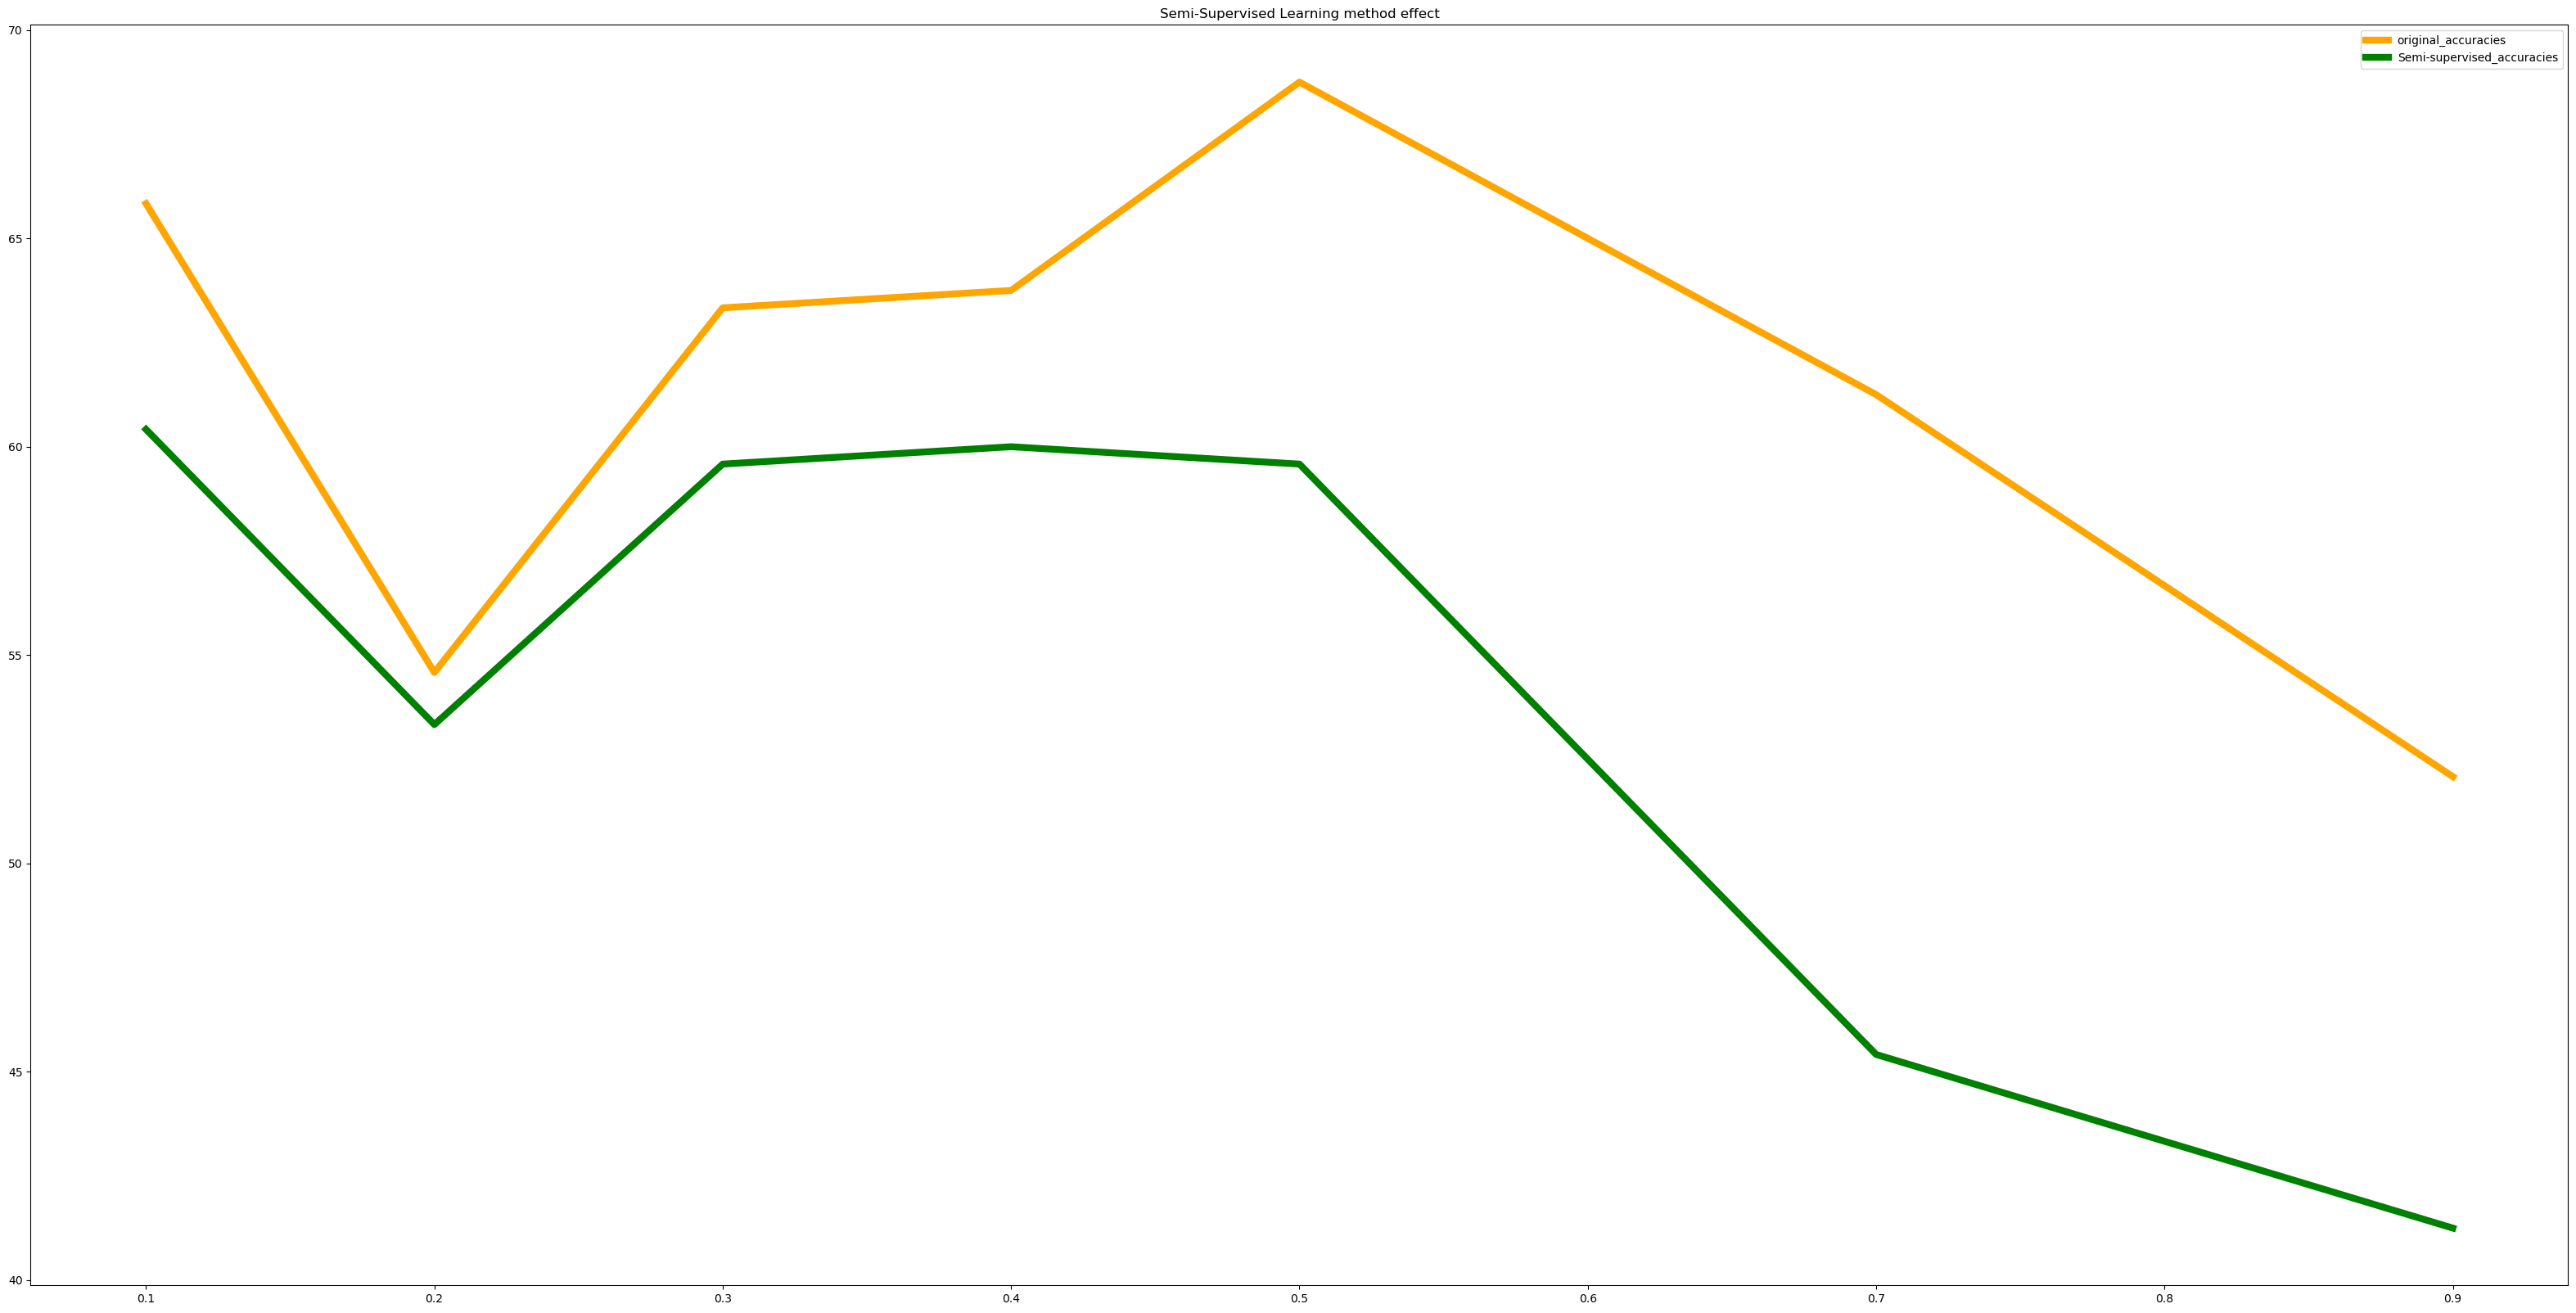

In [616]:
org_dic = res = dict(zip(parts, org_comp_accs))
plot_accs(org_dic, method_accs,"Semi-Supervised Learning method effect")

[90.0, 89.58333333333334, 87.5, 85.0, 92.91666666666667, 85.41666666666666, 85.41666666666666]
[95.41666666666667, 95.41666666666667, 96.66666666666667, 95.83333333333334, 94.58333333333333, 92.5, 82.91666666666667]


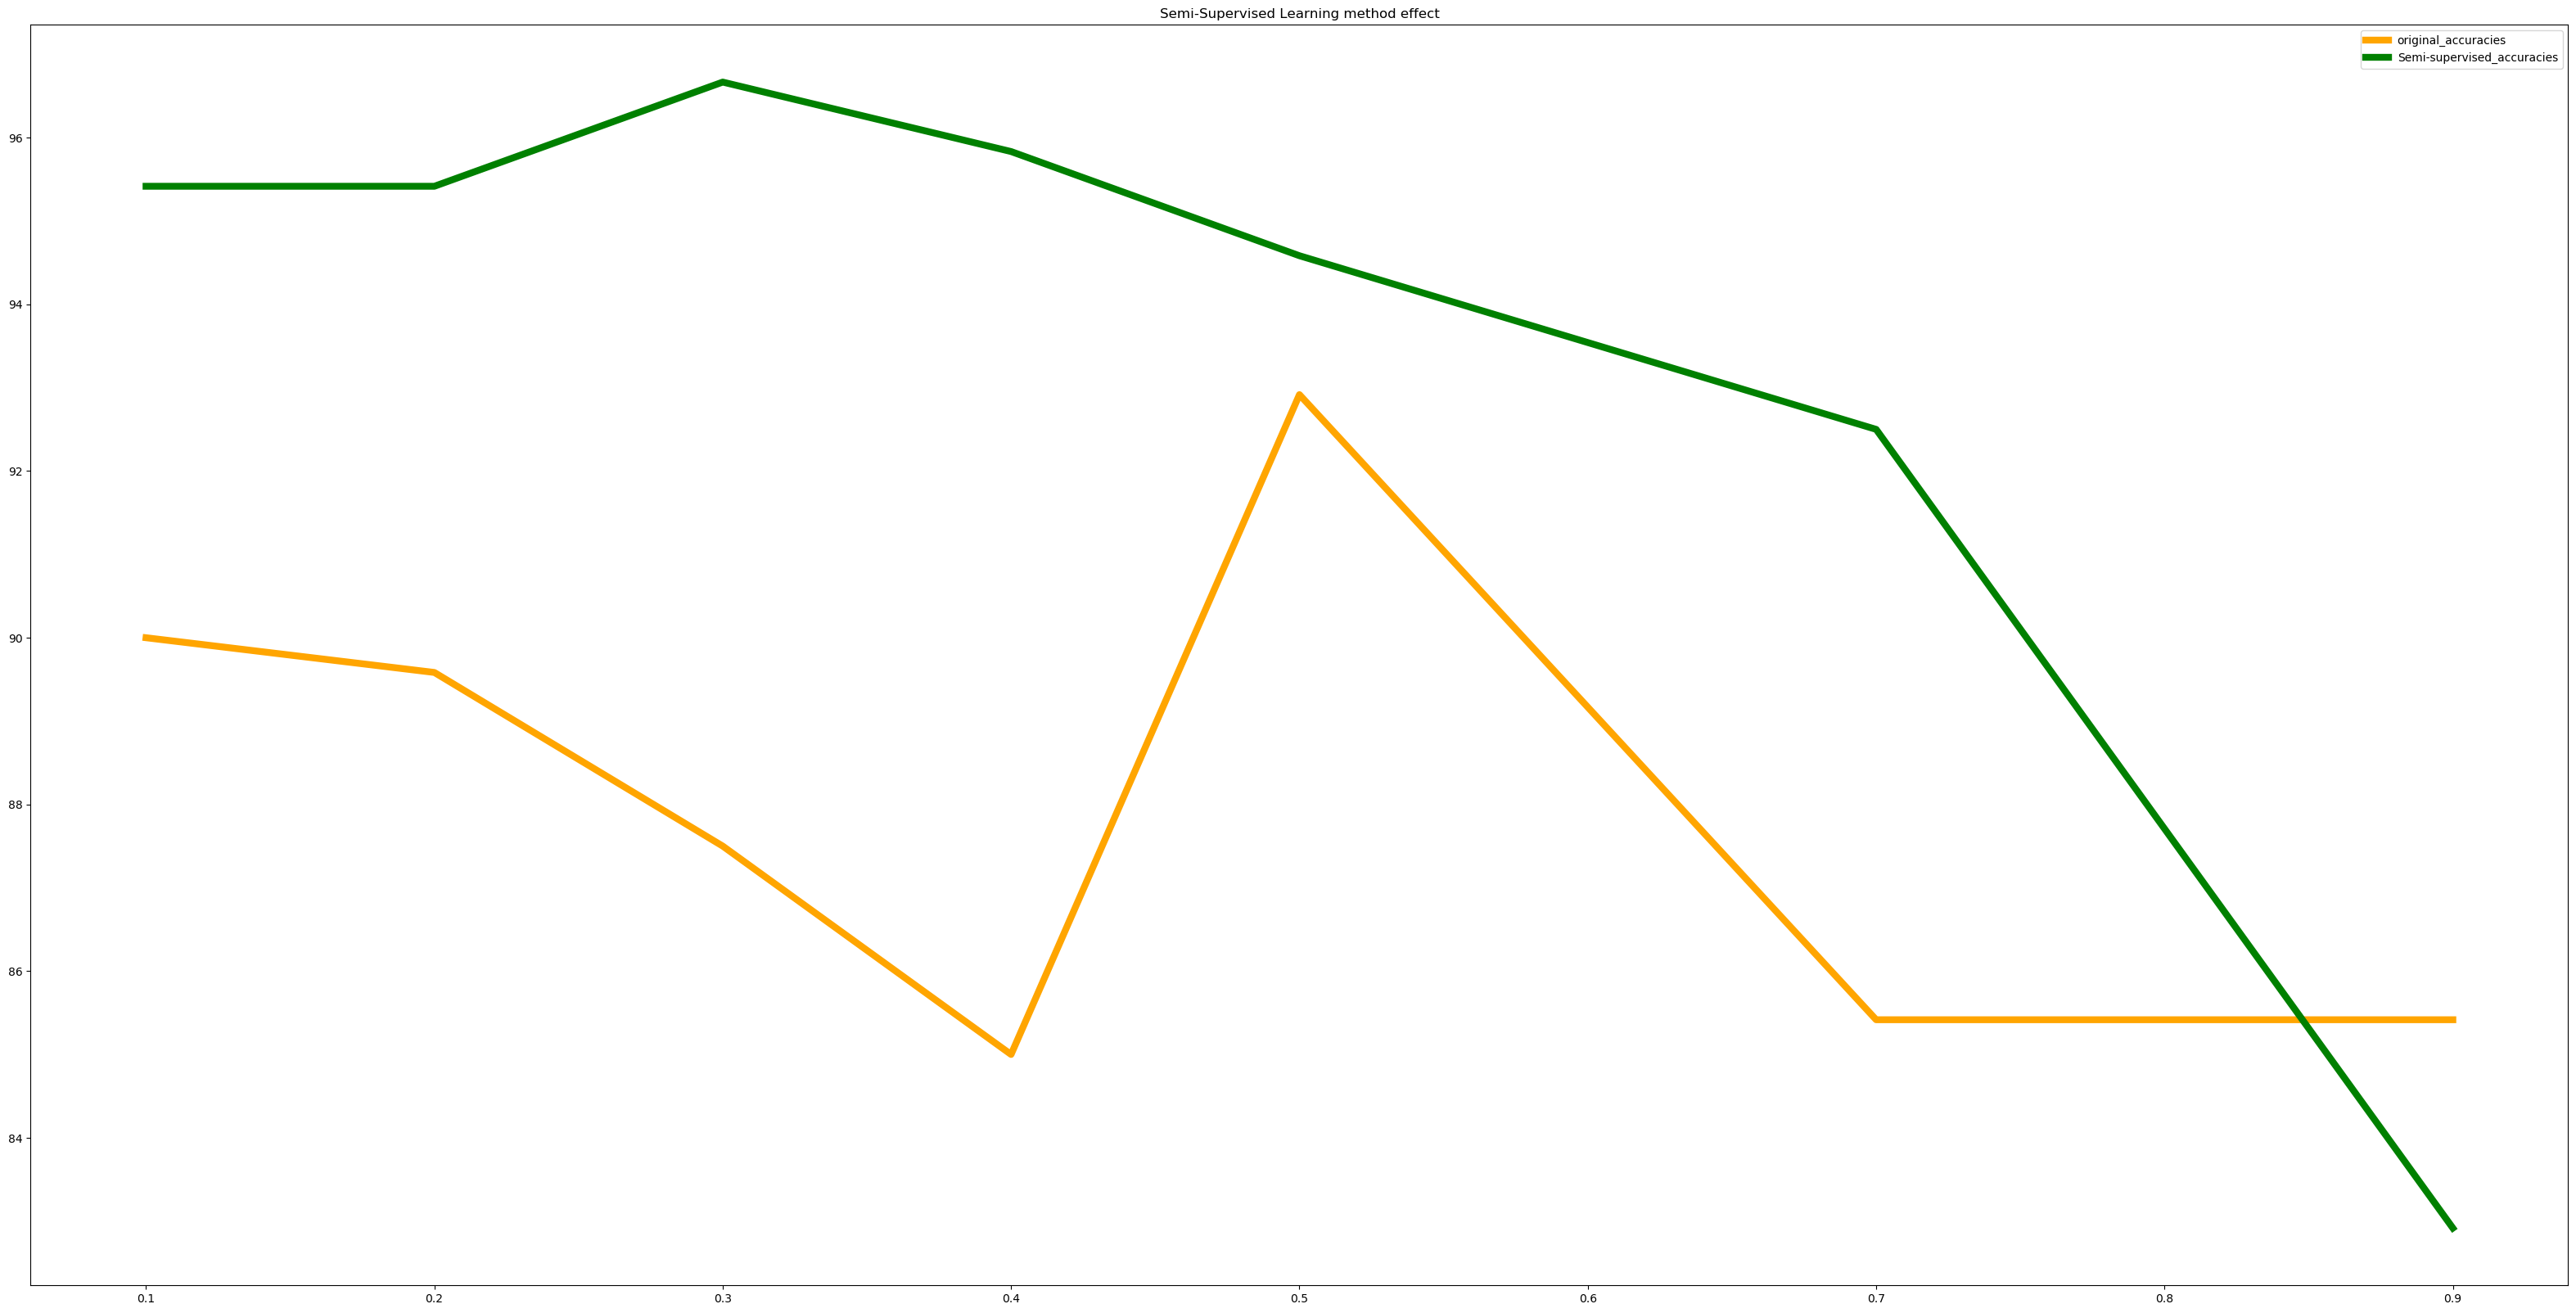

In [617]:
org_dic_room = res = dict(zip(parts, org_comp_accs_room))
plot_accs(org_dic_room, method_accs_room,"Semi-Supervised Learning method effect")

In [639]:
method_accs2 = []
org_comp_accs2 = []
method_accs_room2 = []
org_comp_accs_room2 = []
for par in parts:
    print(par)
    data_shape = (20,)
    latent_dim = 8
    input_layer = keras.Input(shape=data_shape)
    x = keras.layers.Dense(18, activation ='relu')(input_layer)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(10, activation ='relu')(x)
    means = keras.layers.Dense(latent_dim)(x)
    log_var = keras.layers.Dense(latent_dim)(x)

    z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

    encoder = keras.models.Model(input_layer, [means, log_var, z])

    decoder_input = keras.layers.Input(shape =(latent_dim,))
    x = keras.layers.Dense(10, activation ='relu')(decoder_input)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(18, activation ='relu')(x)
    outputs = keras.layers.Dense(20, activation ='sigmoid')(x)
    decoder = keras.models.Model(decoder_input, outputs)
    x_prime = decoder(z)
    outputs = decoder(encoder(input_layer)[2])
    vae = keras.models.Model(input_layer, outputs, name='vae')    
    vae.compile(loss=my_loss,optimizer="adam",metrics=["accuracy"])
    print(vae.summary())

    par_df, par_locations, par_df_test, par_test_loc = prep_data_for_synthesis(alpha_filtered2_train, par)

    his3 = vae.fit(min_max_scaler.fit_transform(par_df), min_max_scaler.fit_transform(par_df) , epochs = 100, batch_size = 8, validation_split= 0.2)

    outps = encoder.predict(min_max_scaler.fit_transform(par_df))

    new = generate_new_data(2000, outps)
    generated_dataframe = pd.DataFrame(new, columns = no_channel_training_cols)

    nolabels = [-1 for _ in range(len(generated_dataframe))]
    nolabels = pd.DataFrame(nolabels, columns = ['location'])
    frames = [pd.DataFrame(min_max_scaler.fit_transform(par_df), columns= no_channel_training_cols), generated_dataframe]
    train_combined = pd.concat(frames)

    semi_combined_lbs = pd.concat([par_locations, nolabels])
    label_propagator = LabelPropagation()
    label_propagator.fit(train_combined, semi_combined_lbs)
    all_labels = label_propagator.transduction_

#     ann_model3 = keras.Sequential()
#     ann_model3.add(keras.layers.InputLayer(input_shape = (20,)))
#     ann_model3.add(keras.layers.Dense(60, activation ='elu'))
#     ann_model3.add(keras.layers.Dropout(0.3))
#     ann_model3.add(keras.layers.Dense(80, activation ='elu'))
#     ann_model3.add(keras.layers.Dropout(0.3))
#     ann_model3.add(keras.layers.Dense(96))
#     ann_model3.summary()
    
#     ann_model3.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])
#     hist = ann_model3.fit(train_combined, all_labels , epochs=100,validation_split= 0.3)
#     test_loss, test_acc = ann_model3.evaluate(min_max_scaler.fit_transform(one_ten_df_test),  one_ten__test_loc, verbose=2)
#     pred_ann = ann_model3.predict(min_max_scaler.fit_transform(one_ten_df_test))
#     print("Neural Network algorithm prediction time: "+ str(runtime))
#     test_acc

    syn_semi_predictions_clf,runtime = run_knn(train_combined, all_labels, pd.DataFrame(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]), columns= no_channel_training_cols),[],5)

    method_accs2.append(accuracy_score(alpha_filtered2_test.loc[:, ['location']], syn_semi_predictions_clf)*100)

    room_lev_atarget = []
    for i in alpha_filtered2_test.loc[:, ['location']].to_numpy():
        room_lev_atarget.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    room_lev_test_semi = []
    for i in syn_semi_predictions_clf:
        room_lev_test_semi.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    method_accs_room2.append(accuracy_score(room_lev_atarget, room_lev_test_semi)*100)


    without_syn_predictions ,runtime = run_knn(min_max_scaler.fit_transform(par_df), par_locations, pd.DataFrame(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]), columns= no_channel_training_cols),[],5)

    org_comp_accs2.append(accuracy_score(alpha_filtered2_test.loc[:, ['location']], without_syn_predictions)*100)

    room_lev_test_without_pred_rf = []
    for i in without_syn_predictions:
        room_lev_test_without_pred_rf.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    org_comp_accs_room2.append(accuracy_score(room_lev_atarget, room_lev_test_without_pred_rf)*100)


0.1
Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_258 (InputLayer)       (None, 20)                0         
_________________________________________________________________
model_247 (Model)            [(None, 8), (None, 8), (N 999       
_________________________________________________________________
model_248 (Model)            (None, 20)                923       
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________
None
Train on 76 samples, validate on 20 samples
Epoch 1/100
76/76 [==============================] - 2s 31ms/step - loss: 13.8478 - accuracy: 0.0000e+00 - val_loss: 13.7890 - val_accuracy: 0.0000e+00
Epoch 2/100
76/76 [==============================] - 0s 696us/step - loss: 13.6744 - accuracy: 0.0526 - val_loss: 13.7072 - val_accuracy: 0.0500
Epoch 3/100
76/76 [======================

Epoch 52/100
76/76 [==============================] - 0s 698us/step - loss: 3.9063 - accuracy: 0.4474 - val_loss: 6.0858 - val_accuracy: 0.7000
Epoch 53/100
76/76 [==============================] - 0s 851us/step - loss: 3.8069 - accuracy: 0.5658 - val_loss: 6.1813 - val_accuracy: 0.6500
Epoch 54/100
76/76 [==============================] - 0s 741us/step - loss: 3.8463 - accuracy: 0.5789 - val_loss: 6.1154 - val_accuracy: 0.7000
Epoch 55/100
76/76 [==============================] - 0s 678us/step - loss: 3.8034 - accuracy: 0.6053 - val_loss: 5.6224 - val_accuracy: 0.8000
Epoch 56/100
76/76 [==============================] - 0s 647us/step - loss: 3.8491 - accuracy: 0.5132 - val_loss: 5.5858 - val_accuracy: 0.7500
Epoch 57/100
76/76 [==============================] - 0s 640us/step - loss: 3.9410 - accuracy: 0.5395 - val_loss: 5.7747 - val_accuracy: 0.8000
Epoch 58/100
76/76 [==============================] - 0s 720us/step - loss: 3.8765 - accuracy: 0.5789 - val_loss: 6.0962 - val_accuracy:

153/153 [==============================] - 0s 530us/step - loss: 12.1983 - accuracy: 0.2092 - val_loss: 11.9648 - val_accuracy: 0.0000e+00
Epoch 4/100
153/153 [==============================] - 0s 603us/step - loss: 10.3501 - accuracy: 0.2092 - val_loss: 11.0446 - val_accuracy: 0.0000e+00
Epoch 5/100
153/153 [==============================] - 0s 600us/step - loss: 8.9052 - accuracy: 0.2092 - val_loss: 10.5327 - val_accuracy: 0.0000e+00
Epoch 6/100
153/153 [==============================] - 0s 580us/step - loss: 8.0678 - accuracy: 0.2092 - val_loss: 10.2607 - val_accuracy: 0.0000e+00
Epoch 7/100
153/153 [==============================] - 0s 540us/step - loss: 7.5316 - accuracy: 0.2092 - val_loss: 10.1812 - val_accuracy: 0.0000e+00
Epoch 8/100
153/153 [==============================] - 0s 700us/step - loss: 7.2785 - accuracy: 0.2222 - val_loss: 10.2152 - val_accuracy: 0.1795
Epoch 9/100
153/153 [==============================] - 0s 608us/step - loss: 7.0954 - accuracy: 0.3987 - val_loss:

Epoch 59/100
153/153 [==============================] - 0s 612us/step - loss: 3.7625 - accuracy: 0.5752 - val_loss: 5.2701 - val_accuracy: 0.6667
Epoch 60/100
153/153 [==============================] - 0s 571us/step - loss: 3.8060 - accuracy: 0.5359 - val_loss: 5.4595 - val_accuracy: 0.6667
Epoch 61/100
153/153 [==============================] - 0s 610us/step - loss: 3.7981 - accuracy: 0.5294 - val_loss: 5.3812 - val_accuracy: 0.6667
Epoch 62/100
153/153 [==============================] - 0s 588us/step - loss: 3.7532 - accuracy: 0.5294 - val_loss: 5.3193 - val_accuracy: 0.6667
Epoch 63/100
153/153 [==============================] - 0s 701us/step - loss: 3.8032 - accuracy: 0.5359 - val_loss: 5.3633 - val_accuracy: 0.6667
Epoch 64/100
153/153 [==============================] - 0s 762us/step - loss: 3.7846 - accuracy: 0.5163 - val_loss: 5.3694 - val_accuracy: 0.6667
Epoch 65/100
153/153 [==============================] - 0s 836us/step - loss: 3.8321 - accuracy: 0.5163 - val_loss: 5.5686 -

256/256 [==============================] - 0s 513us/step - loss: 6.3542 - accuracy: 0.4336 - val_loss: 10.0075 - val_accuracy: 0.6406
Epoch 10/100
256/256 [==============================] - 0s 461us/step - loss: 5.8767 - accuracy: 0.4844 - val_loss: 9.4757 - val_accuracy: 0.6406
Epoch 11/100
256/256 [==============================] - 0s 497us/step - loss: 5.2516 - accuracy: 0.4414 - val_loss: 8.3877 - val_accuracy: 0.6406
Epoch 12/100
256/256 [==============================] - 0s 458us/step - loss: 4.7447 - accuracy: 0.4258 - val_loss: 7.5742 - val_accuracy: 0.6406
Epoch 13/100
256/256 [==============================] - 0s 470us/step - loss: 4.3688 - accuracy: 0.3672 - val_loss: 7.1086 - val_accuracy: 0.6406
Epoch 14/100
256/256 [==============================] - 0s 469us/step - loss: 4.1351 - accuracy: 0.4258 - val_loss: 6.2695 - val_accuracy: 0.6406
Epoch 15/100
256/256 [==============================] - 0s 446us/step - loss: 3.9509 - accuracy: 0.4297 - val_loss: 5.8526 - val_accurac

256/256 [==============================] - 0s 463us/step - loss: 3.5670 - accuracy: 0.6055 - val_loss: 4.7924 - val_accuracy: 0.6406
Epoch 66/100
256/256 [==============================] - 0s 459us/step - loss: 3.5238 - accuracy: 0.6016 - val_loss: 4.8681 - val_accuracy: 0.6406
Epoch 67/100
256/256 [==============================] - 0s 489us/step - loss: 3.5691 - accuracy: 0.6055 - val_loss: 4.8600 - val_accuracy: 0.6406
Epoch 68/100
256/256 [==============================] - 0s 465us/step - loss: 3.5411 - accuracy: 0.6367 - val_loss: 4.9279 - val_accuracy: 0.6406
Epoch 69/100
256/256 [==============================] - 0s 476us/step - loss: 3.5426 - accuracy: 0.6367 - val_loss: 4.8370 - val_accuracy: 0.6406
Epoch 70/100
256/256 [==============================] - 0s 461us/step - loss: 3.5941 - accuracy: 0.6094 - val_loss: 4.8817 - val_accuracy: 0.6406
Epoch 71/100
256/256 [==============================] - 0s 481us/step - loss: 3.5695 - accuracy: 0.6406 - val_loss: 4.7835 - val_accuracy

Epoch 16/100
384/384 [==============================] - 0s 524us/step - loss: 3.4767 - accuracy: 0.2969 - val_loss: 5.1892 - val_accuracy: 0.1146
Epoch 17/100
384/384 [==============================] - 0s 551us/step - loss: 3.4705 - accuracy: 0.3099 - val_loss: 5.2743 - val_accuracy: 0.1354
Epoch 18/100
384/384 [==============================] - 0s 517us/step - loss: 3.4565 - accuracy: 0.3490 - val_loss: 5.1049 - val_accuracy: 0.1562
Epoch 19/100
384/384 [==============================] - 0s 507us/step - loss: 3.4550 - accuracy: 0.3542 - val_loss: 5.0593 - val_accuracy: 0.1458
Epoch 20/100
384/384 [==============================] - 0s 499us/step - loss: 3.4191 - accuracy: 0.3776 - val_loss: 5.0116 - val_accuracy: 0.1458
Epoch 21/100
384/384 [==============================] - 0s 542us/step - loss: 3.4316 - accuracy: 0.3672 - val_loss: 5.0280 - val_accuracy: 0.2396
Epoch 22/100
384/384 [==============================] - 0s 543us/step - loss: 3.4702 - accuracy: 0.4062 - val_loss: 5.0362 -

384/384 [==============================] - 0s 680us/step - loss: 3.3191 - accuracy: 0.5469 - val_loss: 4.6112 - val_accuracy: 0.5000
Epoch 73/100
384/384 [==============================] - 0s 657us/step - loss: 3.3086 - accuracy: 0.5469 - val_loss: 4.6306 - val_accuracy: 0.3646
Epoch 74/100
384/384 [==============================] - 0s 759us/step - loss: 3.3207 - accuracy: 0.5312 - val_loss: 4.6142 - val_accuracy: 0.4062
Epoch 75/100
384/384 [==============================] - 0s 714us/step - loss: 3.3275 - accuracy: 0.5547 - val_loss: 4.5839 - val_accuracy: 0.5312
Epoch 76/100
384/384 [==============================] - 0s 708us/step - loss: 3.3167 - accuracy: 0.5547 - val_loss: 4.6315 - val_accuracy: 0.5417
Epoch 77/100
384/384 [==============================] - 0s 748us/step - loss: 3.3372 - accuracy: 0.5260 - val_loss: 4.6308 - val_accuracy: 0.2708
Epoch 78/100
384/384 [==============================] - 0s 823us/step - loss: 3.3206 - accuracy: 0.5677 - val_loss: 4.5887 - val_accuracy

Epoch 23/100
384/384 [==============================] - 0s 961us/step - loss: 3.4631 - accuracy: 0.3594 - val_loss: 5.4871 - val_accuracy: 0.3854
Epoch 24/100
384/384 [==============================] - 0s 923us/step - loss: 3.4419 - accuracy: 0.4766 - val_loss: 5.3567 - val_accuracy: 0.5417
Epoch 25/100
384/384 [==============================] - 0s 925us/step - loss: 3.4165 - accuracy: 0.4453 - val_loss: 5.3773 - val_accuracy: 0.4896
Epoch 26/100
384/384 [==============================] - 0s 932us/step - loss: 3.4514 - accuracy: 0.4427 - val_loss: 5.1827 - val_accuracy: 0.5000
Epoch 27/100
384/384 [==============================] - 0s 929us/step - loss: 3.4237 - accuracy: 0.4271 - val_loss: 5.1278 - val_accuracy: 0.5104
Epoch 28/100
384/384 [==============================] - 0s 932us/step - loss: 3.4148 - accuracy: 0.4583 - val_loss: 5.1246 - val_accuracy: 0.4583
Epoch 29/100
384/384 [==============================] - 0s 935us/step - loss: 3.3912 - accuracy: 0.4557 - val_loss: 5.0576 -

Epoch 80/100
384/384 [==============================] - 0s 1ms/step - loss: 3.2924 - accuracy: 0.5417 - val_loss: 4.6531 - val_accuracy: 0.4062
Epoch 81/100
384/384 [==============================] - 0s 1ms/step - loss: 3.3173 - accuracy: 0.5547 - val_loss: 4.6050 - val_accuracy: 0.4896
Epoch 82/100
384/384 [==============================] - 0s 1ms/step - loss: 3.3260 - accuracy: 0.5755 - val_loss: 4.6967 - val_accuracy: 0.5104
Epoch 83/100
384/384 [==============================] - 0s 1ms/step - loss: 3.3216 - accuracy: 0.6068 - val_loss: 4.7178 - val_accuracy: 0.4583
Epoch 84/100
384/384 [==============================] - 0s 1ms/step - loss: 3.2970 - accuracy: 0.5807 - val_loss: 4.6975 - val_accuracy: 0.3646
Epoch 85/100
384/384 [==============================] - 0s 1ms/step - loss: 3.3016 - accuracy: 0.5807 - val_loss: 4.6346 - val_accuracy: 0.3646
Epoch 86/100
384/384 [==============================] - 0s 1ms/step - loss: 3.2979 - accuracy: 0.5859 - val_loss: 4.6544 - val_accuracy:

Epoch 31/100
511/511 [==============================] - 0s 577us/step - loss: 3.2962 - accuracy: 0.5851 - val_loss: 4.8101 - val_accuracy: 0.9141
Epoch 32/100
511/511 [==============================] - 0s 573us/step - loss: 3.3068 - accuracy: 0.6067 - val_loss: 4.7001 - val_accuracy: 0.9141
Epoch 33/100
511/511 [==============================] - 0s 564us/step - loss: 3.2712 - accuracy: 0.6086 - val_loss: 4.8078 - val_accuracy: 0.9141
Epoch 34/100
511/511 [==============================] - 0s 585us/step - loss: 3.2883 - accuracy: 0.6380 - val_loss: 4.6588 - val_accuracy: 0.9141
Epoch 35/100
511/511 [==============================] - 0s 574us/step - loss: 3.2919 - accuracy: 0.6204 - val_loss: 4.7529 - val_accuracy: 0.9141
Epoch 36/100
511/511 [==============================] - 0s 566us/step - loss: 3.2694 - accuracy: 0.6321 - val_loss: 4.7120 - val_accuracy: 0.9141
Epoch 37/100
511/511 [==============================] - 0s 623us/step - loss: 3.2791 - accuracy: 0.6243 - val_loss: 4.6266 -

511/511 [==============================] - 0s 568us/step - loss: 3.1905 - accuracy: 0.6771 - val_loss: 4.7076 - val_accuracy: 0.9141
Epoch 88/100
511/511 [==============================] - 0s 548us/step - loss: 3.1828 - accuracy: 0.6928 - val_loss: 4.6336 - val_accuracy: 0.8906
Epoch 89/100
511/511 [==============================] - 0s 555us/step - loss: 3.2153 - accuracy: 0.6575 - val_loss: 4.8129 - val_accuracy: 0.8516
Epoch 90/100
511/511 [==============================] - 0s 556us/step - loss: 3.1821 - accuracy: 0.6497 - val_loss: 4.5369 - val_accuracy: 0.6328
Epoch 91/100
511/511 [==============================] - 0s 549us/step - loss: 3.2102 - accuracy: 0.6341 - val_loss: 5.0976 - val_accuracy: 0.6016
Epoch 92/100
511/511 [==============================] - 0s 554us/step - loss: 3.2294 - accuracy: 0.6477 - val_loss: 4.5254 - val_accuracy: 0.6094
Epoch 93/100
511/511 [==============================] - 0s 549us/step - loss: 3.1913 - accuracy: 0.6458 - val_loss: 4.6912 - val_accuracy

Epoch 38/100
690/690 [==============================] - 0s 547us/step - loss: 3.2582 - accuracy: 0.3609 - val_loss: 4.6438 - val_accuracy: 0.6012
Epoch 39/100
690/690 [==============================] - 0s 541us/step - loss: 3.2341 - accuracy: 0.3797 - val_loss: 4.6296 - val_accuracy: 0.6012
Epoch 40/100
690/690 [==============================] - 0s 539us/step - loss: 3.2426 - accuracy: 0.3783 - val_loss: 4.6850 - val_accuracy: 0.6012
Epoch 41/100
690/690 [==============================] - 0s 545us/step - loss: 3.2314 - accuracy: 0.3435 - val_loss: 4.5990 - val_accuracy: 0.6012
Epoch 42/100
690/690 [==============================] - 0s 542us/step - loss: 3.2362 - accuracy: 0.3435 - val_loss: 4.5961 - val_accuracy: 0.6012
Epoch 43/100
690/690 [==============================] - 0s 549us/step - loss: 3.2427 - accuracy: 0.3464 - val_loss: 4.7641 - val_accuracy: 0.6012
Epoch 44/100
690/690 [==============================] - 0s 552us/step - loss: 3.2178 - accuracy: 0.3478 - val_loss: 4.6793 -

690/690 [==============================] - 0s 706us/step - loss: 3.2015 - accuracy: 0.4304 - val_loss: 4.5555 - val_accuracy: 0.5376
Epoch 95/100
690/690 [==============================] - 0s 690us/step - loss: 3.1938 - accuracy: 0.4667 - val_loss: 4.6675 - val_accuracy: 0.6012
Epoch 96/100
690/690 [==============================] - 1s 747us/step - loss: 3.1923 - accuracy: 0.4507 - val_loss: 4.5173 - val_accuracy: 0.5665
Epoch 97/100
690/690 [==============================] - 0s 682us/step - loss: 3.1867 - accuracy: 0.4391 - val_loss: 4.6318 - val_accuracy: 0.5491
Epoch 98/100
690/690 [==============================] - 1s 752us/step - loss: 3.1944 - accuracy: 0.4884 - val_loss: 4.5468 - val_accuracy: 0.6127
Epoch 99/100
690/690 [==============================] - 0s 694us/step - loss: 3.1853 - accuracy: 0.4609 - val_loss: 4.5648 - val_accuracy: 0.5434
Epoch 100/100
690/690 [==============================] - 0s 665us/step - loss: 3.1878 - accuracy: 0.5072 - val_loss: 4.6243 - val_accurac

[63.74999999999999, 58.75, 68.75, 68.75, 57.08333333333333, 51.24999999999999, 25.833333333333336]
[60.0, 57.91666666666667, 64.16666666666667, 65.0, 52.083333333333336, 47.083333333333336, 25.833333333333336]


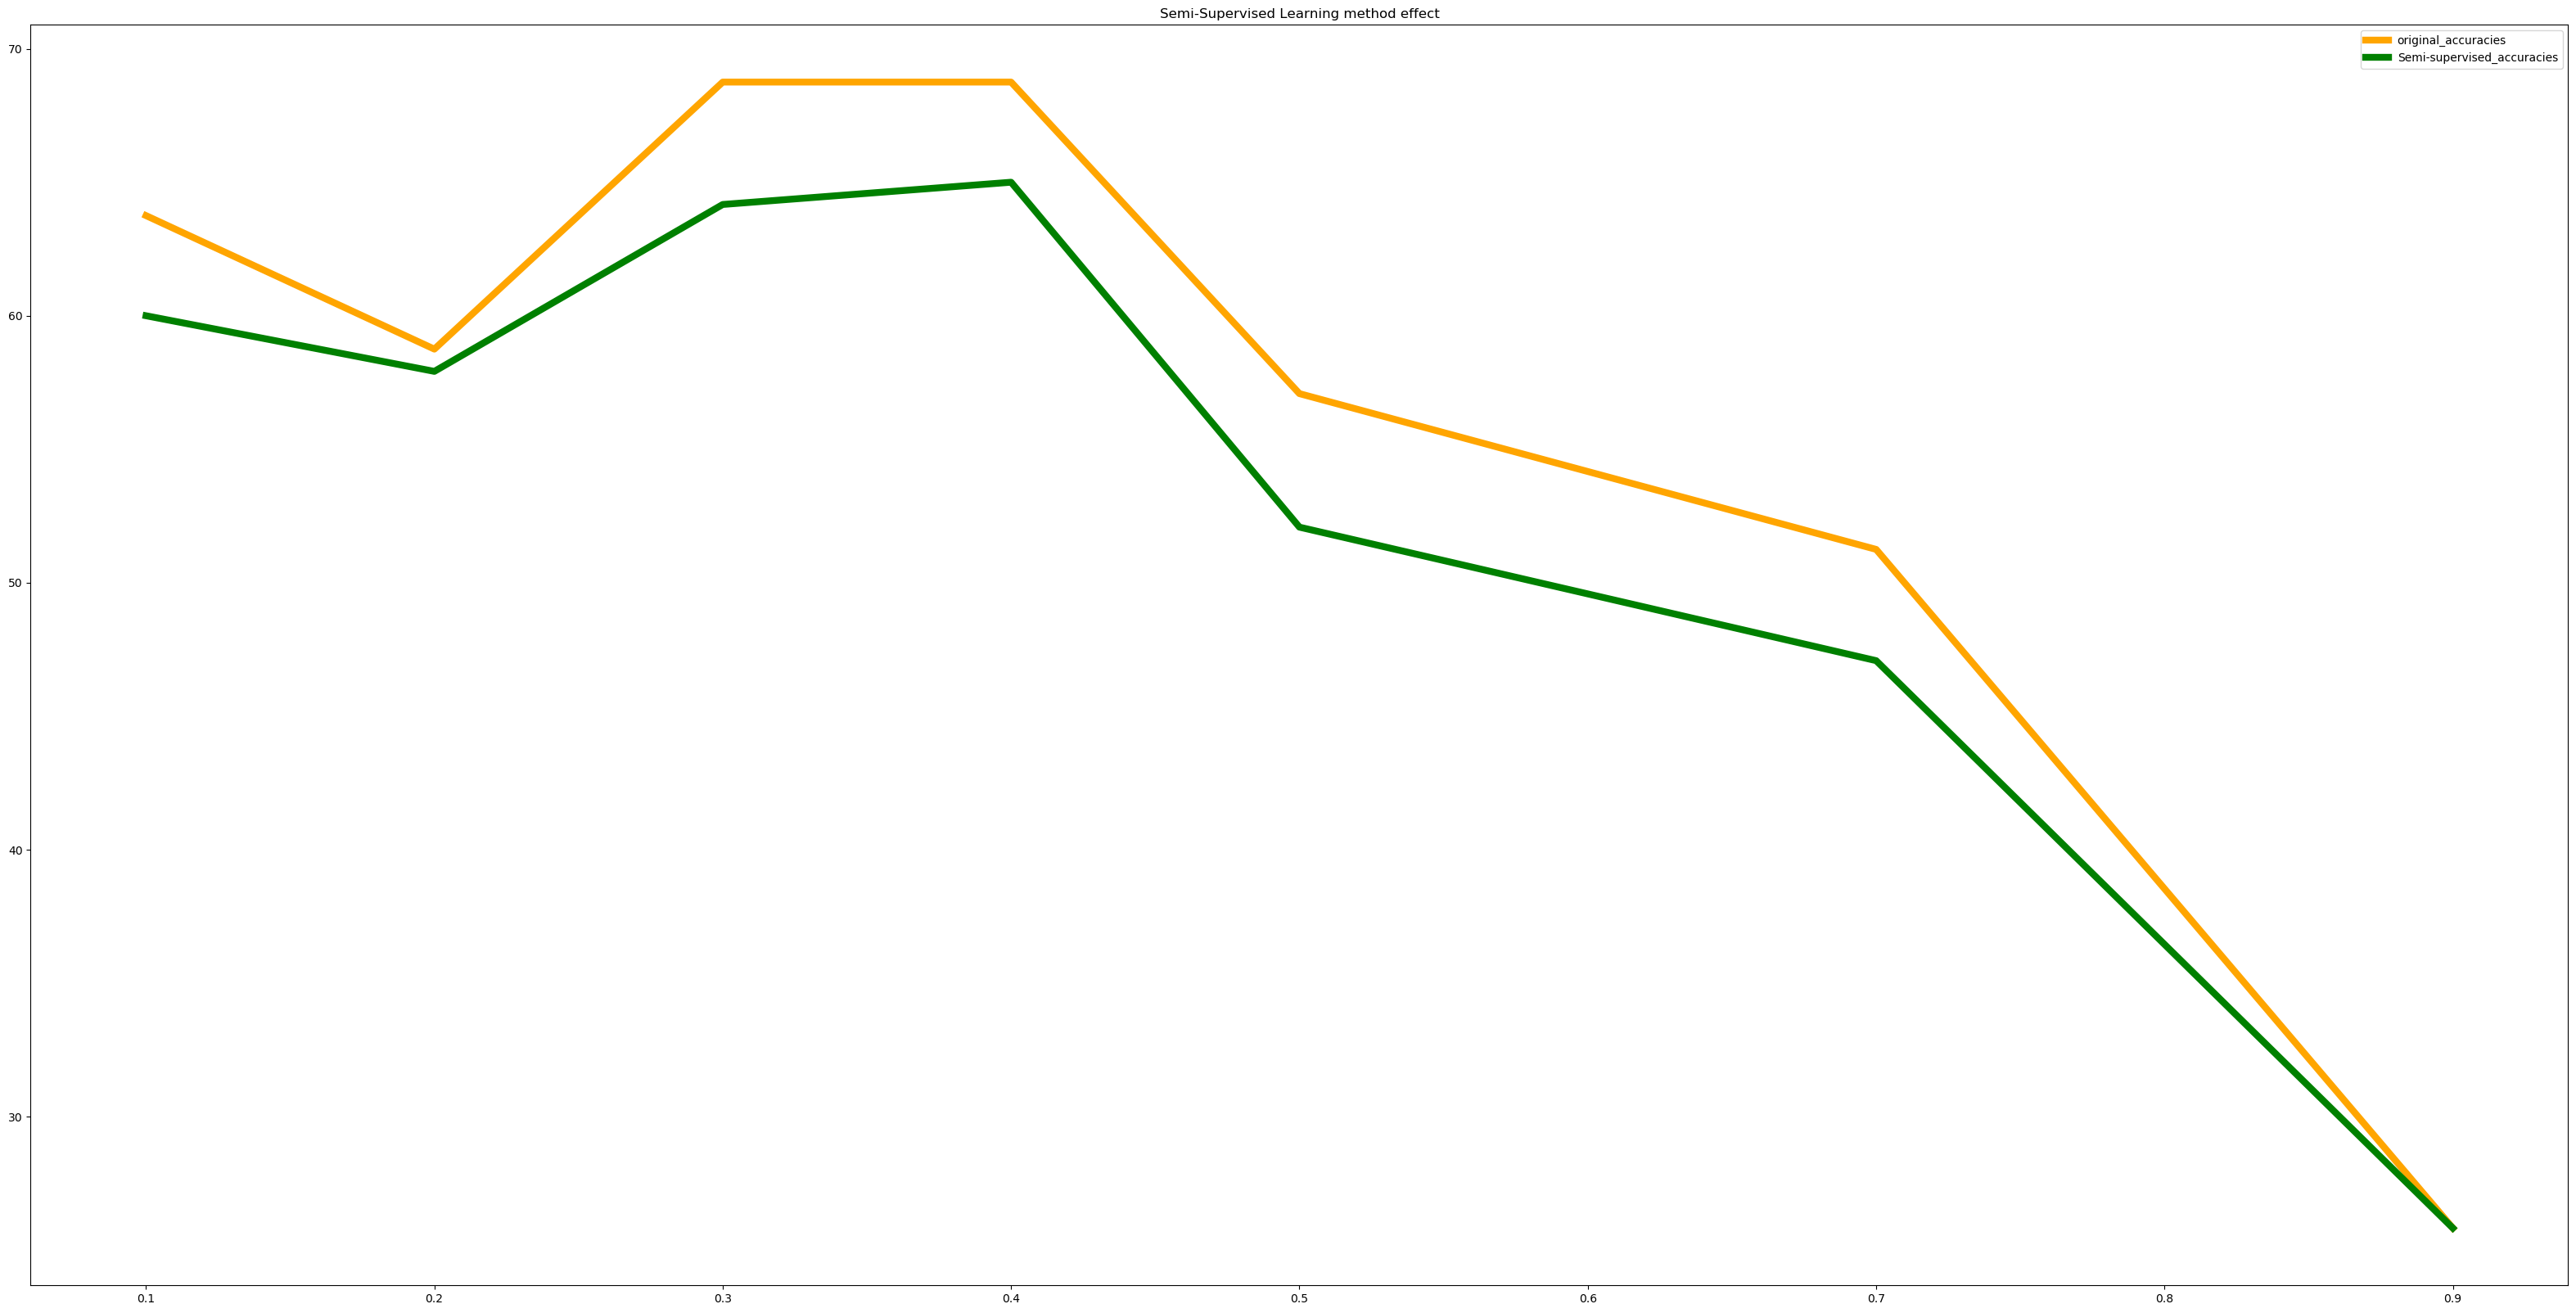

In [640]:
org_dic2 = res = dict(zip(parts, org_comp_accs2))
plot_accs(org_dic2, method_accs2,"Semi-Supervised Learning method effect")

[94.16666666666667, 94.16666666666667, 97.5, 97.5, 96.66666666666667, 91.25, 84.58333333333333]
[92.08333333333333, 91.66666666666666, 95.41666666666667, 95.83333333333334, 89.16666666666667, 88.75, 86.66666666666667]


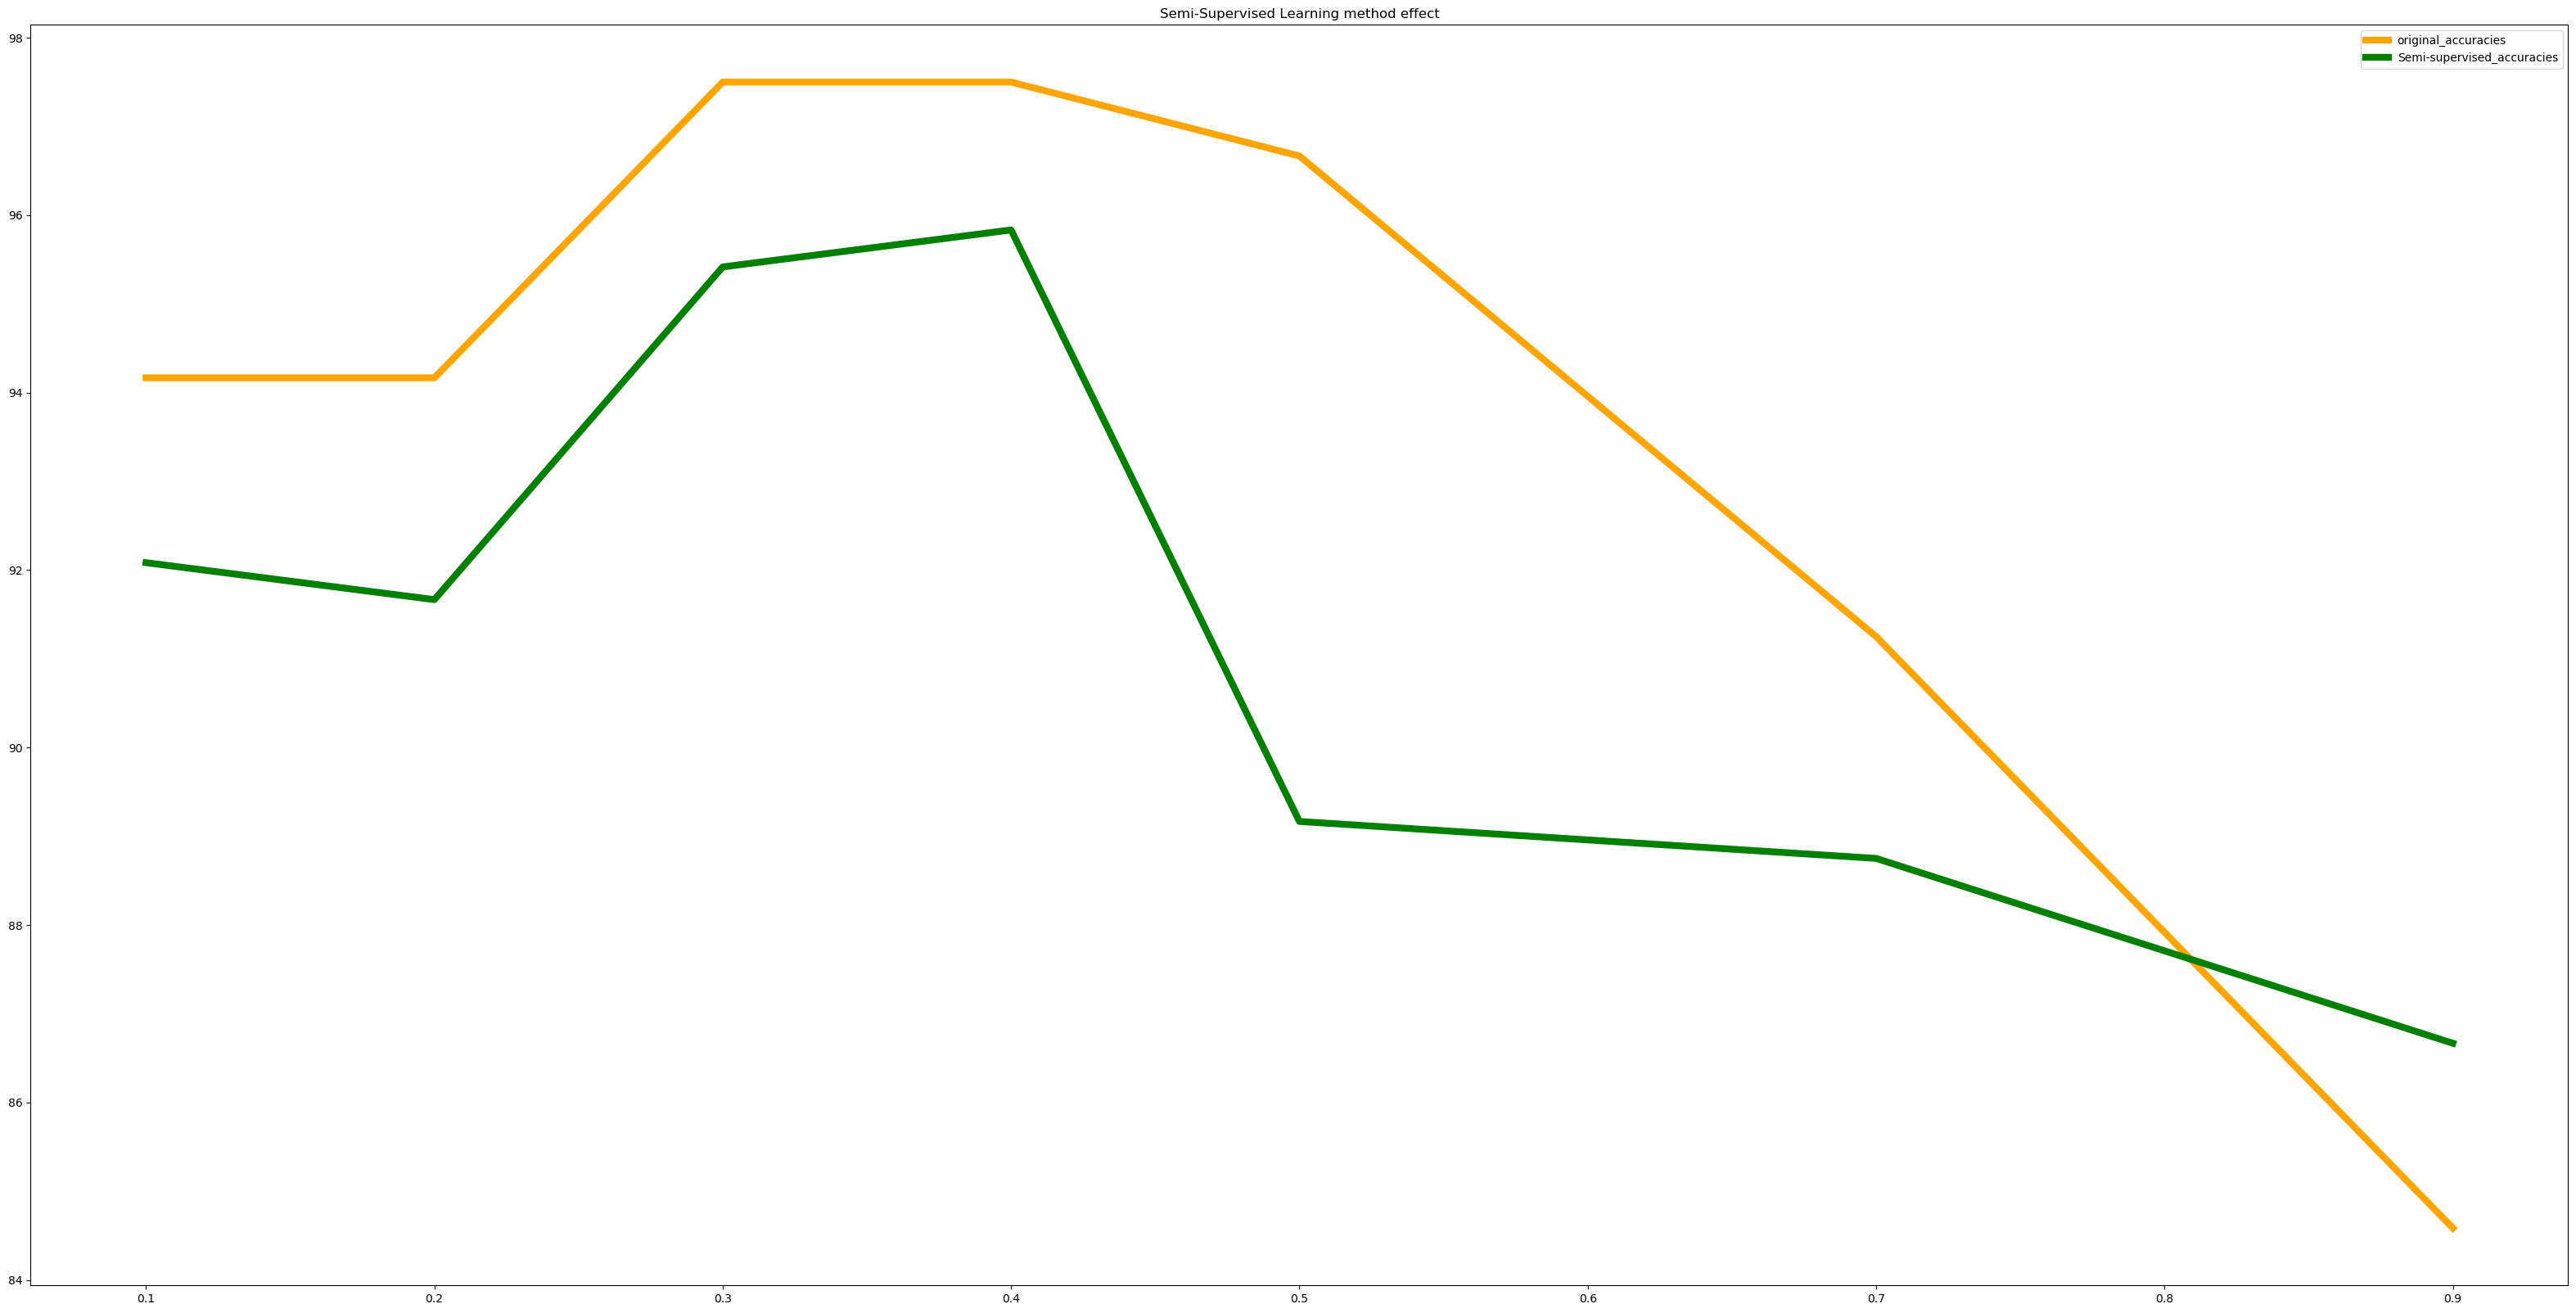

In [641]:
org_dic_room2 = res = dict(zip(parts, org_comp_accs_room2))
plot_accs(org_dic_room2, method_accs_room2,"Semi-Supervised Learning method effect")

In [ ]:
parts = [0.1,0.2, 0.3,0.4, 0.5, 0.7, 0.9]

In [651]:
method_accs3 = []
org_comp_accs3 = []
method_accs_room3 = []
org_comp_accs_room3 = []
for par in parts:
    print(par)
    data_shape = (20,)
    latent_dim = 8
    input_layer = keras.Input(shape=data_shape)
    x = keras.layers.Dense(18, activation ='relu')(input_layer)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(10, activation ='relu')(x)
    means = keras.layers.Dense(latent_dim)(x)
    log_var = keras.layers.Dense(latent_dim)(x)

    z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

    encoder = keras.models.Model(input_layer, [means, log_var, z])

    decoder_input = keras.layers.Input(shape =(latent_dim,))
    x = keras.layers.Dense(10, activation ='relu')(decoder_input)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(18, activation ='relu')(x)
    outputs = keras.layers.Dense(20, activation ='sigmoid')(x)
    decoder = keras.models.Model(decoder_input, outputs)
    x_prime = decoder(z)
    outputs = decoder(encoder(input_layer)[2])
    vae = keras.models.Model(input_layer, outputs, name='vae')    
    vae.compile(loss=my_loss,optimizer="adam",metrics=["accuracy"])
    print(vae.summary())

    par_df, par_locations, par_df_test, par_test_loc = prep_data_for_synthesis(alpha_filtered2_train, par)

    his3 = vae.fit(min_max_scaler.fit_transform(par_df), min_max_scaler.fit_transform(par_df) , epochs = 100, batch_size = 8, validation_split= 0.2)

    outps = encoder.predict(min_max_scaler.fit_transform(par_df))

    new = generate_new_data(1000, outps)
    generated_dataframe = pd.DataFrame(new, columns = no_channel_training_cols)

    nolabels = [-1 for _ in range(len(generated_dataframe))]
    nolabels = pd.DataFrame(nolabels, columns = ['location'])
    frames = [pd.DataFrame(min_max_scaler.fit_transform(par_df), columns= no_channel_training_cols), generated_dataframe]
    train_combined = pd.concat(frames)

    semi_combined_lbs = pd.concat([par_locations, nolabels])
    label_propagator = LabelPropagation()
    label_propagator.fit(train_combined, semi_combined_lbs)
    all_labels = label_propagator.transduction_

    ann_model3 = keras.Sequential()
    ann_model3.add(keras.layers.InputLayer(input_shape = (20,)))
    ann_model3.add(keras.layers.Dense(60, activation ='relu'))
    ann_model3.add(keras.layers.Dropout(0.1))
    ann_model3.add(keras.layers.Dense(80, activation ='relu'))
    ann_model3.add(keras.layers.Dropout(0.1))
    ann_model3.add(keras.layers.Dense(96))
    ann_model3.summary()
    
    ann_model3.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])
    hist = ann_model3.fit(train_combined, all_labels , epochs=70,validation_split= 0.3)
    test_loss, test_acc = ann_model3.evaluate(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]), alpha_filtered2_test.loc[:, ['location']], verbose=2)

    method_accs3.append(test_acc*100)

#     room_lev_atarget = []
#     for i in alpha_filtered2_test.loc[:, ['location']].to_numpy():
#         room_lev_atarget.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

#     room_lev_test_semi = []
#     for i in syn_semi_predictions_clf:
#         room_lev_test_semi.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

#     method_accs_room2.append(accuracy_score(room_lev_atarget, room_lev_test_semi)*100)

    ann_model3 = keras.Sequential()
    ann_model3.add(keras.layers.InputLayer(input_shape = (20,)))
    ann_model3.add(keras.layers.Dense(60, activation ='relu'))
    ann_model3.add(keras.layers.Dropout(0.1))
    ann_model3.add(keras.layers.Dense(80, activation ='relu'))
    ann_model3.add(keras.layers.Dropout(0.1))
    ann_model3.add(keras.layers.Dense(96))
    ann_model3.summary()
    
    ann_model3.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])
    hist = ann_model3.fit(min_max_scaler.fit_transform(par_df), par_locations, epochs=70,validation_split= 0.3)
    test_loss, test_acc = ann_model3.evaluate(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]), alpha_filtered2_test.loc[:, ['location']], verbose=2)

    org_comp_accs3.append(test_acc*100)

#     without_syn_predictions ,runtime = run_knn(min_max_scaler.fit_transform(par_df), par_locations, pd.DataFrame(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]), columns= no_channel_training_cols),[],3)

#     org_comp_accs2.append(accuracy_score(alpha_filtered2_test.loc[:, ['location']], without_syn_predictions)*100)

#     room_lev_test_without_pred_rf = []
#     for i in without_syn_predictions:
#         room_lev_test_without_pred_rf.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

#     org_comp_accs_room2.append(accuracy_score(room_lev_atarget, room_lev_test_without_pred_rf)*100)


0.1
Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_306 (InputLayer)       (None, 20)                0         
_________________________________________________________________
model_279 (Model)            [(None, 8), (None, 8), (N 999       
_________________________________________________________________
model_280 (Model)            (None, 20)                923       
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________
None
Train on 76 samples, validate on 20 samples
Epoch 1/100
76/76 [==============================] - 2s 24ms/step - loss: 13.9819 - accuracy: 0.1184 - val_loss: 13.9322 - val_accuracy: 0.4000
Epoch 2/100
76/76 [==============================] - 0s 638us/step - loss: 13.7484 - accuracy: 0.3553 - val_loss: 13.7930 - val_accuracy: 0.6500
Epoch 3/100
76/76 [==============================

76/76 [==============================] - 0s 519us/step - loss: 3.8965 - accuracy: 0.4474 - val_loss: 5.5916 - val_accuracy: 0.6500
Epoch 53/100
76/76 [==============================] - 0s 479us/step - loss: 3.8805 - accuracy: 0.5132 - val_loss: 5.4488 - val_accuracy: 0.6500
Epoch 54/100
76/76 [==============================] - 0s 501us/step - loss: 3.8255 - accuracy: 0.5526 - val_loss: 5.5110 - val_accuracy: 0.6500
Epoch 55/100
76/76 [==============================] - 0s 483us/step - loss: 3.8423 - accuracy: 0.5000 - val_loss: 5.2531 - val_accuracy: 0.6500
Epoch 56/100
76/76 [==============================] - 0s 496us/step - loss: 3.8639 - accuracy: 0.5395 - val_loss: 5.5081 - val_accuracy: 0.6500
Epoch 57/100
76/76 [==============================] - 0s 539us/step - loss: 3.8684 - accuracy: 0.5132 - val_loss: 5.2936 - val_accuracy: 0.6500
Epoch 58/100
76/76 [==============================] - 0s 460us/step - loss: 3.8086 - accuracy: 0.5789 - val_loss: 5.3941 - val_accuracy: 0.6500
Epoch

767/767 [==============================] - 1s 1ms/step - loss: 4.3661 - accuracy: 0.1382 - val_loss: 3.9848 - val_accuracy: 0.3040
Epoch 2/70
767/767 [==============================] - 0s 155us/step - loss: 3.7172 - accuracy: 0.1825 - val_loss: 3.0687 - val_accuracy: 0.2948
Epoch 3/70
767/767 [==============================] - 0s 156us/step - loss: 3.1514 - accuracy: 0.2399 - val_loss: 2.5842 - val_accuracy: 0.3769
Epoch 4/70
767/767 [==============================] - 0s 154us/step - loss: 2.8272 - accuracy: 0.2920 - val_loss: 2.2378 - val_accuracy: 0.4316
Epoch 5/70
767/767 [==============================] - 0s 151us/step - loss: 2.5629 - accuracy: 0.3442 - val_loss: 2.0197 - val_accuracy: 0.4894
Epoch 6/70
767/767 [==============================] - 0s 149us/step - loss: 2.4141 - accuracy: 0.3677 - val_loss: 1.8801 - val_accuracy: 0.4863
Epoch 7/70
767/767 [==============================] - 0s 149us/step - loss: 2.2930 - accuracy: 0.3963 - val_loss: 1.7463 - val_accuracy: 0.5228
Epoch

767/767 [==============================] - 0s 157us/step - loss: 1.1021 - accuracy: 0.6297 - val_loss: 0.6528 - val_accuracy: 0.8359
Epoch 58/70
767/767 [==============================] - 0s 156us/step - loss: 1.0787 - accuracy: 0.6480 - val_loss: 0.6444 - val_accuracy: 0.8298
Epoch 59/70
767/767 [==============================] - 0s 156us/step - loss: 1.1050 - accuracy: 0.6415 - val_loss: 0.6425 - val_accuracy: 0.8389
Epoch 60/70
767/767 [==============================] - 0s 168us/step - loss: 1.1103 - accuracy: 0.6506 - val_loss: 0.6534 - val_accuracy: 0.8055
Epoch 61/70
767/767 [==============================] - 0s 159us/step - loss: 1.0625 - accuracy: 0.6558 - val_loss: 0.6519 - val_accuracy: 0.7872
Epoch 62/70
767/767 [==============================] - 0s 160us/step - loss: 1.0685 - accuracy: 0.6506 - val_loss: 0.6335 - val_accuracy: 0.8298
Epoch 63/70
767/767 [==============================] - 0s 160us/step - loss: 1.0564 - accuracy: 0.6571 - val_loss: 0.6204 - val_accuracy: 0.84

Epoch 36/70
67/67 [==============================] - 0s 225us/step - loss: 3.3649 - accuracy: 0.0746 - val_loss: 7.8645 - val_accuracy: 0.0000e+00
Epoch 37/70
67/67 [==============================] - 0s 231us/step - loss: 3.2982 - accuracy: 0.1493 - val_loss: 7.9882 - val_accuracy: 0.0000e+00
Epoch 38/70
67/67 [==============================] - 0s 223us/step - loss: 3.2722 - accuracy: 0.0896 - val_loss: 8.1210 - val_accuracy: 0.0000e+00
Epoch 39/70
67/67 [==============================] - 0s 229us/step - loss: 3.2319 - accuracy: 0.1343 - val_loss: 8.2593 - val_accuracy: 0.0000e+00
Epoch 40/70
67/67 [==============================] - 0s 217us/step - loss: 3.2416 - accuracy: 0.0746 - val_loss: 8.3862 - val_accuracy: 0.0000e+00
Epoch 41/70
67/67 [==============================] - 0s 220us/step - loss: 3.2336 - accuracy: 0.1045 - val_loss: 8.5185 - val_accuracy: 0.0000e+00
Epoch 42/70
67/67 [==============================] - 0s 233us/step - loss: 3.1802 - accuracy: 0.1194 - val_loss: 8.633

153/153 [==============================] - 0s 490us/step - loss: 6.2585 - accuracy: 0.4510 - val_loss: 8.4298 - val_accuracy: 0.6154
Epoch 17/100
153/153 [==============================] - 0s 523us/step - loss: 5.4192 - accuracy: 0.3137 - val_loss: 8.3656 - val_accuracy: 0.3590
Epoch 18/100
153/153 [==============================] - 0s 495us/step - loss: 4.8522 - accuracy: 0.3987 - val_loss: 7.5046 - val_accuracy: 0.9231
Epoch 19/100
153/153 [==============================] - 0s 474us/step - loss: 4.4856 - accuracy: 0.5163 - val_loss: 6.7186 - val_accuracy: 0.6667
Epoch 20/100
153/153 [==============================] - 0s 502us/step - loss: 4.2565 - accuracy: 0.4314 - val_loss: 6.1248 - val_accuracy: 0.6667
Epoch 21/100
153/153 [==============================] - 0s 489us/step - loss: 4.1388 - accuracy: 0.4510 - val_loss: 5.8163 - val_accuracy: 0.6667
Epoch 22/100
153/153 [==============================] - 0s 514us/step - loss: 4.0755 - accuracy: 0.4771 - val_loss: 5.7552 - val_accuracy

153/153 [==============================] - 0s 467us/step - loss: 3.7033 - accuracy: 0.5621 - val_loss: 4.8958 - val_accuracy: 0.6667
Epoch 73/100
153/153 [==============================] - 0s 483us/step - loss: 3.7121 - accuracy: 0.5359 - val_loss: 5.0062 - val_accuracy: 0.6667
Epoch 74/100
153/153 [==============================] - 0s 496us/step - loss: 3.7009 - accuracy: 0.5490 - val_loss: 4.9502 - val_accuracy: 0.6667
Epoch 75/100
153/153 [==============================] - 0s 468us/step - loss: 3.7040 - accuracy: 0.5425 - val_loss: 4.9843 - val_accuracy: 0.6667
Epoch 76/100
153/153 [==============================] - 0s 487us/step - loss: 3.6689 - accuracy: 0.5229 - val_loss: 4.8548 - val_accuracy: 0.6667
Epoch 77/100
153/153 [==============================] - 0s 475us/step - loss: 3.6615 - accuracy: 0.5425 - val_loss: 4.9916 - val_accuracy: 0.6667
Epoch 78/100
153/153 [==============================] - 0s 522us/step - loss: 3.7591 - accuracy: 0.5359 - val_loss: 4.8826 - val_accuracy

834/834 [==============================] - 0s 166us/step - loss: 1.8279 - accuracy: 0.4664 - val_loss: 1.4110 - val_accuracy: 0.5307
Epoch 22/70
834/834 [==============================] - 0s 164us/step - loss: 1.8369 - accuracy: 0.4520 - val_loss: 1.4010 - val_accuracy: 0.5363
Epoch 23/70
834/834 [==============================] - 0s 166us/step - loss: 1.7969 - accuracy: 0.4604 - val_loss: 1.3778 - val_accuracy: 0.5615
Epoch 24/70
834/834 [==============================] - 0s 170us/step - loss: 1.7765 - accuracy: 0.4520 - val_loss: 1.3523 - val_accuracy: 0.6089
Epoch 25/70
834/834 [==============================] - 0s 171us/step - loss: 1.7605 - accuracy: 0.4568 - val_loss: 1.3565 - val_accuracy: 0.5307
Epoch 26/70
834/834 [==============================] - 0s 171us/step - loss: 1.7257 - accuracy: 0.4724 - val_loss: 1.3240 - val_accuracy: 0.5922
Epoch 27/70
834/834 [==============================] - 0s 167us/step - loss: 1.7060 - accuracy: 0.4940 - val_loss: 1.2922 - val_accuracy: 0.61

Train on 134 samples, validate on 58 samples
Epoch 1/70
134/134 [==============================] - 1s 7ms/step - loss: 4.5533 - accuracy: 0.0075 - val_loss: 4.6334 - val_accuracy: 0.0000e+00
Epoch 2/70
134/134 [==============================] - 0s 191us/step - loss: 4.5146 - accuracy: 0.0299 - val_loss: 4.6770 - val_accuracy: 0.0000e+00
Epoch 3/70
134/134 [==============================] - 0s 192us/step - loss: 4.4834 - accuracy: 0.0224 - val_loss: 4.7227 - val_accuracy: 0.0000e+00
Epoch 4/70
134/134 [==============================] - 0s 205us/step - loss: 4.4553 - accuracy: 0.0373 - val_loss: 4.7777 - val_accuracy: 0.0000e+00
Epoch 5/70
134/134 [==============================] - 0s 203us/step - loss: 4.4283 - accuracy: 0.0597 - val_loss: 4.8479 - val_accuracy: 0.0000e+00
Epoch 6/70
134/134 [==============================] - 0s 203us/step - loss: 4.3919 - accuracy: 0.0522 - val_loss: 4.9300 - val_accuracy: 0.0000e+00
Epoch 7/70
134/134 [==============================] - 0s 198us/step -

134/134 [==============================] - 0s 209us/step - loss: 2.5530 - accuracy: 0.1791 - val_loss: 12.7514 - val_accuracy: 0.0000e+00
Epoch 56/70
134/134 [==============================] - 0s 208us/step - loss: 2.5684 - accuracy: 0.1269 - val_loss: 12.8267 - val_accuracy: 0.0000e+00
Epoch 57/70
134/134 [==============================] - 0s 202us/step - loss: 2.5873 - accuracy: 0.1642 - val_loss: 12.8702 - val_accuracy: 0.0000e+00
Epoch 58/70
134/134 [==============================] - 0s 206us/step - loss: 2.5458 - accuracy: 0.2015 - val_loss: 12.9117 - val_accuracy: 0.0000e+00
Epoch 59/70
134/134 [==============================] - 0s 208us/step - loss: 2.5394 - accuracy: 0.1866 - val_loss: 13.0057 - val_accuracy: 0.0000e+00
Epoch 60/70
134/134 [==============================] - 0s 202us/step - loss: 2.4956 - accuracy: 0.2313 - val_loss: 13.1209 - val_accuracy: 0.0000e+00
Epoch 61/70
134/134 [==============================] - 0s 203us/step - loss: 2.5319 - accuracy: 0.1866 - val_los

256/256 [==============================] - 0s 569us/step - loss: 3.6272 - accuracy: 0.5117 - val_loss: 5.1556 - val_accuracy: 0.6406
Epoch 36/100
256/256 [==============================] - 0s 561us/step - loss: 3.6401 - accuracy: 0.4961 - val_loss: 5.0602 - val_accuracy: 0.6406
Epoch 37/100
256/256 [==============================] - 0s 606us/step - loss: 3.6751 - accuracy: 0.5039 - val_loss: 5.1977 - val_accuracy: 0.6406
Epoch 38/100
256/256 [==============================] - 0s 472us/step - loss: 3.6629 - accuracy: 0.5312 - val_loss: 5.0017 - val_accuracy: 0.6406
Epoch 39/100
256/256 [==============================] - 0s 437us/step - loss: 3.6415 - accuracy: 0.5234 - val_loss: 5.0878 - val_accuracy: 0.6406
Epoch 40/100
256/256 [==============================] - 0s 450us/step - loss: 3.6473 - accuracy: 0.5195 - val_loss: 4.9713 - val_accuracy: 0.6406
Epoch 41/100
256/256 [==============================] - 0s 534us/step - loss: 3.6323 - accuracy: 0.5234 - val_loss: 5.1028 - val_accuracy

256/256 [==============================] - 0s 584us/step - loss: 3.5909 - accuracy: 0.5859 - val_loss: 4.7549 - val_accuracy: 0.6406
Epoch 92/100
256/256 [==============================] - 0s 534us/step - loss: 3.5791 - accuracy: 0.6328 - val_loss: 4.7504 - val_accuracy: 0.6406
Epoch 93/100
256/256 [==============================] - 0s 569us/step - loss: 3.5870 - accuracy: 0.6406 - val_loss: 4.7858 - val_accuracy: 0.6406
Epoch 94/100
256/256 [==============================] - 0s 485us/step - loss: 3.5572 - accuracy: 0.6562 - val_loss: 4.7230 - val_accuracy: 0.6406
Epoch 95/100
256/256 [==============================] - 0s 490us/step - loss: 3.5829 - accuracy: 0.6328 - val_loss: 4.7965 - val_accuracy: 0.6406
Epoch 96/100
256/256 [==============================] - 0s 544us/step - loss: 3.5519 - accuracy: 0.5508 - val_loss: 4.7834 - val_accuracy: 0.6406
Epoch 97/100
256/256 [==============================] - 0s 564us/step - loss: 3.5633 - accuracy: 0.6250 - val_loss: 4.7232 - val_accuracy

923/923 [==============================] - 0s 200us/step - loss: 1.7508 - accuracy: 0.4442 - val_loss: 1.1531 - val_accuracy: 0.6801
Epoch 41/70
923/923 [==============================] - 0s 201us/step - loss: 1.7643 - accuracy: 0.4150 - val_loss: 1.1366 - val_accuracy: 0.7280
Epoch 42/70
923/923 [==============================] - 0s 203us/step - loss: 1.7401 - accuracy: 0.4334 - val_loss: 1.1176 - val_accuracy: 0.6801
Epoch 43/70
923/923 [==============================] - 0s 200us/step - loss: 1.7560 - accuracy: 0.4420 - val_loss: 1.1059 - val_accuracy: 0.6927
Epoch 44/70
923/923 [==============================] - 0s 199us/step - loss: 1.7234 - accuracy: 0.4496 - val_loss: 1.1397 - val_accuracy: 0.6877
Epoch 45/70
923/923 [==============================] - 0s 202us/step - loss: 1.6837 - accuracy: 0.4507 - val_loss: 1.0833 - val_accuracy: 0.6952
Epoch 46/70
923/923 [==============================] - 0s 194us/step - loss: 1.6977 - accuracy: 0.4377 - val_loss: 1.0966 - val_accuracy: 0.70

Epoch 19/70
224/224 [==============================] - 0s 185us/step - loss: 3.0587 - accuracy: 0.1027 - val_loss: 8.6743 - val_accuracy: 0.0000e+00
Epoch 20/70
224/224 [==============================] - 0s 182us/step - loss: 3.0311 - accuracy: 0.0670 - val_loss: 8.9283 - val_accuracy: 0.0000e+00
Epoch 21/70
224/224 [==============================] - 0s 185us/step - loss: 3.0422 - accuracy: 0.0893 - val_loss: 9.1669 - val_accuracy: 0.0000e+00
Epoch 22/70
224/224 [==============================] - 0s 185us/step - loss: 2.9283 - accuracy: 0.1652 - val_loss: 9.4431 - val_accuracy: 0.0000e+00
Epoch 23/70
224/224 [==============================] - 0s 189us/step - loss: 2.9645 - accuracy: 0.0893 - val_loss: 9.6847 - val_accuracy: 0.0000e+00
Epoch 24/70
224/224 [==============================] - 0s 188us/step - loss: 2.9142 - accuracy: 0.1027 - val_loss: 9.8275 - val_accuracy: 0.0000e+00
Epoch 25/70
224/224 [==============================] - 0s 188us/step - loss: 2.8759 - accuracy: 0.1562 - v

Train on 384 samples, validate on 96 samples
Epoch 1/100
384/384 [==============================] - 2s 5ms/step - loss: 13.3745 - accuracy: 0.1562 - val_loss: 12.7746 - val_accuracy: 0.5521
Epoch 2/100
384/384 [==============================] - 0s 456us/step - loss: 10.1969 - accuracy: 0.1589 - val_loss: 10.4684 - val_accuracy: 0.5521
Epoch 3/100
384/384 [==============================] - 0s 428us/step - loss: 7.6234 - accuracy: 0.1589 - val_loss: 10.8129 - val_accuracy: 0.5521
Epoch 4/100
384/384 [==============================] - 0s 425us/step - loss: 6.9493 - accuracy: 0.2344 - val_loss: 10.2007 - val_accuracy: 0.0938
Epoch 5/100
384/384 [==============================] - 0s 430us/step - loss: 6.5930 - accuracy: 0.4010 - val_loss: 9.7903 - val_accuracy: 0.1146
Epoch 6/100
384/384 [==============================] - 0s 430us/step - loss: 6.3627 - accuracy: 0.3932 - val_loss: 9.5149 - val_accuracy: 0.1146
Epoch 7/100
384/384 [==============================] - 0s 449us/step - loss: 6.08

Epoch 57/100
384/384 [==============================] - 0s 493us/step - loss: 3.2877 - accuracy: 0.4661 - val_loss: 4.5432 - val_accuracy: 0.1250
Epoch 58/100
384/384 [==============================] - 0s 486us/step - loss: 3.3134 - accuracy: 0.5052 - val_loss: 4.7143 - val_accuracy: 0.1667
Epoch 59/100
384/384 [==============================] - 0s 479us/step - loss: 3.2881 - accuracy: 0.5208 - val_loss: 4.9639 - val_accuracy: 0.2188
Epoch 60/100
384/384 [==============================] - 0s 494us/step - loss: 3.3364 - accuracy: 0.5443 - val_loss: 4.6495 - val_accuracy: 0.1562
Epoch 61/100
384/384 [==============================] - 0s 541us/step - loss: 3.2971 - accuracy: 0.5234 - val_loss: 4.6517 - val_accuracy: 0.1667
Epoch 62/100
384/384 [==============================] - 0s 501us/step - loss: 3.2839 - accuracy: 0.5703 - val_loss: 4.5771 - val_accuracy: 0.2708
Epoch 63/100
384/384 [==============================] - 0s 486us/step - loss: 3.2964 - accuracy: 0.5339 - val_loss: 4.5791 -

Epoch 6/70
1036/1036 [==============================] - 0s 172us/step - loss: 3.0369 - accuracy: 0.2046 - val_loss: 2.3258 - val_accuracy: 0.3649
Epoch 7/70
1036/1036 [==============================] - 0s 170us/step - loss: 2.9199 - accuracy: 0.2442 - val_loss: 2.2364 - val_accuracy: 0.3919
Epoch 8/70
1036/1036 [==============================] - 0s 172us/step - loss: 2.8362 - accuracy: 0.2461 - val_loss: 2.1492 - val_accuracy: 0.4257
Epoch 9/70
1036/1036 [==============================] - 0s 171us/step - loss: 2.7403 - accuracy: 0.2683 - val_loss: 2.0536 - val_accuracy: 0.4617
Epoch 10/70
1036/1036 [==============================] - 0s 171us/step - loss: 2.6579 - accuracy: 0.2732 - val_loss: 1.9902 - val_accuracy: 0.4347
Epoch 11/70
1036/1036 [==============================] - 0s 171us/step - loss: 2.5993 - accuracy: 0.2809 - val_loss: 1.9508 - val_accuracy: 0.4887
Epoch 12/70
1036/1036 [==============================] - 0s 171us/step - loss: 2.5476 - accuracy: 0.2799 - val_loss: 1.877

Epoch 62/70
1036/1036 [==============================] - 0s 195us/step - loss: 1.6378 - accuracy: 0.4402 - val_loss: 0.9573 - val_accuracy: 0.7568
Epoch 63/70
1036/1036 [==============================] - 0s 194us/step - loss: 1.6185 - accuracy: 0.4537 - val_loss: 0.9961 - val_accuracy: 0.7230
Epoch 64/70
1036/1036 [==============================] - 0s 186us/step - loss: 1.6118 - accuracy: 0.4508 - val_loss: 1.0376 - val_accuracy: 0.7545
Epoch 65/70
1036/1036 [==============================] - 0s 188us/step - loss: 1.5790 - accuracy: 0.4479 - val_loss: 0.9781 - val_accuracy: 0.7703
Epoch 66/70
1036/1036 [==============================] - 0s 193us/step - loss: 1.5659 - accuracy: 0.4797 - val_loss: 0.9790 - val_accuracy: 0.7230
Epoch 67/70
1036/1036 [==============================] - 0s 187us/step - loss: 1.6083 - accuracy: 0.4643 - val_loss: 0.9666 - val_accuracy: 0.7500
Epoch 68/70
1036/1036 [==============================] - 0s 187us/step - loss: 1.5506 - accuracy: 0.4846 - val_loss: 0

336/336 [==============================] - 0s 203us/step - loss: 2.4091 - accuracy: 0.1935 - val_loss: 15.2390 - val_accuracy: 0.0139
Epoch 41/70
336/336 [==============================] - 0s 201us/step - loss: 2.4043 - accuracy: 0.1607 - val_loss: 15.3622 - val_accuracy: 0.0139
Epoch 42/70
336/336 [==============================] - 0s 200us/step - loss: 2.3845 - accuracy: 0.1696 - val_loss: 15.4596 - val_accuracy: 0.0139
Epoch 43/70
336/336 [==============================] - 0s 201us/step - loss: 2.3827 - accuracy: 0.1637 - val_loss: 15.5988 - val_accuracy: 0.0139
Epoch 44/70
336/336 [==============================] - 0s 199us/step - loss: 2.3600 - accuracy: 0.2083 - val_loss: 15.5336 - val_accuracy: 0.0139
Epoch 45/70
336/336 [==============================] - 0s 202us/step - loss: 2.3446 - accuracy: 0.2232 - val_loss: 15.7228 - val_accuracy: 0.0139
Epoch 46/70
336/336 [==============================] - 0s 202us/step - loss: 2.3490 - accuracy: 0.1964 - val_loss: 15.7963 - val_accurac

Epoch 21/100
384/384 [==============================] - 0s 483us/step - loss: 3.4266 - accuracy: 0.3880 - val_loss: 4.9696 - val_accuracy: 0.1250
Epoch 22/100
384/384 [==============================] - 0s 480us/step - loss: 3.4002 - accuracy: 0.3698 - val_loss: 4.9009 - val_accuracy: 0.1146
Epoch 23/100
384/384 [==============================] - 0s 488us/step - loss: 3.3919 - accuracy: 0.3880 - val_loss: 4.9019 - val_accuracy: 0.1250
Epoch 24/100
384/384 [==============================] - 0s 489us/step - loss: 3.3850 - accuracy: 0.3906 - val_loss: 4.7505 - val_accuracy: 0.1042
Epoch 25/100
384/384 [==============================] - 0s 490us/step - loss: 3.3698 - accuracy: 0.4115 - val_loss: 4.8288 - val_accuracy: 0.1667
Epoch 26/100
384/384 [==============================] - 0s 490us/step - loss: 3.3773 - accuracy: 0.4557 - val_loss: 4.9871 - val_accuracy: 0.1667
Epoch 27/100
384/384 [==============================] - 0s 495us/step - loss: 3.4074 - accuracy: 0.4661 - val_loss: 4.7307 -

384/384 [==============================] - 0s 499us/step - loss: 3.2736 - accuracy: 0.6328 - val_loss: 4.5982 - val_accuracy: 0.2500
Epoch 78/100
384/384 [==============================] - 0s 485us/step - loss: 3.2689 - accuracy: 0.6198 - val_loss: 4.8369 - val_accuracy: 0.2812
Epoch 79/100
384/384 [==============================] - 0s 502us/step - loss: 3.2555 - accuracy: 0.6693 - val_loss: 4.5514 - val_accuracy: 0.3229
Epoch 80/100
384/384 [==============================] - 0s 481us/step - loss: 3.2610 - accuracy: 0.6302 - val_loss: 4.5944 - val_accuracy: 0.2917
Epoch 81/100
384/384 [==============================] - 0s 488us/step - loss: 3.2722 - accuracy: 0.6536 - val_loss: 4.6801 - val_accuracy: 0.2500
Epoch 82/100
384/384 [==============================] - 0s 488us/step - loss: 3.2508 - accuracy: 0.6380 - val_loss: 4.7092 - val_accuracy: 0.1667
Epoch 83/100
384/384 [==============================] - 0s 502us/step - loss: 3.2370 - accuracy: 0.6745 - val_loss: 4.6100 - val_accuracy

Epoch 26/70
1036/1036 [==============================] - 0s 213us/step - loss: 2.0567 - accuracy: 0.3407 - val_loss: 1.4520 - val_accuracy: 0.5878
Epoch 27/70
1036/1036 [==============================] - 0s 207us/step - loss: 2.0517 - accuracy: 0.3272 - val_loss: 1.4569 - val_accuracy: 0.5766
Epoch 28/70
1036/1036 [==============================] - 0s 226us/step - loss: 2.0048 - accuracy: 0.3552 - val_loss: 1.4170 - val_accuracy: 0.6149
Epoch 29/70
1036/1036 [==============================] - 0s 210us/step - loss: 1.9947 - accuracy: 0.3581 - val_loss: 1.3752 - val_accuracy: 0.6329
Epoch 30/70
1036/1036 [==============================] - 0s 208us/step - loss: 1.9939 - accuracy: 0.3514 - val_loss: 1.3972 - val_accuracy: 0.6059
Epoch 31/70
1036/1036 [==============================] - 0s 209us/step - loss: 1.9666 - accuracy: 0.3736 - val_loss: 1.3508 - val_accuracy: 0.6464
Epoch 32/70
1036/1036 [==============================] - 0s 206us/step - loss: 1.9479 - accuracy: 0.3533 - val_loss: 1

336/336 [==============================] - 0s 179us/step - loss: 4.2420 - accuracy: 0.0804 - val_loss: 5.1788 - val_accuracy: 0.0000e+00
Epoch 5/70
336/336 [==============================] - 0s 174us/step - loss: 4.0542 - accuracy: 0.0565 - val_loss: 5.5261 - val_accuracy: 0.0000e+00
Epoch 6/70
336/336 [==============================] - 0s 177us/step - loss: 3.9003 - accuracy: 0.0625 - val_loss: 5.9067 - val_accuracy: 0.0000e+00
Epoch 7/70
336/336 [==============================] - 0s 174us/step - loss: 3.7208 - accuracy: 0.0952 - val_loss: 6.1890 - val_accuracy: 0.0000e+00
Epoch 8/70
336/336 [==============================] - 0s 170us/step - loss: 3.6127 - accuracy: 0.0685 - val_loss: 6.4485 - val_accuracy: 0.0000e+00
Epoch 9/70
336/336 [==============================] - 0s 171us/step - loss: 3.4974 - accuracy: 0.0952 - val_loss: 6.8091 - val_accuracy: 0.0000e+00
Epoch 10/70
336/336 [==============================] - 0s 171us/step - loss: 3.3918 - accuracy: 0.1042 - val_loss: 7.1899 -

Epoch 60/70
336/336 [==============================] - 0s 175us/step - loss: 2.1320 - accuracy: 0.2292 - val_loss: 17.3288 - val_accuracy: 0.0139
Epoch 61/70
336/336 [==============================] - 0s 175us/step - loss: 2.1448 - accuracy: 0.2530 - val_loss: 17.5066 - val_accuracy: 0.0139
Epoch 62/70
336/336 [==============================] - 0s 172us/step - loss: 2.0906 - accuracy: 0.2292 - val_loss: 17.5282 - val_accuracy: 0.0139
Epoch 63/70
336/336 [==============================] - 0s 176us/step - loss: 2.0944 - accuracy: 0.2351 - val_loss: 17.6704 - val_accuracy: 0.0139
Epoch 64/70
336/336 [==============================] - 0s 177us/step - loss: 2.0970 - accuracy: 0.2381 - val_loss: 17.7464 - val_accuracy: 0.0139
Epoch 65/70
336/336 [==============================] - 0s 174us/step - loss: 2.1522 - accuracy: 0.2054 - val_loss: 17.6702 - val_accuracy: 0.0139
Epoch 66/70
336/336 [==============================] - 0s 177us/step - loss: 2.1059 - accuracy: 0.2054 - val_loss: 17.8863 -

Epoch 41/100
511/511 [==============================] - 0s 498us/step - loss: 3.2939 - accuracy: 0.5714 - val_loss: 4.6170 - val_accuracy: 0.7344
Epoch 42/100
511/511 [==============================] - 0s 501us/step - loss: 3.2706 - accuracy: 0.5558 - val_loss: 4.5997 - val_accuracy: 0.6953
Epoch 43/100
511/511 [==============================] - 0s 496us/step - loss: 3.2666 - accuracy: 0.5851 - val_loss: 4.5533 - val_accuracy: 0.8359
Epoch 44/100
511/511 [==============================] - 0s 493us/step - loss: 3.2784 - accuracy: 0.5910 - val_loss: 4.5988 - val_accuracy: 0.8906
Epoch 45/100
511/511 [==============================] - 0s 498us/step - loss: 3.2856 - accuracy: 0.6243 - val_loss: 4.7305 - val_accuracy: 0.8984
Epoch 46/100
511/511 [==============================] - 0s 487us/step - loss: 3.2872 - accuracy: 0.6008 - val_loss: 4.5901 - val_accuracy: 0.9141
Epoch 47/100
511/511 [==============================] - 0s 491us/step - loss: 3.2856 - accuracy: 0.5519 - val_loss: 4.5402 -

511/511 [==============================] - 0s 527us/step - loss: 3.2098 - accuracy: 0.6673 - val_loss: 4.5192 - val_accuracy: 0.9141
Epoch 98/100
511/511 [==============================] - 0s 515us/step - loss: 3.1981 - accuracy: 0.6869 - val_loss: 4.4971 - val_accuracy: 0.9141
Epoch 99/100
511/511 [==============================] - 0s 510us/step - loss: 3.2036 - accuracy: 0.6654 - val_loss: 4.5615 - val_accuracy: 0.9141
Epoch 100/100
511/511 [==============================] - 0s 513us/step - loss: 3.1891 - accuracy: 0.6673 - val_loss: 4.6110 - val_accuracy: 0.9141
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1388 (Dense)           (None, 60)                1260      
_________________________________________________________________
dropout_73 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_138

Epoch 46/70
1147/1147 [==============================] - 0s 220us/step - loss: 1.8247 - accuracy: 0.3810 - val_loss: 1.1475 - val_accuracy: 0.7398
Epoch 47/70
1147/1147 [==============================] - 0s 221us/step - loss: 1.8265 - accuracy: 0.3688 - val_loss: 1.1633 - val_accuracy: 0.6748
Epoch 48/70
1147/1147 [==============================] - 0s 221us/step - loss: 1.8027 - accuracy: 0.3775 - val_loss: 1.1398 - val_accuracy: 0.7195
Epoch 49/70
1147/1147 [==============================] - 0s 221us/step - loss: 1.7550 - accuracy: 0.4019 - val_loss: 1.1558 - val_accuracy: 0.6972
Epoch 50/70
1147/1147 [==============================] - 0s 222us/step - loss: 1.7388 - accuracy: 0.3967 - val_loss: 1.1200 - val_accuracy: 0.6992
Epoch 51/70
1147/1147 [==============================] - 0s 228us/step - loss: 1.7648 - accuracy: 0.3888 - val_loss: 1.1593 - val_accuracy: 0.6789
Epoch 52/70
1147/1147 [==============================] - 0s 230us/step - loss: 1.7318 - accuracy: 0.4167 - val_loss: 1

447/447 [==============================] - 0s 232us/step - loss: 2.4901 - accuracy: 0.1834 - val_loss: 14.4831 - val_accuracy: 0.0156
Epoch 25/70
447/447 [==============================] - 0s 231us/step - loss: 2.4757 - accuracy: 0.1857 - val_loss: 14.7352 - val_accuracy: 0.0156
Epoch 26/70
447/447 [==============================] - 0s 228us/step - loss: 2.4829 - accuracy: 0.1991 - val_loss: 14.8462 - val_accuracy: 0.0156
Epoch 27/70
447/447 [==============================] - 0s 227us/step - loss: 2.4021 - accuracy: 0.2058 - val_loss: 15.0819 - val_accuracy: 0.0156
Epoch 28/70
447/447 [==============================] - 0s 231us/step - loss: 2.3883 - accuracy: 0.1812 - val_loss: 15.3306 - val_accuracy: 0.0156
Epoch 29/70
447/447 [==============================] - 0s 232us/step - loss: 2.4242 - accuracy: 0.1812 - val_loss: 15.5748 - val_accuracy: 0.0156
Epoch 30/70
447/447 [==============================] - 0s 228us/step - loss: 2.3868 - accuracy: 0.2125 - val_loss: 15.7936 - val_accurac

Epoch 5/100
690/690 [==============================] - 0s 585us/step - loss: 4.4847 - accuracy: 0.6000 - val_loss: 7.1068 - val_accuracy: 0.9075
Epoch 6/100
690/690 [==============================] - 0s 586us/step - loss: 3.7032 - accuracy: 0.5464 - val_loss: 6.2833 - val_accuracy: 0.9075
Epoch 7/100
690/690 [==============================] - 0s 597us/step - loss: 3.5354 - accuracy: 0.5130 - val_loss: 5.6636 - val_accuracy: 0.9075
Epoch 8/100
690/690 [==============================] - 0s 590us/step - loss: 3.4381 - accuracy: 0.4986 - val_loss: 5.4234 - val_accuracy: 0.9075
Epoch 9/100
690/690 [==============================] - 0s 597us/step - loss: 3.4019 - accuracy: 0.5014 - val_loss: 5.1799 - val_accuracy: 0.9075
Epoch 10/100
690/690 [==============================] - 0s 596us/step - loss: 3.3815 - accuracy: 0.4783 - val_loss: 5.1506 - val_accuracy: 0.9075
Epoch 11/100
690/690 [==============================] - 0s 587us/step - loss: 3.3929 - accuracy: 0.4957 - val_loss: 5.0371 - val_

690/690 [==============================] - 0s 700us/step - loss: 3.1933 - accuracy: 0.6464 - val_loss: 4.5422 - val_accuracy: 0.6069
Epoch 62/100
690/690 [==============================] - 0s 676us/step - loss: 3.1744 - accuracy: 0.6536 - val_loss: 4.5132 - val_accuracy: 0.5954
Epoch 63/100
690/690 [==============================] - 0s 701us/step - loss: 3.1855 - accuracy: 0.6797 - val_loss: 4.5659 - val_accuracy: 0.6012
Epoch 64/100
690/690 [==============================] - 0s 697us/step - loss: 3.2057 - accuracy: 0.6565 - val_loss: 4.5045 - val_accuracy: 0.6127
Epoch 65/100
690/690 [==============================] - 0s 662us/step - loss: 3.1781 - accuracy: 0.6261 - val_loss: 4.5999 - val_accuracy: 0.6012
Epoch 66/100
690/690 [==============================] - 0s 713us/step - loss: 3.1950 - accuracy: 0.6783 - val_loss: 4.5706 - val_accuracy: 0.6012
Epoch 67/100
690/690 [==============================] - 1s 735us/step - loss: 3.1865 - accuracy: 0.6638 - val_loss: 4.5031 - val_accuracy

Epoch 10/70
1304/1304 [==============================] - 0s 189us/step - loss: 2.6163 - accuracy: 0.2239 - val_loss: 2.0416 - val_accuracy: 0.4401
Epoch 11/70
1304/1304 [==============================] - 0s 190us/step - loss: 2.5543 - accuracy: 0.2101 - val_loss: 1.9867 - val_accuracy: 0.4919
Epoch 12/70
1304/1304 [==============================] - 0s 188us/step - loss: 2.4901 - accuracy: 0.2232 - val_loss: 1.9295 - val_accuracy: 0.4615
Epoch 13/70
1304/1304 [==============================] - 0s 189us/step - loss: 2.4214 - accuracy: 0.2331 - val_loss: 1.8977 - val_accuracy: 0.4830
Epoch 14/70
1304/1304 [==============================] - 0s 195us/step - loss: 2.4098 - accuracy: 0.2508 - val_loss: 1.8337 - val_accuracy: 0.5456
Epoch 15/70
1304/1304 [==============================] - 0s 196us/step - loss: 2.4017 - accuracy: 0.2193 - val_loss: 1.8476 - val_accuracy: 0.5868
Epoch 16/70
1304/1304 [==============================] - 0s 196us/step - loss: 2.3442 - accuracy: 0.2477 - val_loss: 1

Epoch 66/70
1304/1304 [==============================] - 0s 221us/step - loss: 1.6633 - accuracy: 0.3834 - val_loss: 1.1524 - val_accuracy: 0.6995
Epoch 67/70
1304/1304 [==============================] - 0s 220us/step - loss: 1.6444 - accuracy: 0.3926 - val_loss: 1.1049 - val_accuracy: 0.7191
Epoch 68/70
1304/1304 [==============================] - 0s 221us/step - loss: 1.6163 - accuracy: 0.3957 - val_loss: 1.1444 - val_accuracy: 0.7209
Epoch 69/70
1304/1304 [==============================] - 0s 222us/step - loss: 1.6496 - accuracy: 0.4080 - val_loss: 1.1406 - val_accuracy: 0.7084
Epoch 70/70
1304/1304 [==============================] - 0s 220us/step - loss: 1.6229 - accuracy: 0.3903 - val_loss: 1.1222 - val_accuracy: 0.6494
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1406 (Dense)           (None, 60)                1260      
____________________________________________

Epoch 45/70
604/604 [==============================] - 0s 209us/step - loss: 2.0955 - accuracy: 0.2169 - val_loss: 20.8227 - val_accuracy: 0.0154
Epoch 46/70
604/604 [==============================] - 0s 208us/step - loss: 2.1086 - accuracy: 0.2268 - val_loss: 21.1934 - val_accuracy: 0.0154
Epoch 47/70
604/604 [==============================] - 0s 209us/step - loss: 2.0340 - accuracy: 0.2583 - val_loss: 21.3582 - val_accuracy: 0.0154
Epoch 48/70
604/604 [==============================] - 0s 217us/step - loss: 2.0583 - accuracy: 0.2417 - val_loss: 21.7442 - val_accuracy: 0.0154
Epoch 49/70
604/604 [==============================] - 0s 215us/step - loss: 2.0801 - accuracy: 0.2136 - val_loss: 21.6669 - val_accuracy: 0.0154
Epoch 50/70
604/604 [==============================] - 0s 218us/step - loss: 2.0130 - accuracy: 0.2550 - val_loss: 21.9121 - val_accuracy: 0.0154
Epoch 51/70
604/604 [==============================] - 0s 216us/step - loss: 2.0254 - accuracy: 0.2450 - val_loss: 21.9303 -

[18.333333730697632, 15.833333134651184, 23.749999701976776, 20.000000298023224, 18.333333730697632, 11.666666716337204, 7.500000298023224]
[23.749999701976776, 13.333334028720856, 21.666666865348816, 21.250000596046448, 24.166665971279144, 16.66666716337204, 15.000000596046448]


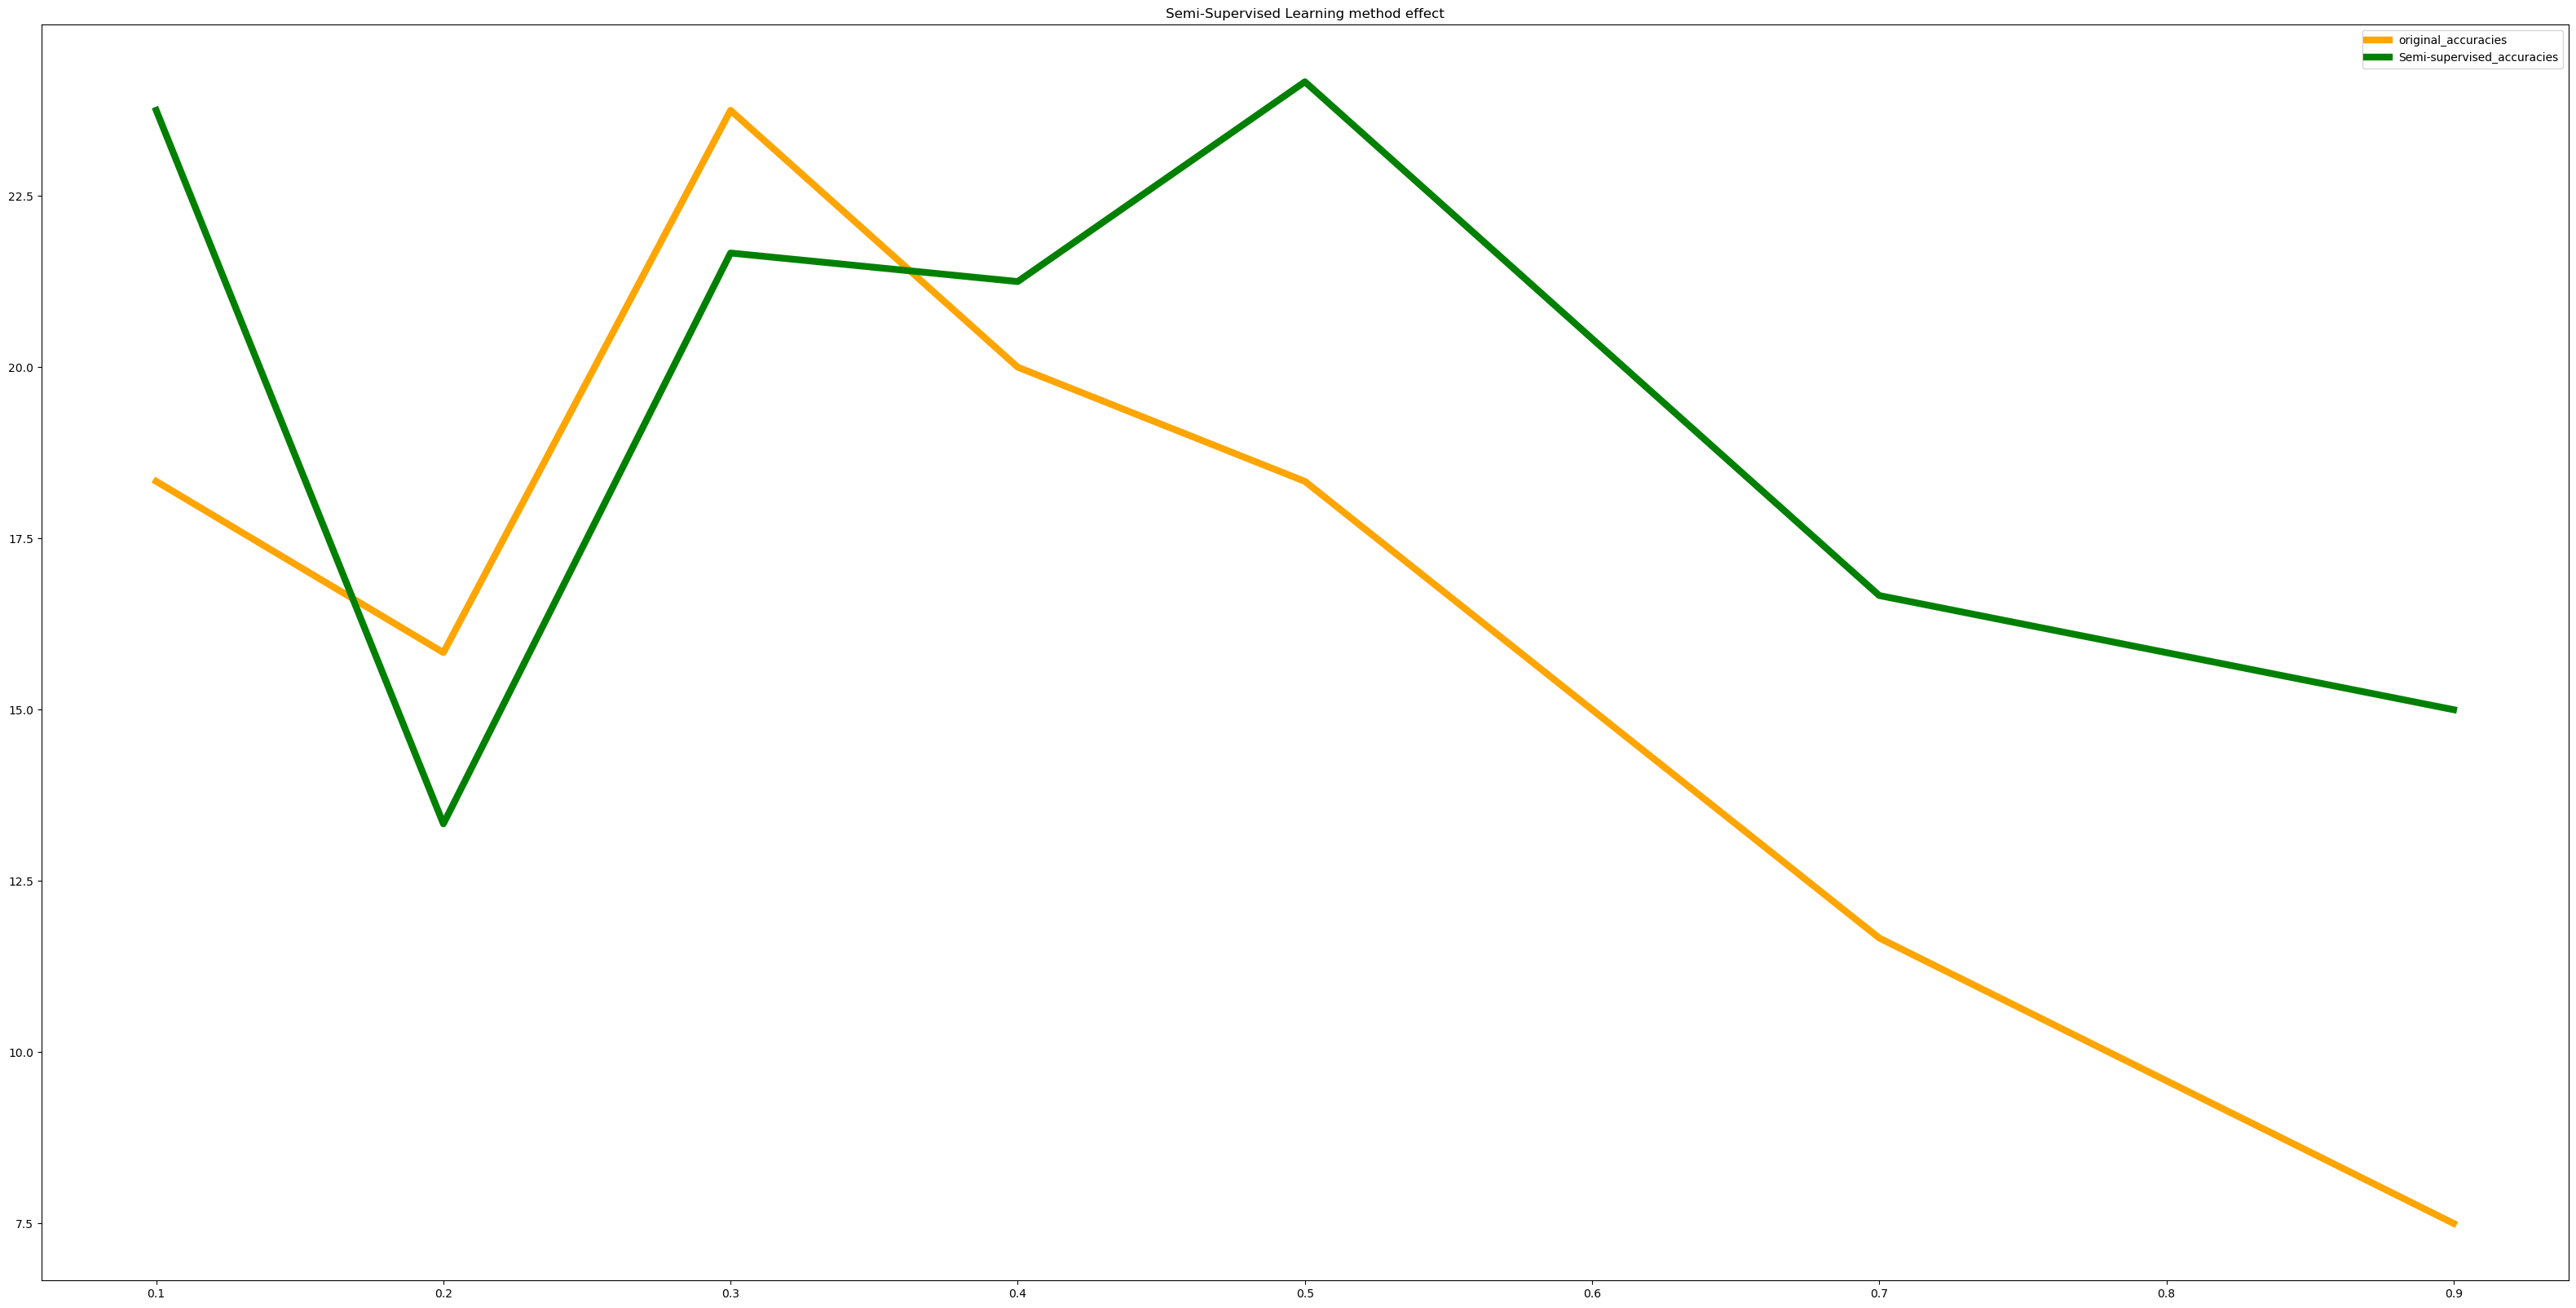

In [652]:
org_dic3 = res = dict(zip(parts, org_comp_accs3))
plot_accs(org_dic3, method_accs3,"Semi-Supervised Learning method effect")

### Artificial Neural Network

In [603]:
ann_model3 = keras.Sequential()
ann_model3.add(keras.layers.InputLayer(input_shape = (20,)))
ann_model3.add(keras.layers.Dense(60, activation ='elu'))
ann_model3.add(keras.layers.Dropout(0.3))
ann_model3.add(keras.layers.Dense(80, activation ='elu'))
ann_model3.add(keras.layers.Dropout(0.3))
ann_model3.add(keras.layers.Dense(96))
ann_model3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_641 (Dense)            (None, 60)                1260      
_________________________________________________________________
dropout_19 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_642 (Dense)            (None, 80)                4880      
_________________________________________________________________
dropout_20 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_643 (Dense)            (None, 96)                7776      
Total params: 13,916
Trainable params: 13,916
Non-trainable params: 0
_________________________________________________________________


In [604]:
ann_model3.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])



In [ ]:
start_time = time.time()
test_loss, test_acc = ann_model3.evaluate(min_max_scaler.fit_transform(one_ten_df_test),  one_ten__test_loc, verbose=2)
pred_ann = ann_model3.predict(min_max_scaler.fit_transform(one_ten_df_test))
runtime = round(time.time() - start_time,4)
print("Neural Network algorithm prediction time: "+ str(runtime))
test_acc

### Accuracies with real Data

In [ ]:
ann_model4 = keras.Sequential()
ann_model4.add(keras.layers.InputLayer(input_shape = (20,)))
ann_model4.add(keras.layers.Dense(60, activation ='elu'))
ann_model4.add(keras.layers.Dropout(0.3))
ann_model4.add(keras.layers.Dense(80, activation ='elu'))
ann_model4.add(keras.layers.Dropout(0.3))
ann_model4.add(keras.layers.Dense(96))
ann_model4.summary()
ann_model4.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])



In [ ]:
hist = ann_model4.fit(one_ten_df, one_ten_locations , epochs=100,validation_split= 0.3)

In [ ]:
start_time = time.time()
test_loss, test_acc = ann_model4.evaluate(min_max_scaler.fit_transform(one_ten_df_test),  one_ten__test_loc, verbose=2)
runtime = round(time.time() - start_time,4)
print("Neural Network algorithm prediction time: "+ str(runtime))
test_acc

## KNN with Synthesized Data

### Labeling Model Definition

In [ ]:
generated_pred , run_time = run_knn(min_max_scaler.fit_transform(one_ten_df), one_ten_locations, generated_df, [], 3)

### Testing the generated plus ground data

In [ ]:
frames = [one_ten_locations, pd.DataFrame(generated_pred, columns = ['location'])]
label_combined = pd.concat(frames)
k_nearest_neighbours(train_combined, label_combined, min_max_scaler.fit_transform(one_ten_df_test), one_ten__test_loc, "")




In [283]:
test_pred , run_time = run_knn(train_combined, label_combined, min_max_scaler.fit_transform(one_ten_df_test), [], 1)
accuracy_score(one_ten__test_loc, test_pred)*100

50.456323337679265

### Room level accuracy

In [284]:
room_lev_test_pred = []
for i in test_pred:
    room_lev_test_pred.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

In [285]:
accuracy_score(room_lev_atarget, room_lev_test_pred)*100

80.05215123859192

### Accuracies with real Data

In [286]:
original_pred , run_time = run_knn(min_max_scaler.fit_transform(one_ten_df), one_ten_locations, min_max_scaler.fit_transform(one_ten_df_test), [], 1)
accuracy_score(one_ten__test_loc, original_pred)*100


48.76140808344198

In [287]:
room_lev_original = []
for i in original_pred:
    room_lev_original.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

In [288]:
accuracy_score(room_lev_atarget, room_lev_original)*100

80.96479791395046

# Unsupervised Learning

In [657]:
from sklearn.decomposition import PCA as sklearnPCA

In [671]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters= 96)
labels = kmeans.fit_predict(alpha_filtered2_test.loc[:, no_channel_training_cols].to_numpy())


ValueError: 'c' argument has 240 elements, which is not acceptable for use with 'x' with size 240, 'y' with size 240.

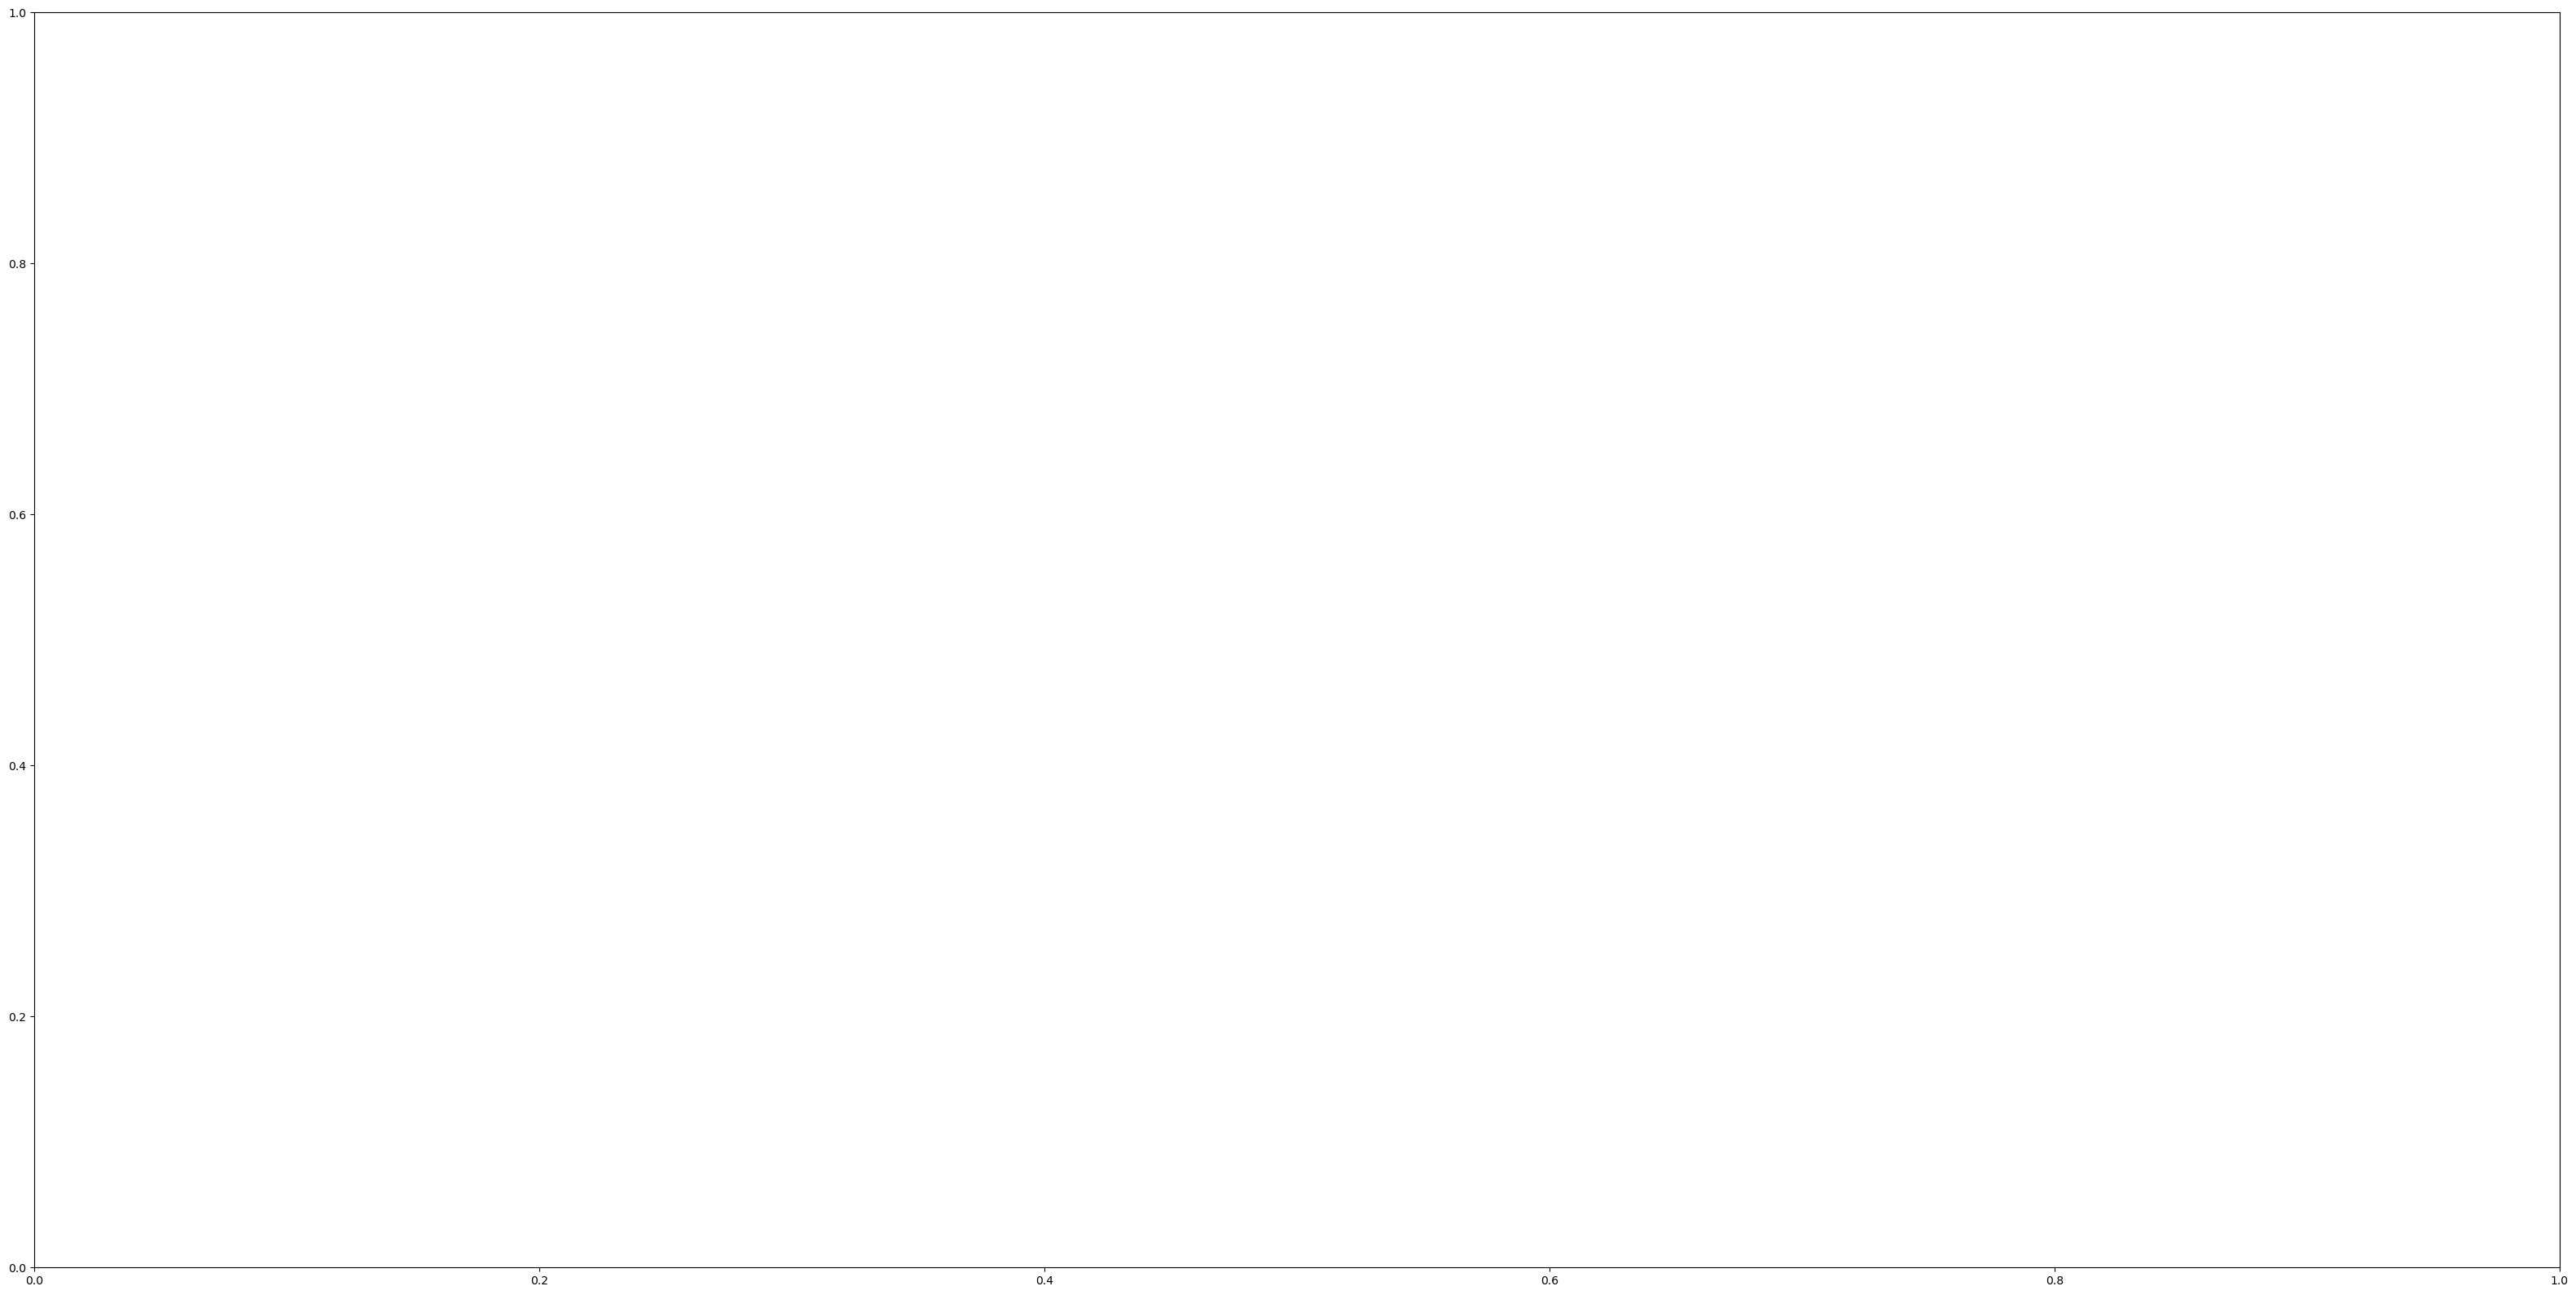

In [669]:
pca = sklearnPCA(n_components=2) 

u_labels = np.unique(labels)
for i in u_labels:
    plt.scatter(alpha_filtered2_test.loc[:, no_channel_training_cols][label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

transformed = pd.DataFrame(pca.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols].to_numpy()))
plt.scatter(transformed.loc[:, [0]].to_numpy(),transformed.loc[:, [1]].to_numpy() , c=kmeans.labels_, cmap=cmap)
plt.show()

In [667]:
transformed.loc[:, [1]].to_numpy()

array([[ 48.75077276],
       [ 52.43264707],
       [ 56.03907766],
       [ 45.89124407],
       [ 45.22223637],
       [ 43.94269824],
       [ 44.51033445],
       [ 47.95309781],
       [ 43.00265253],
       [ 43.48909171],
       [ 43.46552929],
       [ 42.35098059],
       [ 42.14243574],
       [ 42.34696712],
       [ 42.10830486],
       [ 40.47648277],
       [ 38.4649991 ],
       [ 39.07037988],
       [ 39.44366905],
       [ 39.71509996],
       [ 39.23471104],
       [ 40.46774492],
       [ 40.21887221],
       [ 37.64083009],
       [ 37.93625888],
       [ 37.56844022],
       [ 28.15860627],
       [ 29.94309542],
       [ 28.44217078],
       [ 31.2431897 ],
       [ 27.10686909],
       [ 22.91208239],
       [ 24.58304113],
       [ 26.69403209],
       [ 20.96052215],
       [ 21.95087185],
       [ 22.11397174],
       [ 21.04744746],
       [ 21.05747889],
       [ 21.00448463],
       [ 15.46284128],
       [ 13.26712879],
       [  3.71189365],
       [  5